In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading req

In [2]:
library(ComplexUpset)

In [3]:
library(ggrepel)

In [4]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original function by explicitly calling pheatmap::pheatmap().



Attaching package: 'Co

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [6]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [7]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

In [8]:
rnaseq_dpath = file.path('..', 'RNASEQ', 'DE_results')
list.files(rnaseq_dpath)


[1] "HOT1A3_DE_DESEQ_results.csv"                
 [2] "HOT1A3_DE_DESEQ_results_ref_vs_long.csv"    
 [3] "HOT1A3_DE_DESEQ_vsd.csv"                    
 [4] "HOT1A3_DE_genes_DESEQ_ref_vs_long_wKEGG.csv"
 [5] "HOT1A3_GOSEQ_results_ref_vs_long.csv"       
 [6] "MED4_DE_DESEQ_results.csv"                  
 [7] "MED4_DE_DESEQ_results_ref_vs_long.csv"      
 [8] "MED4_DE_DESEQ_vsd.csv"                      
 [9] "MED4_DE_genes_DESEQ_wKEGG_ref_vs_long.csv"  
[10] "MED4_GOSEQ_results_ref_vs_long.csv"

In [9]:
proteome_dpath = file.path('..', 'Proteome', 'data')
list.files(proteome_dpath)


[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "ALT_Axenic_DE.csv"                                                                              
 [4] "ALT_CC_DE.csv"                                                                                  
 [5] "C_ALT_proteome.txt"                                                                             
 [6] "C_ALT_proteome_norm.txt"                                                                        
 [7] "C_PRO_proteome.txt"                                                                             
 [8] "C_PRO_proteome_norm.txt"                                                                        
 [9] "Nov22_Processing.xlsx"                                                                          
[10] "P_axenic_proteome.txt"                                                                          
[11] "P_axenic_proteome_norm.txt"                                                                     
[12] "PRO_Axenic_DE.csv"                                                                              
[13] "PRO_CC_DE.csv"                                                                                  
[14] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [10]:
df_rnaseq1 = read.csv(file.path(rnaseq_dpath,'MED4_DE_DESEQ_results_ref_vs_long.csv'))  %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

df_rnaseq2 = read.csv(file.path(rnaseq_dpath,'MED4_DE_DESEQ_results.csv')) %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

In [11]:
unique(df_rnaseq2$contrast)

[1] "P2vsP1" "C1vsP1" "C2vsC1" "C3vsC1" "C4vsC1" "C5vsC1"

In [12]:
df_prot1 = read.csv(file.path(proteome_dpath,'PRO_CC_DE.csv'))
df_prot2 = read.csv(file.path(proteome_dpath,'PRO_Axenic_DE.csv'))

In [13]:
names(df_rnaseq1)
names(df_rnaseq2)
names(df_prot1)
names(df_prot2)



[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

In [14]:
unique(df_prot1$contrast)
unique(df_prot2$contrast)
unique(df_rnaseq1$contrast)
unique(df_rnaseq2$contrast)


[1] "C2 - C1"        "C3 - C1"        "C4 - C1"        "C5 - C1"       
[5] "Clongterm - C1"

[1] "P2 - P1" "P3 - P1" "P5 - P1"

[1] "Intercept"                  "treatment_long.term_vs_ref"

[1] "P2vsP1" "C1vsP1" "C2vsC1" "C3vsC1" "C4vsC1" "C5vsC1"

# LONG TERM - compare proteome to RNASEQ

In [15]:
lc_prot = df_prot1 %>% filter(contrast=='Clongterm - C1') %>% select(
    'gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC.proteome' = 'logFC','AveExpr.proteome' = 'AveExpr',
    'pvalue.proteome' = 'sca.P.Value','padj.proteome' = 'sca.adj.pval')
head(lc_prot)


gene_id      logFC.proteome AveExpr.proteome pvalue.proteome padj.proteome
1 TX50_RS01980  3.191075       0.9167156       6.252913e-10    8.904149e-07 
2 TX50_RS00040 -1.443788       1.5845359       1.202458e-08    7.127836e-06 
3 TX50_RS04695  1.373159       2.2254880       1.731707e-08    7.127836e-06 
4 TX50_RS01970  3.706744       3.6657560       2.510390e-08    7.127836e-06 
5 TX50_RS05170  2.210139      -1.3469405       2.650587e-08    7.127836e-06 
6 TX50_RS05585  2.786227      -1.7260158       3.478220e-08    7.127836e-06

In [16]:
lc_rna = df_rnaseq1 %>% filter(contrast=='treatment_long.term_vs_ref') %>% 
    select(
        'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC.rna' = 'log2FoldChange','AveExpr.rna' = 'baseMean',
    'pvalue.rna' = 'pvalue','padj.rna' = 'padj') 
head(lc_rna)
    



gene_id      AveExpr.rna logFC.rna   pvalue.rna   padj.rna   
1 TX50_RS00020 1382.0165    0.59923609 0.4130795849 1.000000000
2 TX50_RS00025  105.1823   -0.60237404 0.6151382201 1.000000000
3 TX50_RS00030  688.4678    1.07994530 0.0001286659 0.001119134
4 TX50_RS00035  350.6688    0.07797916 1.0000000000 1.000000000
5 TX50_RS00040  636.5248    0.04297486 1.0000000000 1.000000000
6 TX50_RS00045  105.8015    0.32696417 1.0000000000 1.000000000

In [17]:
lc_df = left_join(lc_rna, lc_prot, by='gene_id')

In [18]:
lc_df = left_join(lc_df, hpath_df_to_export, by='gene_id')

In [19]:
head(lc_df)

gene_id      AveExpr.rna logFC.rna   pvalue.rna   padj.rna    logFC.proteome
1 TX50_RS00020 1382.0165    0.59923609 0.4130795849 1.000000000  0.7597312    
2 TX50_RS00025  105.1823   -0.60237404 0.6151382201 1.000000000  0.1865093    
3 TX50_RS00030  688.4678    1.07994530 0.0001286659 0.001119134  0.1646272    
4 TX50_RS00035  350.6688    0.07797916 1.0000000000 1.000000000 -0.2226453    
5 TX50_RS00040  636.5248    0.04297486 1.0000000000 1.000000000 -1.4437882    
6 TX50_RS00045  105.8015    0.32696417 1.0000000000 1.000000000  0.8473577    
  AveExpr.proteome pvalue.proteome padj.proteome gene
1  3.0058919       1.852623e-03    1.132247e-02  dnaN
2  3.7832856       6.004220e-01    7.174820e-01      
3  1.3521822       4.891034e-01    6.235302e-01  purL
4  0.6911792       4.037227e-01    5.460284e-01  purF
5  1.5845359       1.202458e-08    7.127836e-06      
6 -0.3807645       6.200604e-03    2.820978e-02      
  product                                                 protein_id    
1 DNA polymerase III subunit beta                         WP_011131639.1
2 hypothetical protein                                    WP_011131640.1
3 phosphoribosylformylglycinamidine synthase subunit PurL WP_011131641.1
4 amidophosphoribosyltransferase                          WP_011131642.1
5 DNA topoisomerase 4 subunit A                           WP_011131643.1
6 tetratricopeptide repeat protein                        WP_011131644.1
  old_locus_tag X  path_id
1 NA            14 K02338 
2 NA            19        
3 NA            20 K23269 
4 NA            21 K00764 
5 NA            24 K02469 
6 NA            26        
  main                                                        
1 09120 Genetic Information Processing;09180 Brite Hierarchies
2                                                             
3 09100 Metabolism                                            
4 09100 Metabolism;09180 Brite Hierarchies                    
5 09180 Brite Hierarchies                                     
6                                                             
  sub                                                                                       
1 09124 Replication and repair;09182 Protein families: genetic information processing       
2                                                                                           
3 09104 Nucleotide metabolism                                                               
4 09104 Nucleotide metabolism;09105 Amino acid metabolism;09181 Protein families: metabolism
5 09182 Protein families: genetic information processing                                    
6                                                                                           
  path                                                                                                                                                                                                                        
1 03030 DNA replication [PATH:ko03030];03430 Mismatch repair [PATH:ko03430];03440 Homologous recombination [PATH:ko03440];03032 DNA replication proteins [BR:ko03032];03400 DNA repair and recombination proteins [BR:ko03400]
2                                                                                                                                                                                                                             
3 00230 Purine metabolism [PATH:ko00230]                                                                                                                                                                                      
4 00230 Purine metabolism [PATH:ko00230];00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250];01002 Peptidases and inhibitors [BR:ko01002]                                                                        
5 03032 DNA replication proteins [BR:ko03032];03400 DNA repair and recombination proteins [BR:ko03400]                                                              

In [20]:
lc_df = lc_df %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 

In [21]:
lc_df$Category = factor(lc_df$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))

In [22]:
subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)) %>% 
select(Category) %>%table() %>% as.data.frame() %>% arrange(Freq) #%>% dput


Category                   Freq
1 Lipid                        8 
2 Nucleotide                  15 
3 Amino acid                  19 
4 Secondary                   31 
5 Transport/Signaling         32 
6 Genetic                     57 
7 Energy/Carbohydrate/Glycan  60 
8 Other                      313

In [23]:
lc_df = lc_df %>% replace_na(list(logFC.rna=0, logFC.proteome=0))

In [24]:
my.cols <- c(brewer.pal(7, "Set1"), 'grey34')
my.cols[6] = '#FFC000'

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


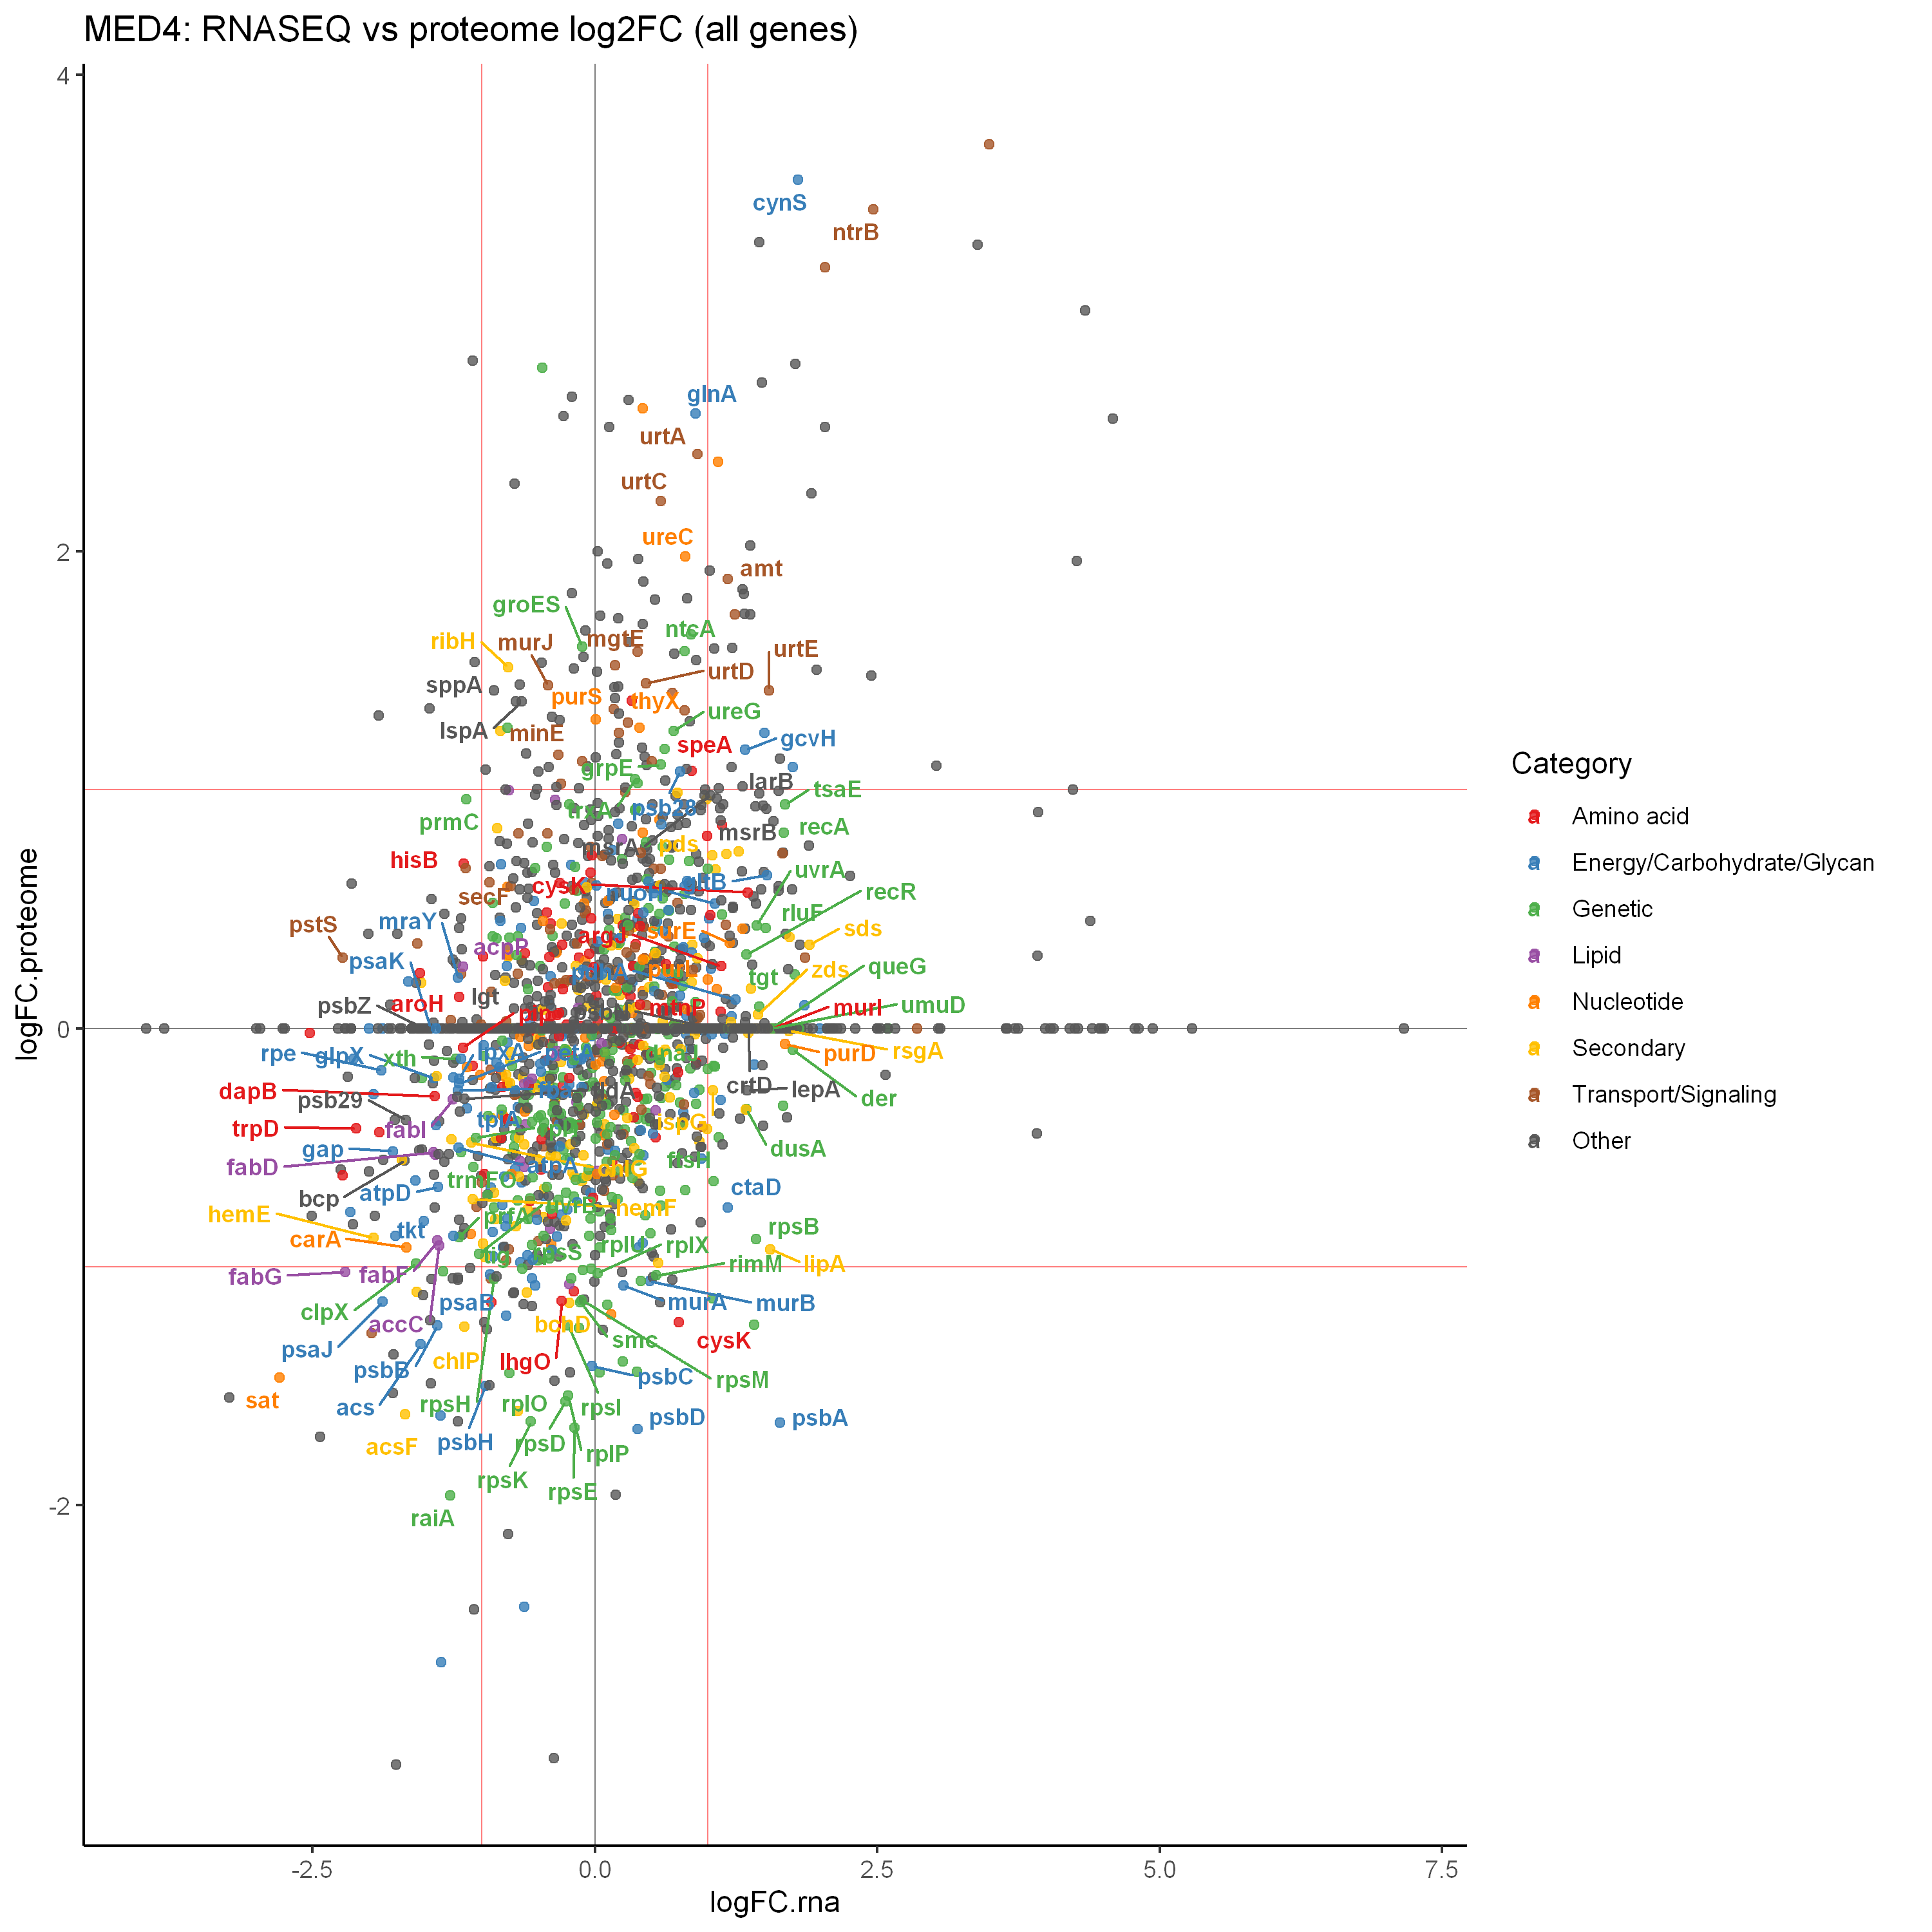

In [25]:
ggplot(lc_df, aes(x=logFC.rna, y=logFC.proteome, color=Category, #, size=-log10(pvalue.proteome)
                 )) +
    geom_vline(xintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add fold change cutoffs
    geom_hline(yintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
    geom_hline(yintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
   geom_point(size=1.5, alpha=0.8) + 
   geom_text_repel(data=subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)),
                    aes( x=logFC.rna, y=logFC.proteome,label=gene), max.overlaps = Inf, size=3, fontface='bold') + # add gene label
    scale_color_manual(values=my.cols) +
    ggtitle('MED4: RNASEQ vs proteome log2FC (all genes)') +
#scale_colour_brewer(palette = "Set1") +
    theme_classic()

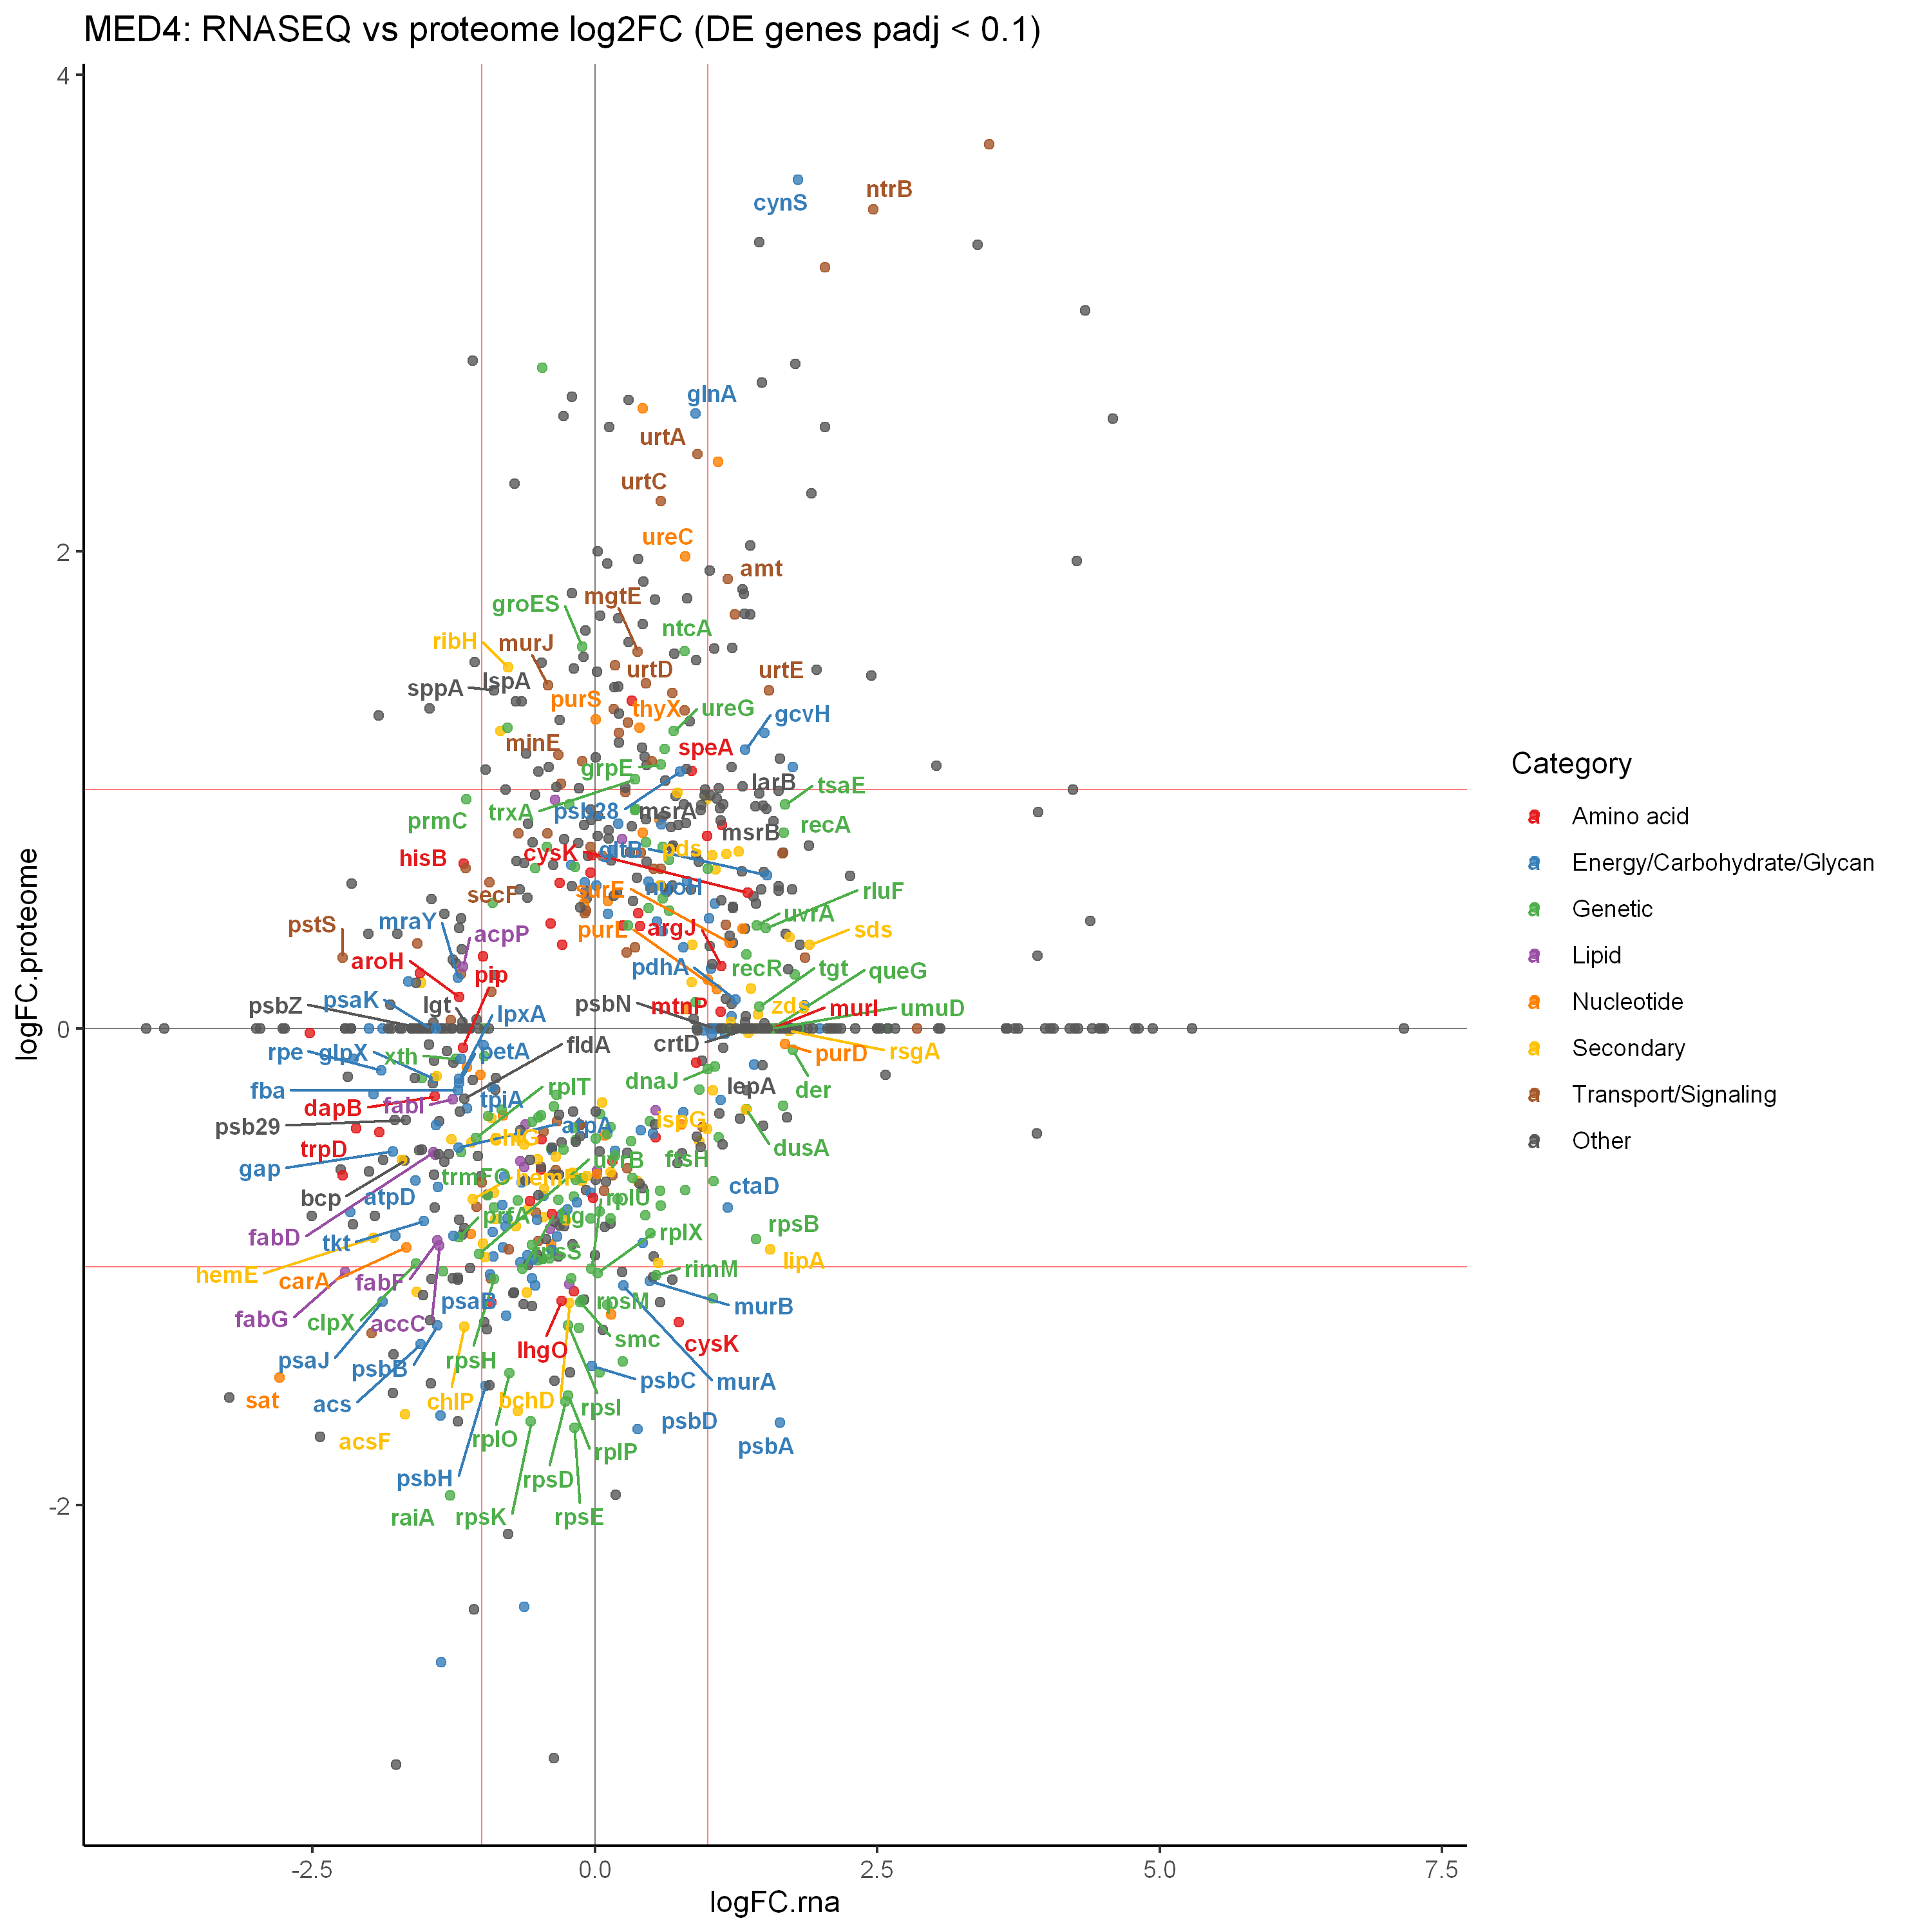

In [26]:
ggplot(subset(lc_df, (padj.proteome<0.1)|(padj.rna<0.1)), 
       aes(x=logFC.rna, y=logFC.proteome, color=Category, #, size=-log10(pvalue.proteome)
                 )) +
    geom_vline(xintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add fold change cutoffs
    geom_hline(yintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
    geom_hline(yintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
   geom_point(size=1.5, alpha=0.8) + 
   geom_text_repel(data=subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)),
                    aes( x=logFC.rna, y=logFC.proteome,label=gene), max.overlaps = Inf, size=3, fontface='bold') + # add gene label
    scale_color_manual(values=my.cols) +
    ggtitle('MED4: RNASEQ vs proteome log2FC (DE genes padj < 0.1)') +

#scale_colour_brewer(palette = "Set1") +
    theme_classic()

# upset plots

In [27]:
set_size = function(w, h, factor=1.5) {
    s = 1 * factor
    options(
        repr.plot.width=w * s,
        repr.plot.height=h * s,
        repr.plot.res=100 / factor,
        jupyter.plot_mimetypes='image/png',
        jupyter.plot_scale=1
    )
}

In [28]:
df_DElist_prot1 = df_prot1 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval') %>%
    mutate(Assay = 'Proteome')
df_DElist_prot2 = df_prot2 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')%>%
    mutate(Assay = 'Proteome')


In [29]:
df_DElist_rna1 = df_rnaseq1 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
df_DElist_rna2 = df_rnaseq2 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
    


In [30]:
df_DElist = bind_rows(df_DElist_prot1, df_DElist_prot2, df_DElist_rna1, df_DElist_rna2)

In [31]:
dput(unique(df_DElist$contrast))

c("C2 - C1", "C3 - C1", "C4 - C1", "C5 - C1", "Clongterm - C1", 
"P2 - P1", "P3 - P1", "P5 - P1", "Intercept", "treatment_long.term_vs_ref", 
"P2vsP1", "C1vsP1", "C2vsC1", "C3vsC1", "C4vsC1", "C5vsC1")


In [32]:
lookup <- c(
    "C2 - C1" = 'C2vsC1_prot', 
    "C3 - C1" = 'C3vsC1_prot', 
    "C4 - C1" = 'C4vsC1_prot', 
    "C5 - C1" = 'C5vsC1_prot', 
    "Clongterm - C1" = 'LATEvsC1_prot', 
    "P2 - P1" = 'P2vsP1_prot',
    "P3 - P1" = 'P3vsP1_prot',
    "P5 - P1" = 'P5vsP1_prot',
    "Intercept" = "Intercept",
    "treatment_long.term_vs_ref" = 'LATEvsC1P1_rna', 
    "P2vsP1" = 'P2vsP1_rna', 
    "C1vsP1" = 'C1vsP1_rna', 
    "C2vsC1" = 'C2vsC1_rna', 
    "C3vsC1" = 'C3vsC1_rna', 
    "C4vsC1" = 'C4vsC1_rna', 
    "C5vsC1" = 'C5vsC1_rna')
    
    
df_DElist = df_DElist %>% 
    mutate(contrast1 = lookup[contrast]) %>%
    filter(contrast != 'Intercept')

In [33]:
df_DElist = left_join(df_DElist, hpath_df_to_export, by='gene_id')


In [34]:
df_DElist = df_DElist %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 

In [35]:
df_DElist$Category = factor(df_DElist$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
#my.cols <- c(brewer.pal(7, "Set2"), 'grey34')


In [36]:
contrast_list = unique(df_DElist$contrast1)
contrast_list = unique(df_DElist$contrast)


In [37]:
dput(contrast_list)

c("C2 - C1", "C3 - C1", "C4 - C1", "C5 - C1", "Clongterm - C1", 
"P2 - P1", "P3 - P1", "P5 - P1", "treatment_long.term_vs_ref", 
"P2vsP1", "C1vsP1", "C2vsC1", "C3vsC1", "C4vsC1", "C5vsC1")


In [38]:
rna_CC_list = c(#"C1vsP1_rna", 
                "C2vsC1_rna", "C3vsC1_rna", "C4vsC1_rna", "C5vsC1_rna")
prot_CC_list = c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot")
latelist = c("LATEvsC1_prot","LATEvsC1P1_rna")


c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot", 
"LATEvsC1_prot", "P2vsP1_prot", "P3vsP1_prot", "P5vsP1_prot", 
"LATEvsC1P1_rna", "P2vsP1_rna", "C1vsP1_rna", "C2vsP1_rna", "C3vsP1_rna", 
"C4vsP1_rna", "C5vsP1_rna")

[1] "C2vsC1_prot"    "C3vsC1_prot"    "C4vsC1_prot"    "C5vsC1_prot"   
 [5] "LATEvsC1_prot"  "P2vsP1_prot"    "P3vsP1_prot"    "P5vsP1_prot"   
 [9] "LATEvsC1P1_rna" "P2vsP1_rna"     "C1vsP1_rna"     "C2vsP1_rna"    
[13] "C3vsP1_rna"     "C4vsP1_rna"     "C5vsP1_rna"

In [39]:

contrast_meta_df = df_DElist %>% distinct(contrast1, Assay) %>% rename(set = contrast1)


In [40]:
contrast_meta_df

set            Assay   
1  C2vsC1_prot    Proteome
2  C3vsC1_prot    Proteome
3  C4vsC1_prot    Proteome
4  C5vsC1_prot    Proteome
5  LATEvsC1_prot  Proteome
6  P2vsP1_prot    Proteome
7  P3vsP1_prot    Proteome
8  P5vsP1_prot    Proteome
9  LATEvsC1P1_rna RNA     
10 P2vsP1_rna     RNA     
11 C1vsP1_rna     RNA     
12 C2vsC1_rna     RNA     
13 C3vsC1_rna     RNA     
14 C4vsC1_rna     RNA     
15 C5vsC1_rna     RNA

In [41]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 300)

Warning message in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, :
"Converting non-logical columns to binary: C2vsC1_rna, C3vsC1_rna, C4vsC1_rna, C5vsC1_rna, C2vsC1_prot, C3vsC1_prot, C4vsC1_prot, C5vsC1_prot"


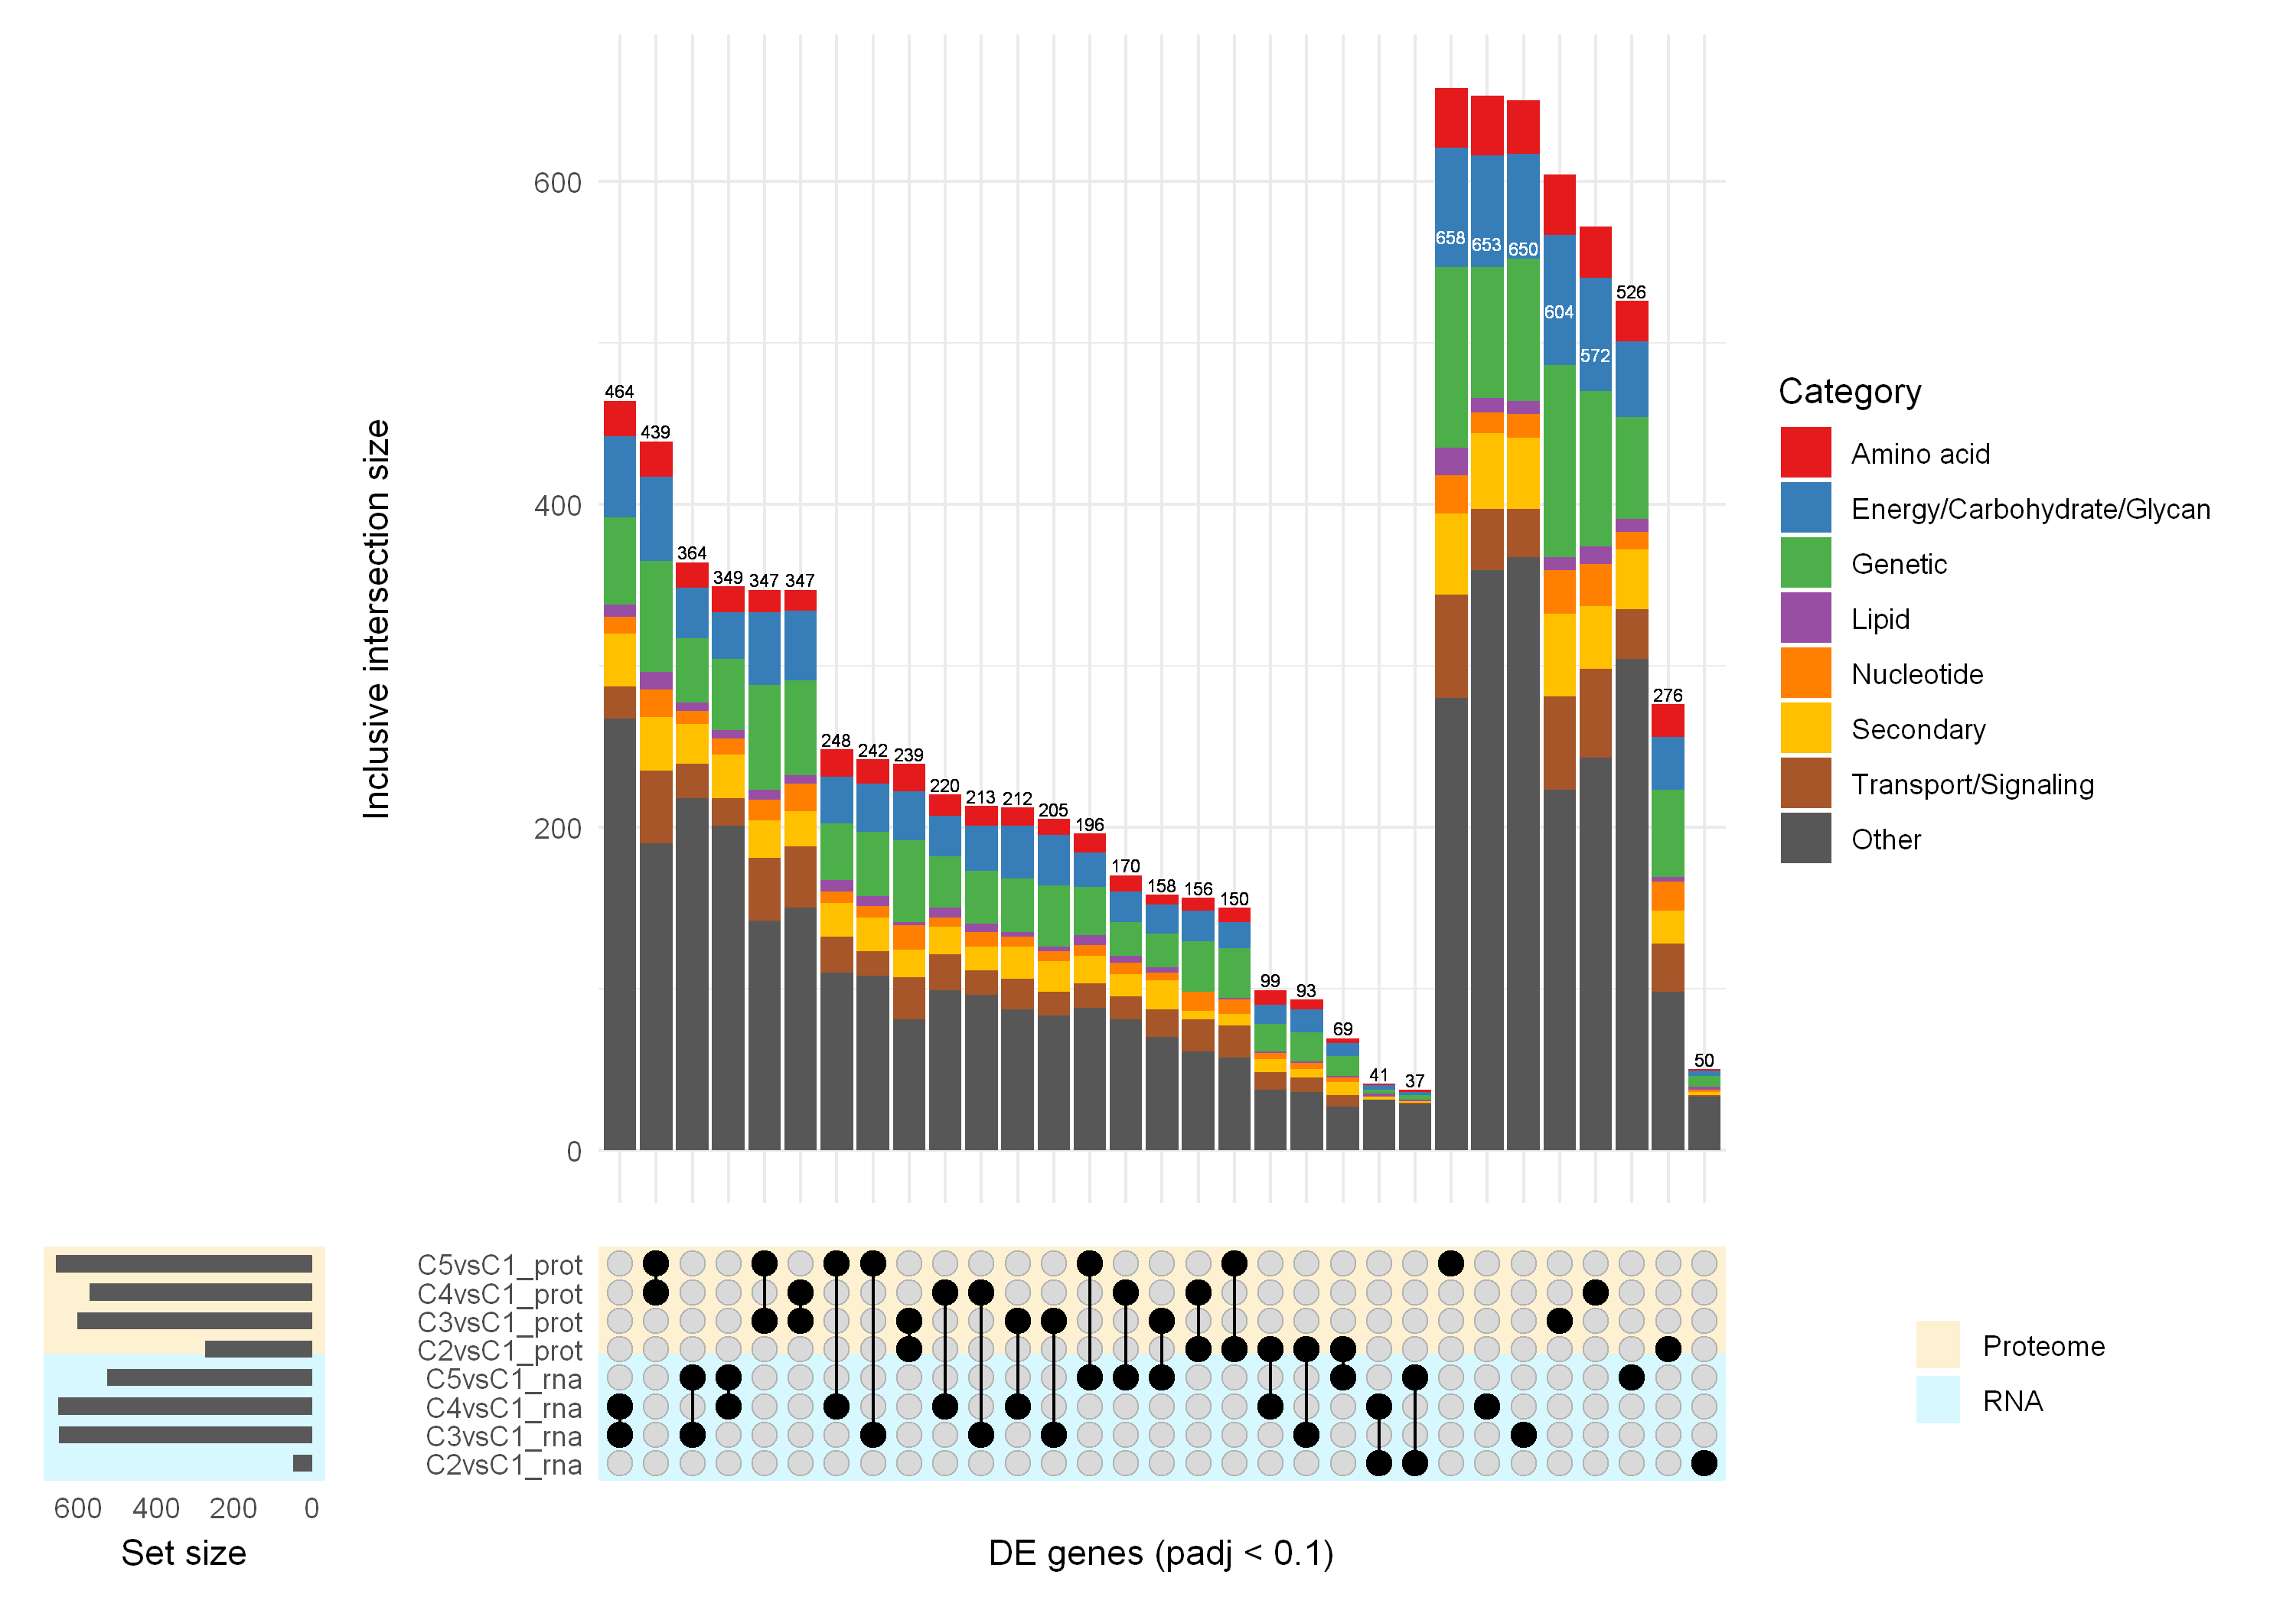

In [42]:
#set_size(10,10 )
df_DElist %>%
    filter(padj < 0.1, #abs(logFC) > 1, 
           contrast != 'Intercept') %>%
    pivot_wider(id_cols = c(gene_id,Category), names_from = contrast1, values_from = logFC, values_fill = FALSE) %>% 
upset(c(rna_CC_list, prot_CC_list), name='DE genes (padj < 0.1)', 
      mode='inclusive_intersection',
      base_annotations=list(
        'Intersection size'=intersection_size(
            mode='inclusive_intersection',
            mapping=aes(fill=Category),
            text=list(size=2)
        )
            + scale_fill_manual(values=my.cols)
    ),      
#     annotations = list(
#         'Categories'=(
#             ggplot(mapping=aes(fill=Category))
#             + geom_bar(stat='count', position='fill')
#             + scale_y_continuous(labels=scales::percent_format())
#             + scale_fill_manual(values=my.cols
#             )
#             + ylab('Category')
#         )
#     ),
      width_ratio=0.2, 
      height_ratio=0.2,
      sort_sets=FALSE,
      #min_size=10, 
      #mode='inclusive_intersection',
      min_degree=1, max_degree=2,
     sort_intersections_by=c('degree', 'cardinality'),
    stripes=upset_stripes(
        mapping=aes(color=Assay),
        colors=c(
            'Proteome'='#fef1d2',
            'RNA'='#d7f8ff'
        ),
        data=contrast_meta_df
    )) #+
#theme_classic(base_size = 15)

In [43]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

Warning message in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, :
"Converting non-logical columns to binary: Proteome, RNA"


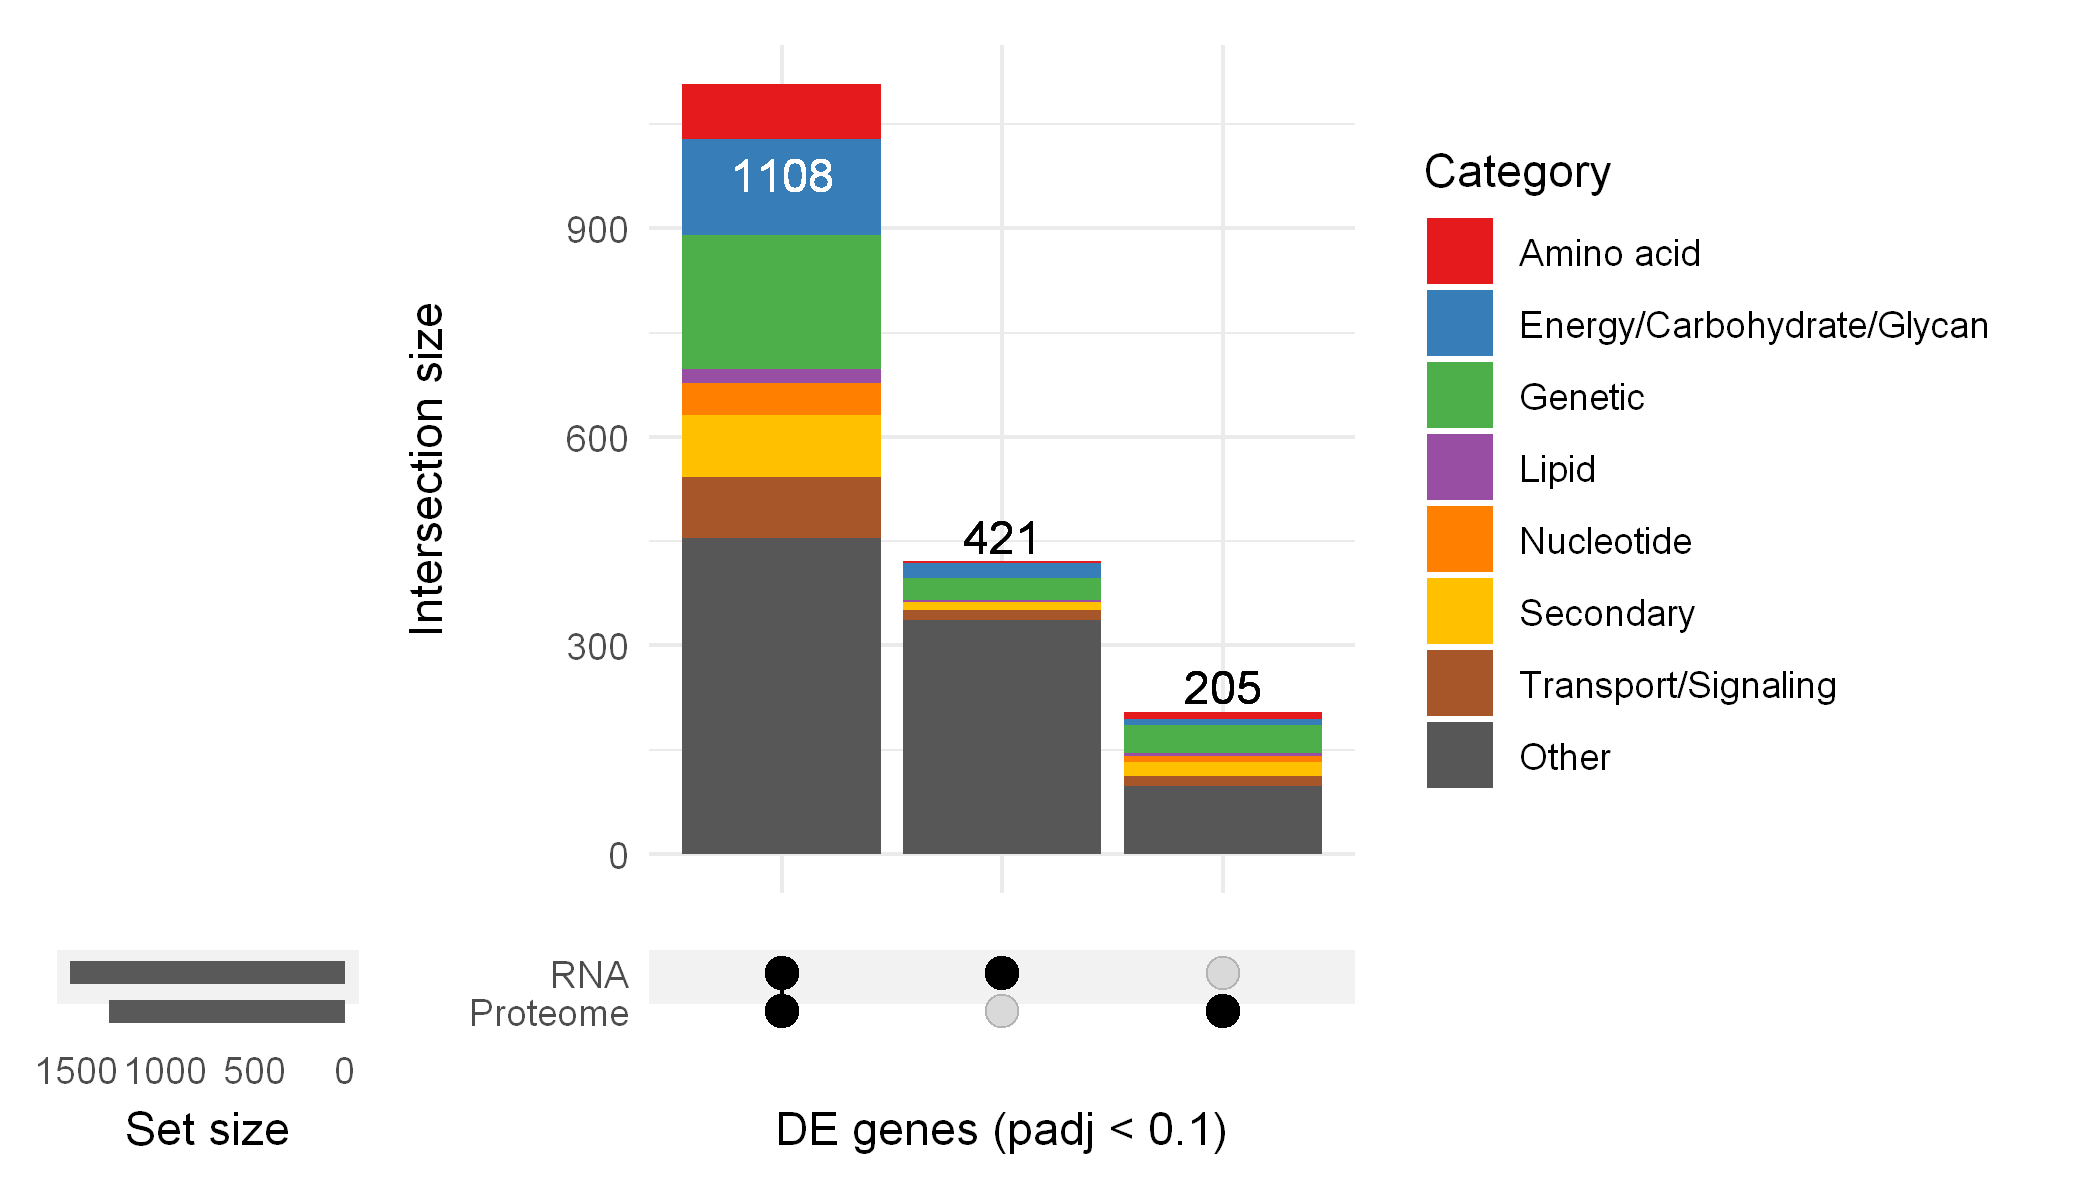

In [44]:
#set_size(10,10 )
df_DElist %>%
    filter(padj < 0.1, #abs(logFC) > 1, 
           contrast != 'Intercept') %>%
    distinct(gene_id, Assay, .keep_all =TRUE) %>%
     pivot_wider(id_cols = c(gene_id,Category), names_from = Assay, values_from = logFC, values_fill = FALSE) %>% 
 upset(c('Proteome', 'RNA'), name='DE genes (padj < 0.1)',
       height_ratio=0.1,
#       mode='inclusive_intersection',
      base_annotations=list(
        'Intersection size'=intersection_size(
#            mode='inclusive_intersection',
            mapping=aes(fill=Category)
        )
            + scale_fill_manual(values=my.cols)
    )
       )
# #     annotations = list(
# #         'Categories'=(
# #             ggplot(mapping=aes(fill=Category))
# #             + geom_bar(stat='count', position='fill')
# #             + scale_y_continuous(labels=scales::percent_format())
# #             + scale_fill_manual(values=my.cols
# #             )
# #             + ylab('Category')
# #         )
# #     ),
#       width_ratio=0.1, 
#       #min_size=10, 
#       #mode='inclusive_intersection',
#       #min_degree=1, max_degree=2,
#      #sort_intersections_by=c('degree', 'cardinality'),
#     ) #+
# #theme_classic(base_size = 15)

# GOSEQ

In [45]:
dp1 = df_prot1 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval') %>%
    mutate(Assay = 'Proteome')
dp2 = df_prot2 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')%>%
    mutate(Assay = 'Proteome')


In [46]:
dr1 = df_rnaseq1 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
dr2 = df_rnaseq2 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
    


In [47]:
df_all = bind_rows(dp1, dp2, dr1, dr2)

In [48]:
lookup <- c(
    "C2 - C1" = 'C2vsC1_prot', 
    "C3 - C1" = 'C3vsC1_prot', 
    "C4 - C1" = 'C4vsC1_prot', 
    "C5 - C1" = 'C5vsC1_prot', 
    "Clongterm - C1" = 'LATEvsC1_prot', 
    "P2 - P1" = 'P2vsP1_prot',
    "P3 - P1" = 'P3vsP1_prot',
    "P5 - P1" = 'P5vsP1_prot',
    "Intercept" = "Intercept",
    "treatment_long.term_vs_ref" = 'LATEvsC1P1_rna', 
    "P2vsP1" = 'P2vsP1_rna', 
    "C1vsP1" = 'C1vsP1_rna', 
    "C2vsC1" = 'C2vsC1_rna', 
    "C3vsC1" = 'C3vsC1_rna', 
    "C4vsC1" = 'C4vsC1_rna', 
    "C5vsC1" = 'C5vsC1_rna')
    
    
df_all = df_all %>% 
    mutate(contrast1 = lookup[contrast]) %>%
    filter(contrast != 'Intercept')

In [49]:
gtf_fpath = file.path('..','genomes', 'MED4', 'genomic.gtf')
SAF <- Rsubread::flattenGTF(gtf_fpath, GTF.featureType = "CDS")
GeneLength <- rowsum(SAF$End-SAF$Start+1, SAF$GeneID)
GeneLength = as.data.frame(GeneLength) 
names(GeneLength) = 'Length'
GeneLength = GeneLength %>% rownames_to_column('gene_id')


Flattening GTF file: C:\Users\oweisberg\Documents\GitHub\CC1A3\genomes\MED4\genomic.gtf
Output SAF file: ./.Rsubread_flattenGTF_pid18732

Looking for 'CDS' features... (grouped by 'gene_id')

Finished.



In [50]:
df_all = left_join(df_all, GeneLength, by = 'gene_id')

In [51]:
df_all

contrast gene_id      logFC      AveExpr     pvalue       padj        
1     C2 - C1  TX50_RS01980  2.6029332  0.91671556 5.951467e-07 0.0004868287
2     C2 - C1  TX50_RS05125  1.7956460  2.04648813 8.763244e-07 0.0004868287
3     C2 - C1  TX50_RS09075  1.1167539  1.46785946 1.025622e-06 0.0004868287
4     C2 - C1  TX50_RS05175  1.4380690 -0.20702445 2.486196e-06 0.0008850858
5     C2 - C1  TX50_RS08845 -0.9884268  3.74974295 3.186503e-06 0.0009075161
6     C2 - C1  TX50_RS01985  1.7087460 -0.25577666 5.226353e-06 0.0012403878
7     C2 - C1  TX50_RS05585  2.3211759 -1.72601579 6.907967e-06 0.0014052779
8     C2 - C1  TX50_RS05180  1.4995632  1.34725170 1.099431e-05 0.0017487735
9     C2 - C1  TX50_RS05170  1.6961969 -1.34694055 1.135667e-05 0.0017487735
10    C2 - C1  TX50_RS07865  1.3468844  1.29842981 1.244679e-05 0.0017487735
11    C2 - C1  TX50_RS04160  1.0422090 -0.19498831 1.468205e-05 0.0017487735
12    C2 - C1  TX50_RS07755 -1.6856352  3.03145873 1.531966e-05 0.0017487735
13    C2 - C1  TX50_RS01975  2.7204049 -2.51073856 1.615740e-05 0.0017487735
14    C2 - C1  TX50_RS01795  1.1292019 -2.13131898 1.719300e-05 0.0017487735
15    C2 - C1  TX50_RS05830  1.2333476 -1.38758233 2.254932e-05 0.0021406822
16    C2 - C1  TX50_RS01620 -1.0312176  4.75975157 2.667470e-05 0.0023740479
17    C2 - C1  TX50_RS05135  2.1339753 -0.45089397 2.942548e-05 0.0023777618
18    C2 - C1  TX50_RS04285  0.8861923  5.19382242 3.005598e-05 0.0023777618
19    C2 - C1  TX50_RS00840  0.9973780  2.83088462 3.244572e-05 0.0024317214
20    C2 - C1  TX50_RS07090  0.8326759  4.39304956 3.637684e-05 0.0025900308
21    C2 - C1  TX50_RS01275  1.7603264  1.24846350 4.978681e-05 0.0032116453
22    C2 - C1  TX50_RS05580  2.9084625 -0.98016783 5.184816e-05 0.0032116453
23    C2 - C1  TX50_RS05115  0.9566263  1.07116629 5.258699e-05 0.0032116453
24    C2 - C1  TX50_RS03160 -0.8411973  1.55098858 5.412885e-05 0.0032116453
25    C2 - C1  TX50_RS00070 -0.9446316  0.01522325 6.032841e-05 0.0033485959
26    C2 - C1  TX50_RS04030 -0.8496043  4.10854232 6.114009e-05 0.0033485959
27    C2 - C1  TX50_RS04820 -1.4475288 -0.03773708 6.409682e-05 0.0033515045
28    C2 - C1  TX50_RS03015  0.7703025  0.82302939 6.590037e-05 0.0033515045
29    C2 - C1  TX50_RS04910  2.5511150  5.63148746 7.310912e-05 0.0035899099
30    C2 - C1  TX50_RS06225  0.8860563  0.96424656 7.869063e-05 0.0037351817
⋮     ⋮        ⋮            ⋮          ⋮           ⋮            ⋮           
24348 C5vsC1   TX50_RS09745 -1.3348623   82.626698 1.159048e-02 5.263716e-02
24349 C5vsC1   TX50_RS09750 -1.8732931  213.265107 4.511059e-02 1.398655e-01
24350 C5vsC1   TX50_RS09755 -0.9517516  229.634883 7.381151e-02 1.994527e-01
24351 C5vsC1   TX50_RS09760 -0.6576445    7.416545 5.860466e-01 7.448740e-01
24352 C5vsC1   TX50_RS09765 -1.6203712   35.964266 2.794831e-03 1.869133e-02
24353 C5vsC1   TX50_RS09770 -4.3461845    6.500273 9.076308e-03 4.415966e-02
24354 C5vsC1   TX50_RS09775 -0.2812124   91.738114 4.674206e-01 6.490590e-01
24355 C5vsC1   TX50_RS09780 -0.2954429  377.599020 5.494372e-01 7.183895e-01
24356 C5vsC1   TX50_RS09785 -1.1284521   77.554290 1.815533e-02 7.150109e-02
24357 C5vsC1   TX50_RS09790 -0.1781373  117.561929 4.863640e-01 6.678485e-01
24358 C5vsC1   TX50_RS09795 -2.3652482  144.033286 1.778696e-02 7.050034e-02
24359 C5vsC1   TX50_RS09800 -1.0757704  990.293863 7.503843e-02 2.007169e-01
24360 C5vsC1   TX50_RS09805 -5.1028850  102.631580 5.340997e-06 1.235773e-04
24361 C5vsC1   TX50_RS09810 -4.0537809  246.964274 1.577950e-08 8.345100e-07
24362 C5vsC1   TX50_RS09815 -1.4766567 1301.573746 1.073421e-02 4.942542e-02
24363 C5vsC1   TX50_RS09820 -0.9090064 1661.019631 1.419581e-01 3.058751e-01
24364 C5vsC1   TX50_RS09825  1.4320110  335.895318 9.803139e-05 1.417626e-03
24365 C5vsC1   TX50_RS09830  4.0607446 2098.390306 2.468833e-21 9.139619e-19
24366 C5vsC1   TX50_RS09835  2.0446330    7.514383 3.438768e-02 1.162895e-01
24367 C5vsC1   TX50_RS09840  4.3943475 1505.075959 5.113276e-27 3.154891e-24
24

In [52]:
df_all = df_all %>% 
    mutate(
        down = ((logFC < 0) & (padj < 0.1)),
        up   = ((logFC > 0) & (padj < 0.1)),
)

In [53]:
hpath_df = hpath_df %>% mutate(gene = if_else(gene != '', gene, gene_id))

In [54]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [55]:
run_enrichment <- function(contrastname, encolname, testcolname) {
    #cat_df = path_df %>% select(encolname, main) %>% distinct()    
    mpath_df = hpath_df %>%
       #filter(main != '')  %>%
       pivot_longer(cols = all_of(encolname), values_to = 'PATH') %>%
       mutate(PATH = word(PATH)) %>%
       distinct(PATH, gene_id, .keep_all= TRUE) %>%
       select(gene_id, PATH)
    path_names = hpath_df %>%
       #filter(main != '')  %>%
       pivot_longer(cols = all_of(encolname), values_to = 'PATH') %>%
       mutate(category = word(PATH)) %>%
       distinct(category, .keep_all= TRUE) %>%
       select(category, PATH, main)
    test_df = df_all %>% drop_na(padj) %>% filter(contrast1 == contrastname)
    test_df$sigval = if_else(test_df[[testcolname]], 1, 0)
    DEgenes = test_df$sigval
    names(DEgenes) = test_df$gene_id
    table(DEgenes)
    LENgenes = test_df$Length
    names(LENgenes) = test_df$gene_id
    pwf = nullp(DEgenes, bias.data=LENgenes)
    goseq_res = goseq(pwf, gene2cat = as.data.frame(mpath_df))
    goseq_res = left_join(goseq_res, path_names)
    goseq_res = goseq_res %>% filter(numInCat>=5) %>% filter(!main %in% ignore_main)
    goseq_res$padj = p.adjust(goseq_res$over_represented_pvalue, method="BH")
    goseq_res = goseq_res %>%
       relocate(padj, .after = over_represented_pvalue) %>%
       relocate(PATH, .after = category) 
    goseq_res$type = testcolname
    goseq_res$enrich = encolname
    goseq_res$contrast = contrastname
    goseq_res$organism = 'MED4'
    #return(mpath_df)
    return (goseq_res)
}

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


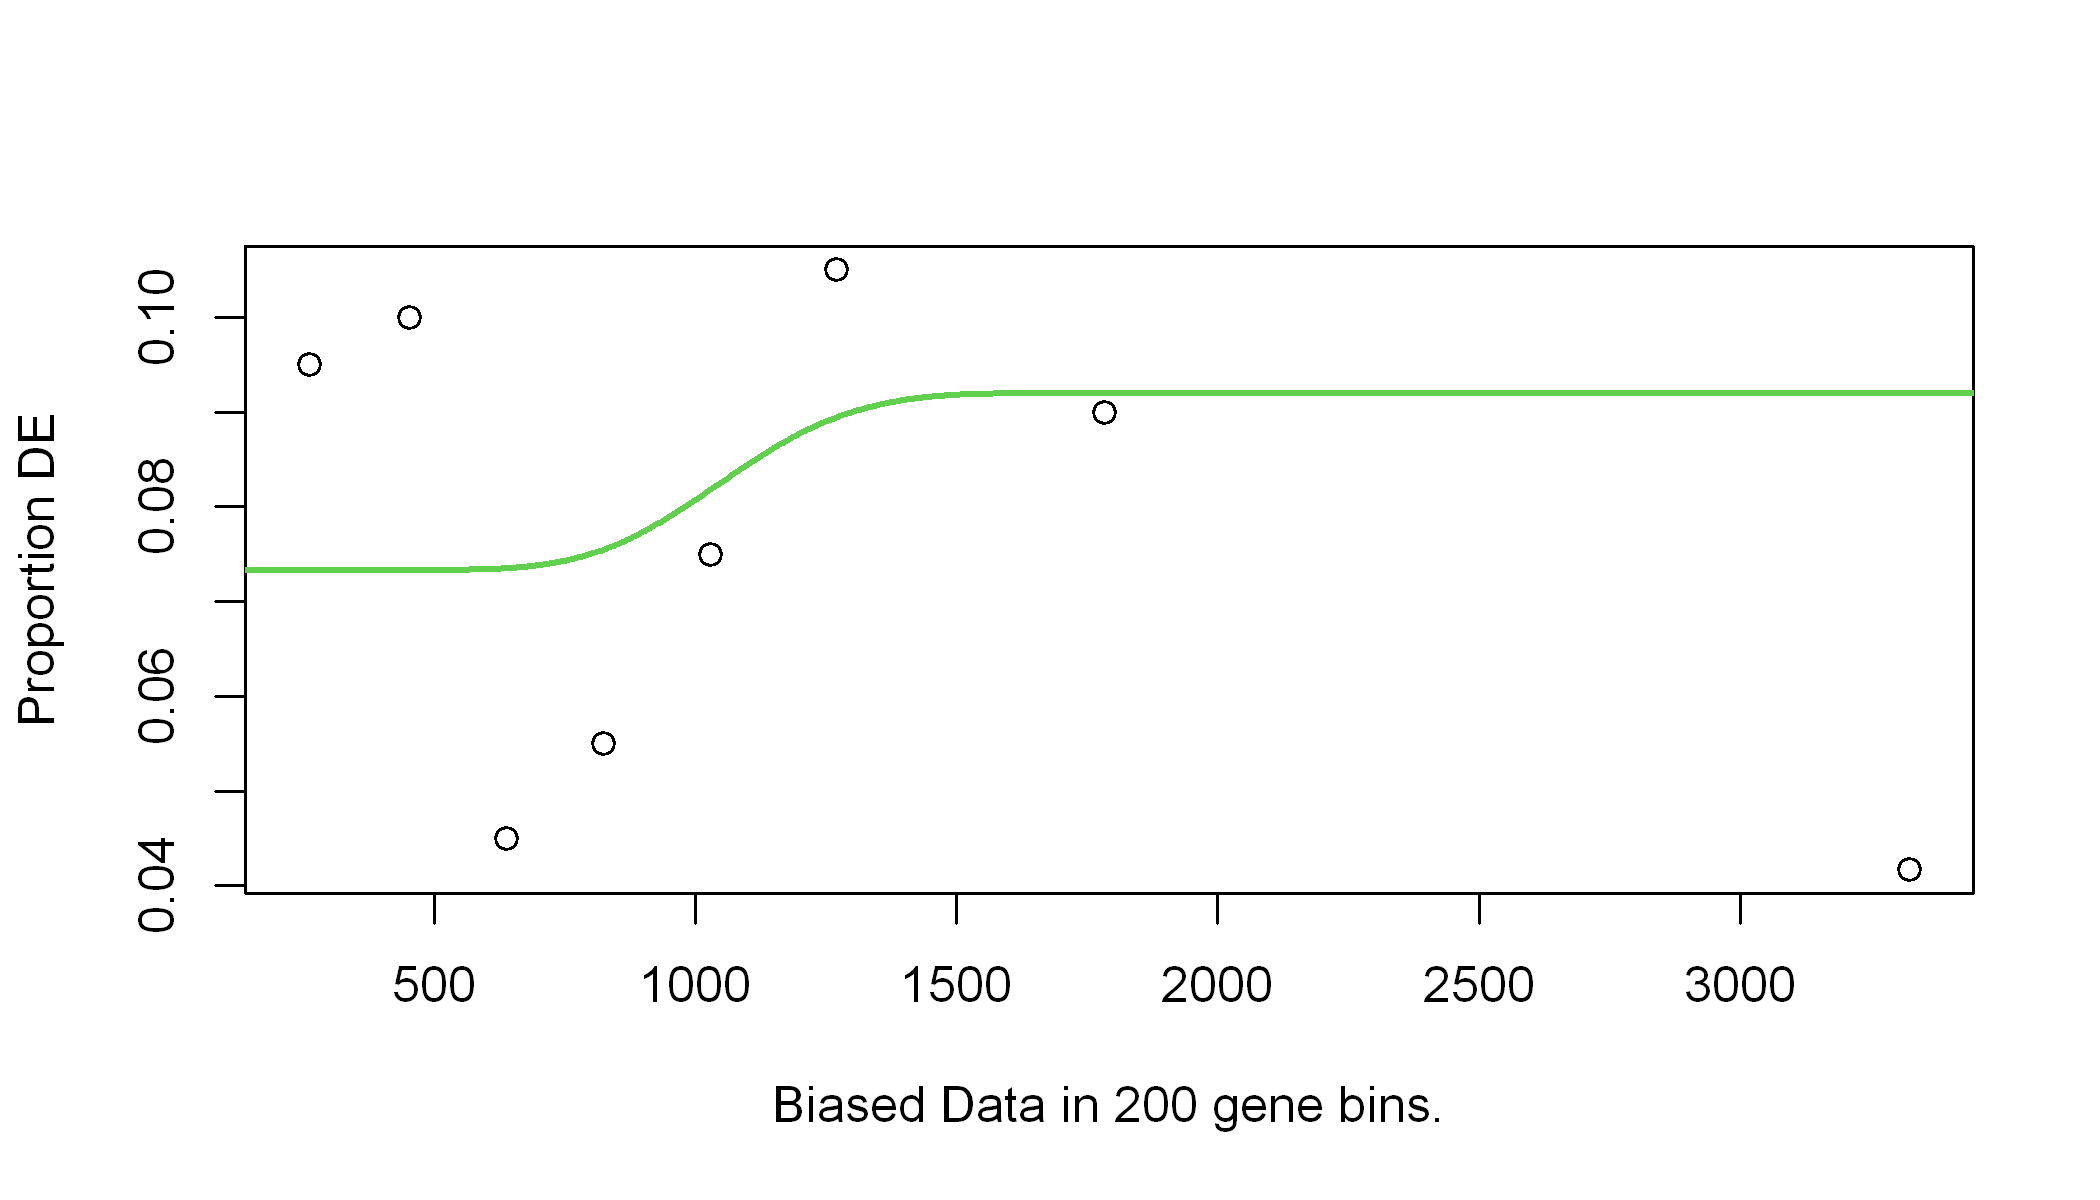

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


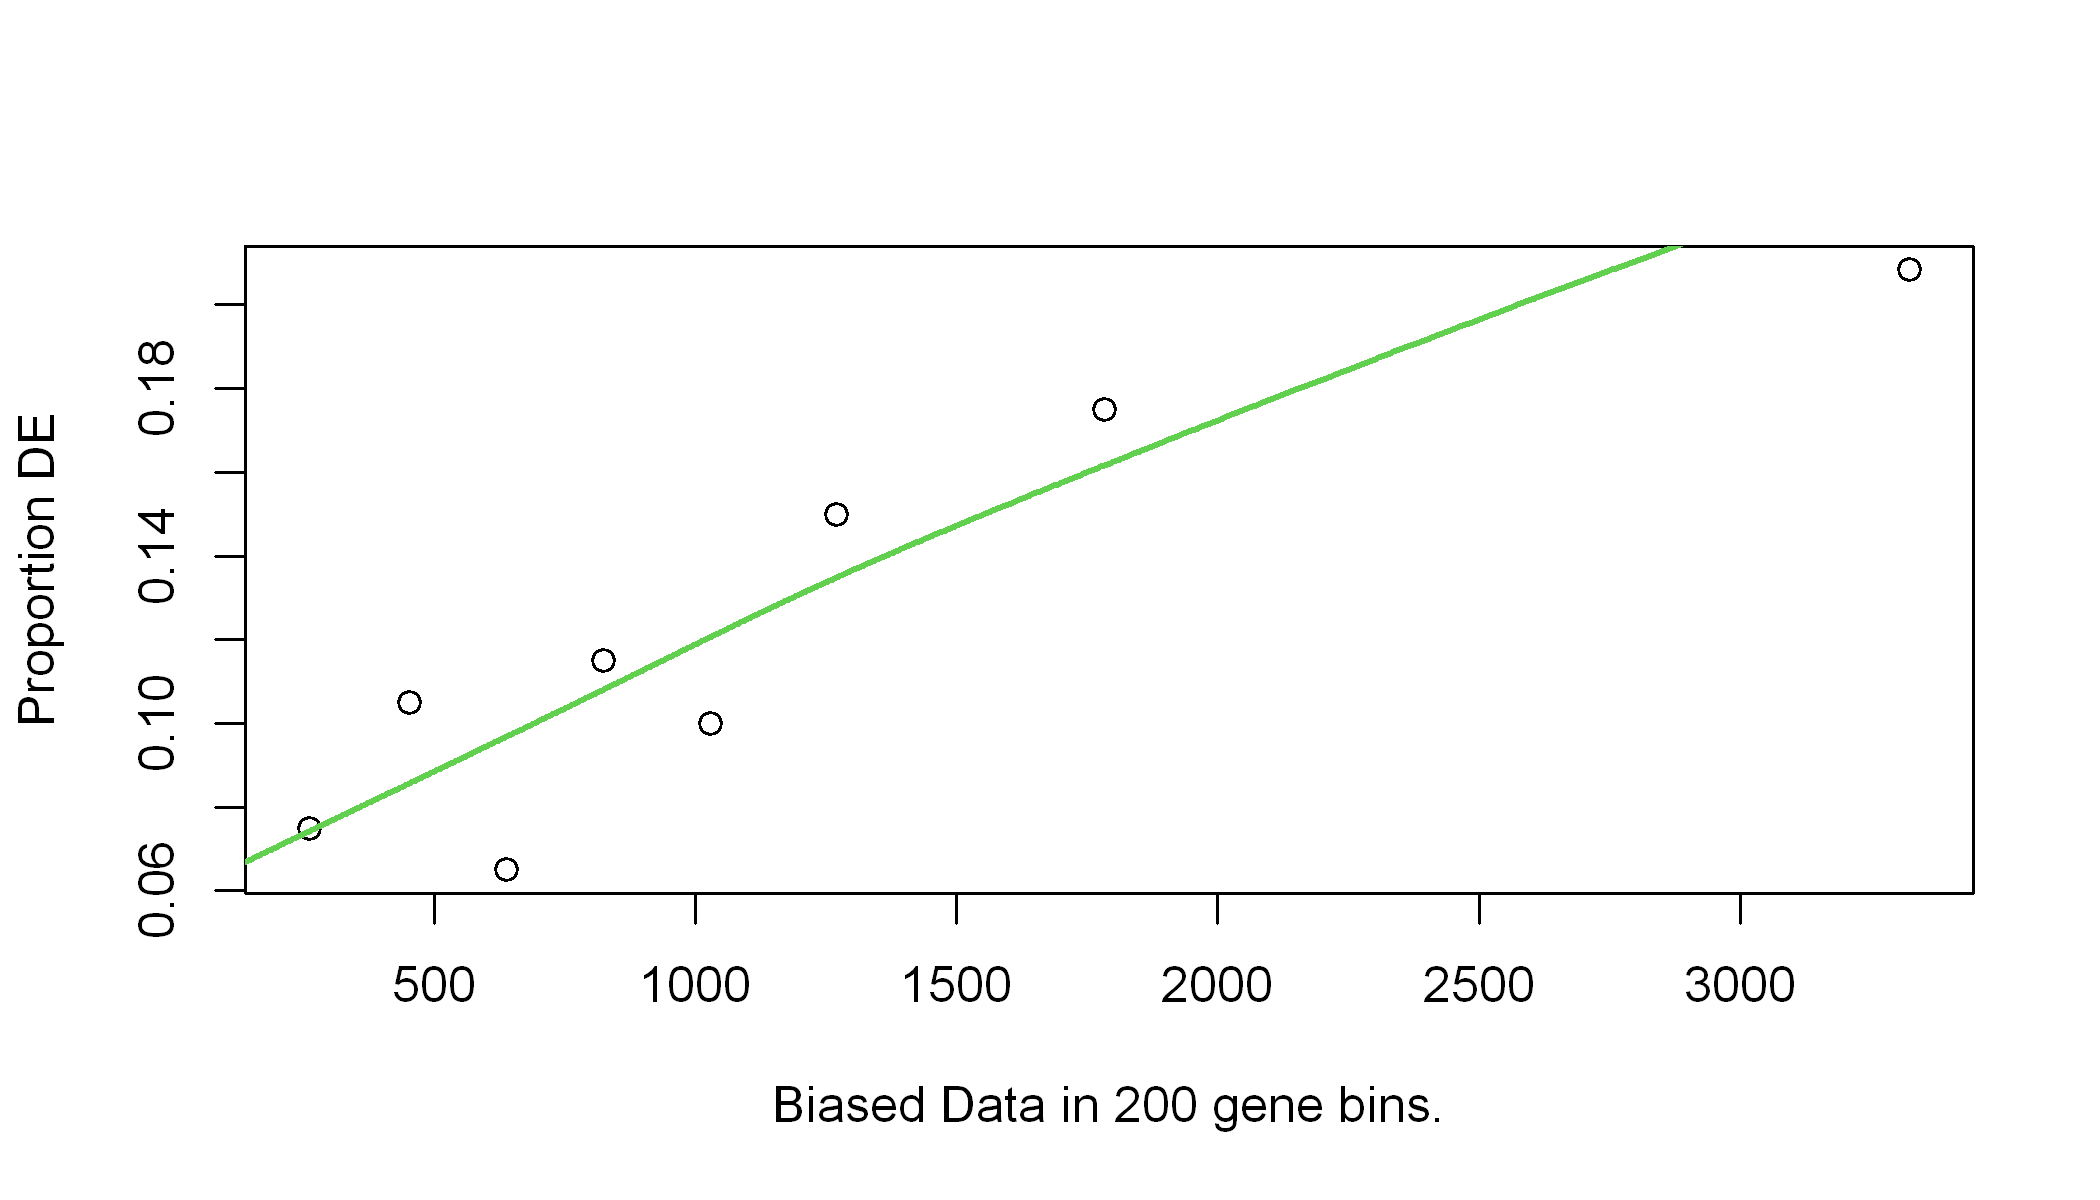

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


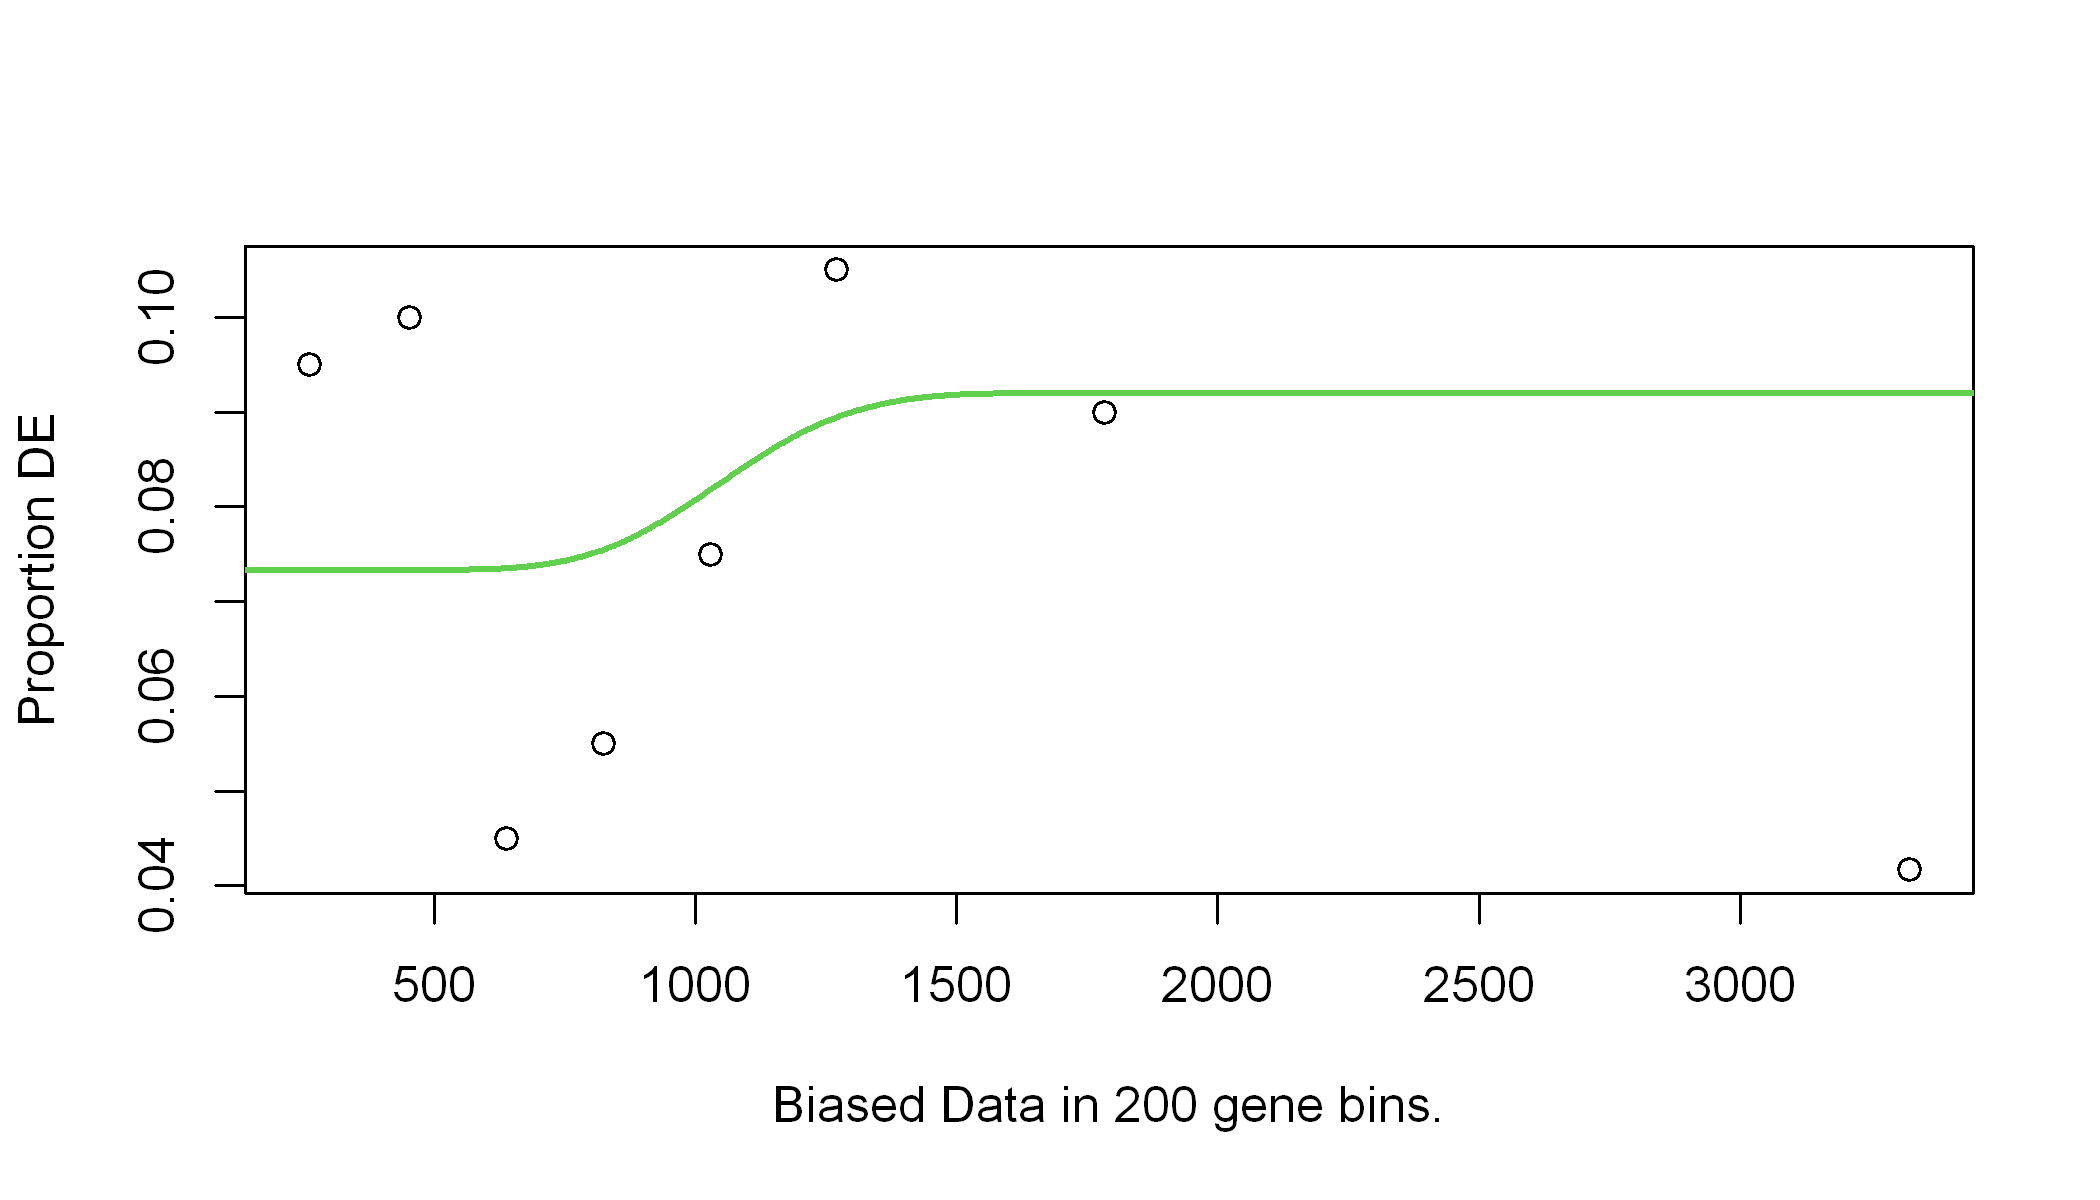

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


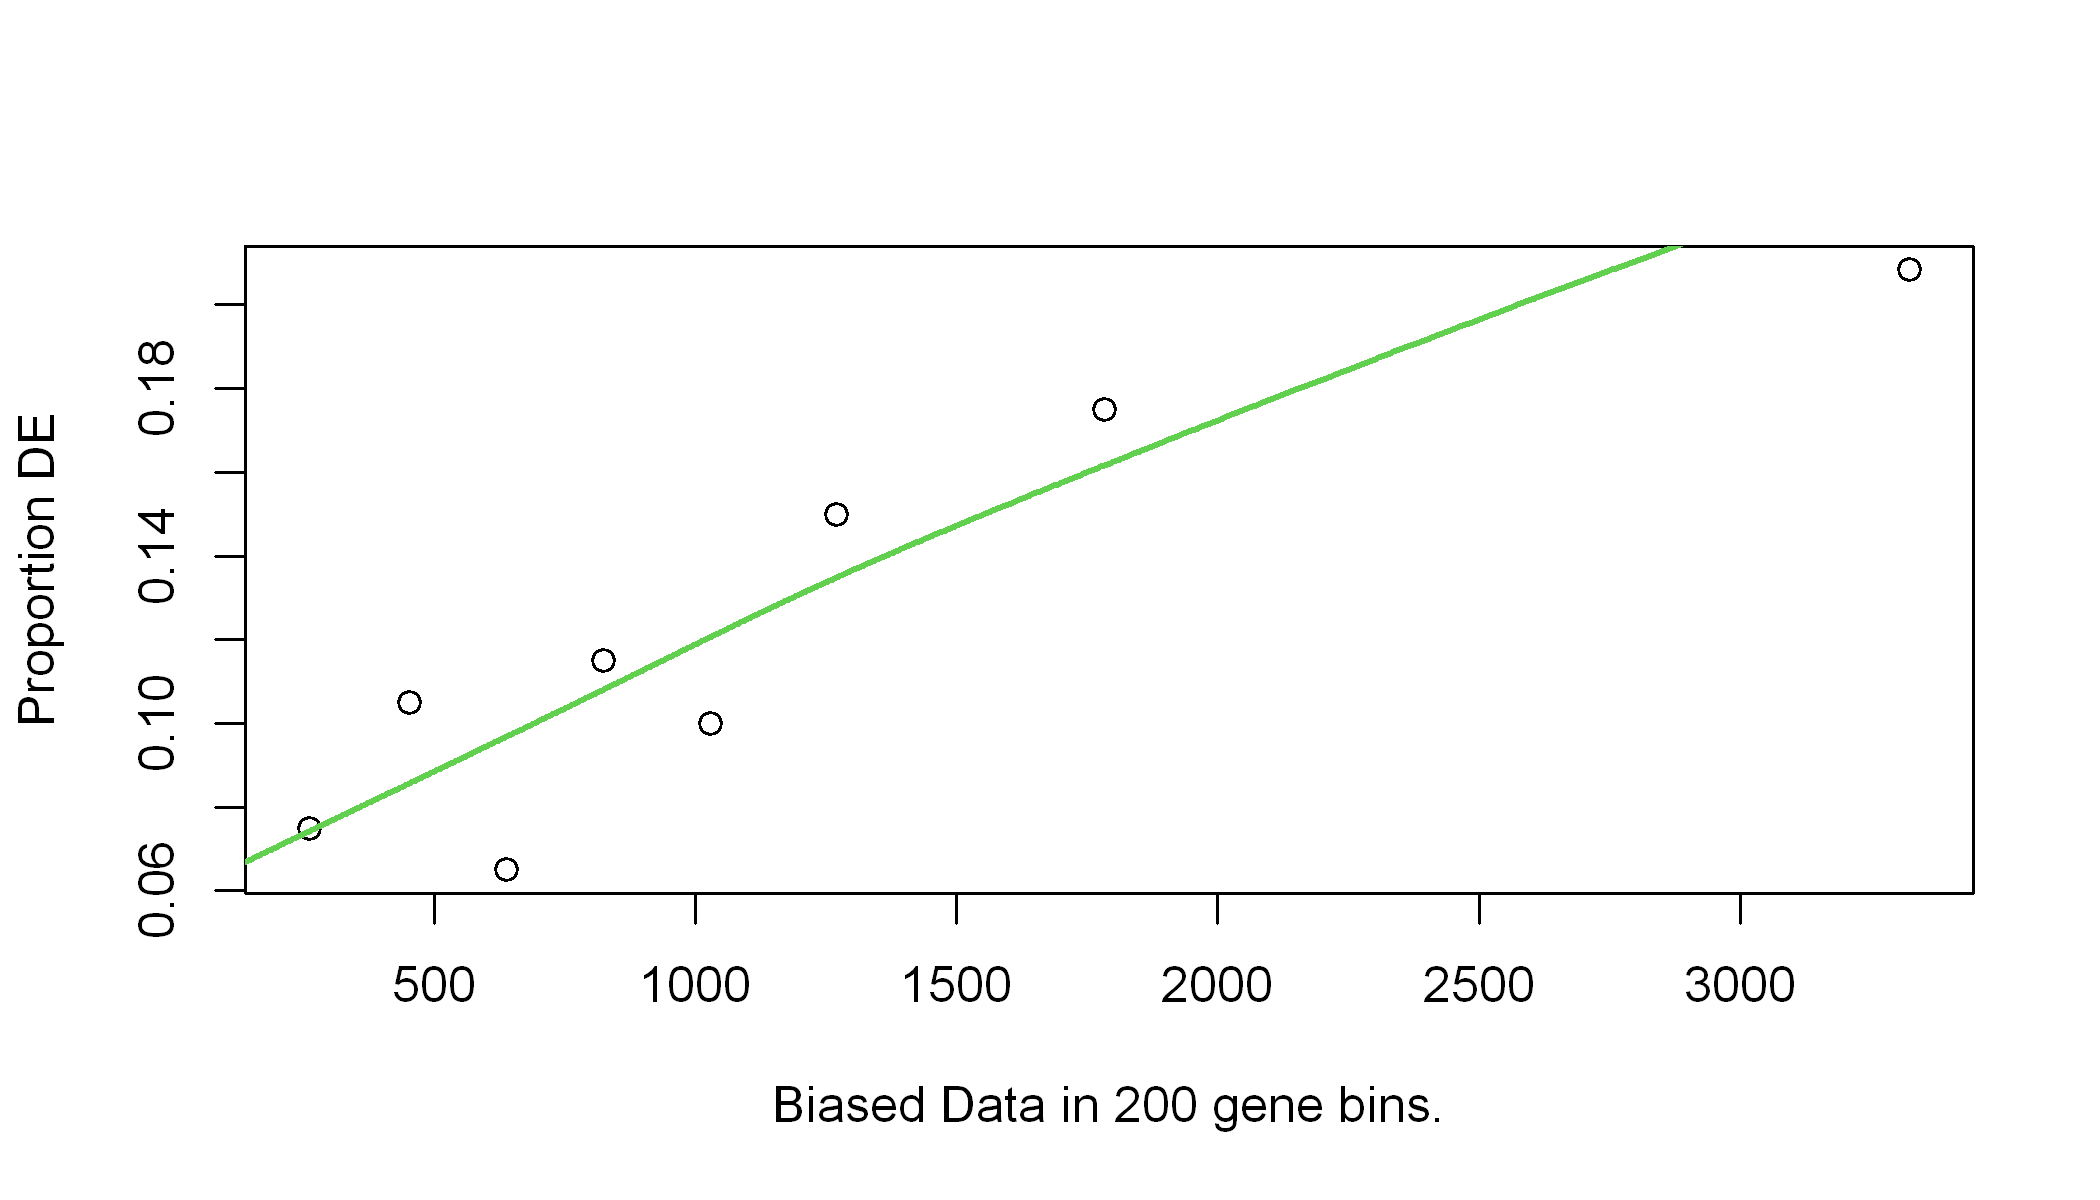

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


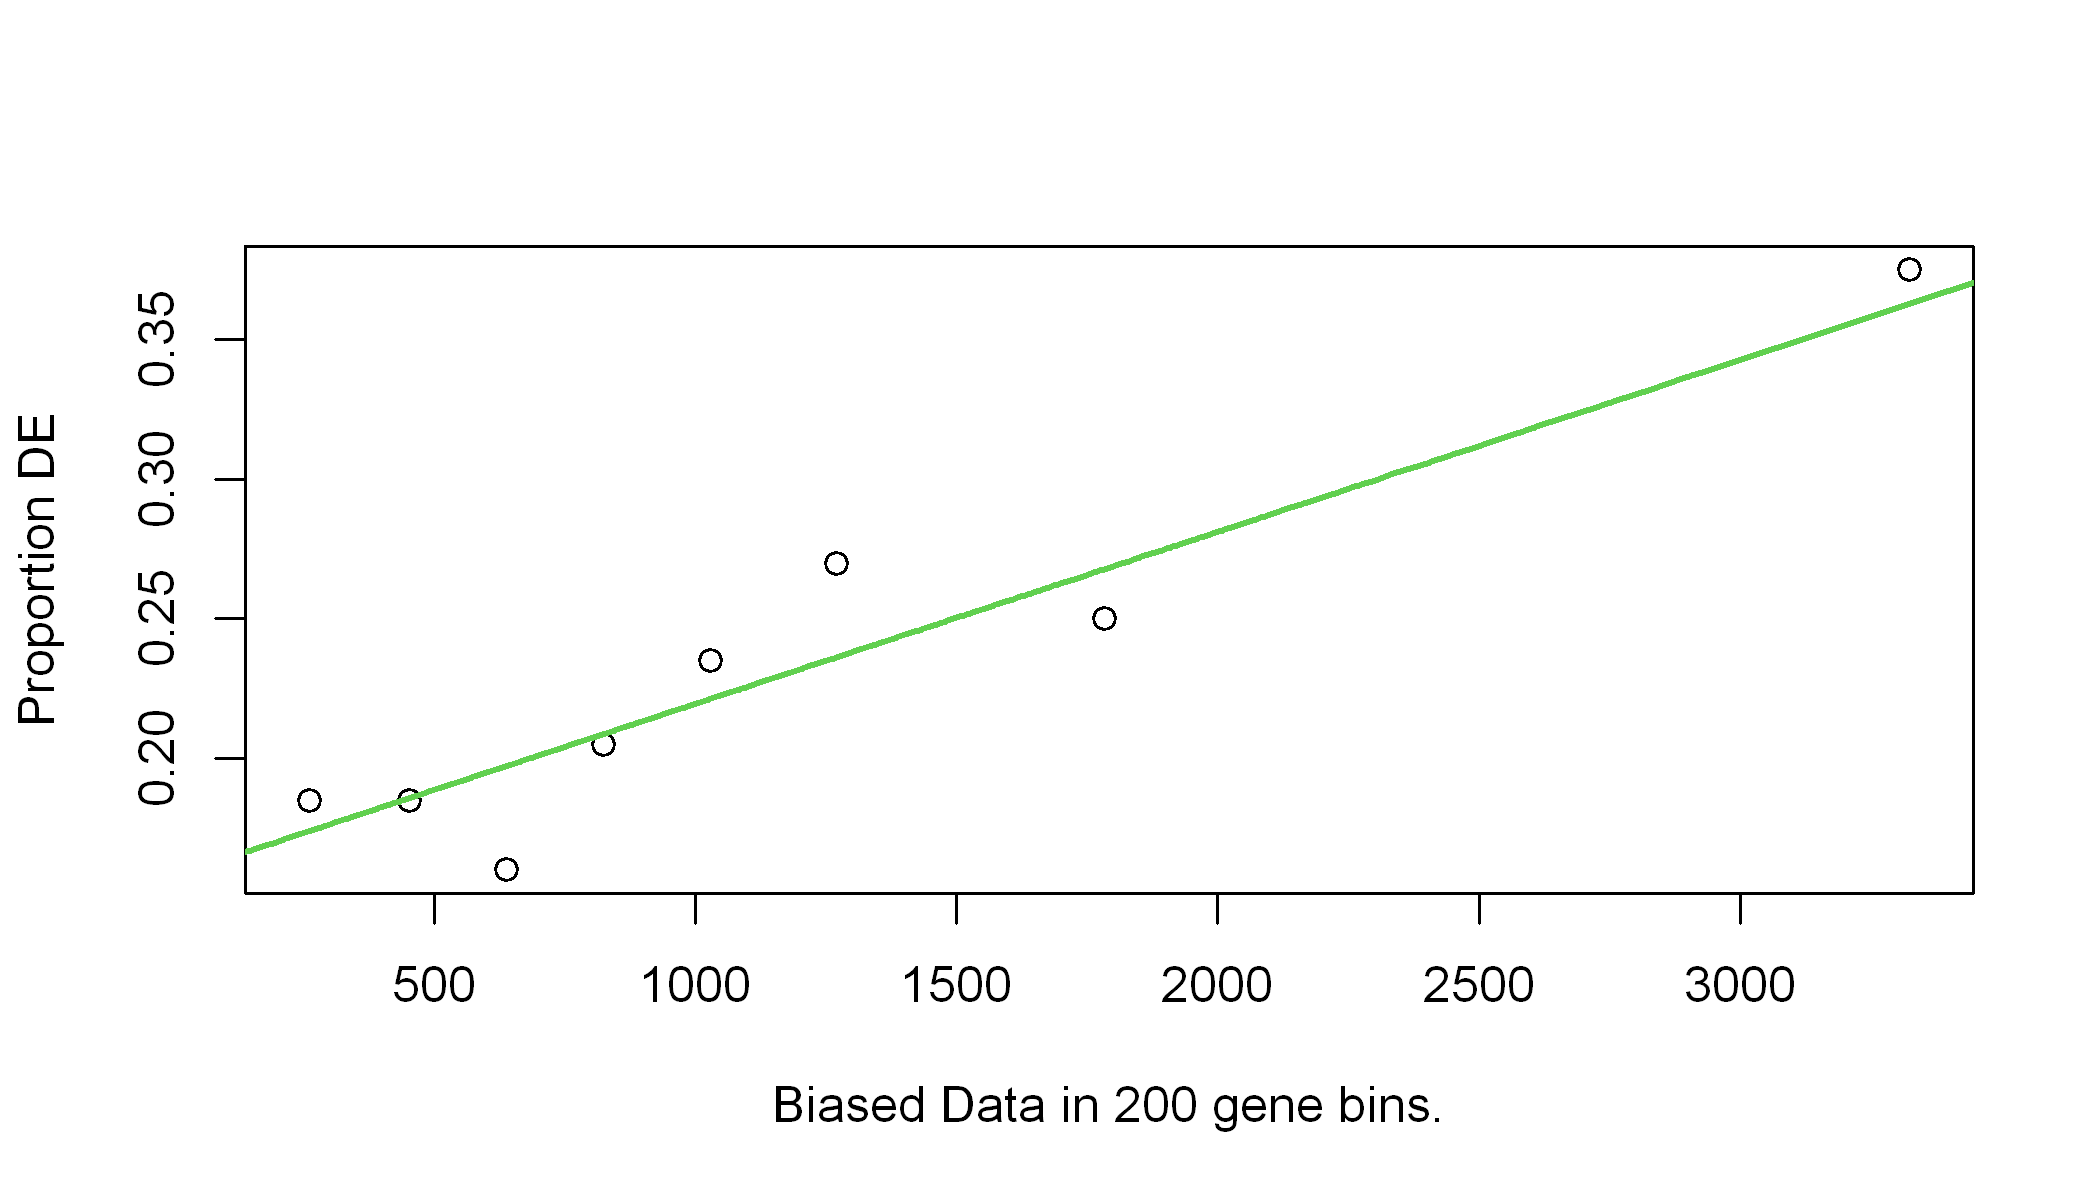

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


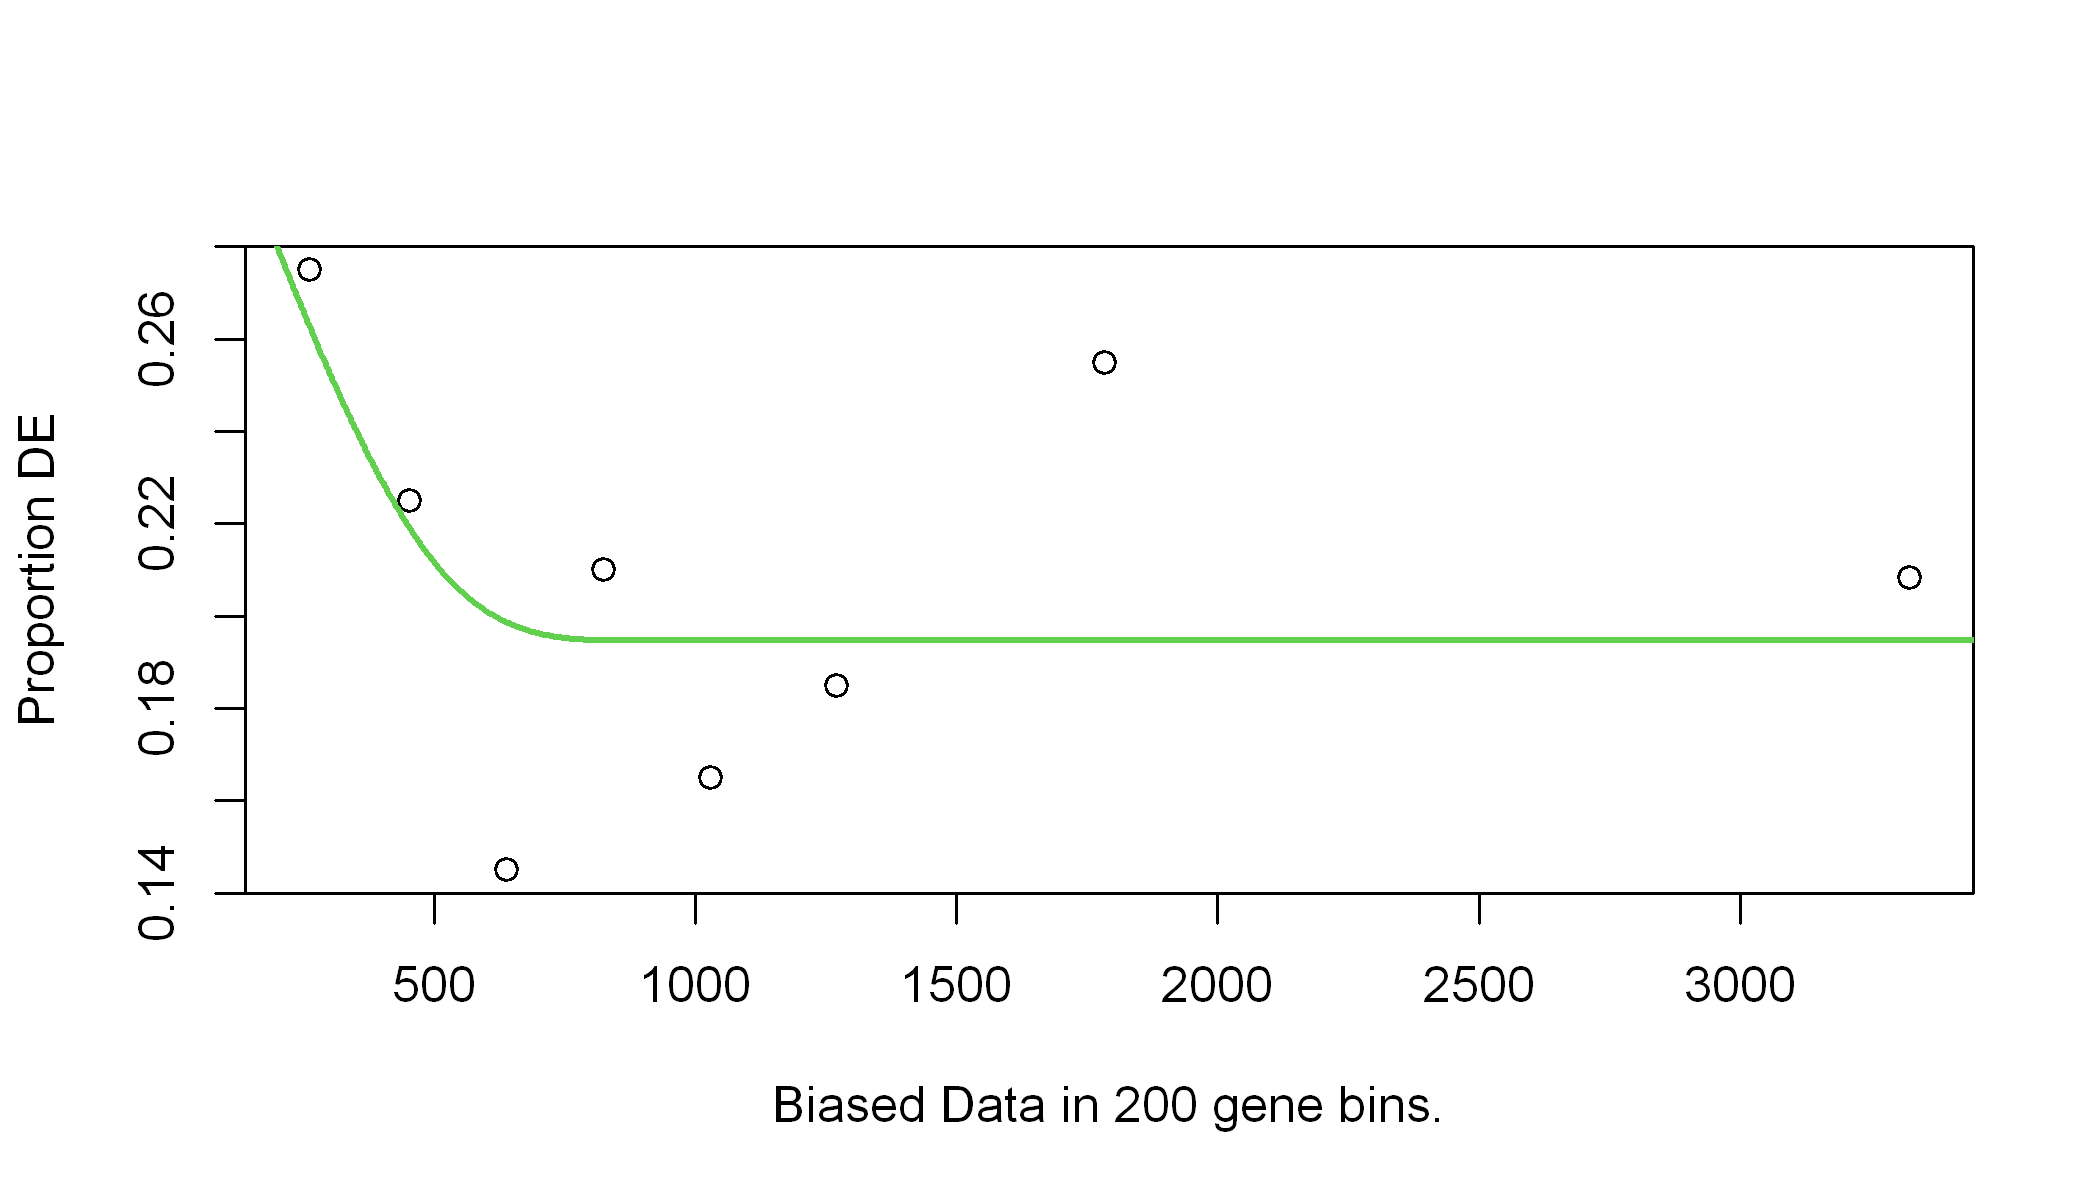

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


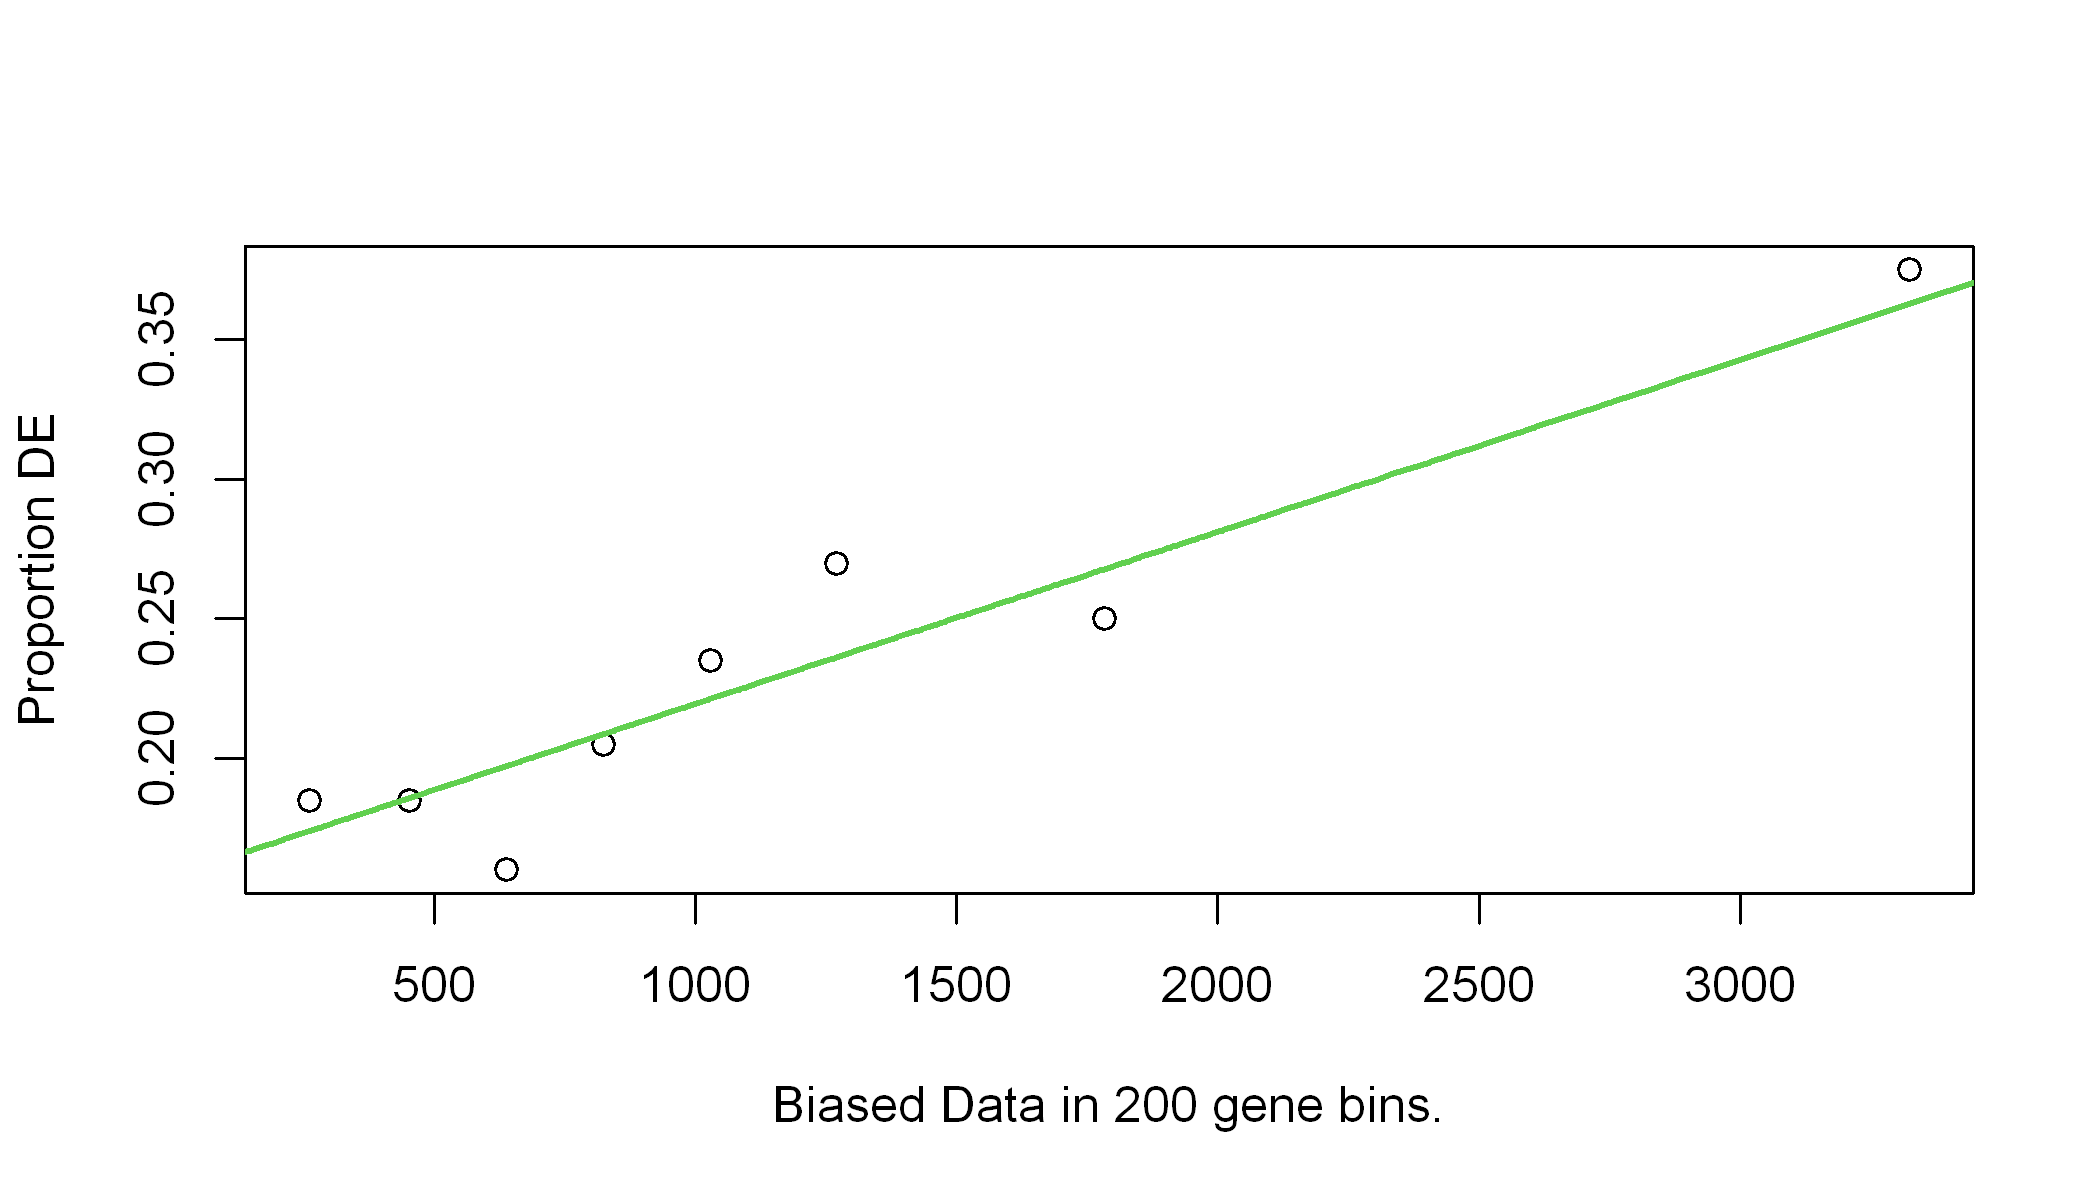

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


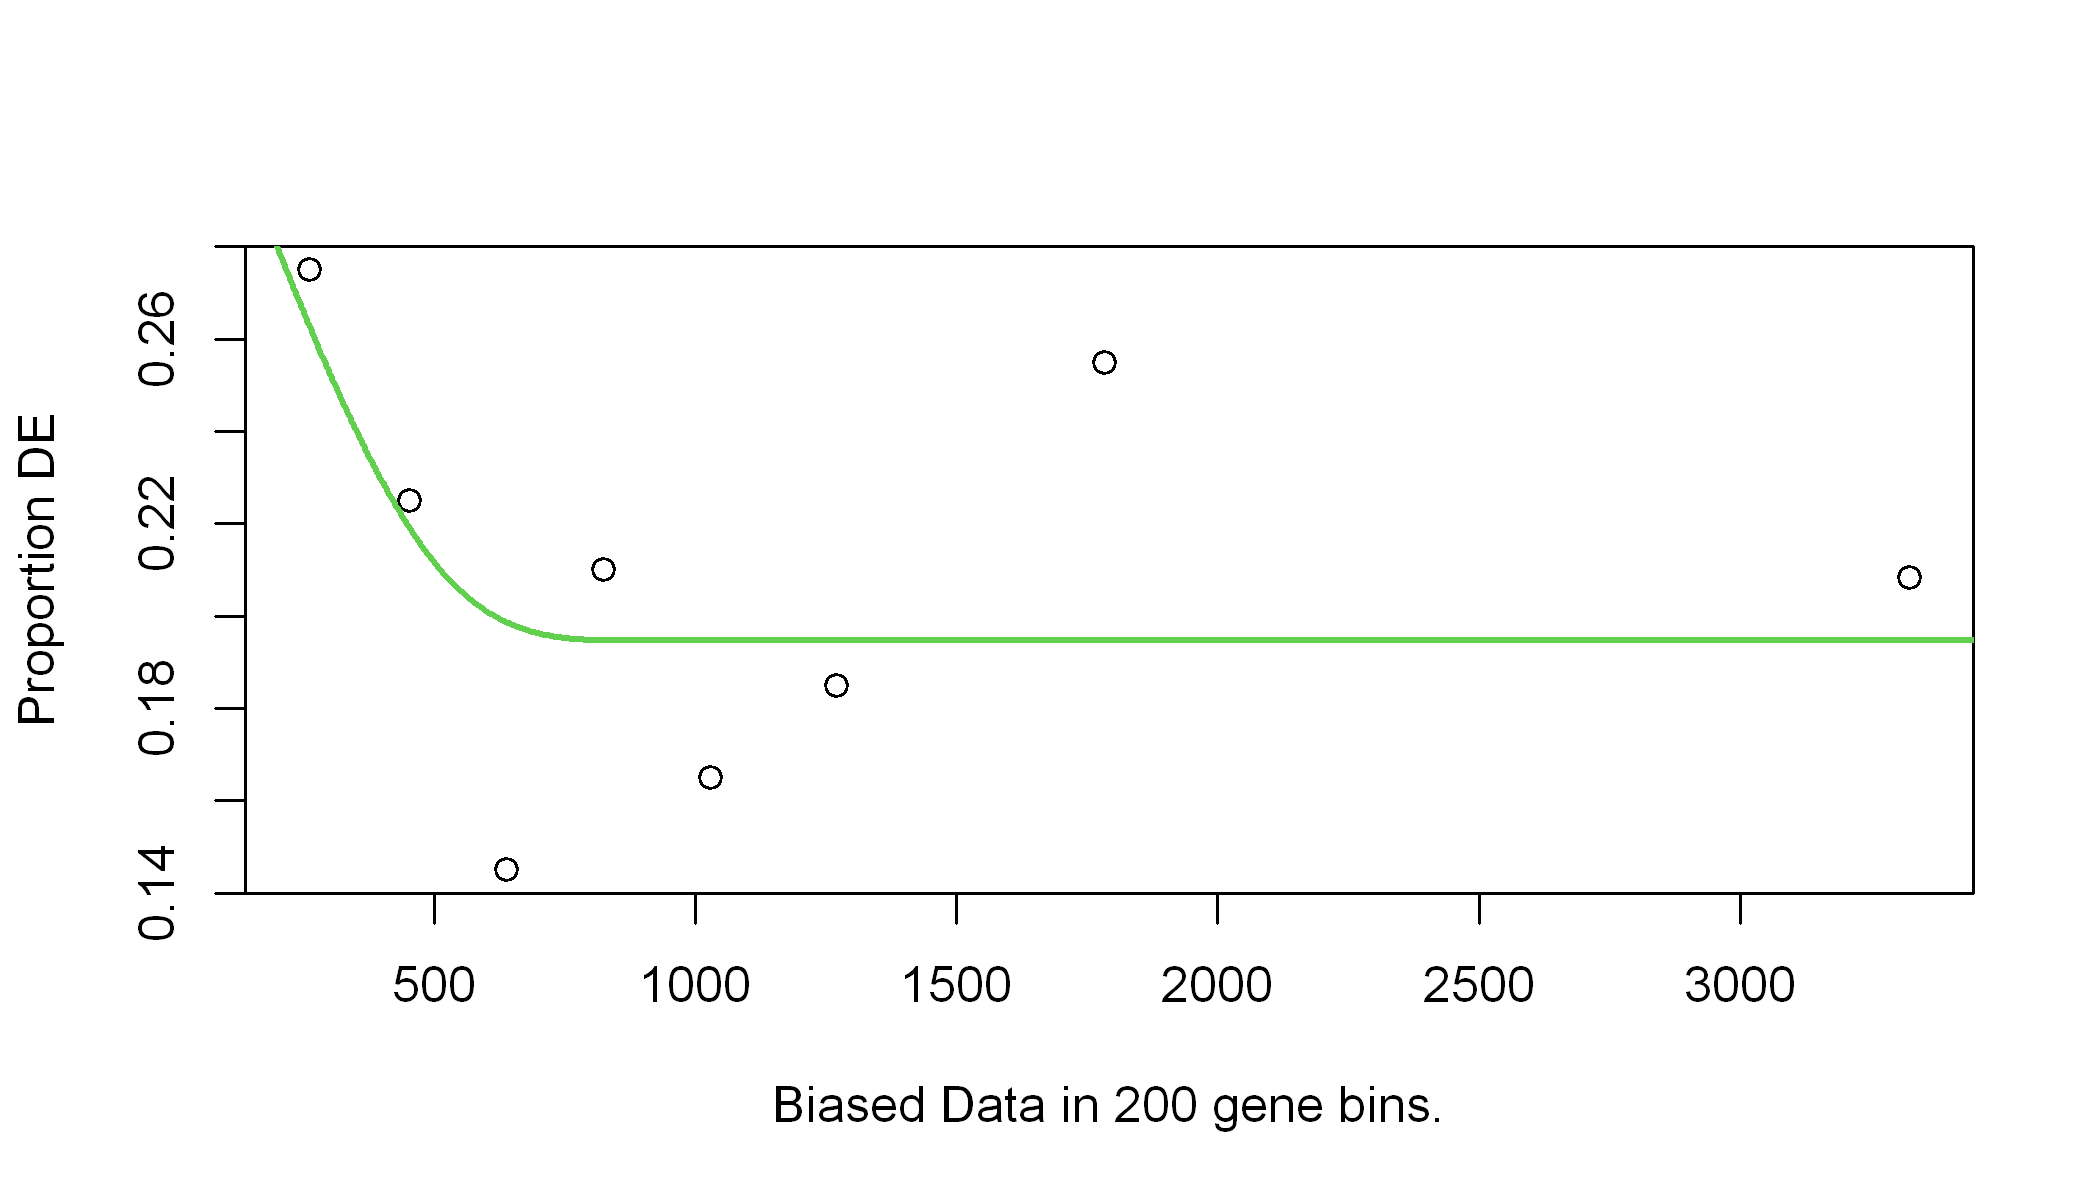

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


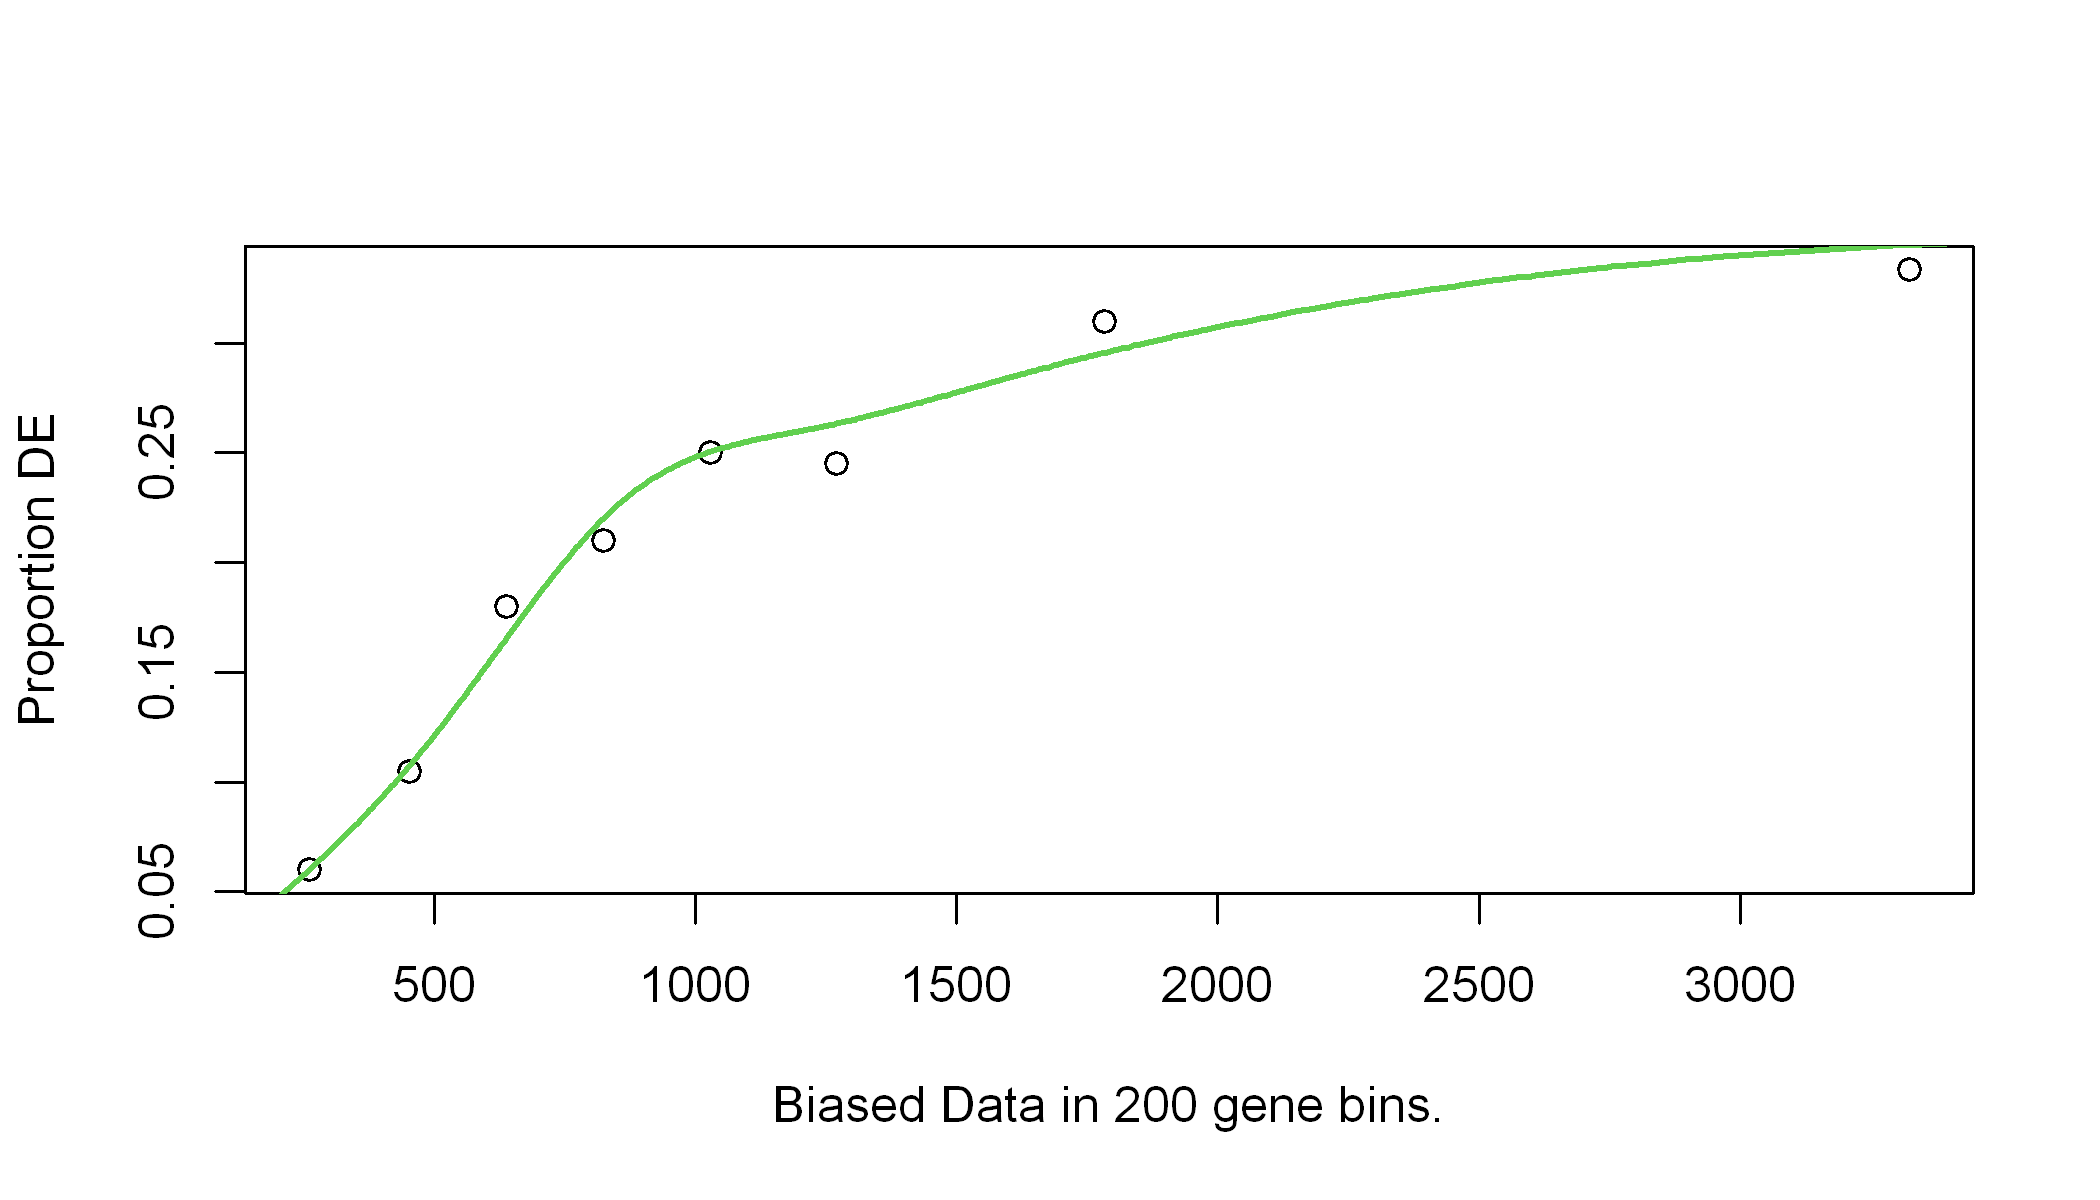

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


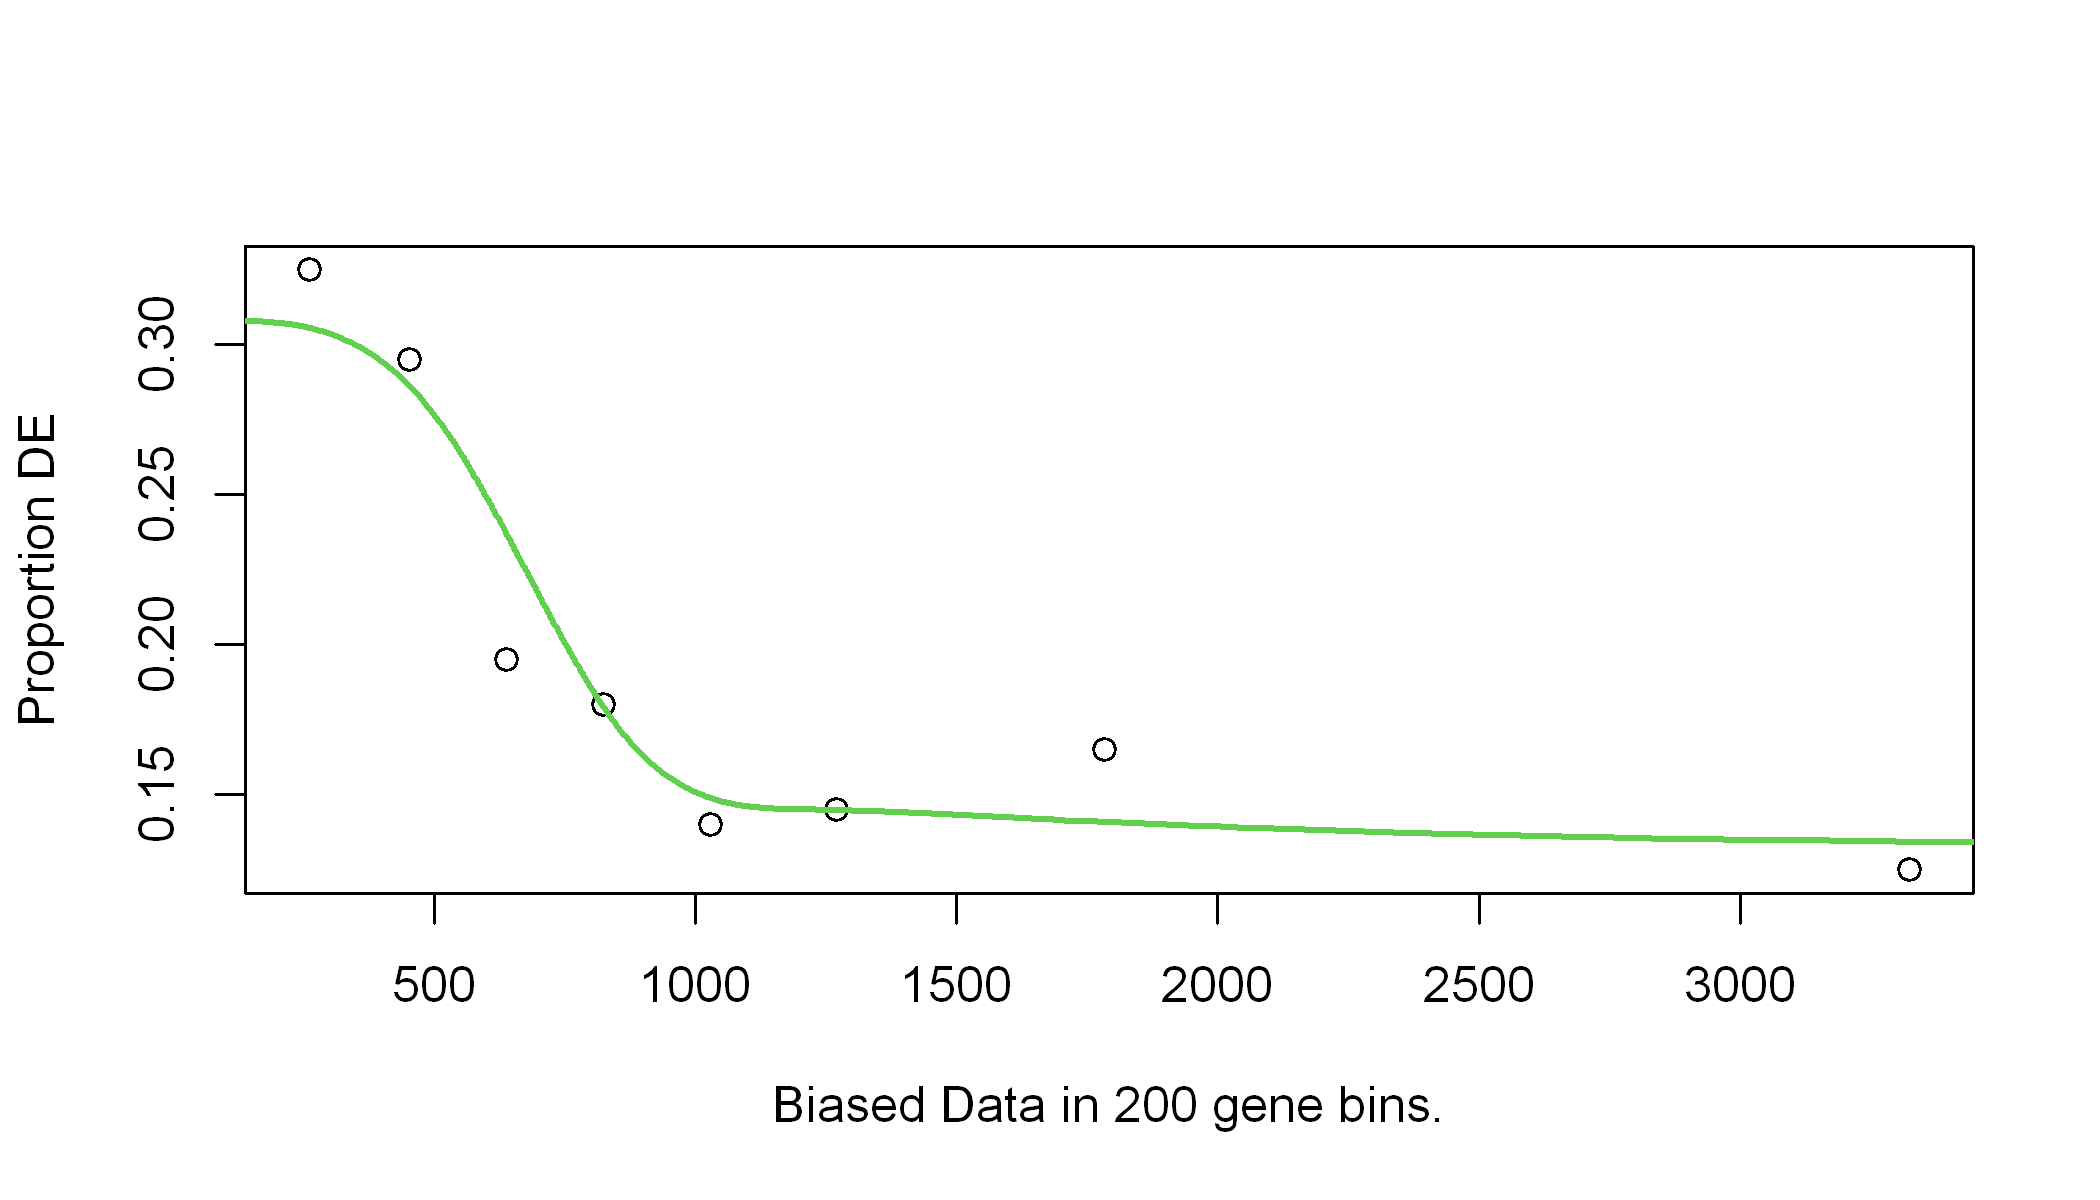

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


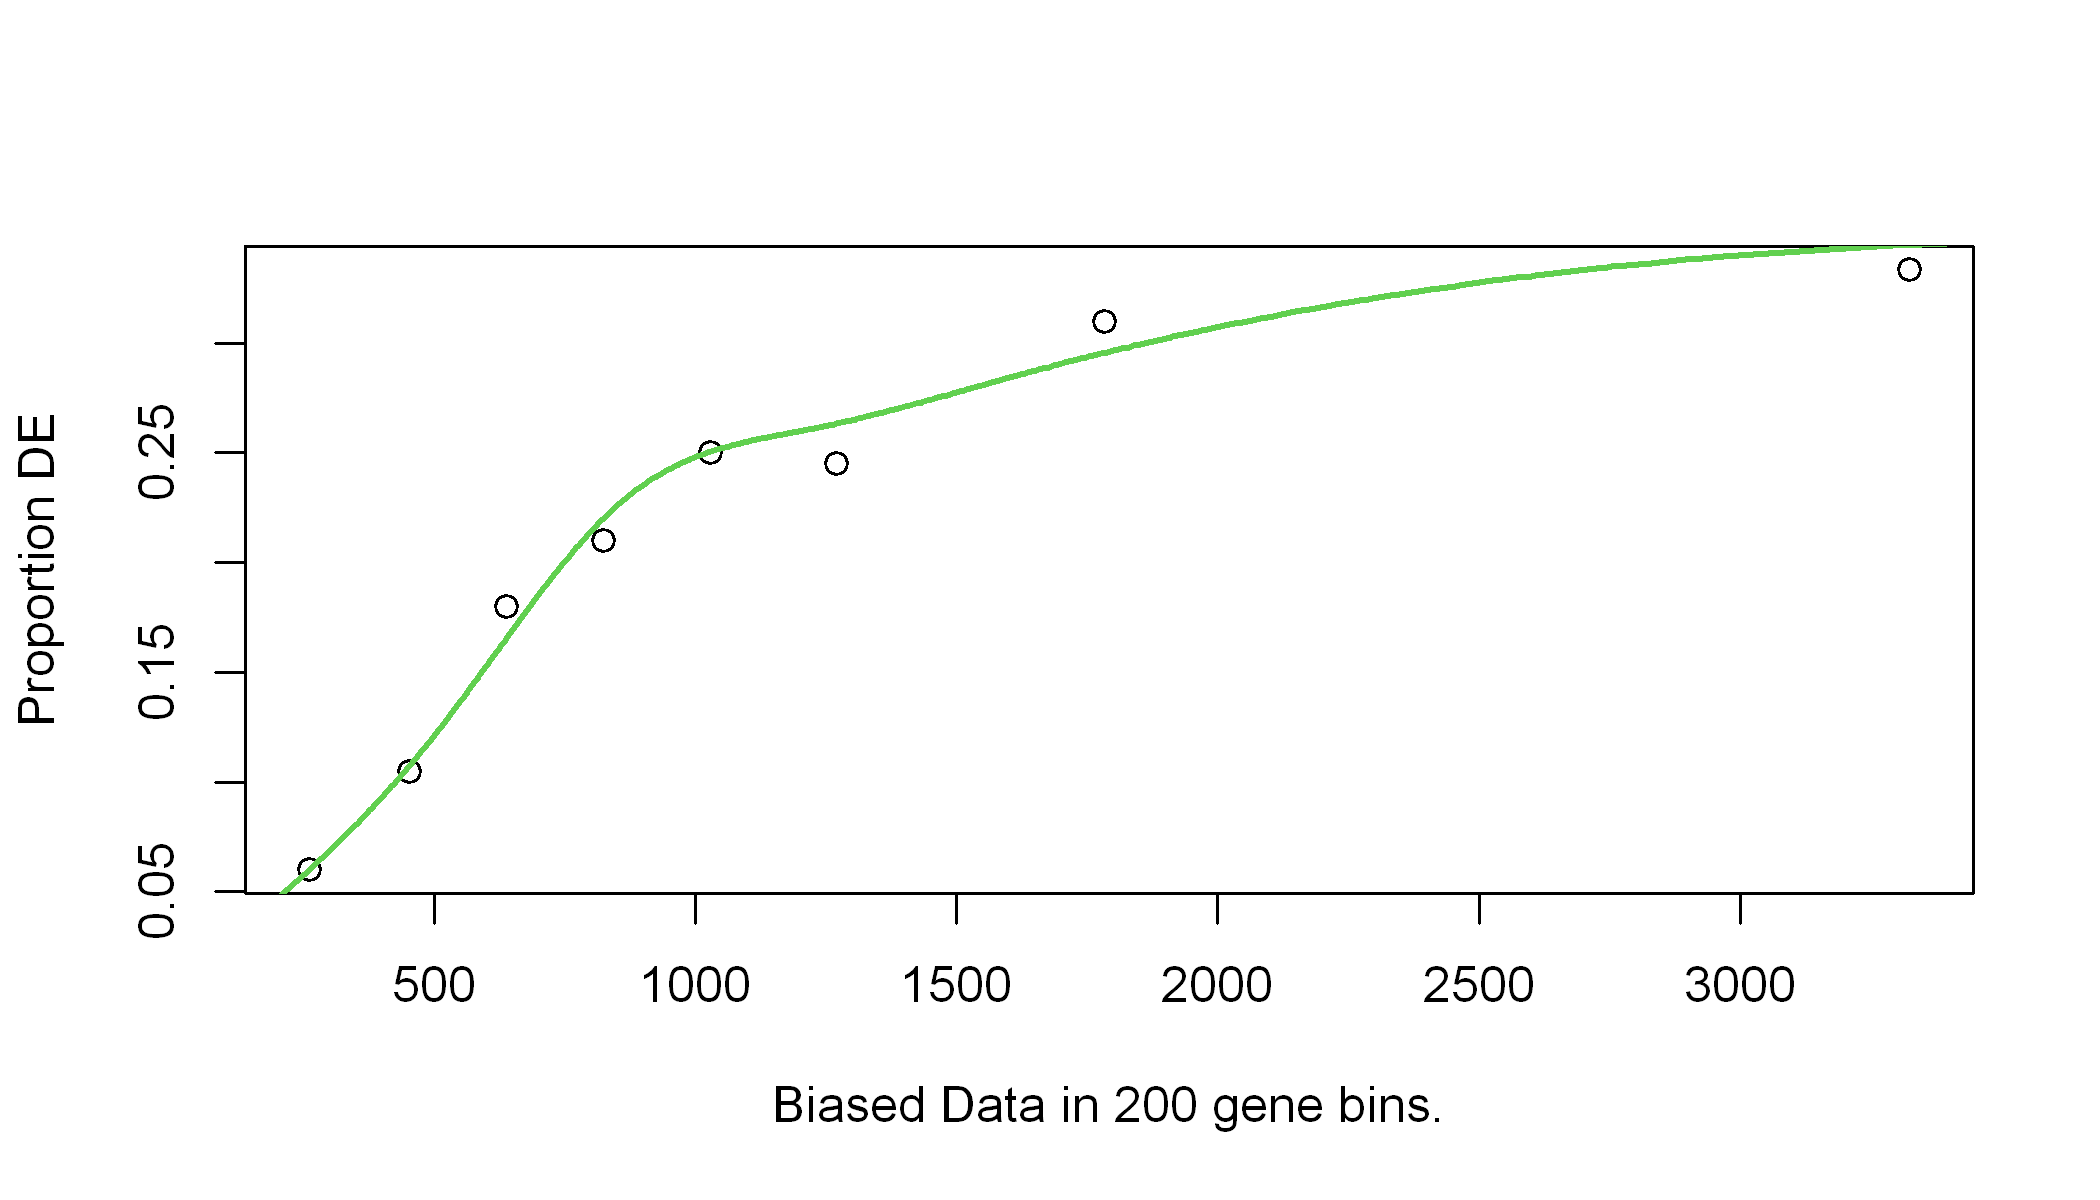

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


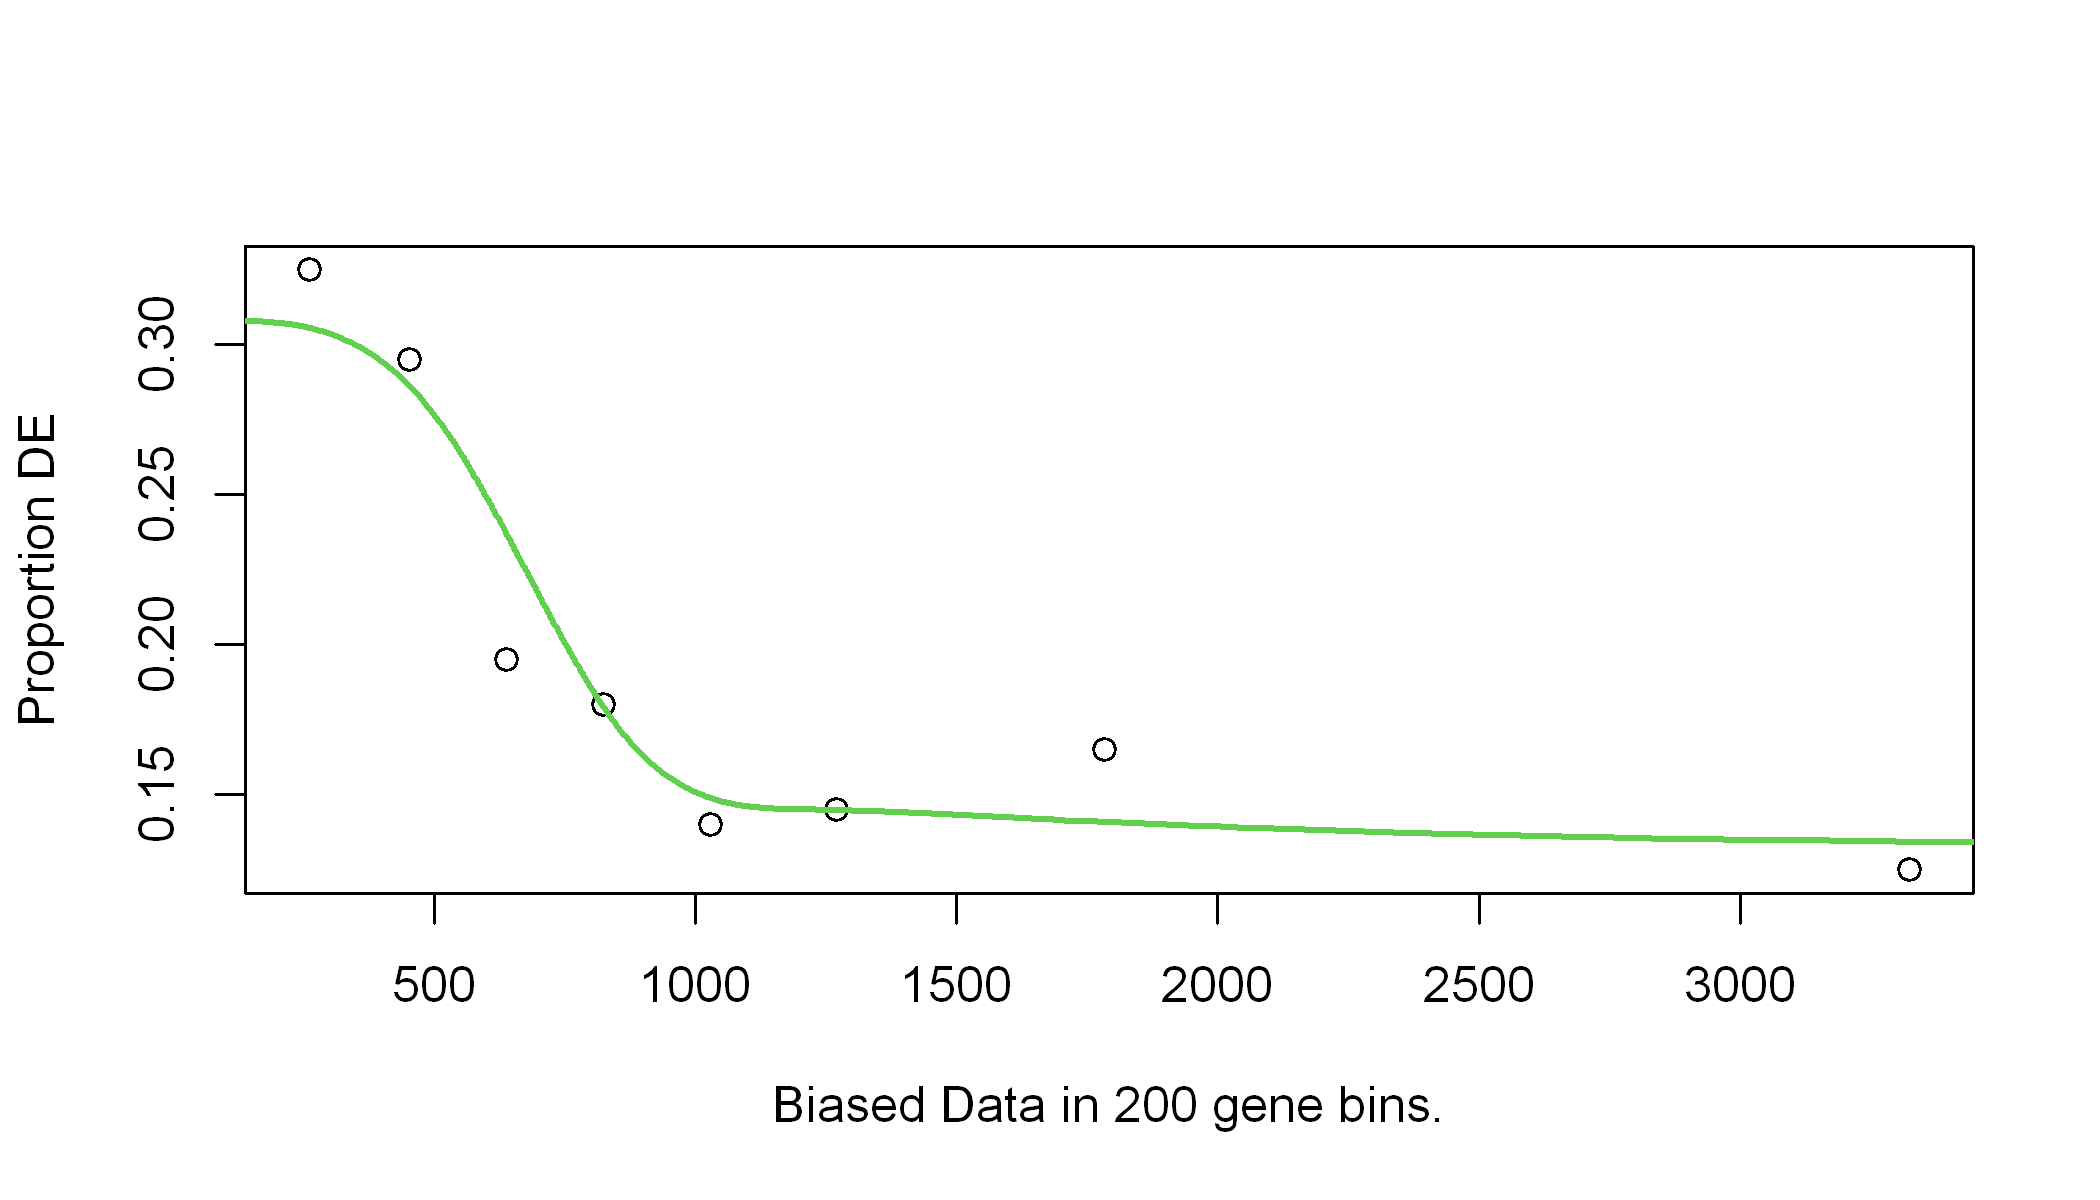

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


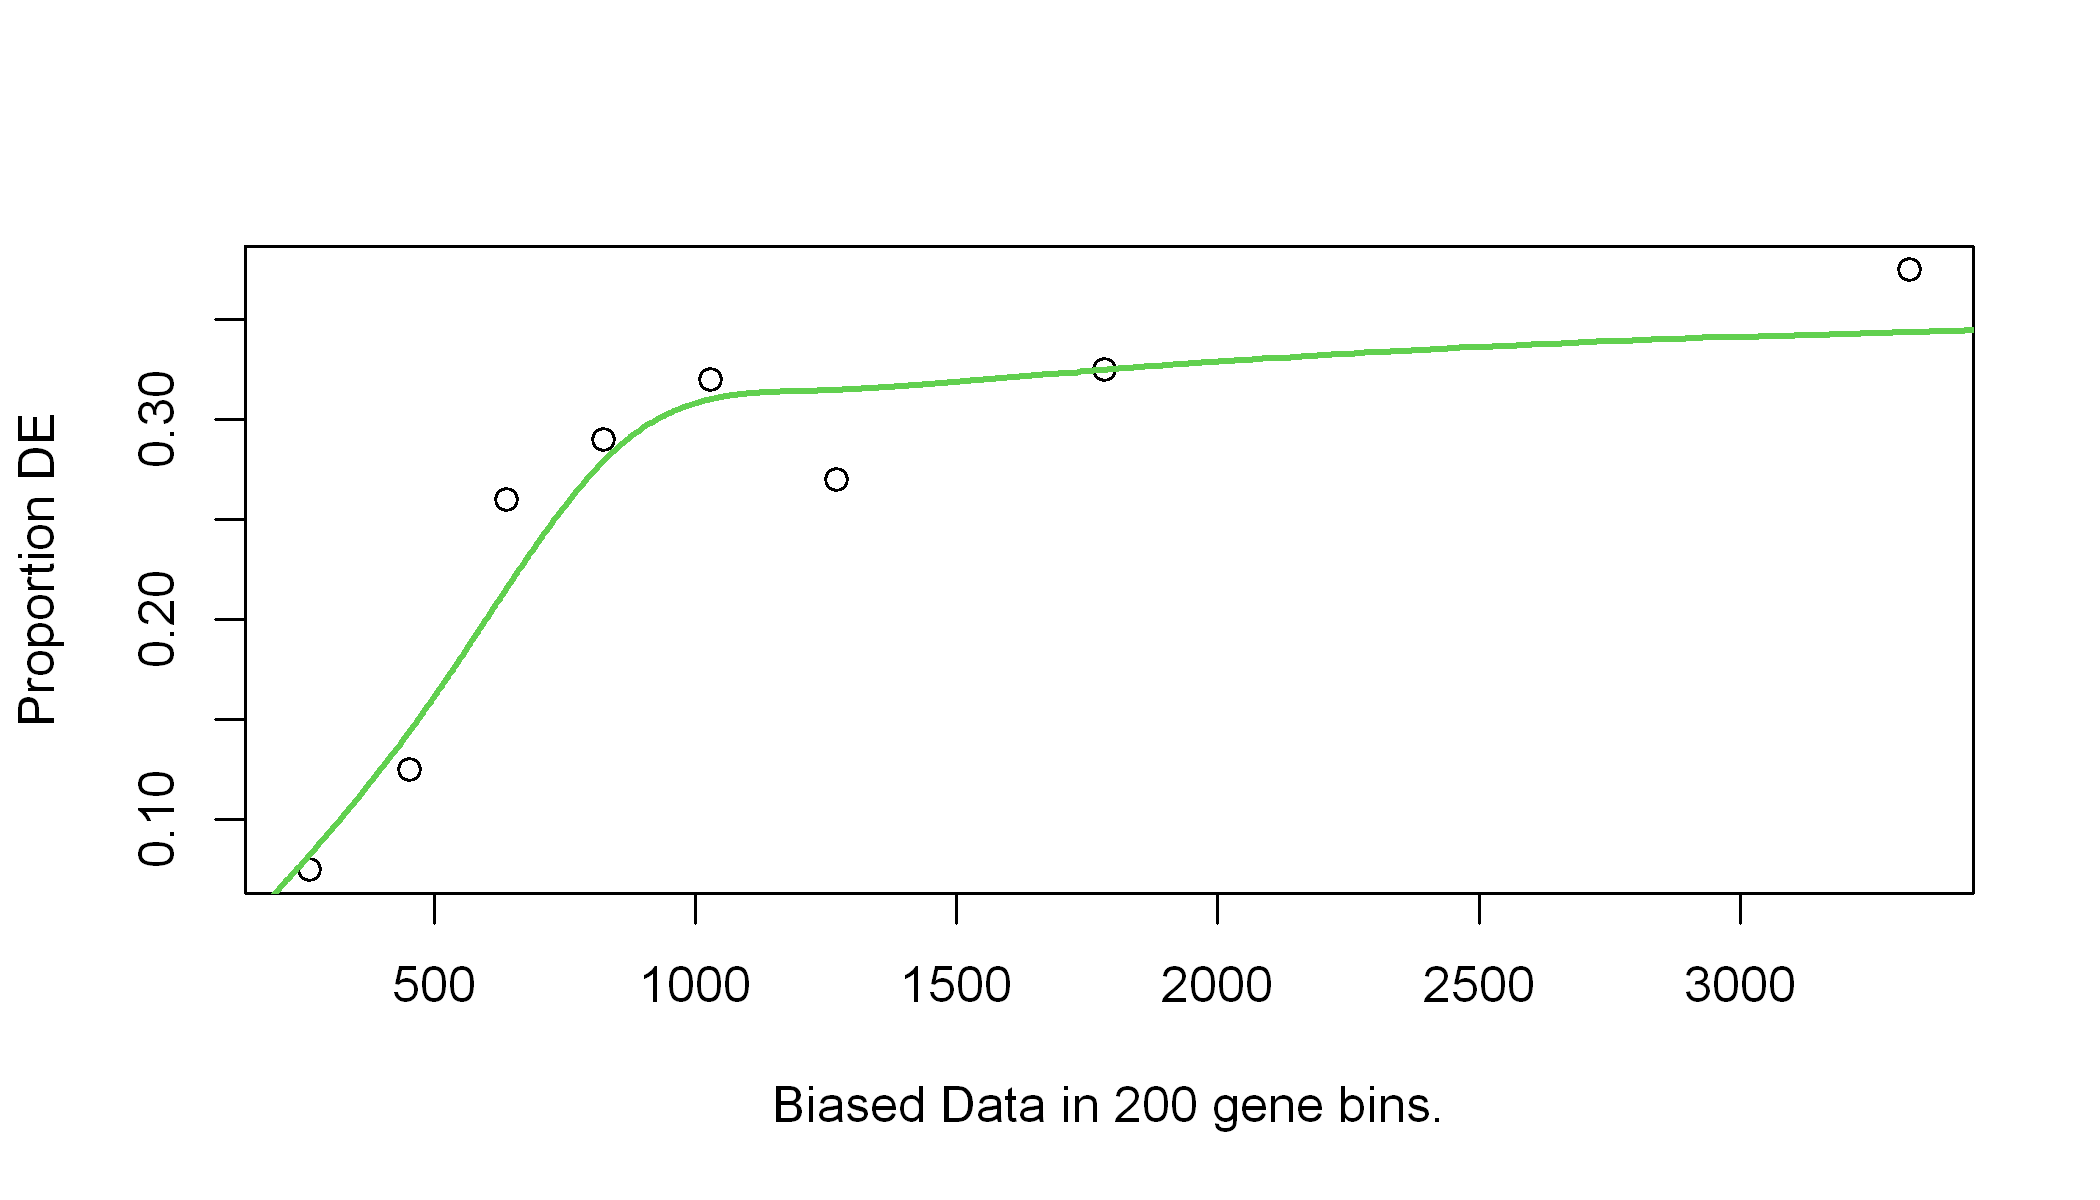

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


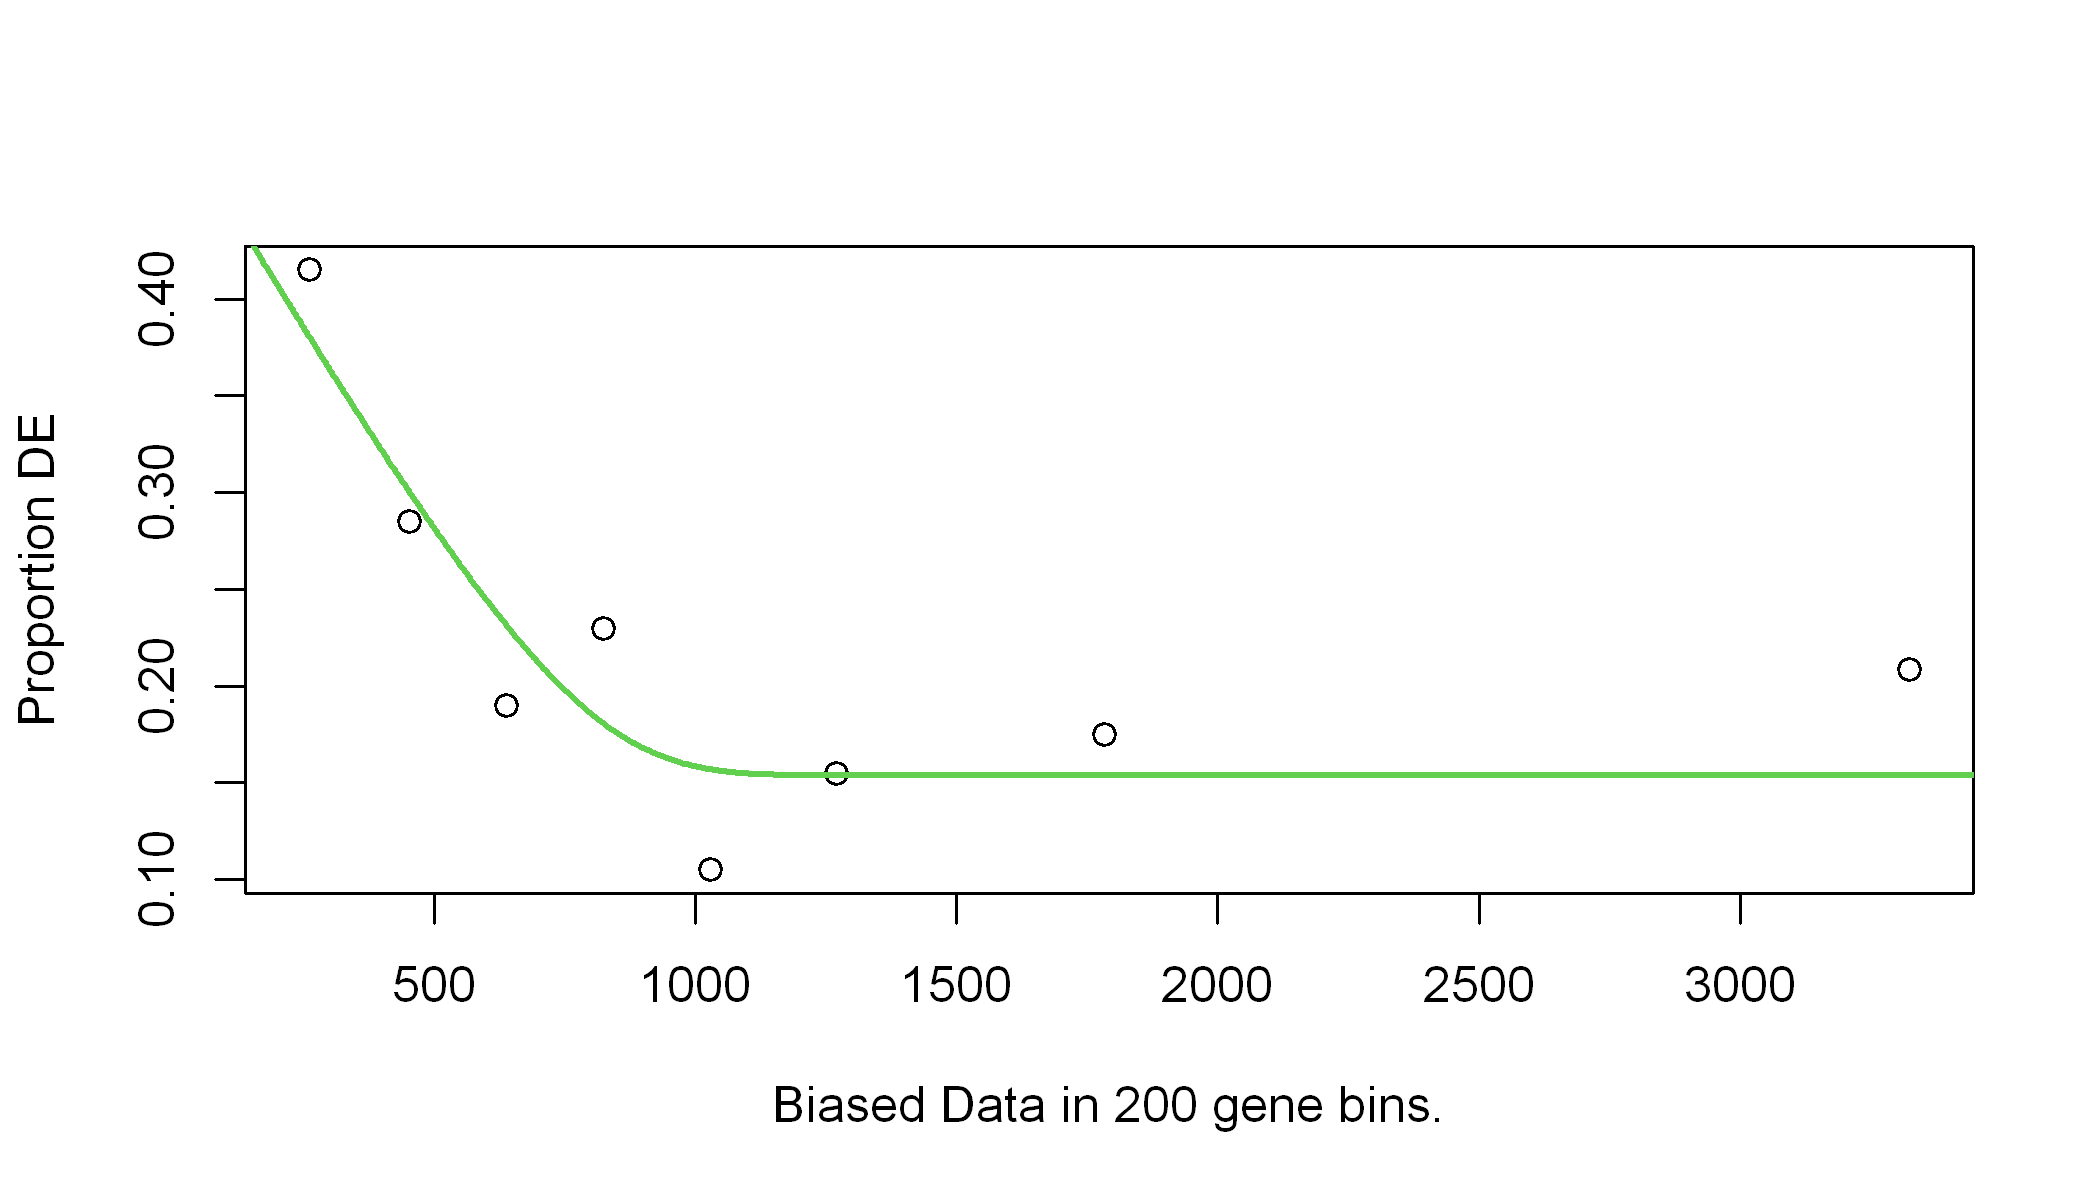

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


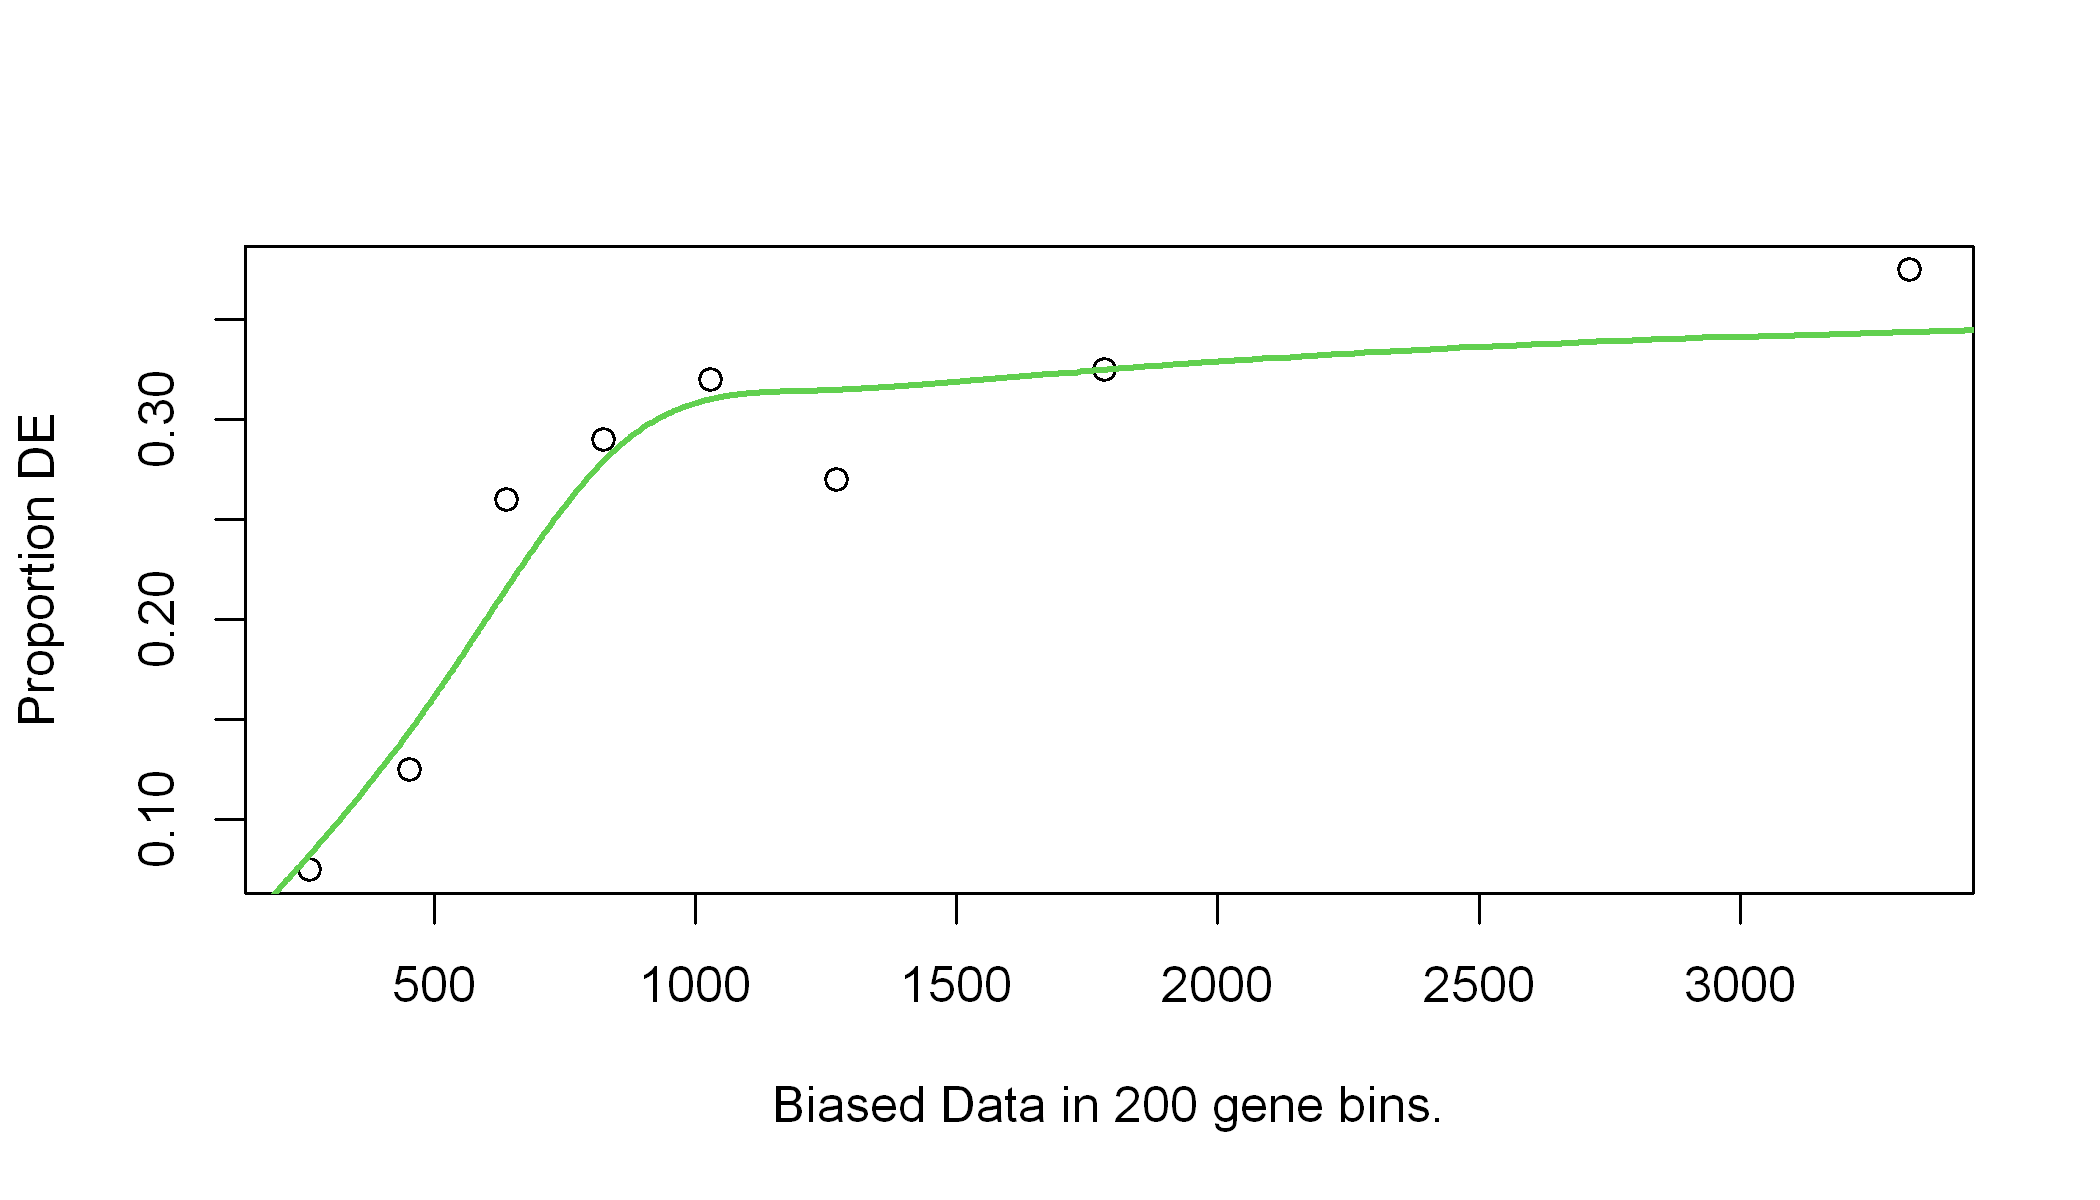

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


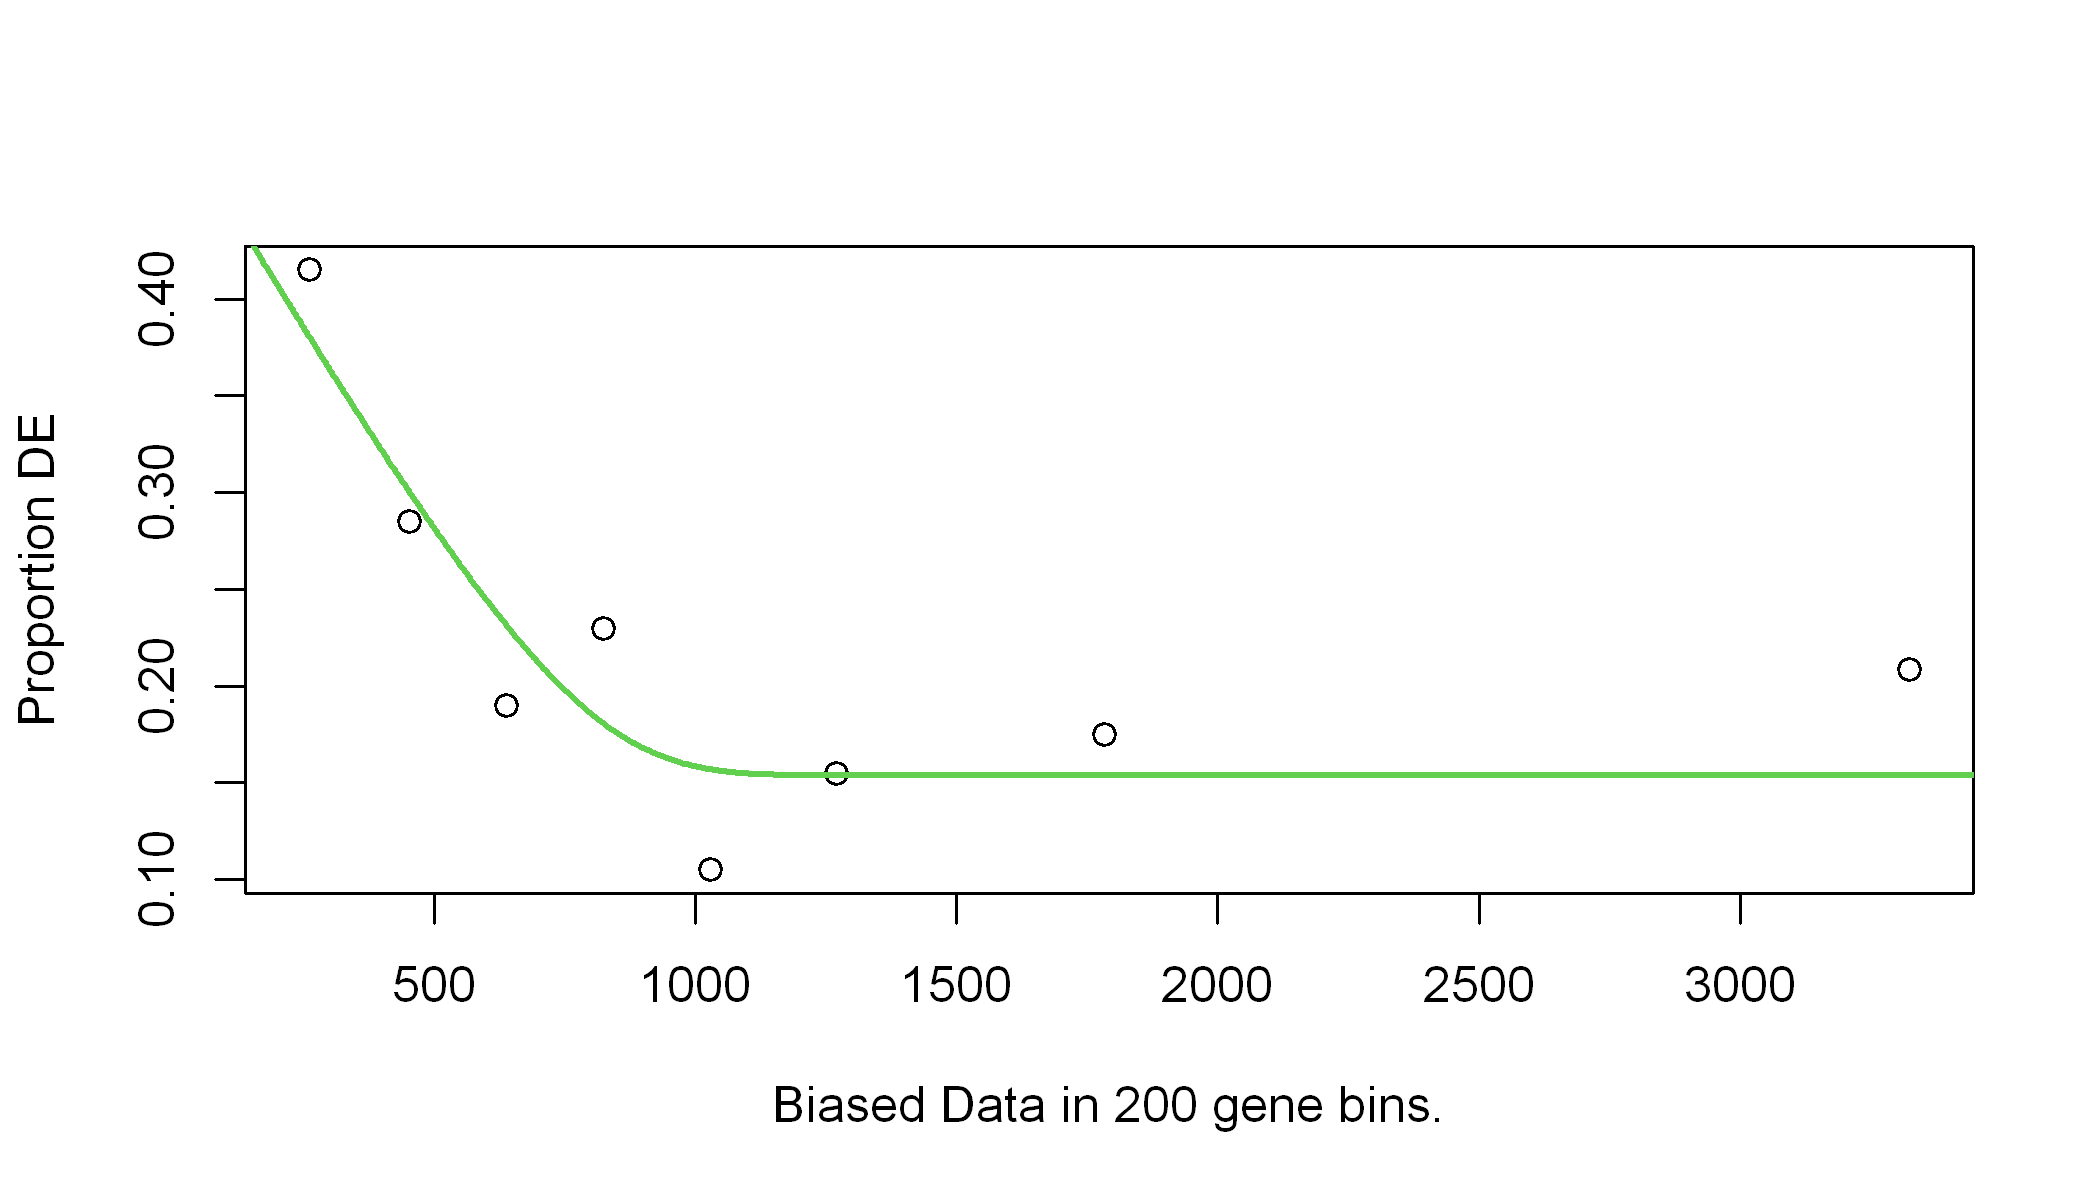

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


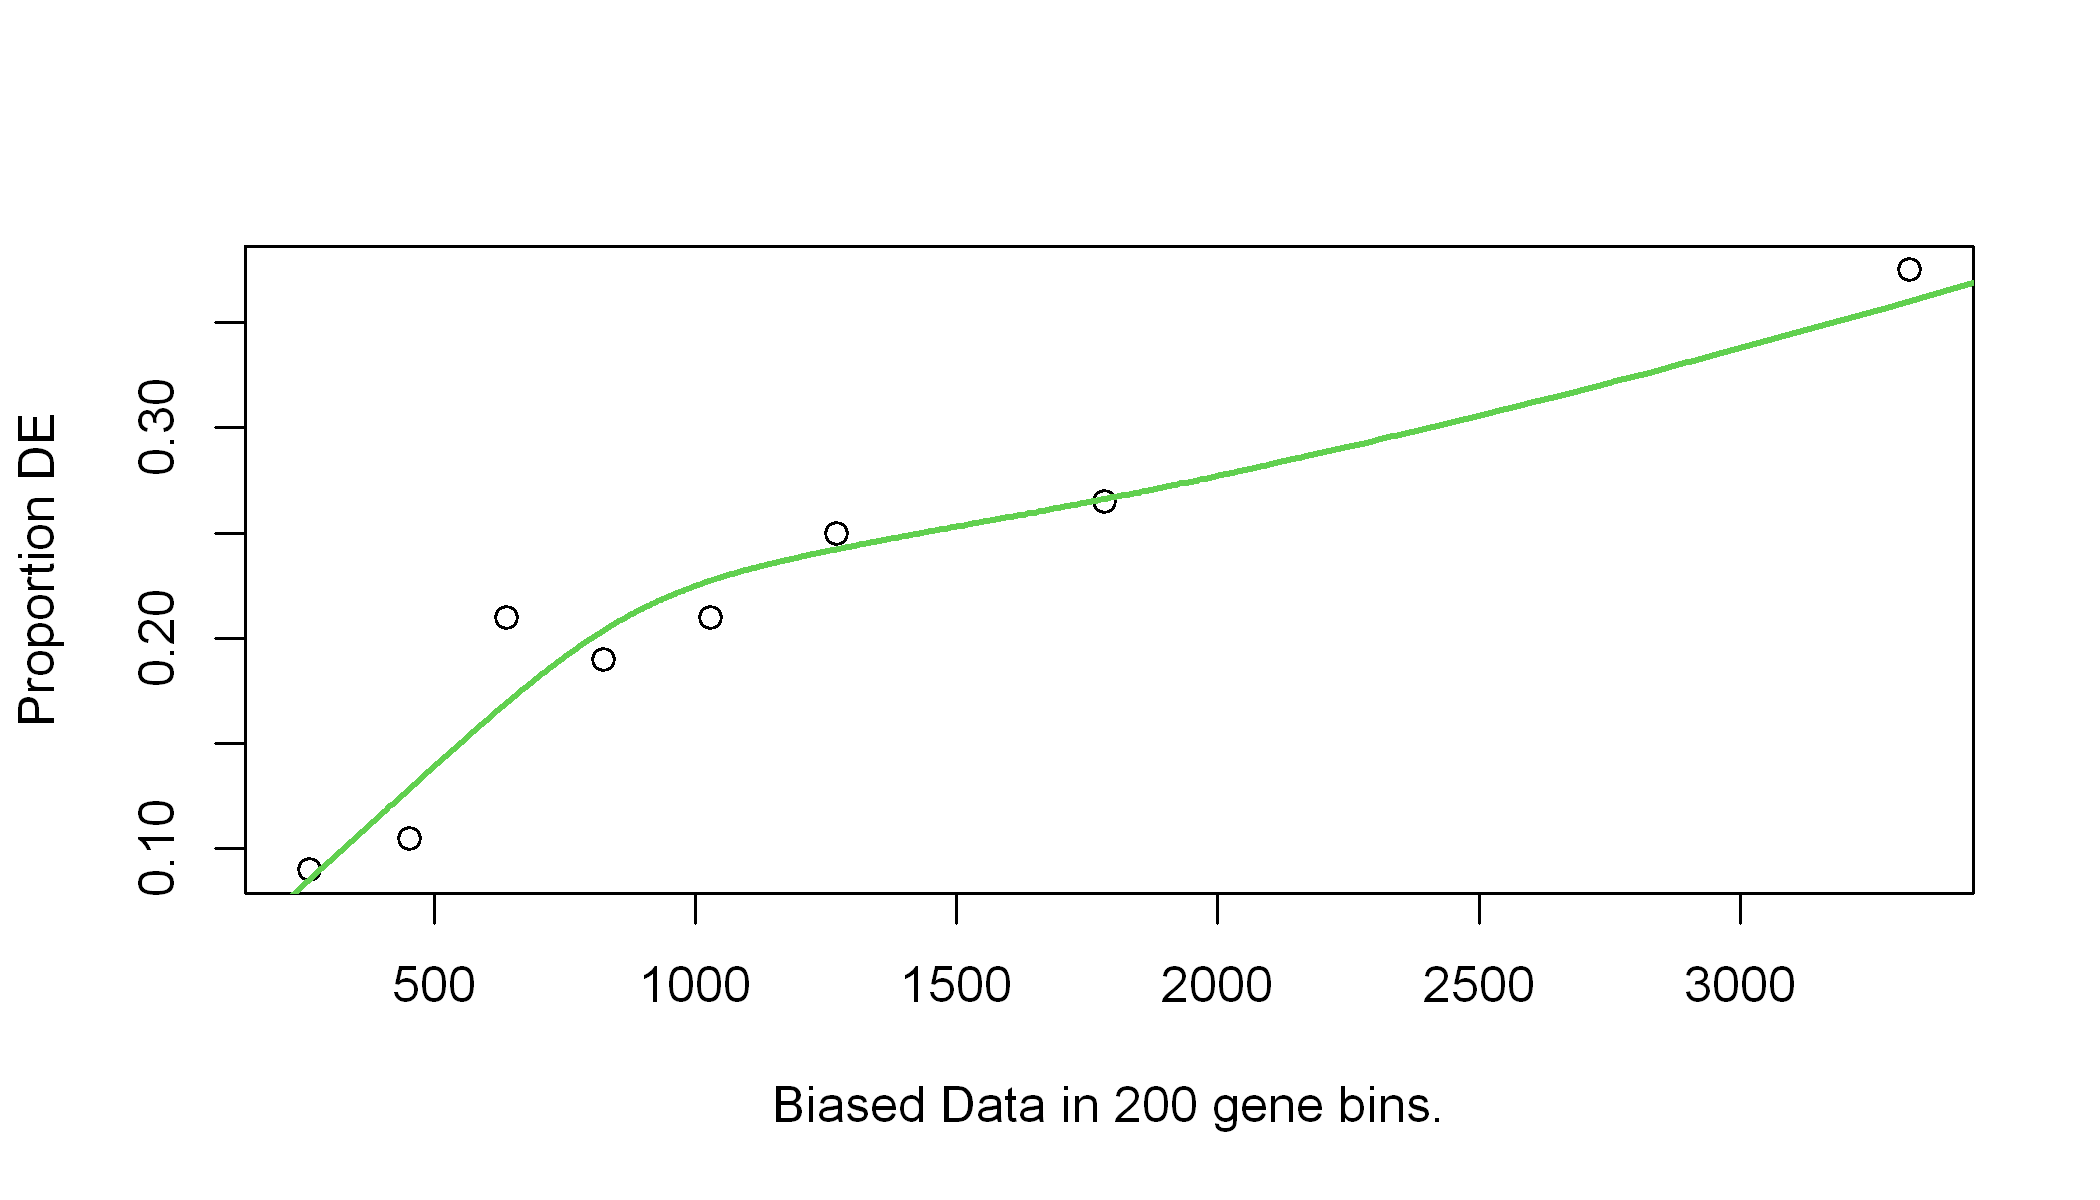

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


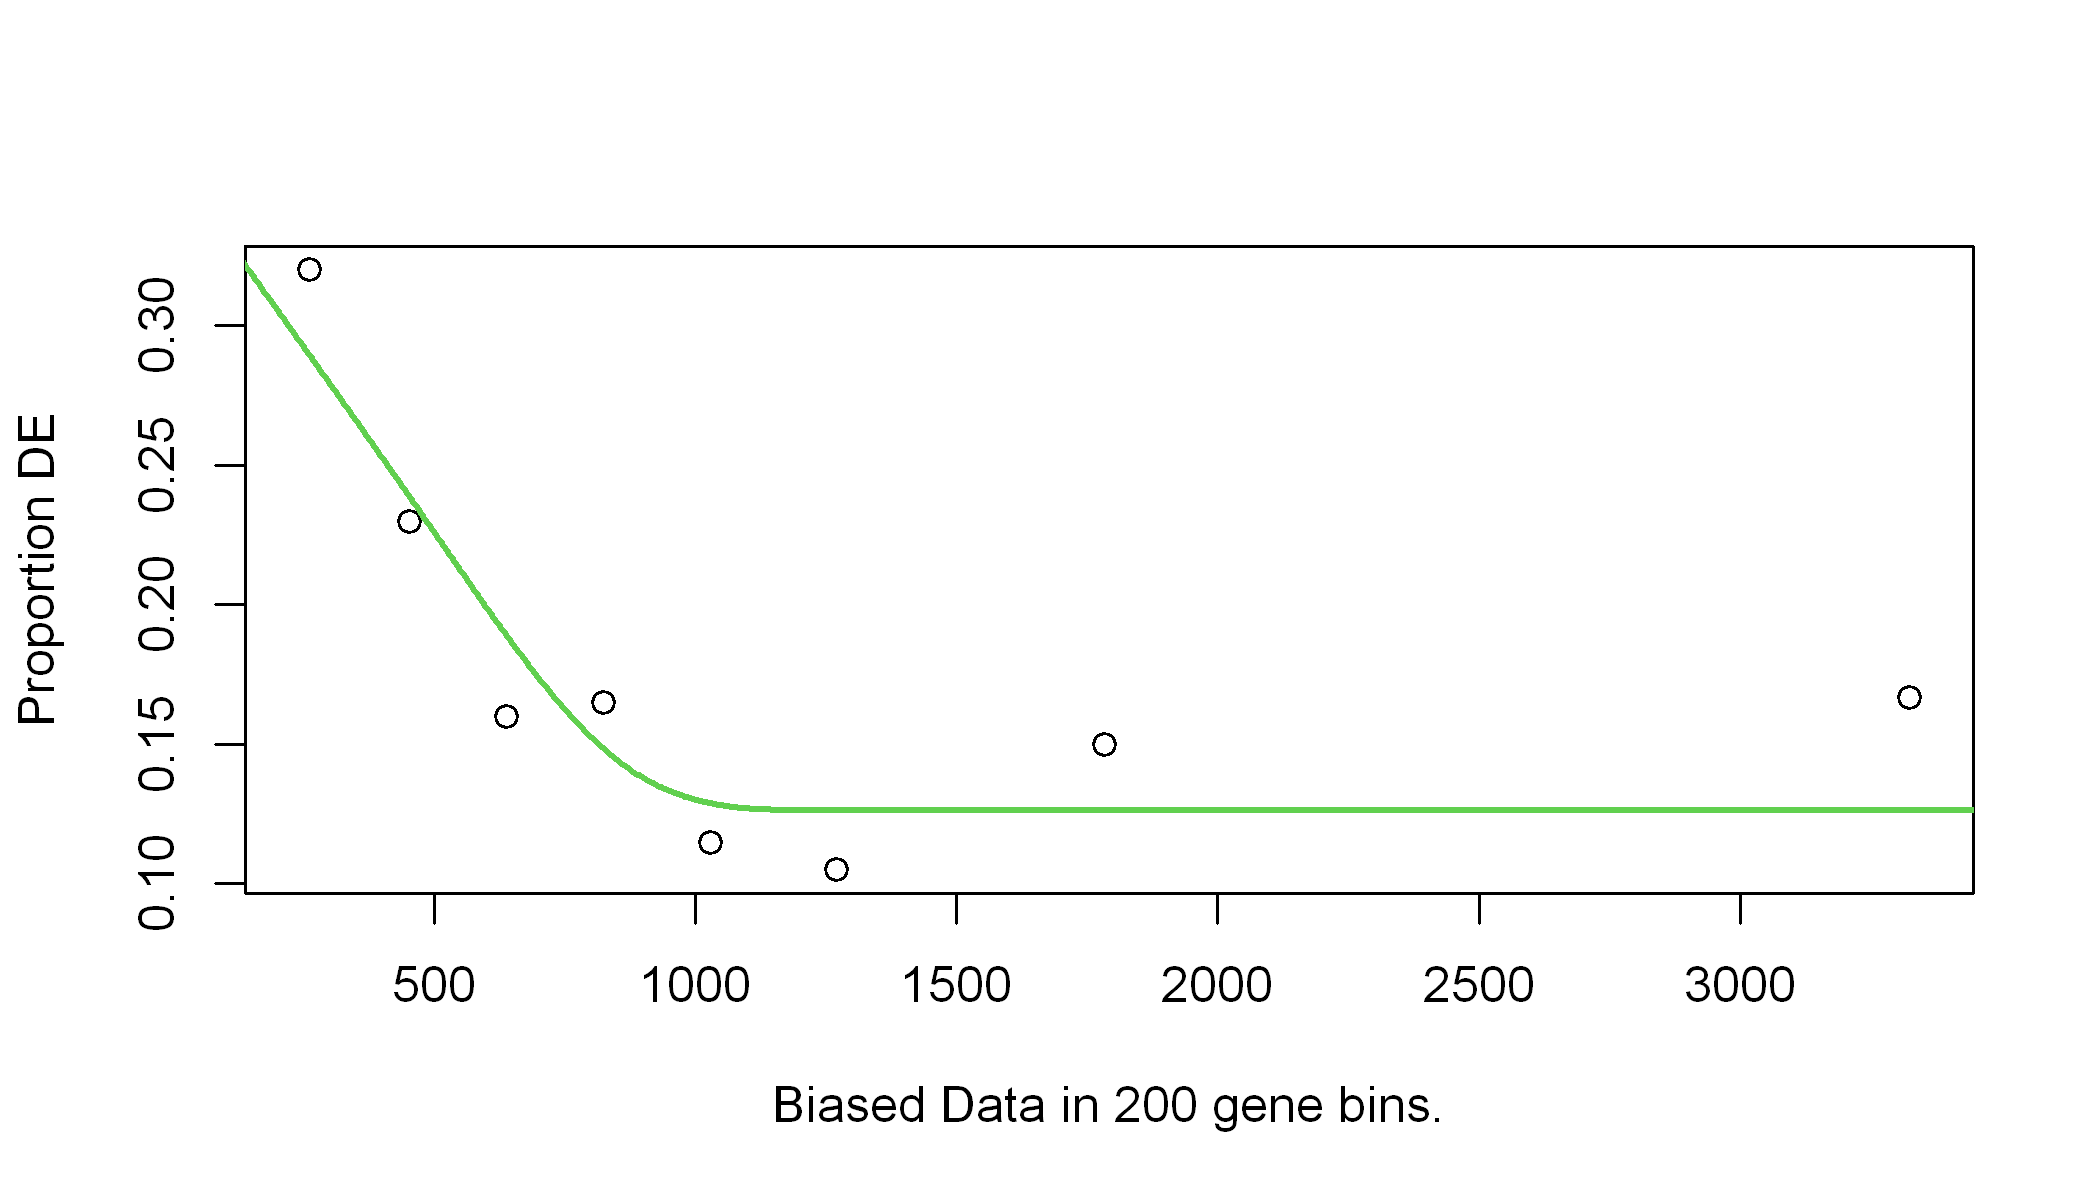

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


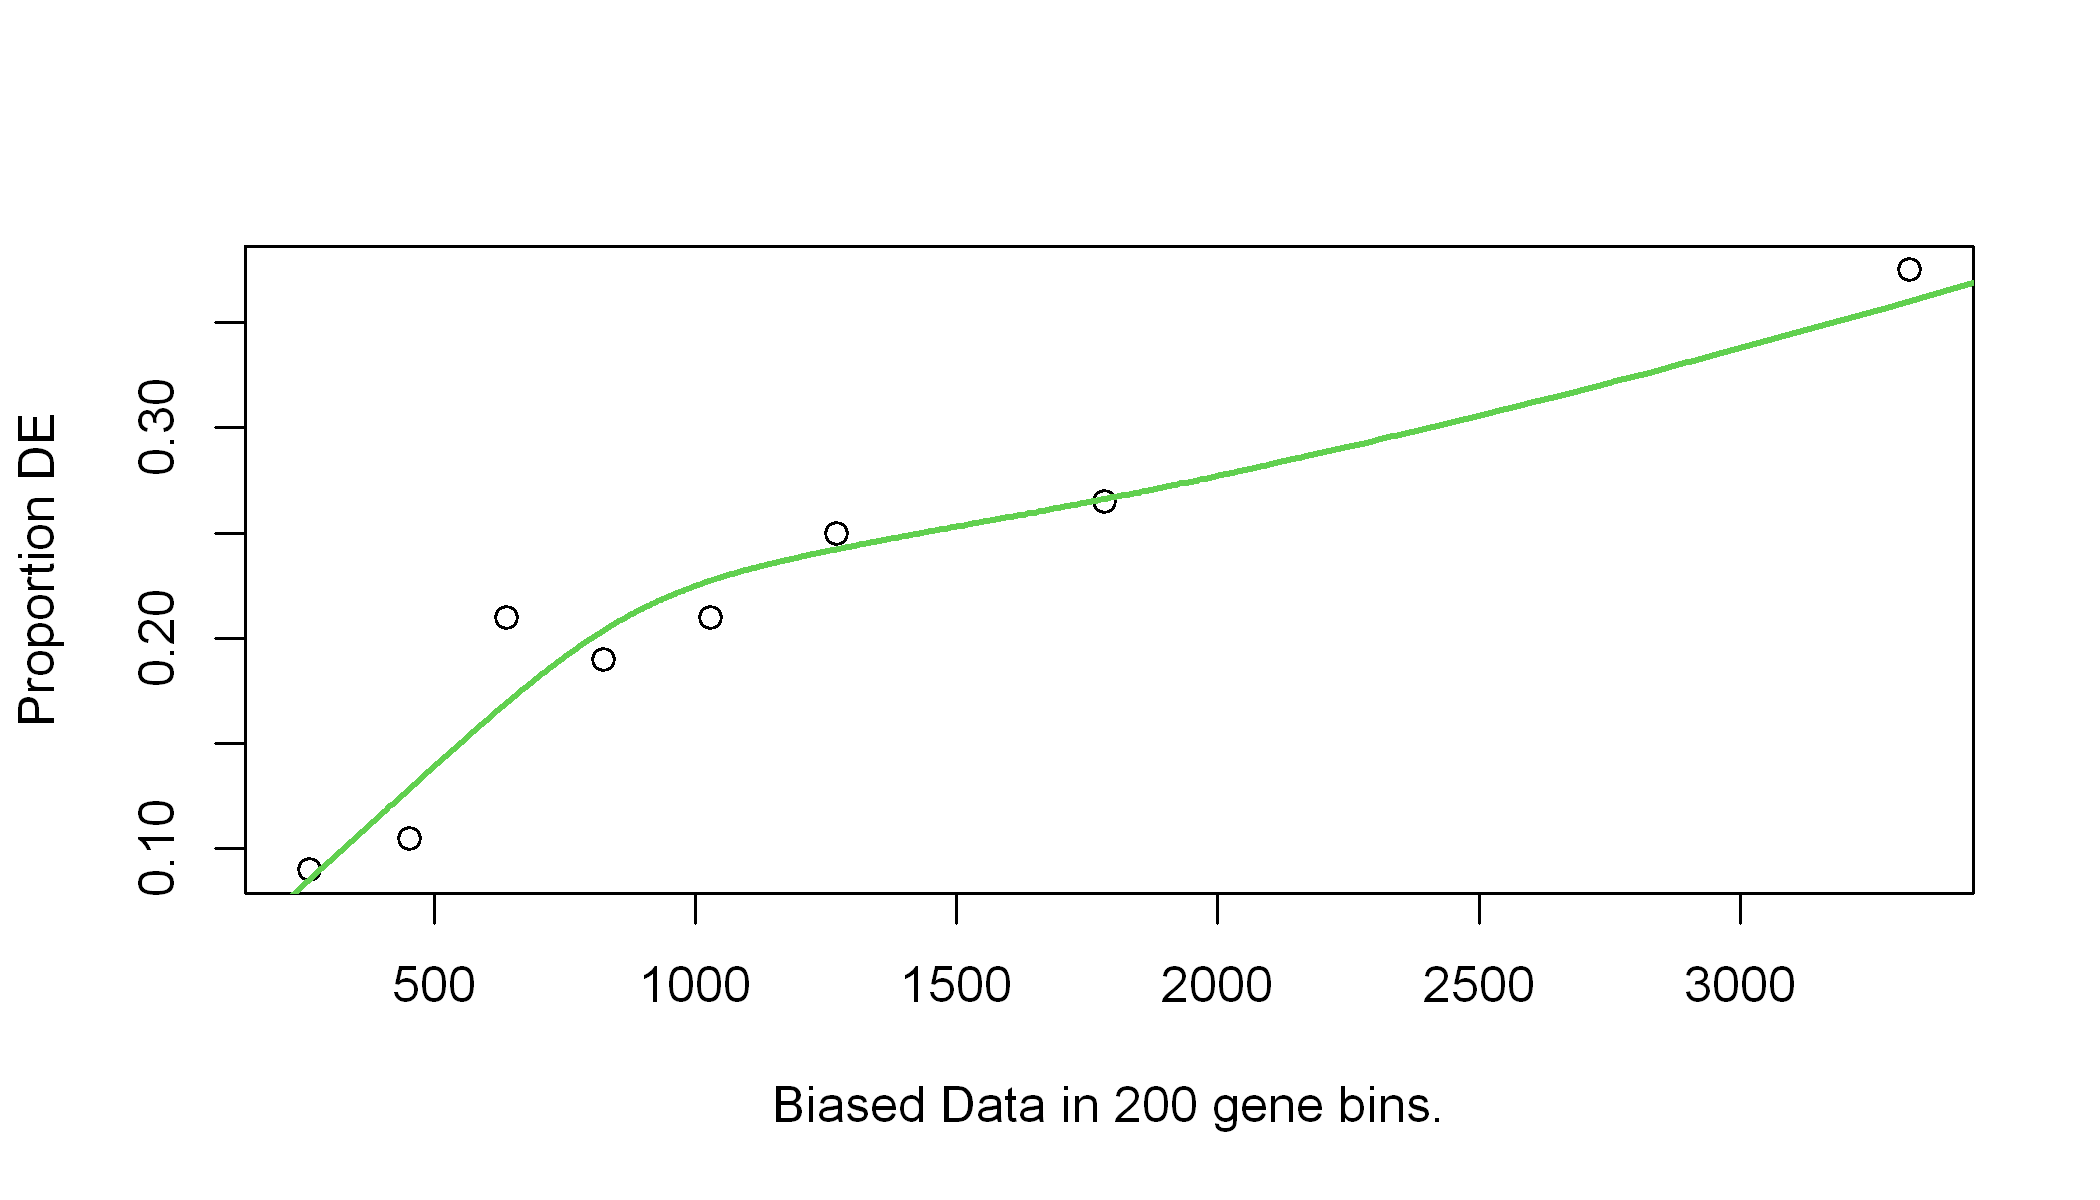

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


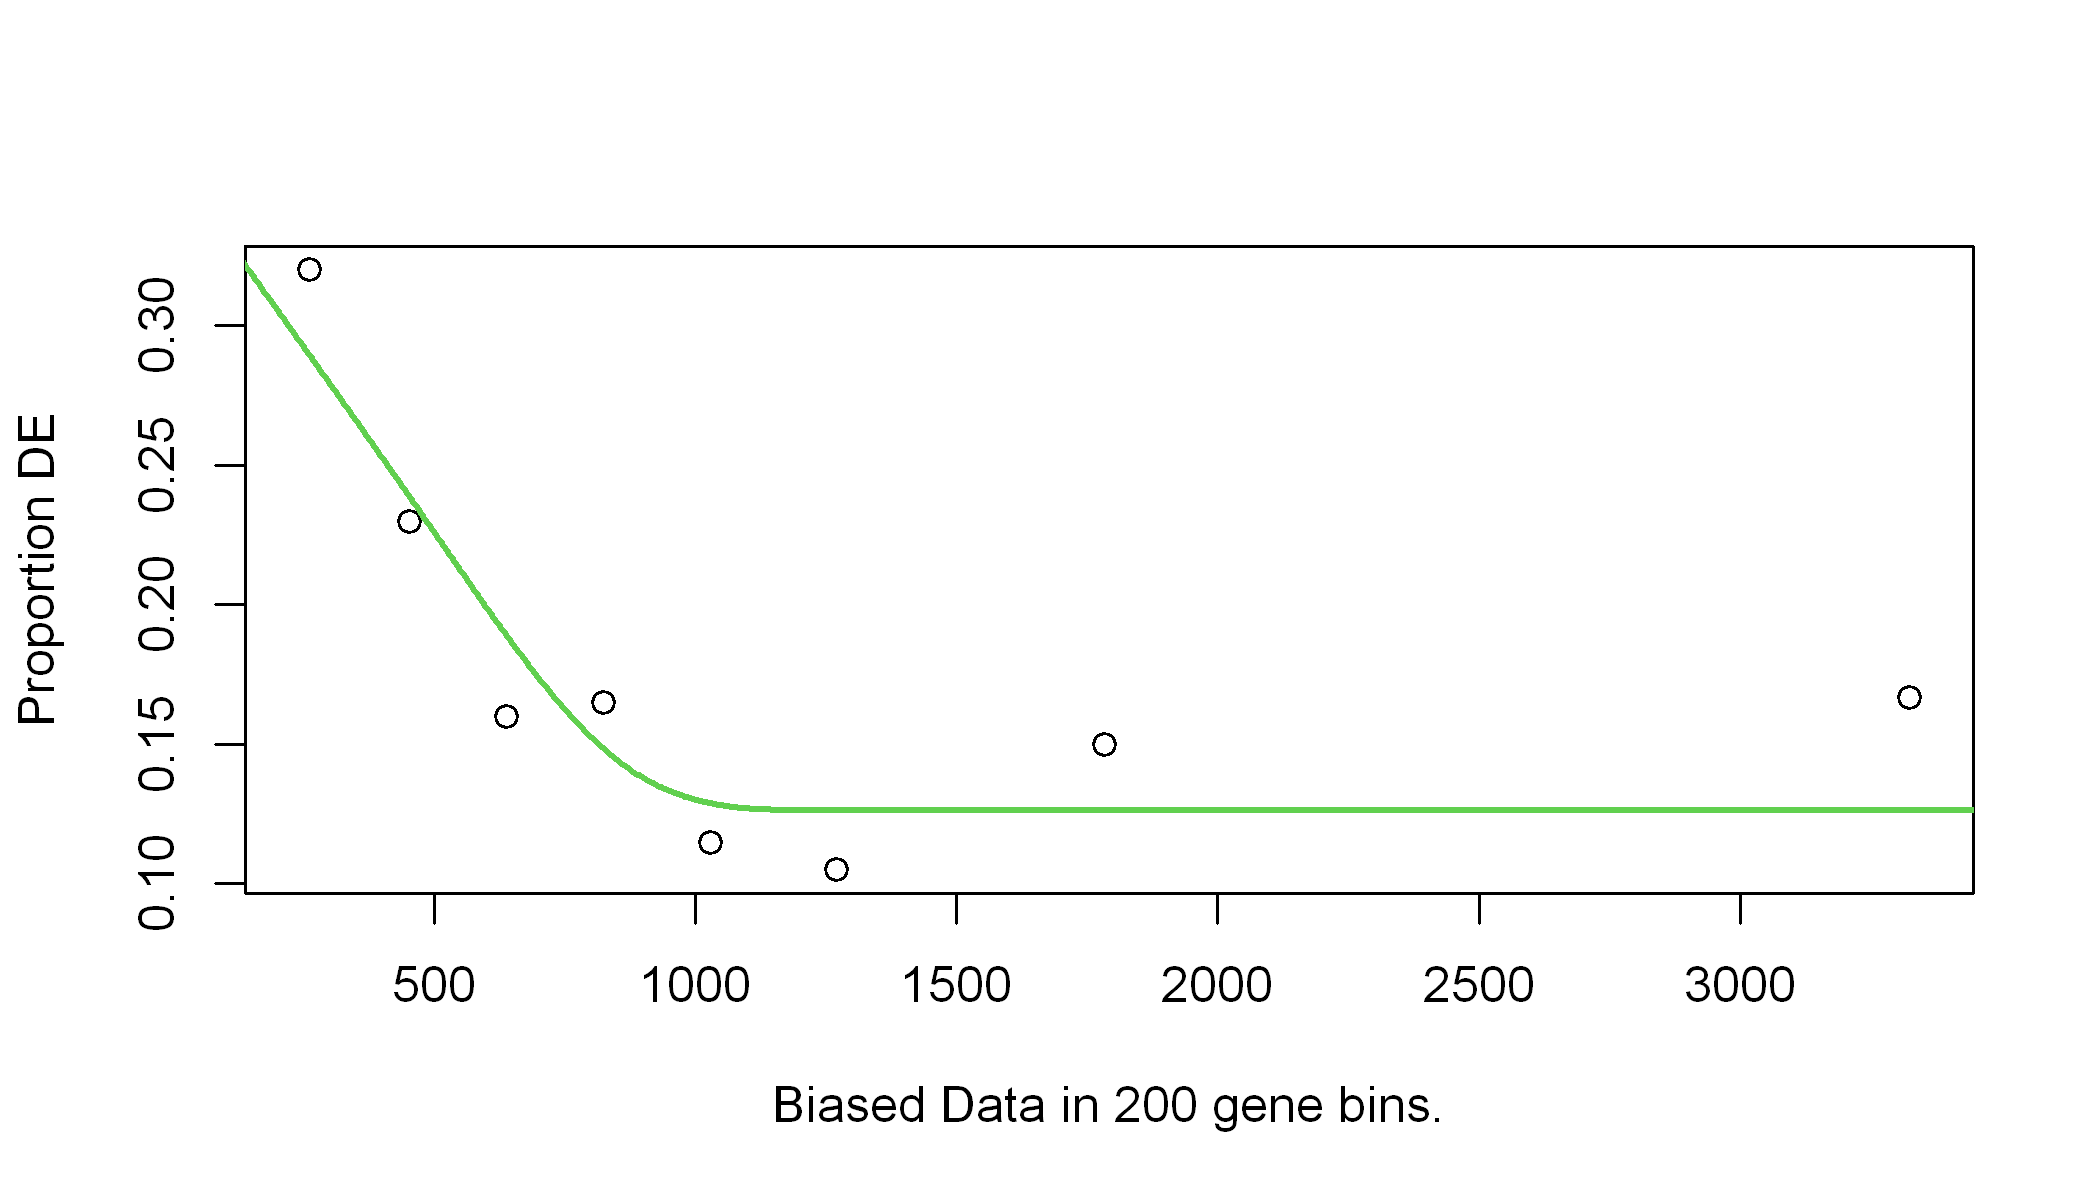

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


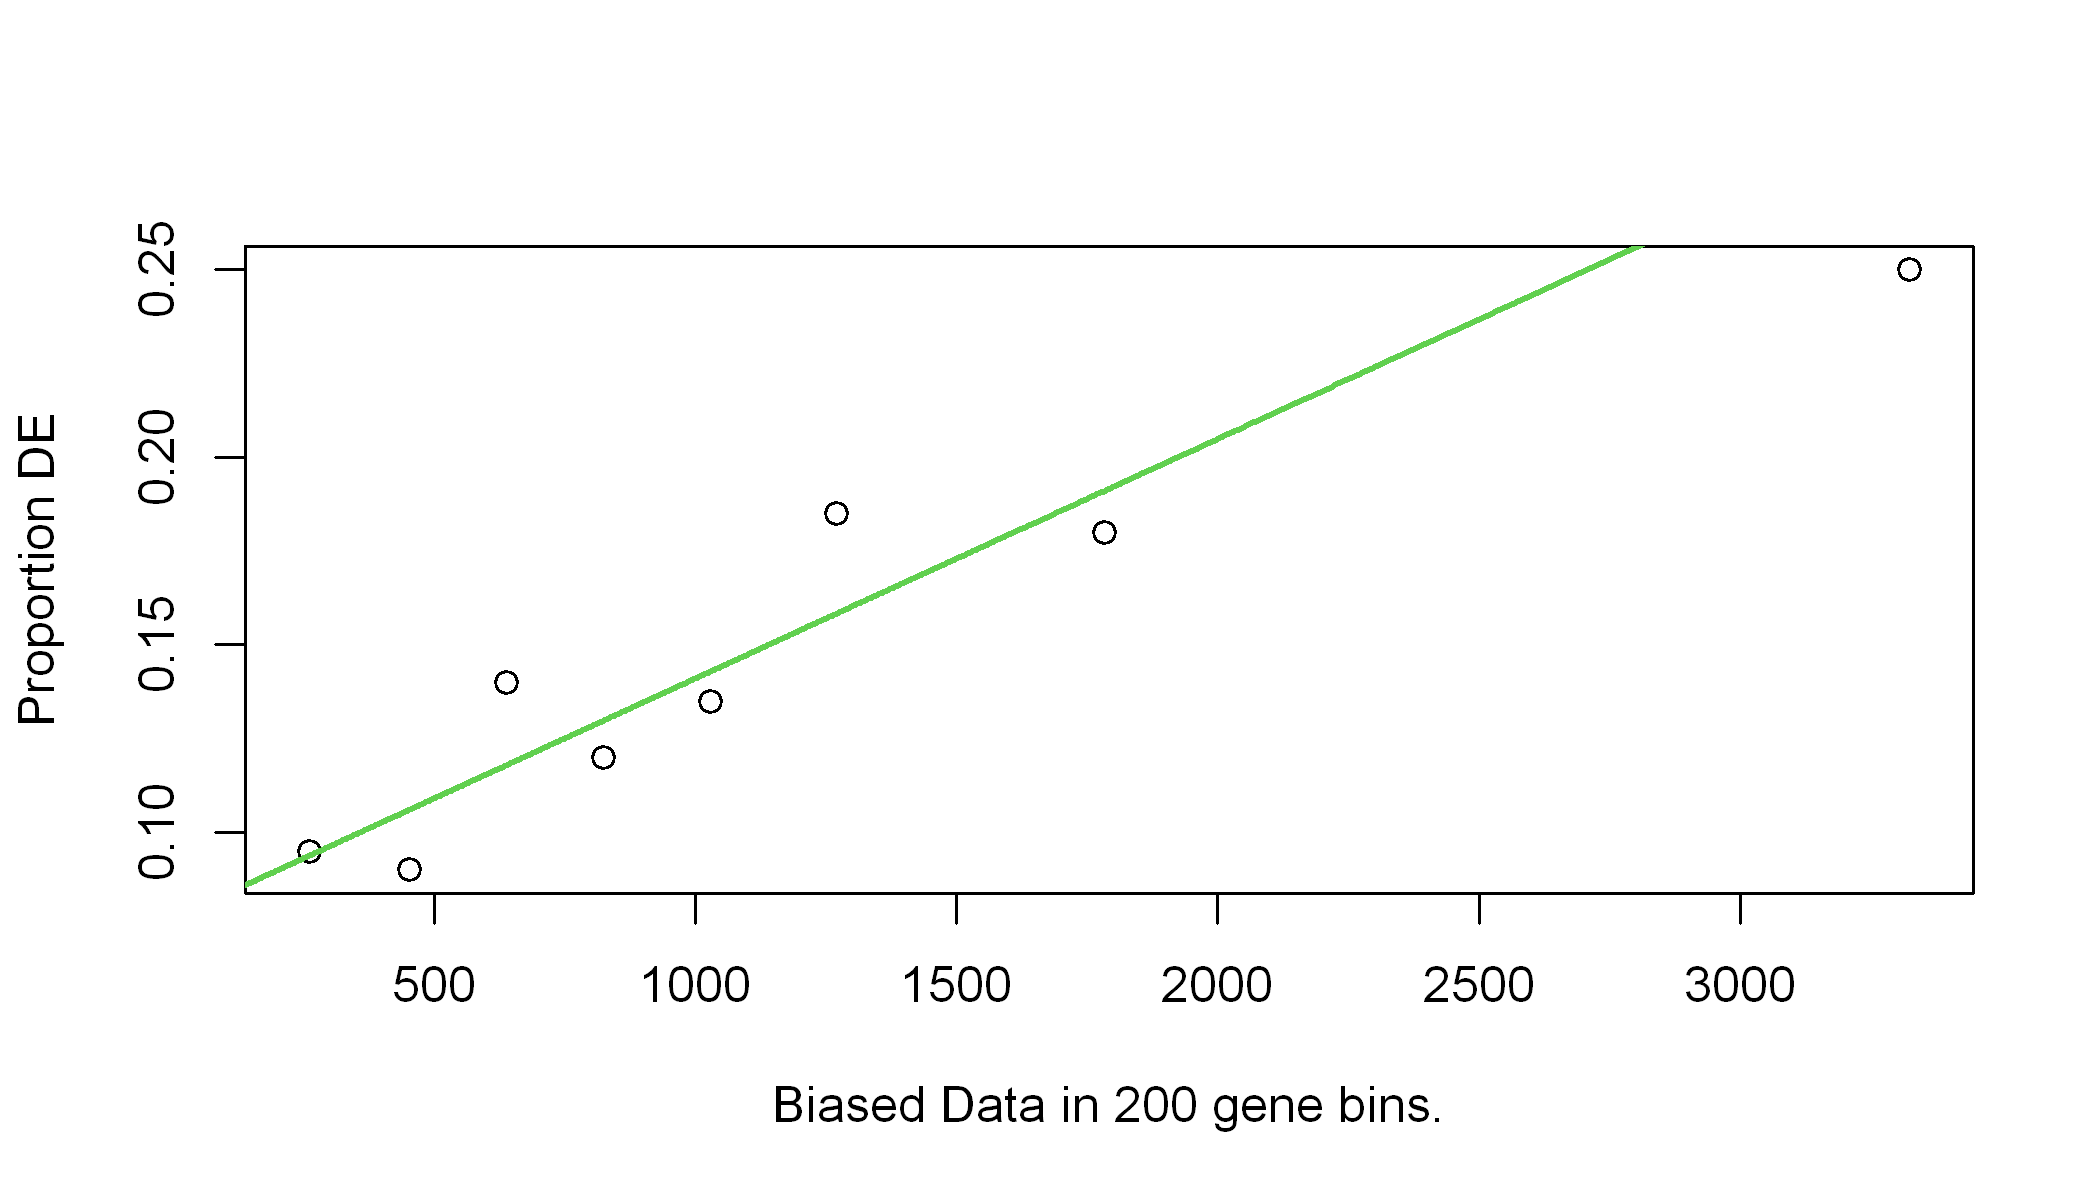

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


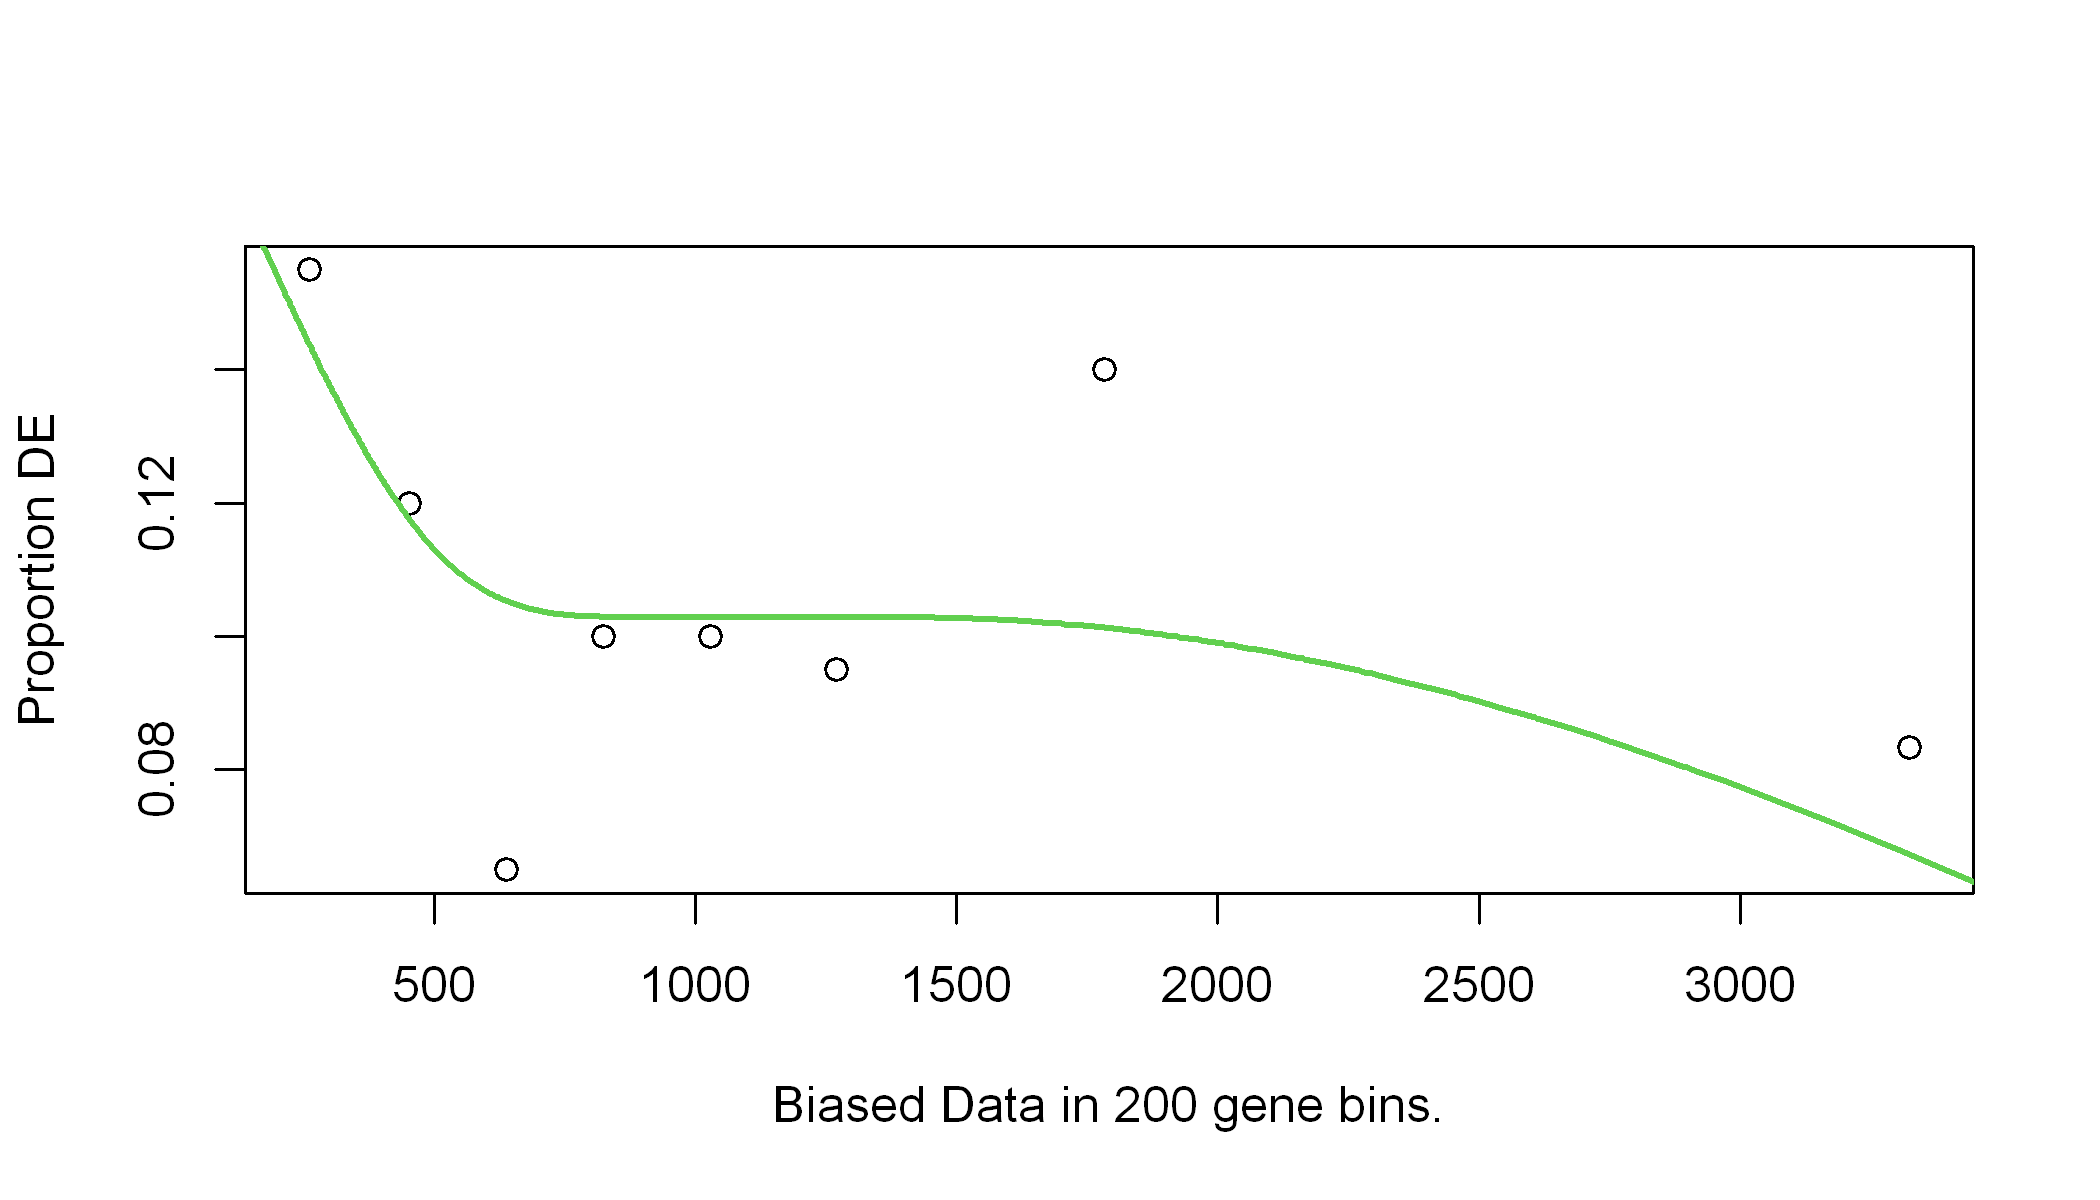

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


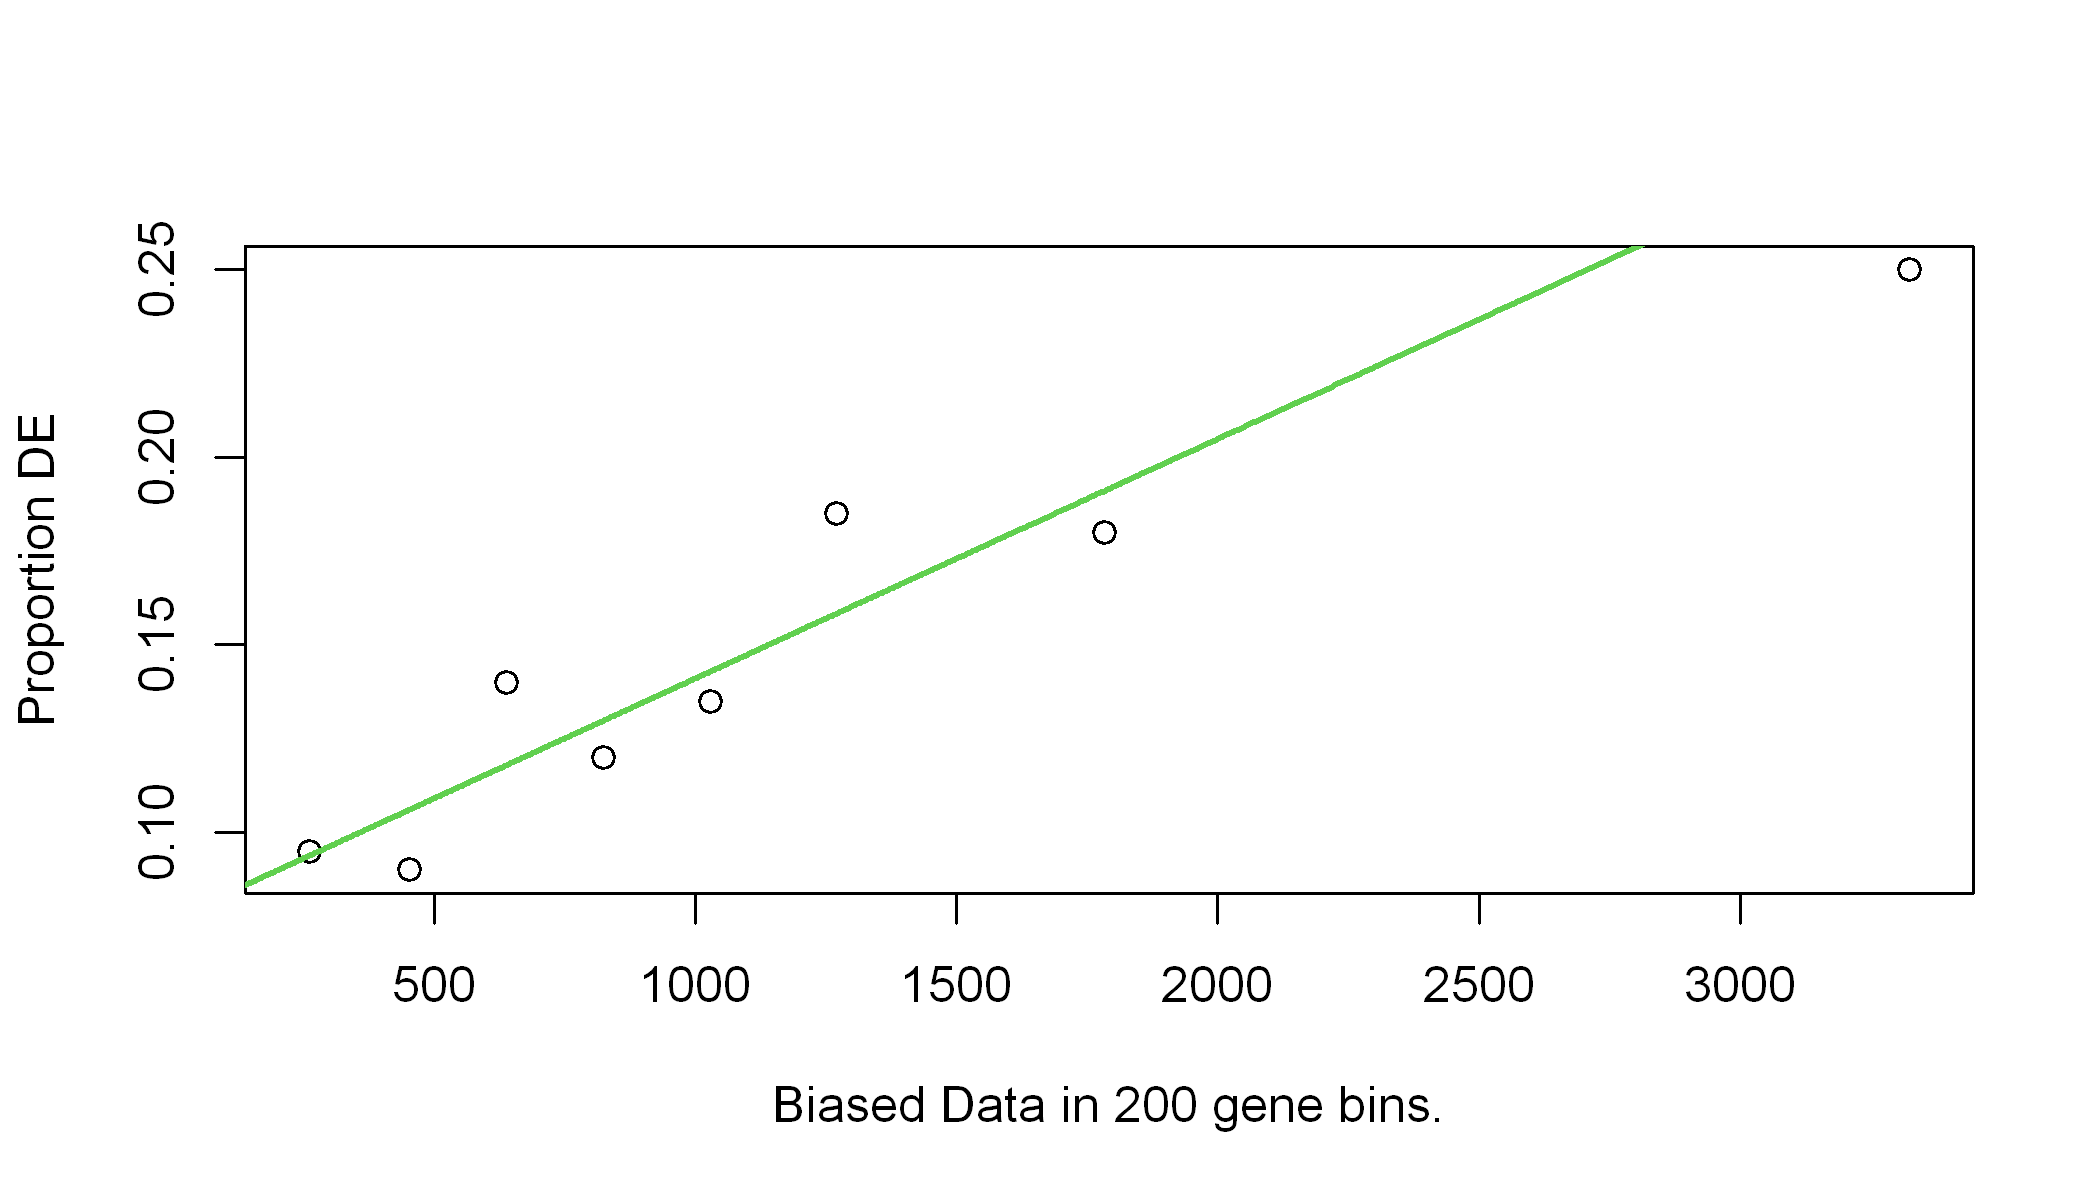

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


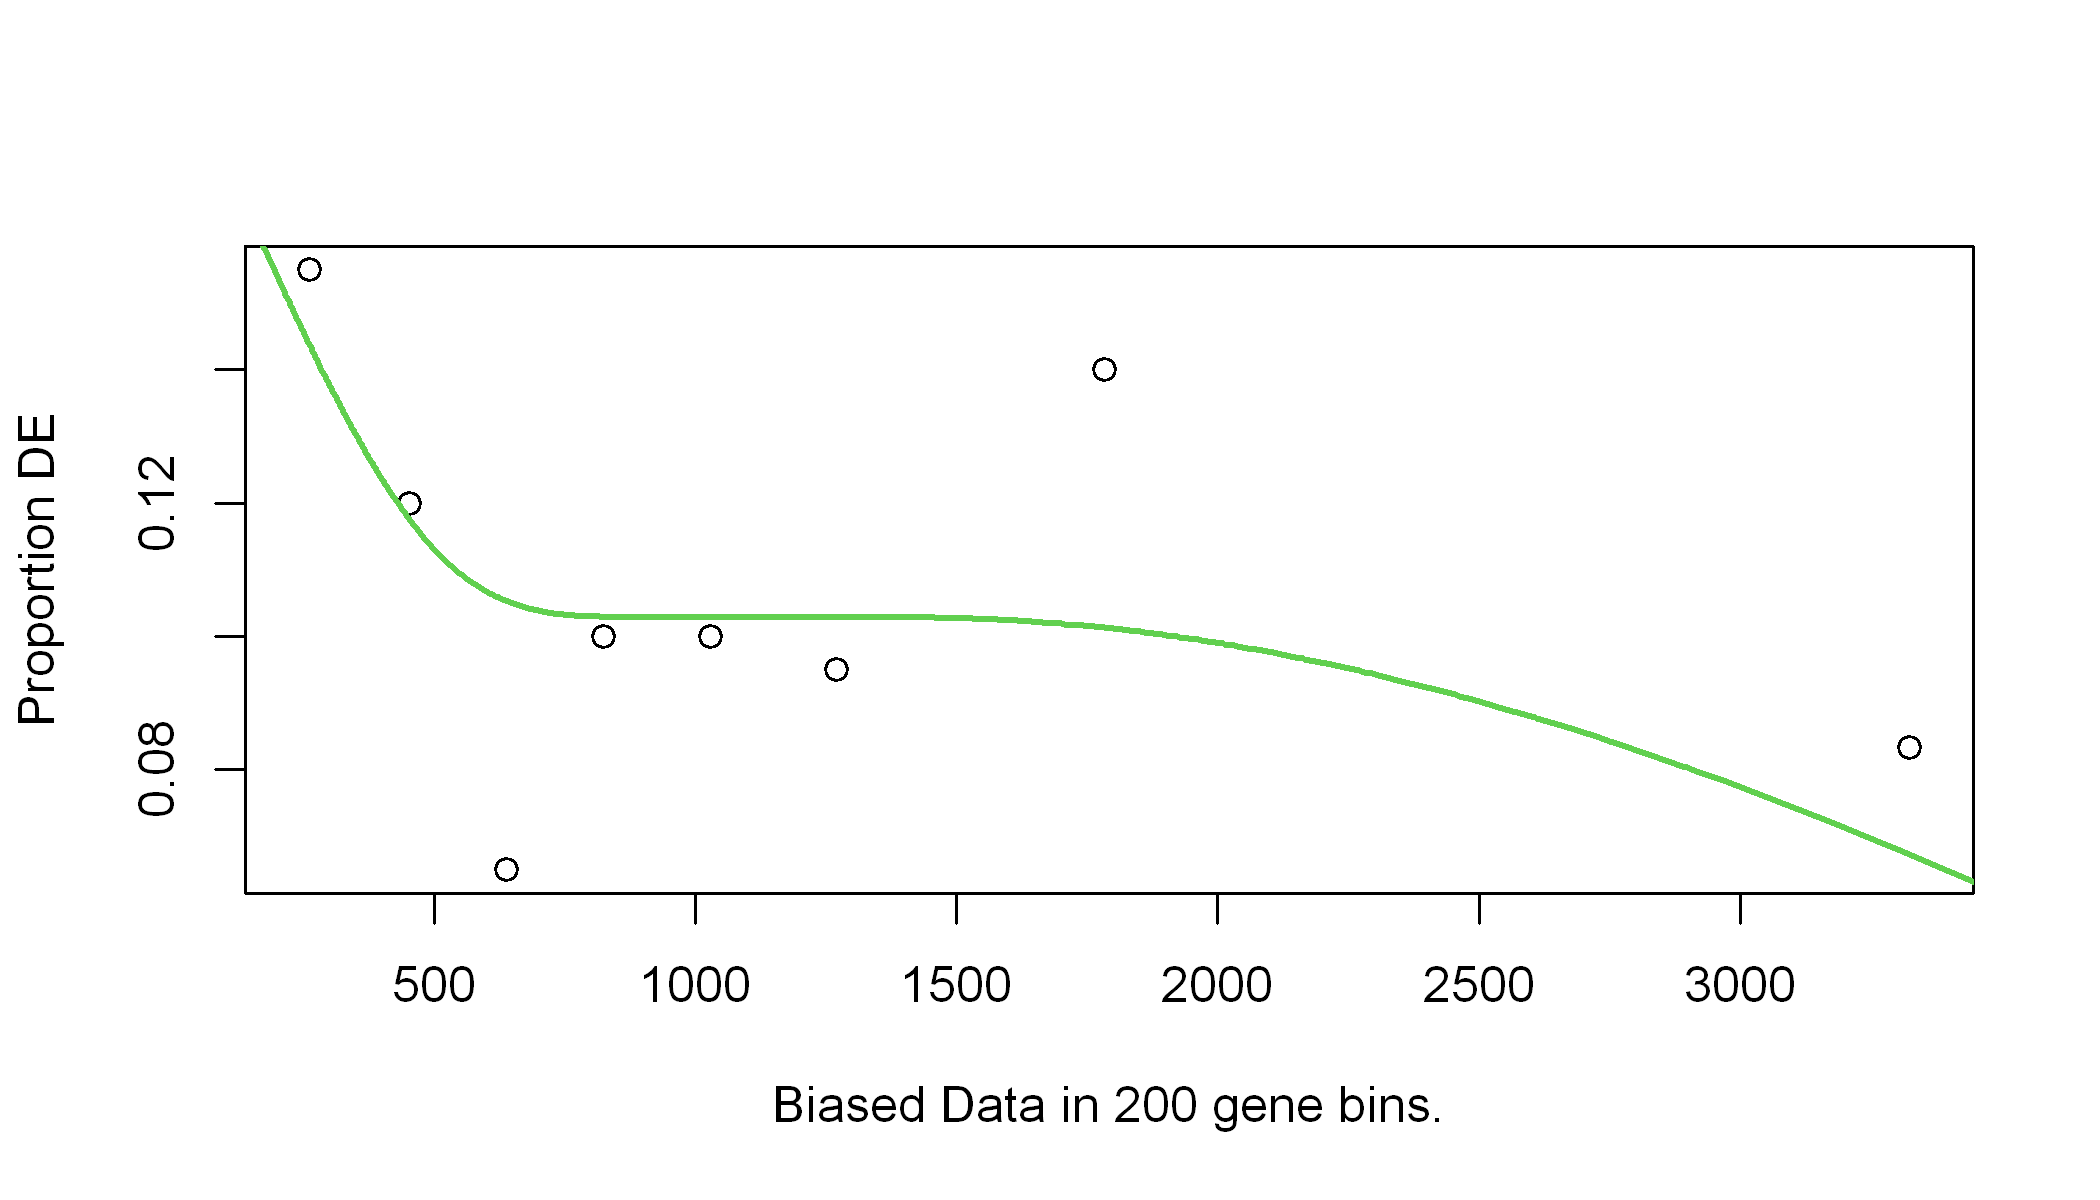

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


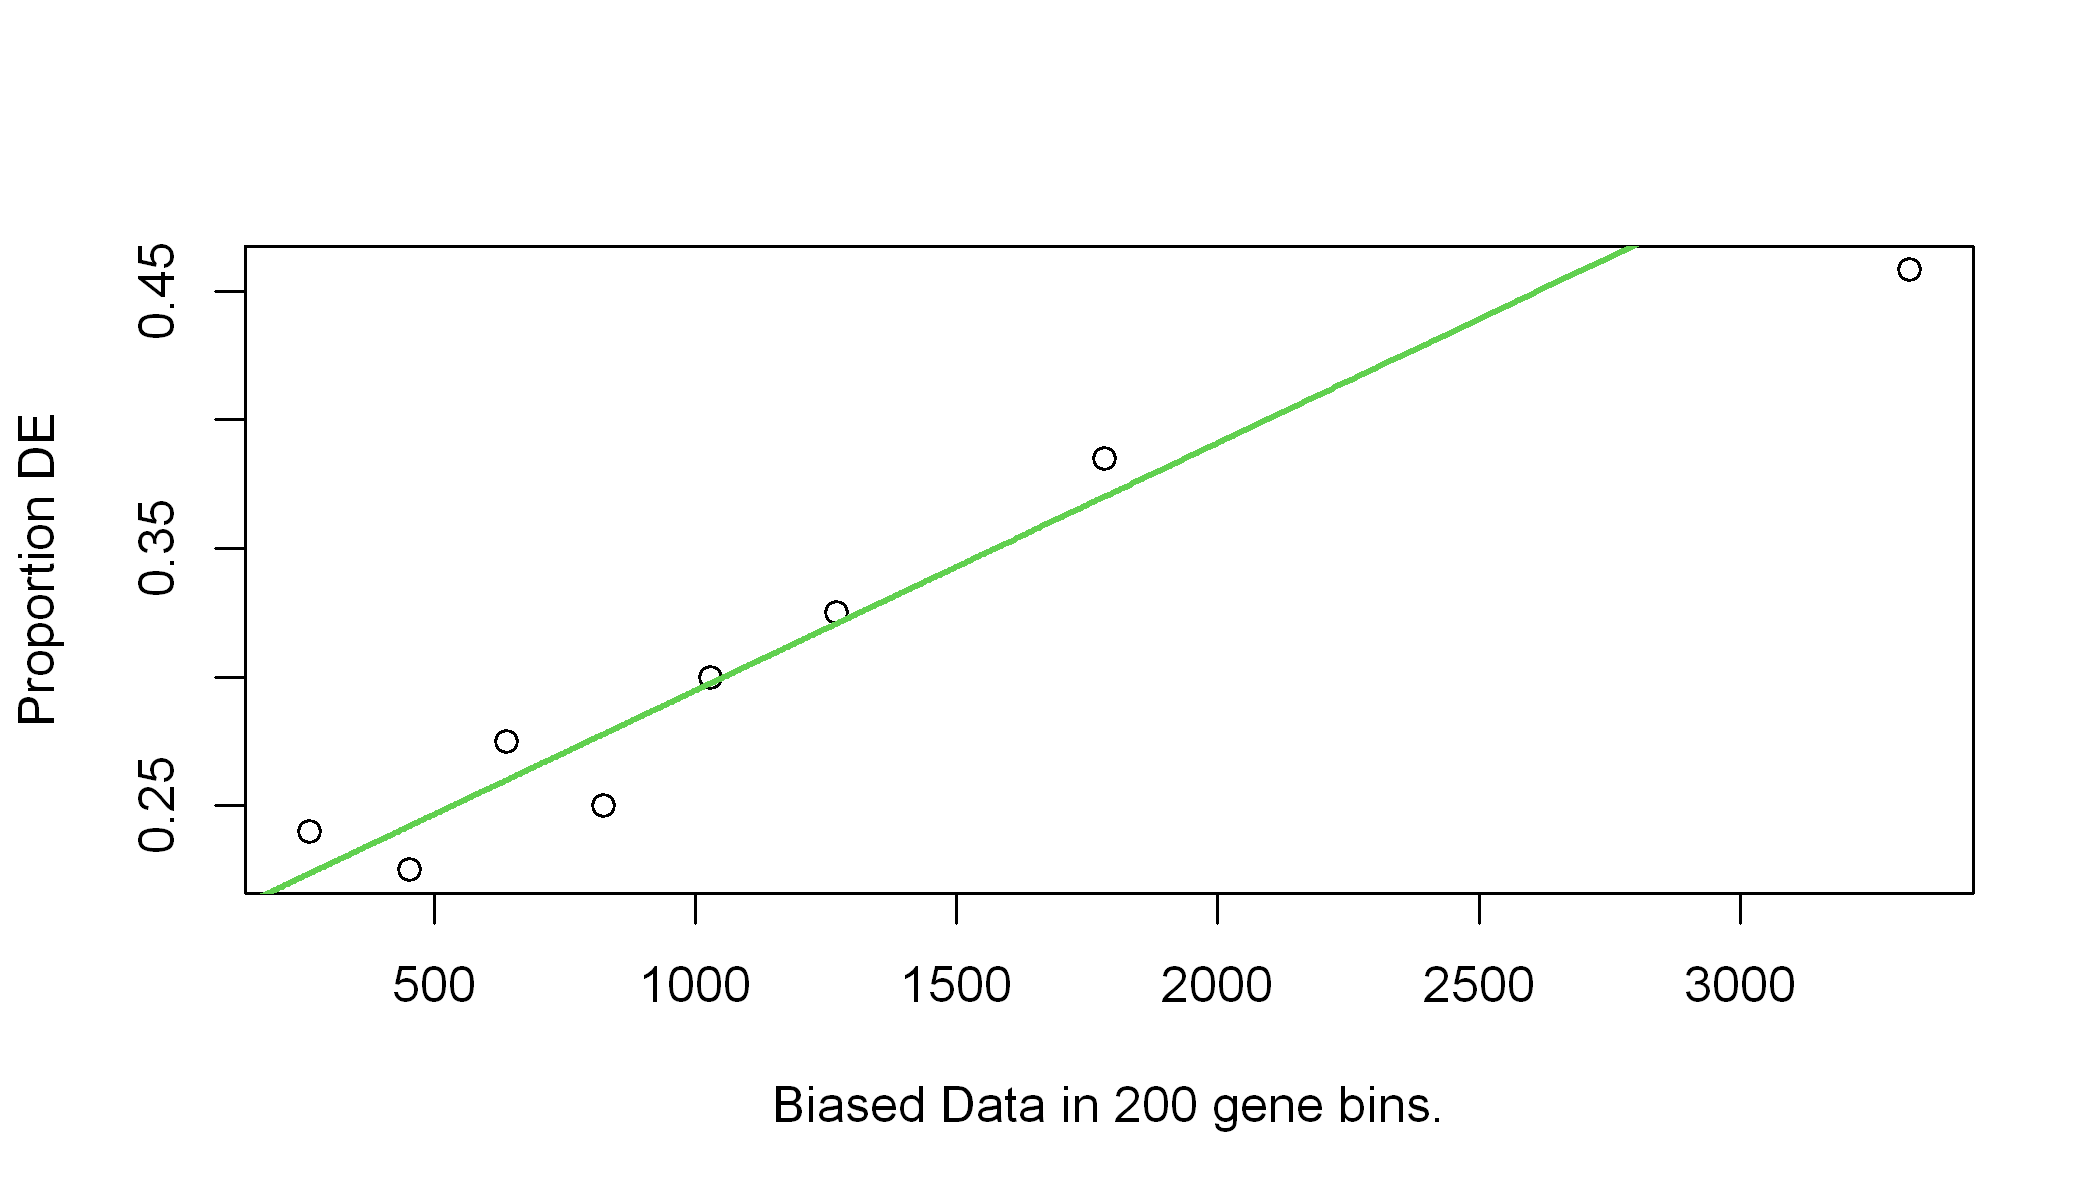

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


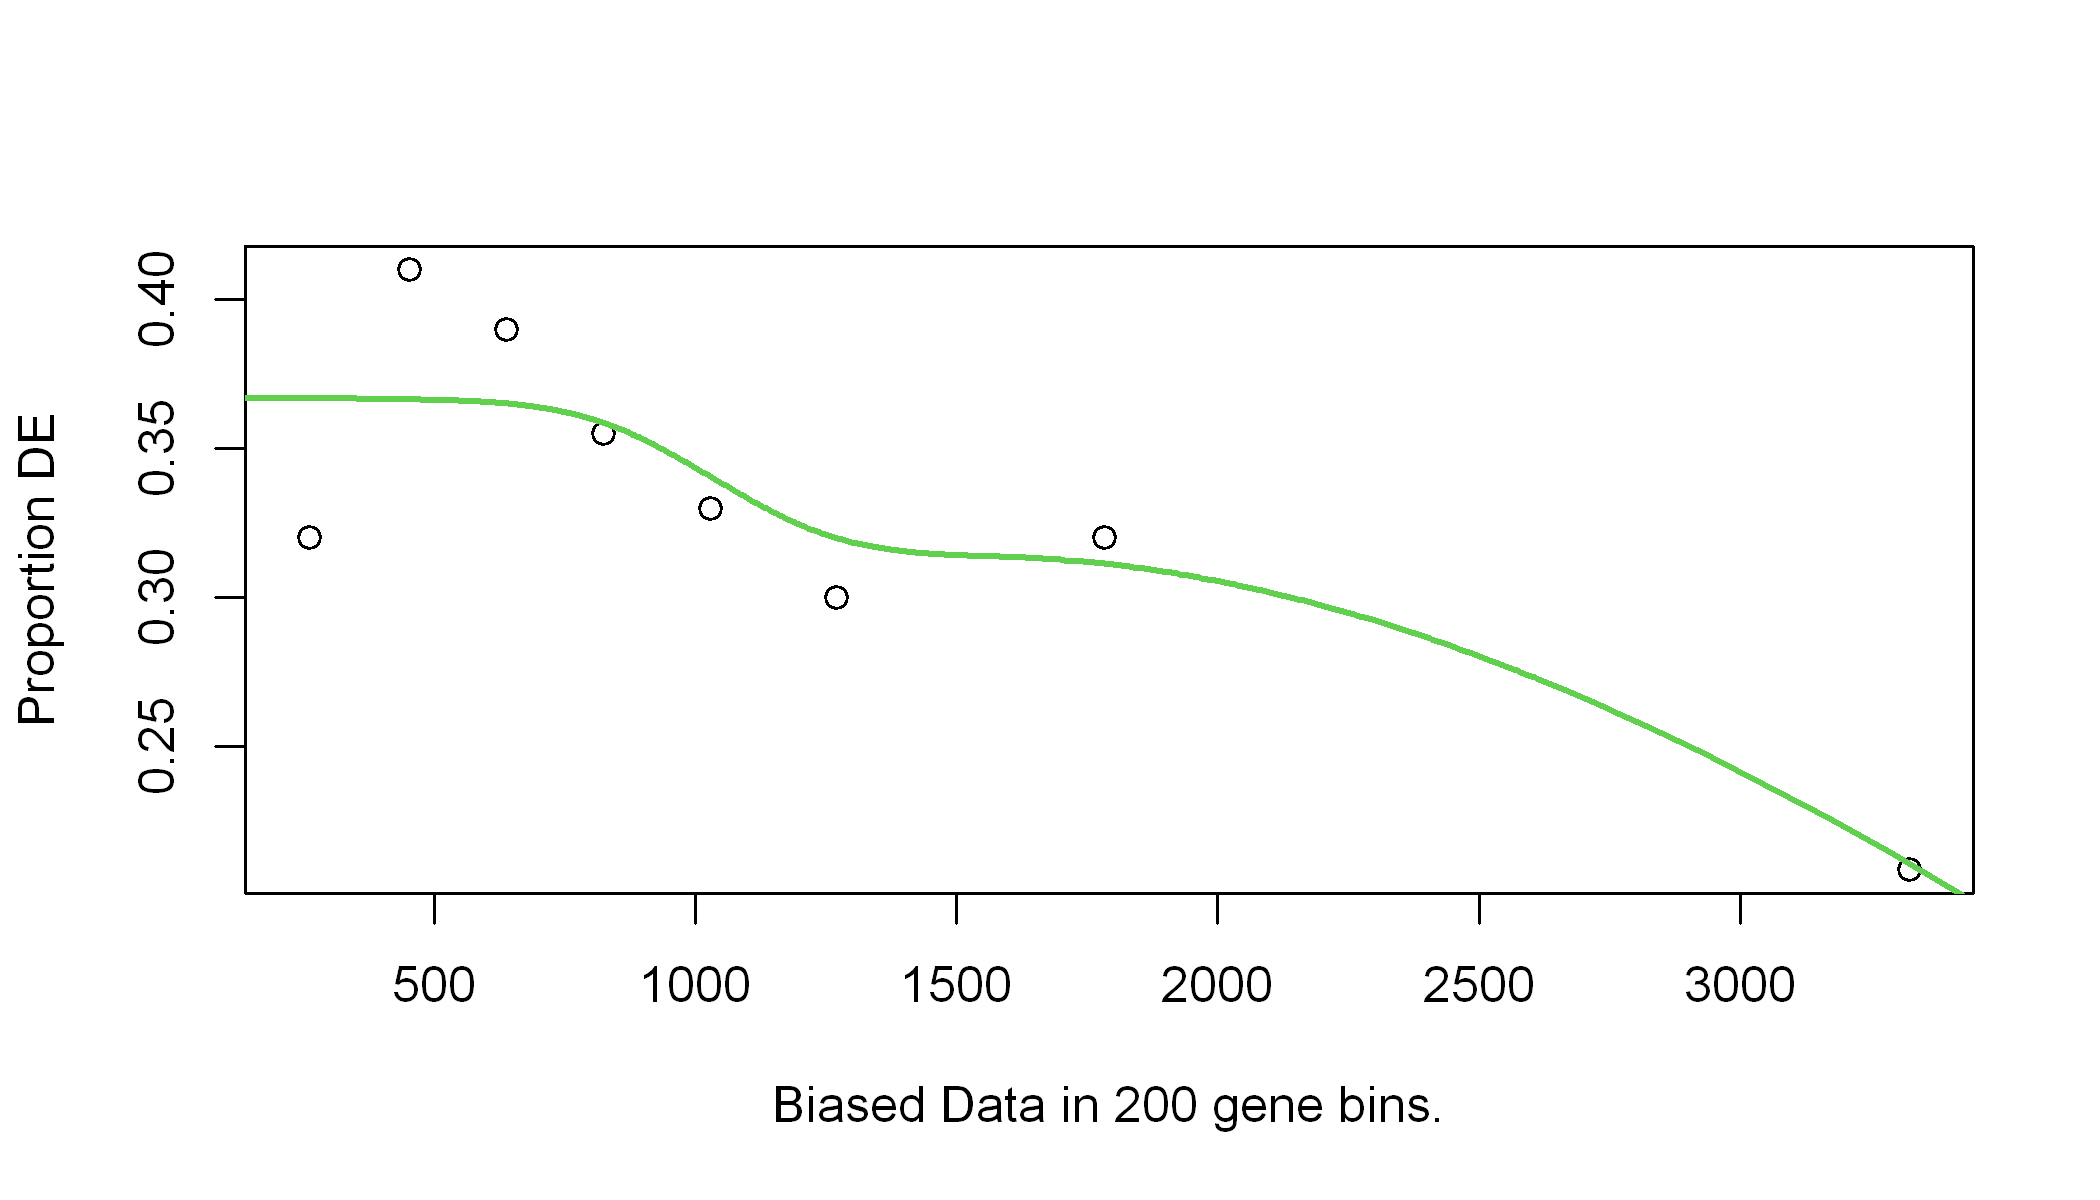

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


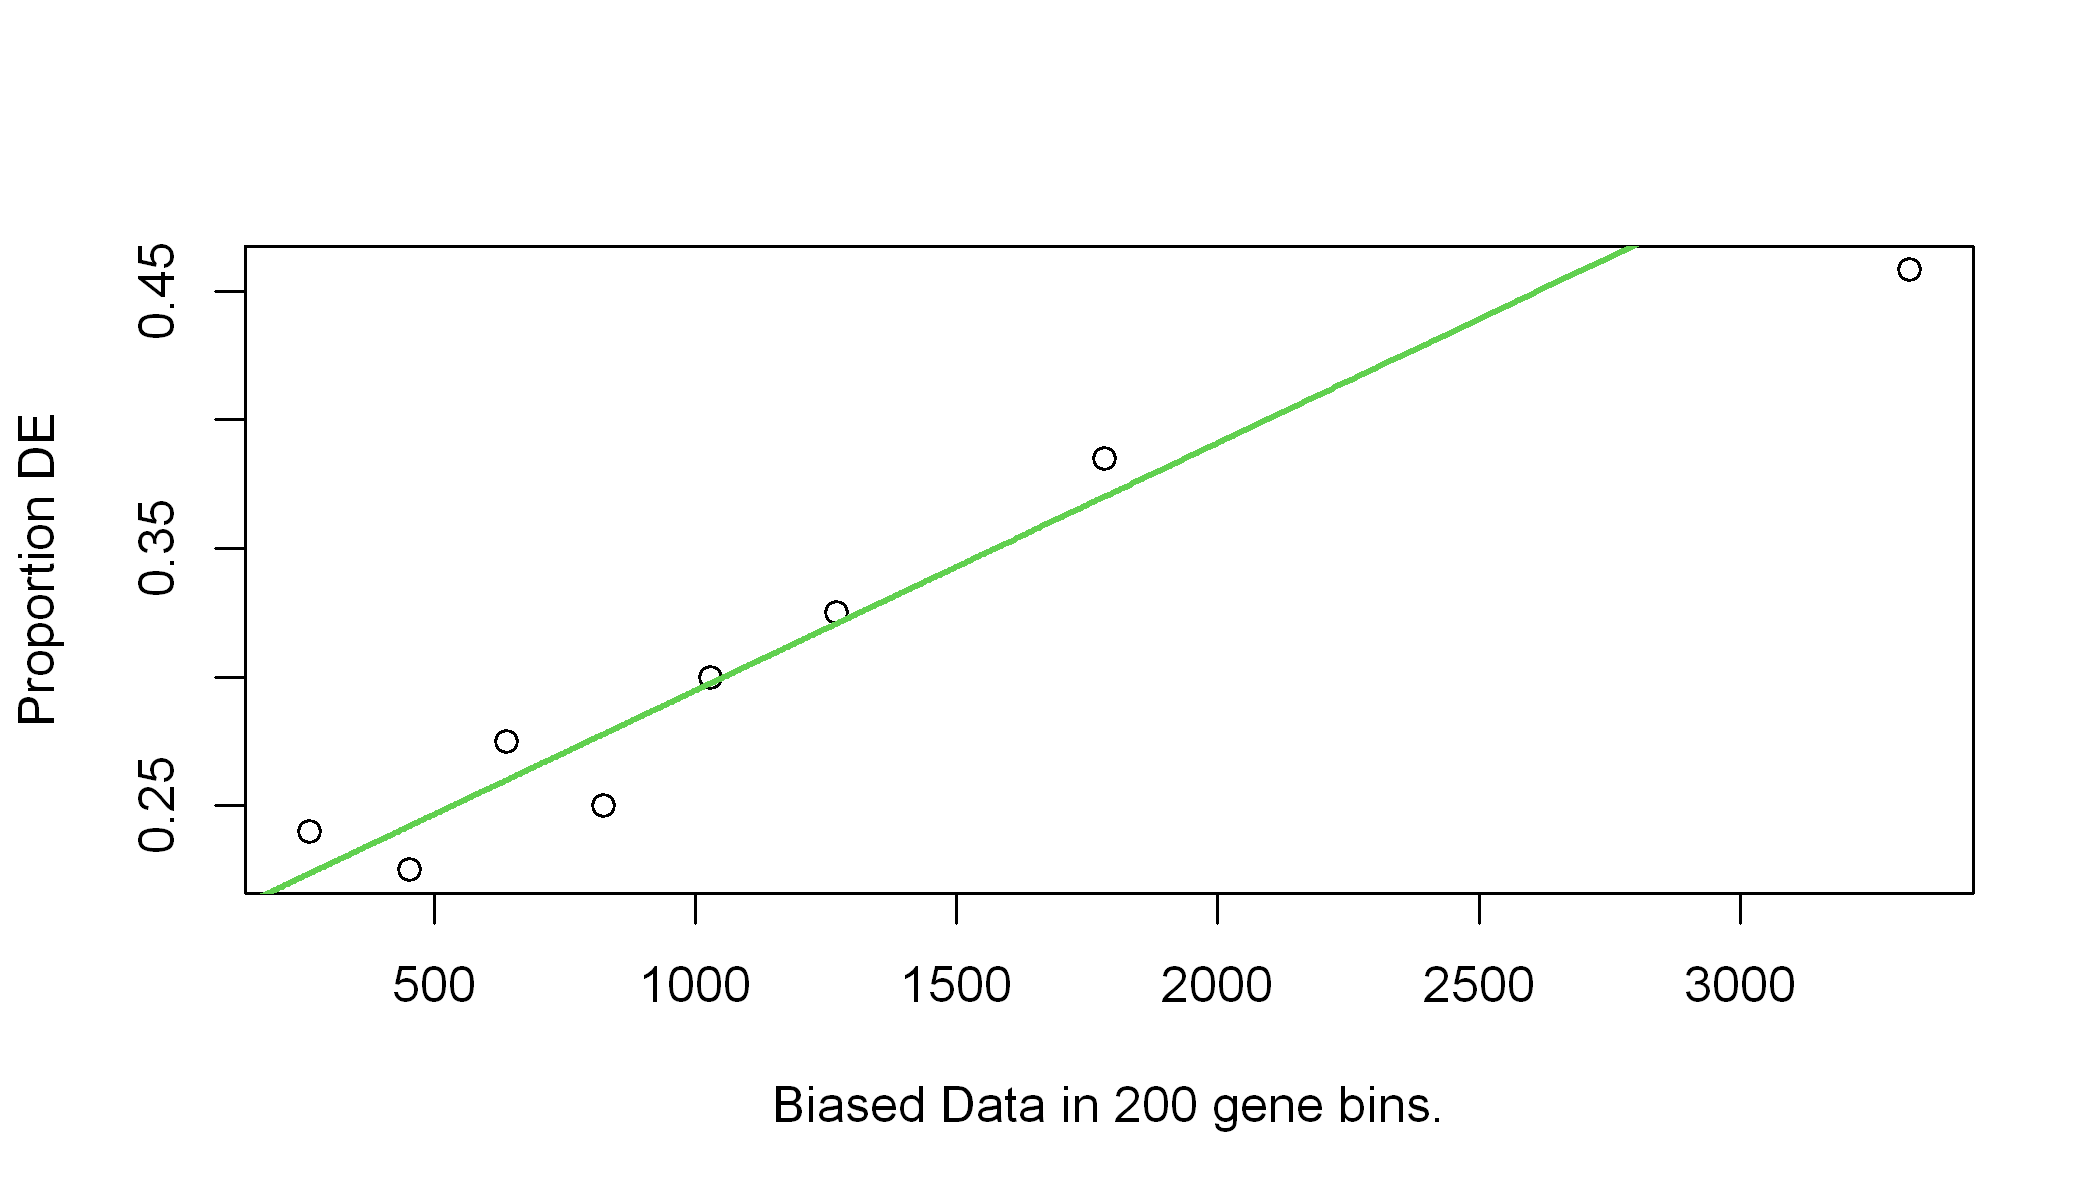

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


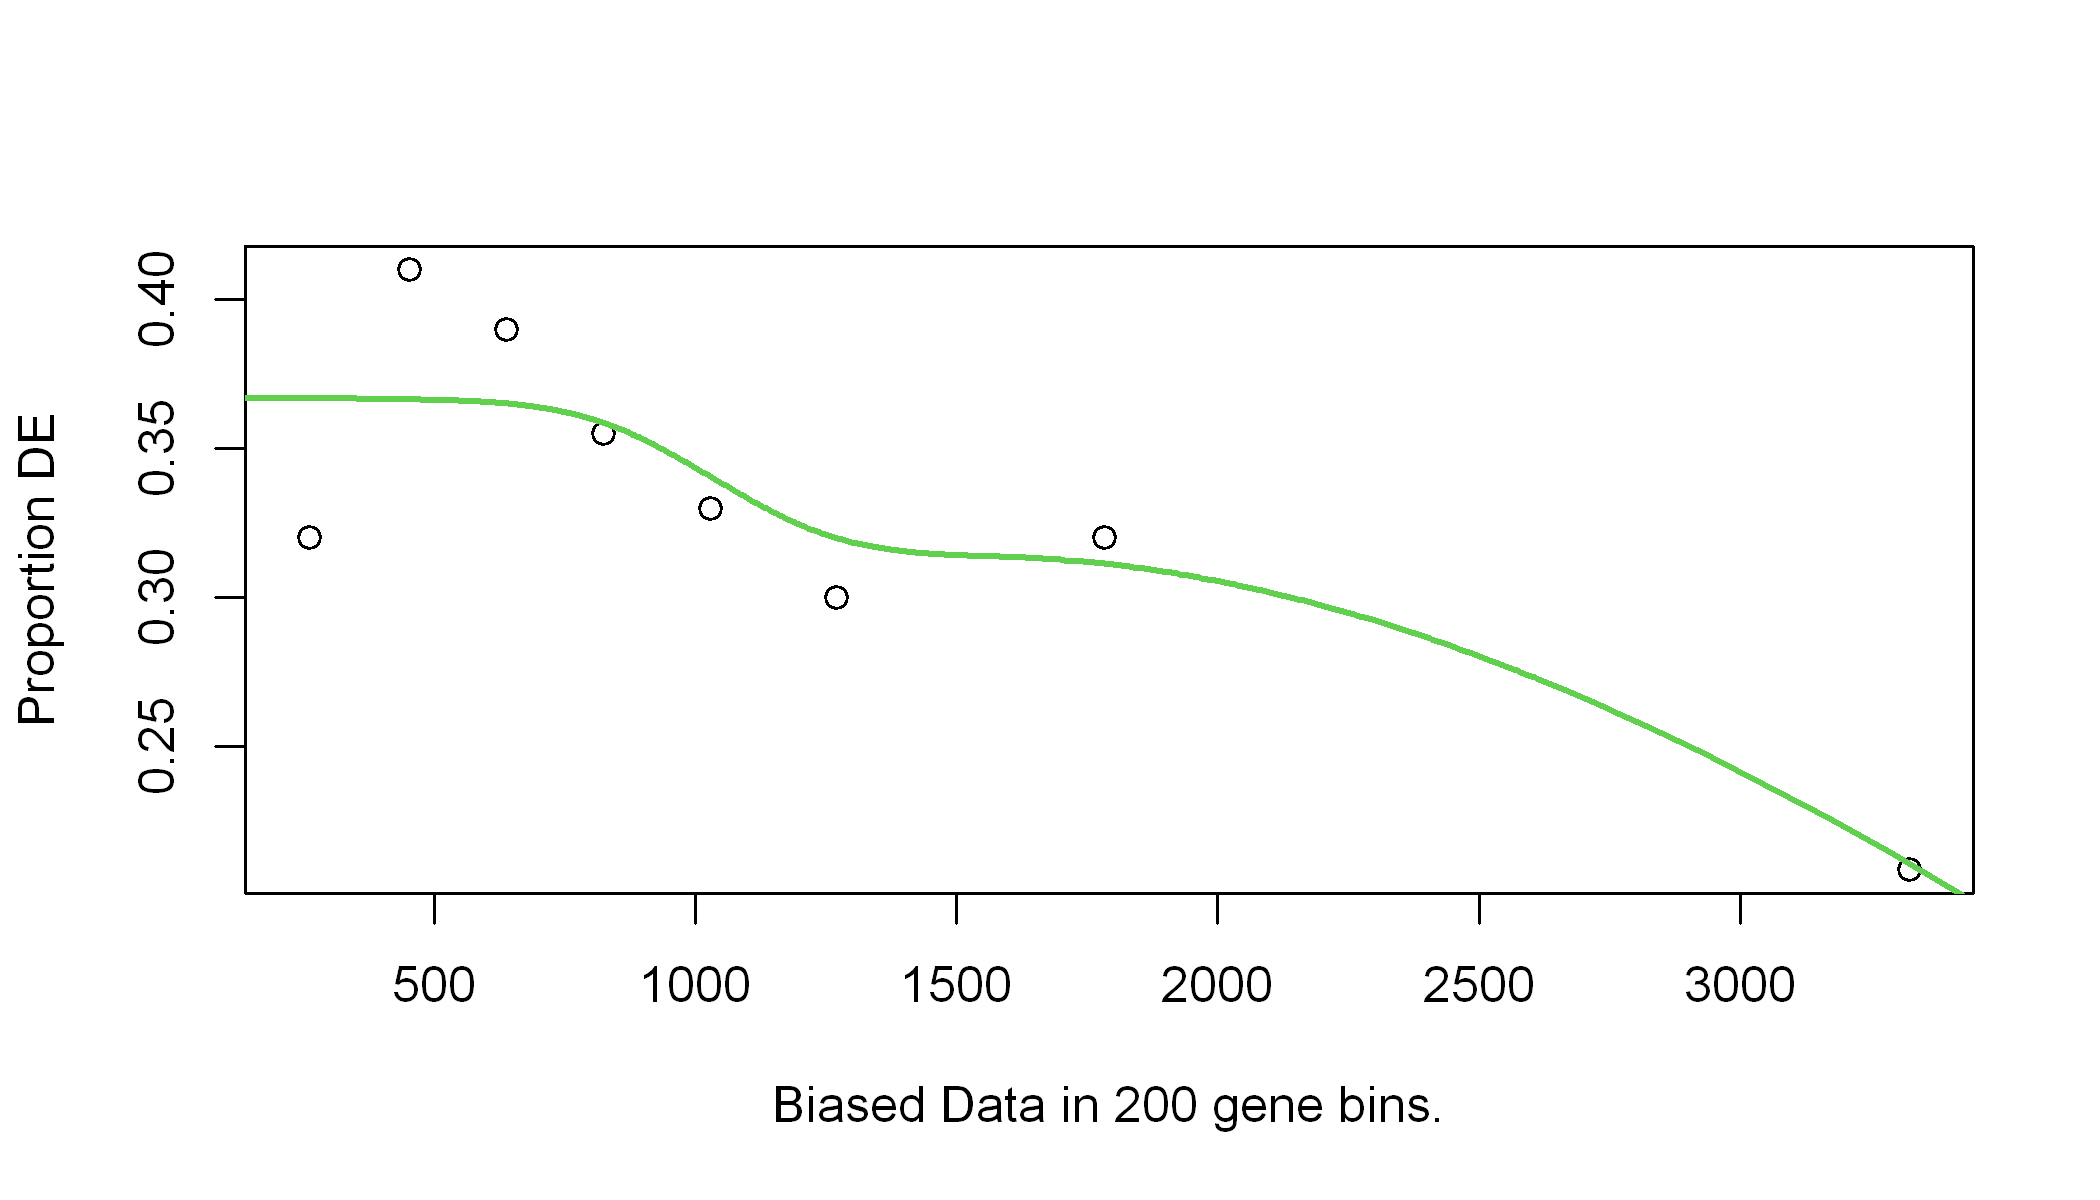

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


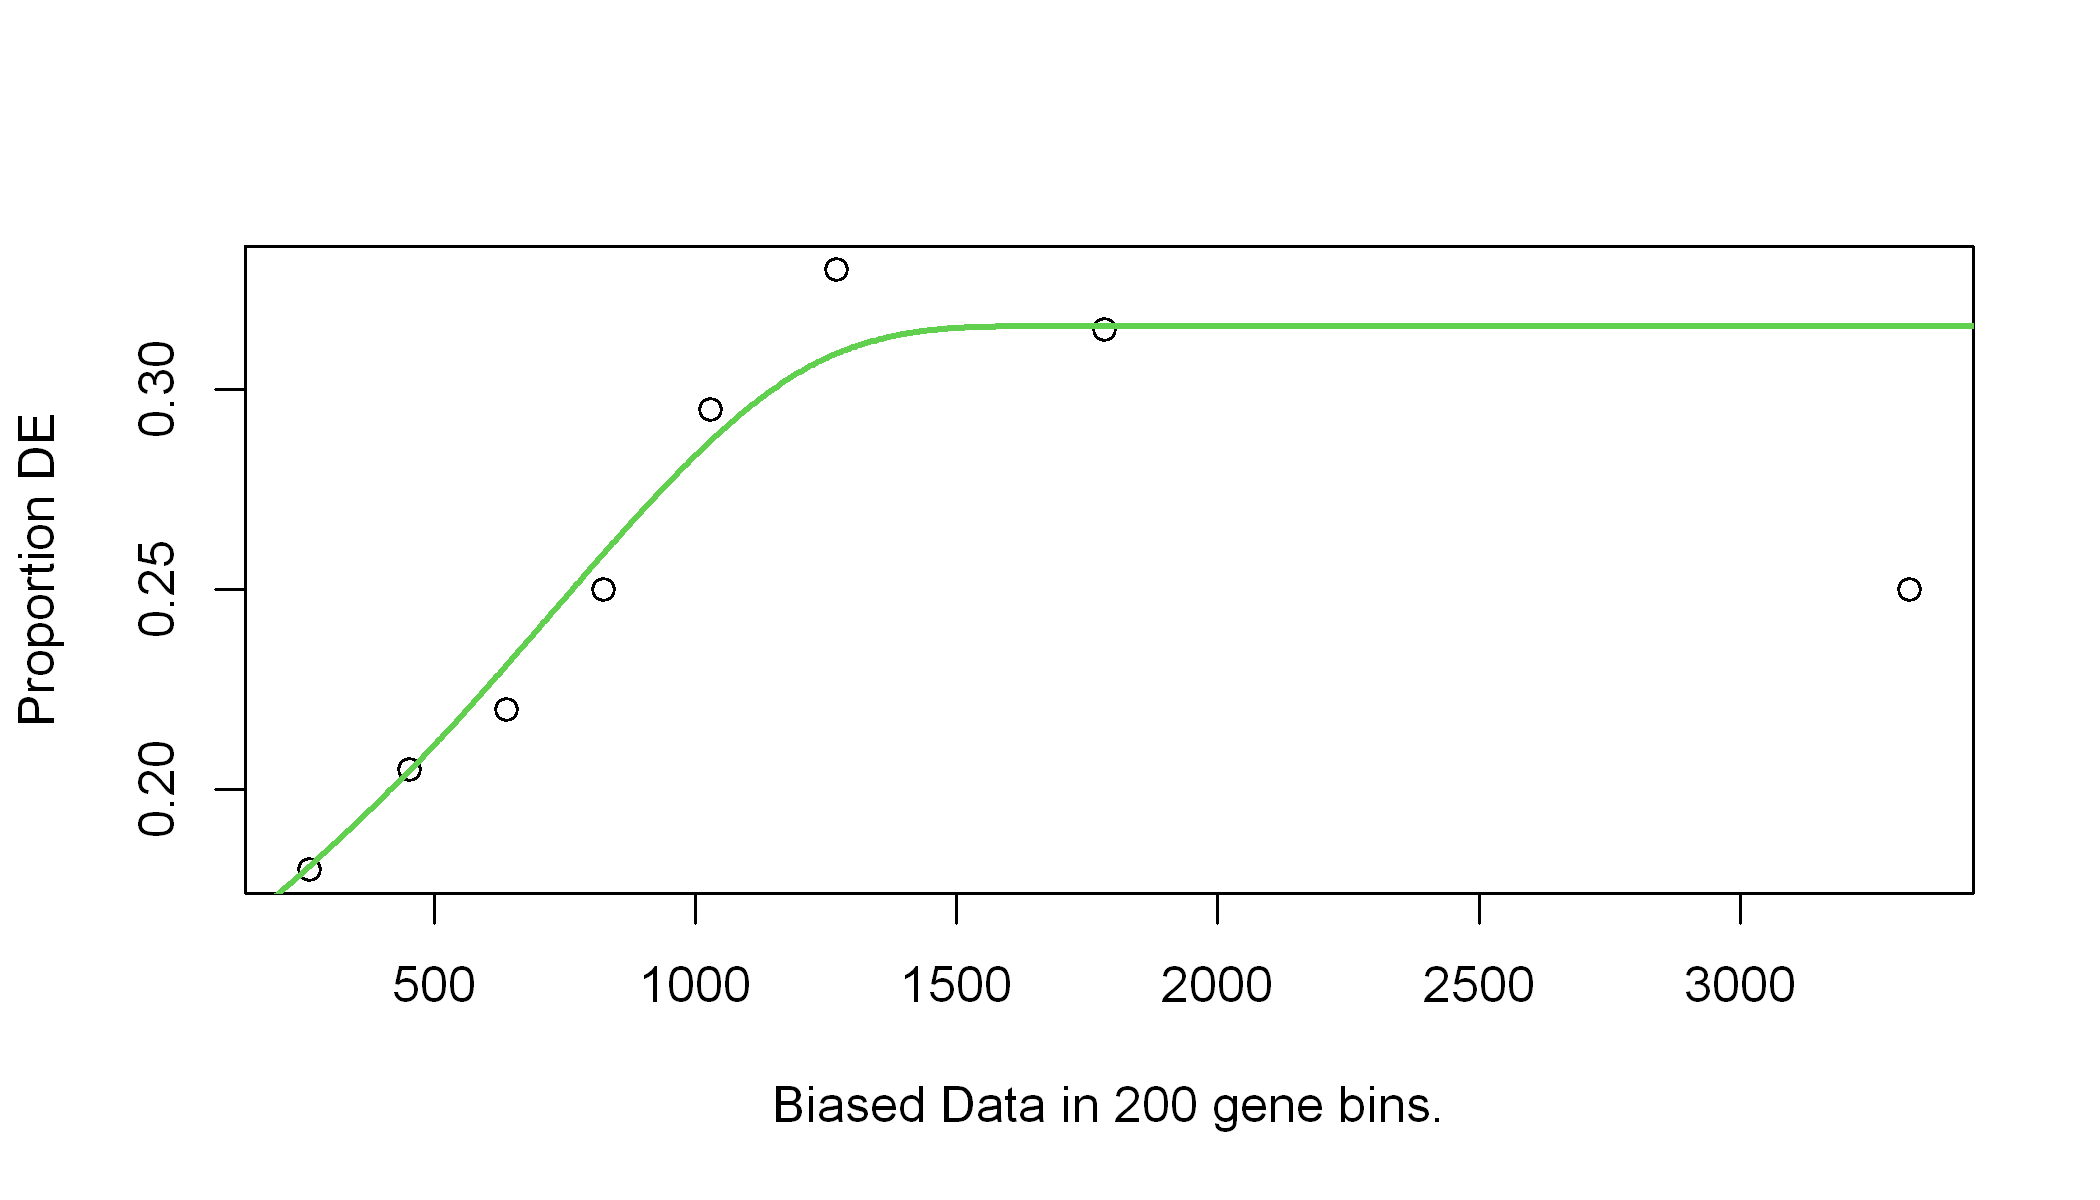

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


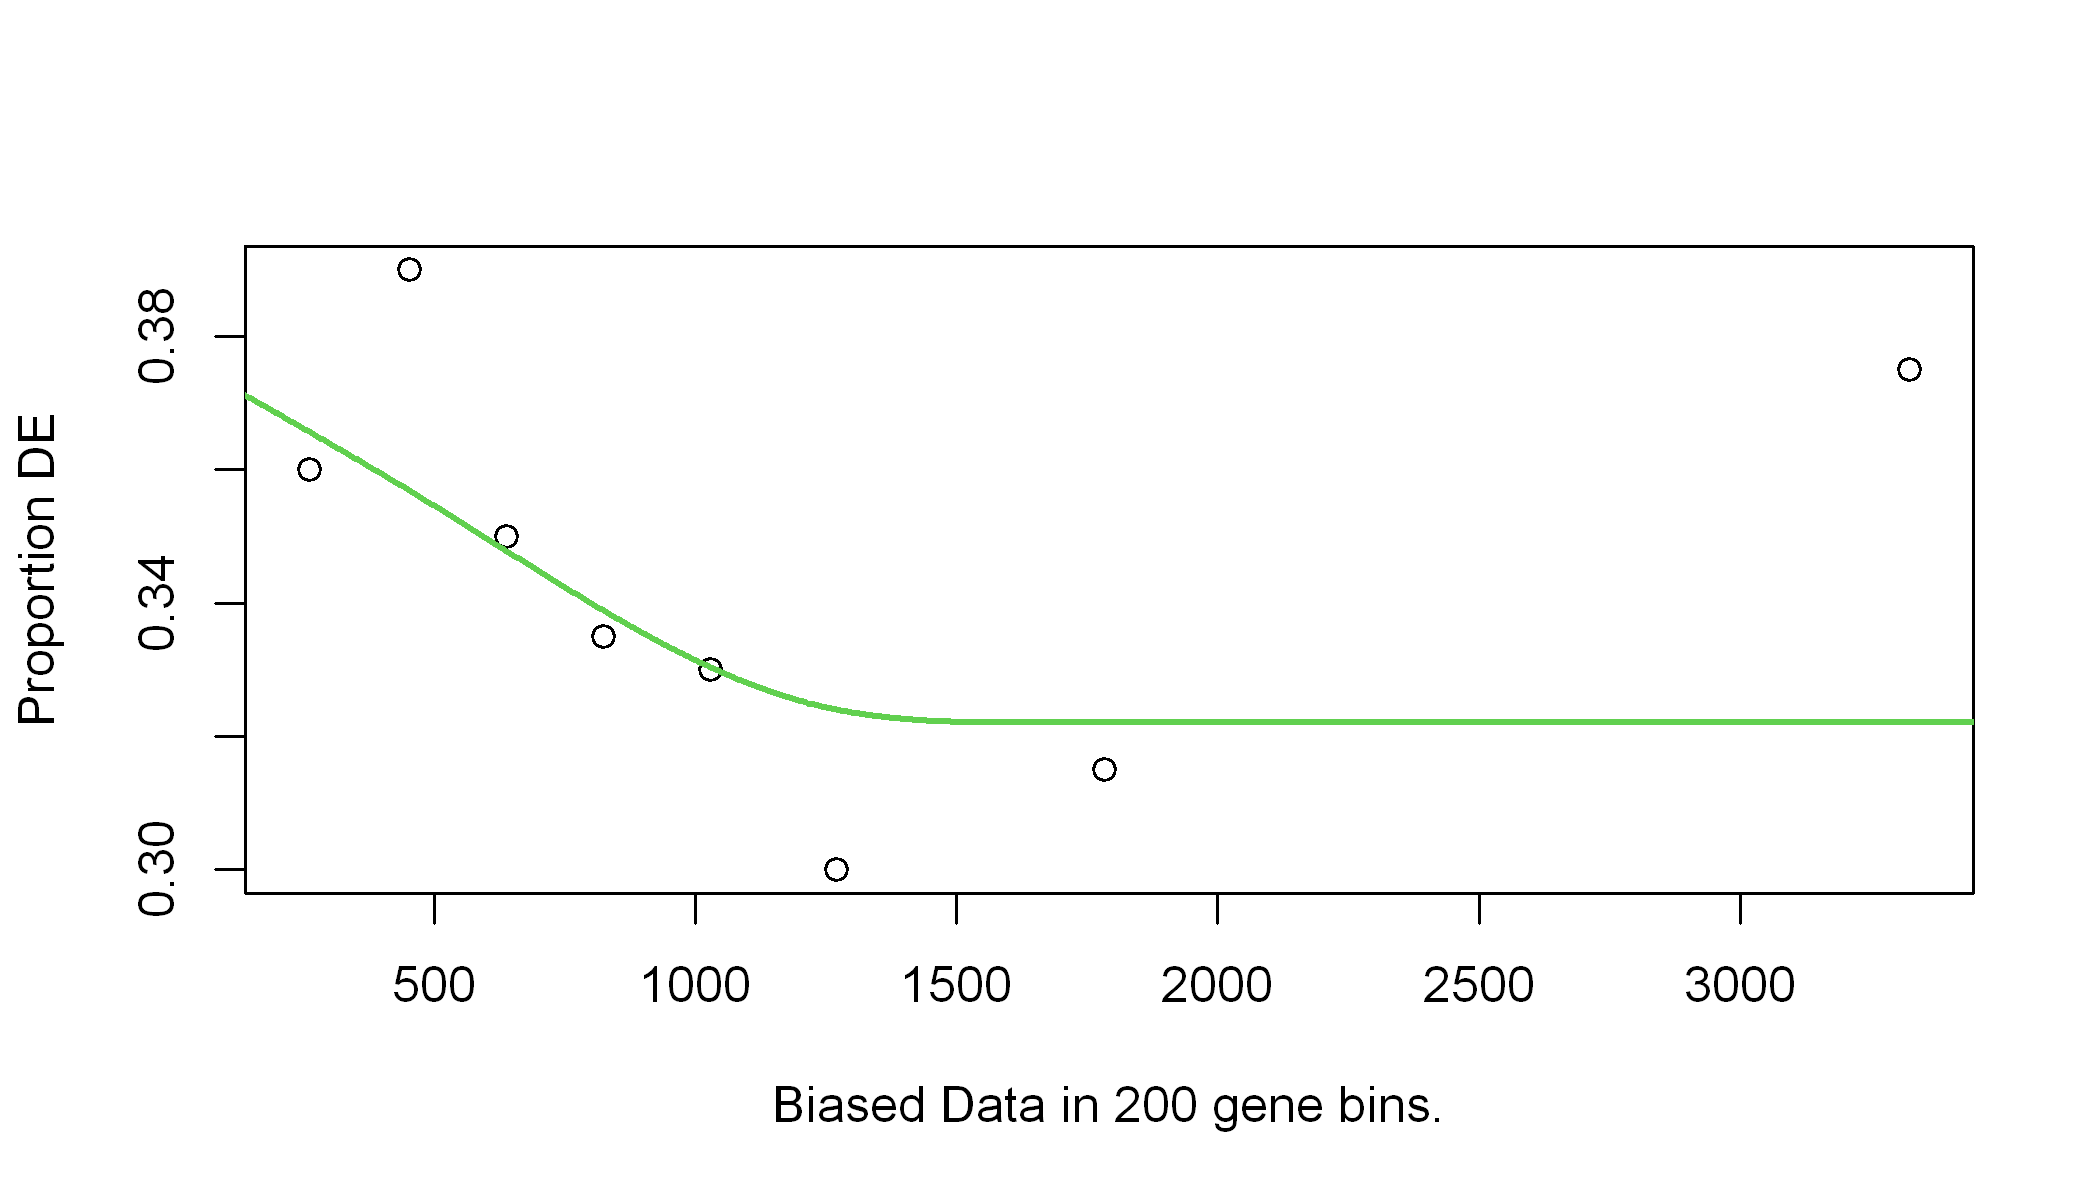

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`


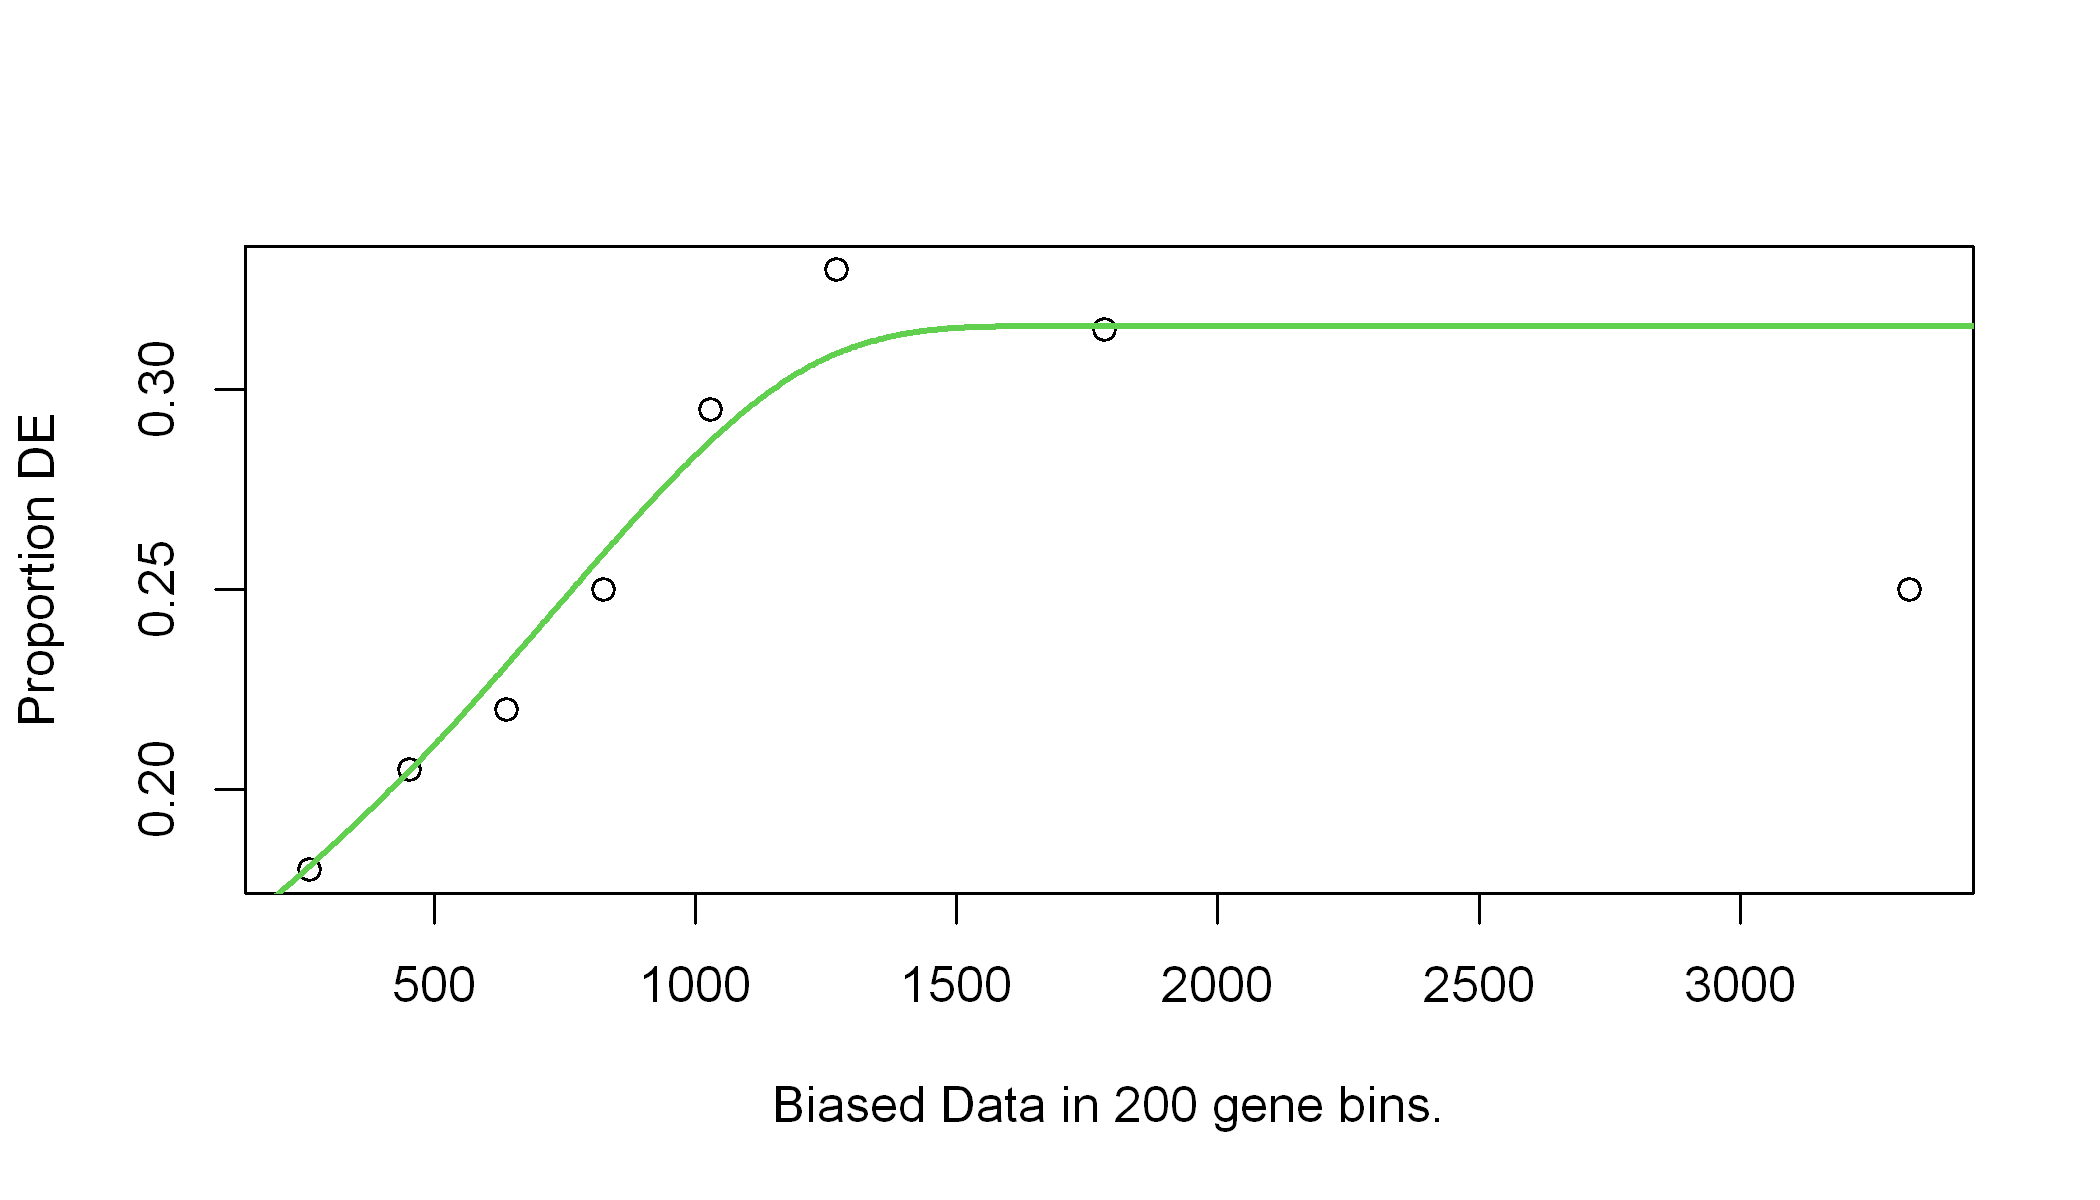

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


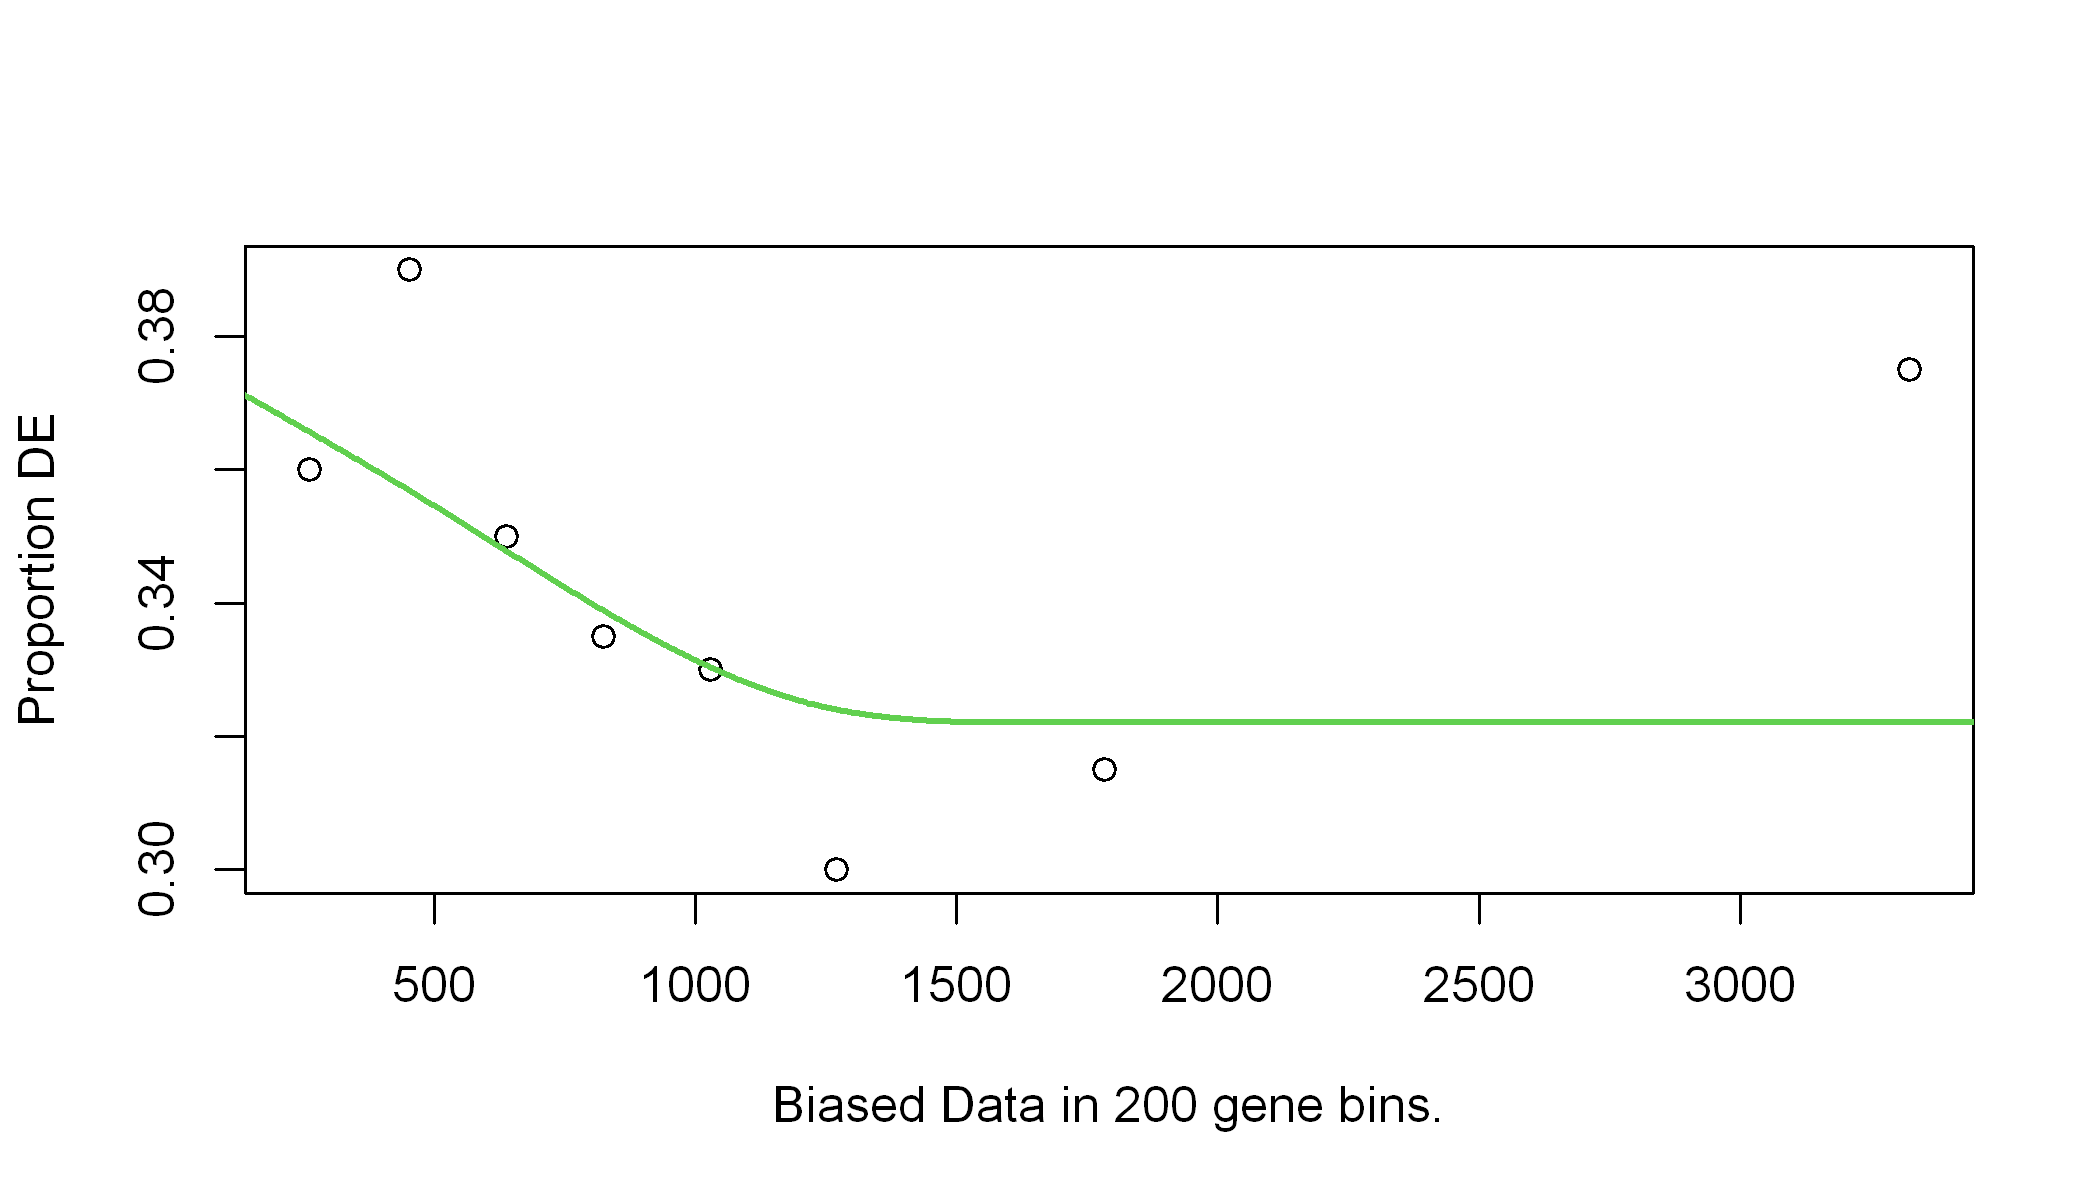

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


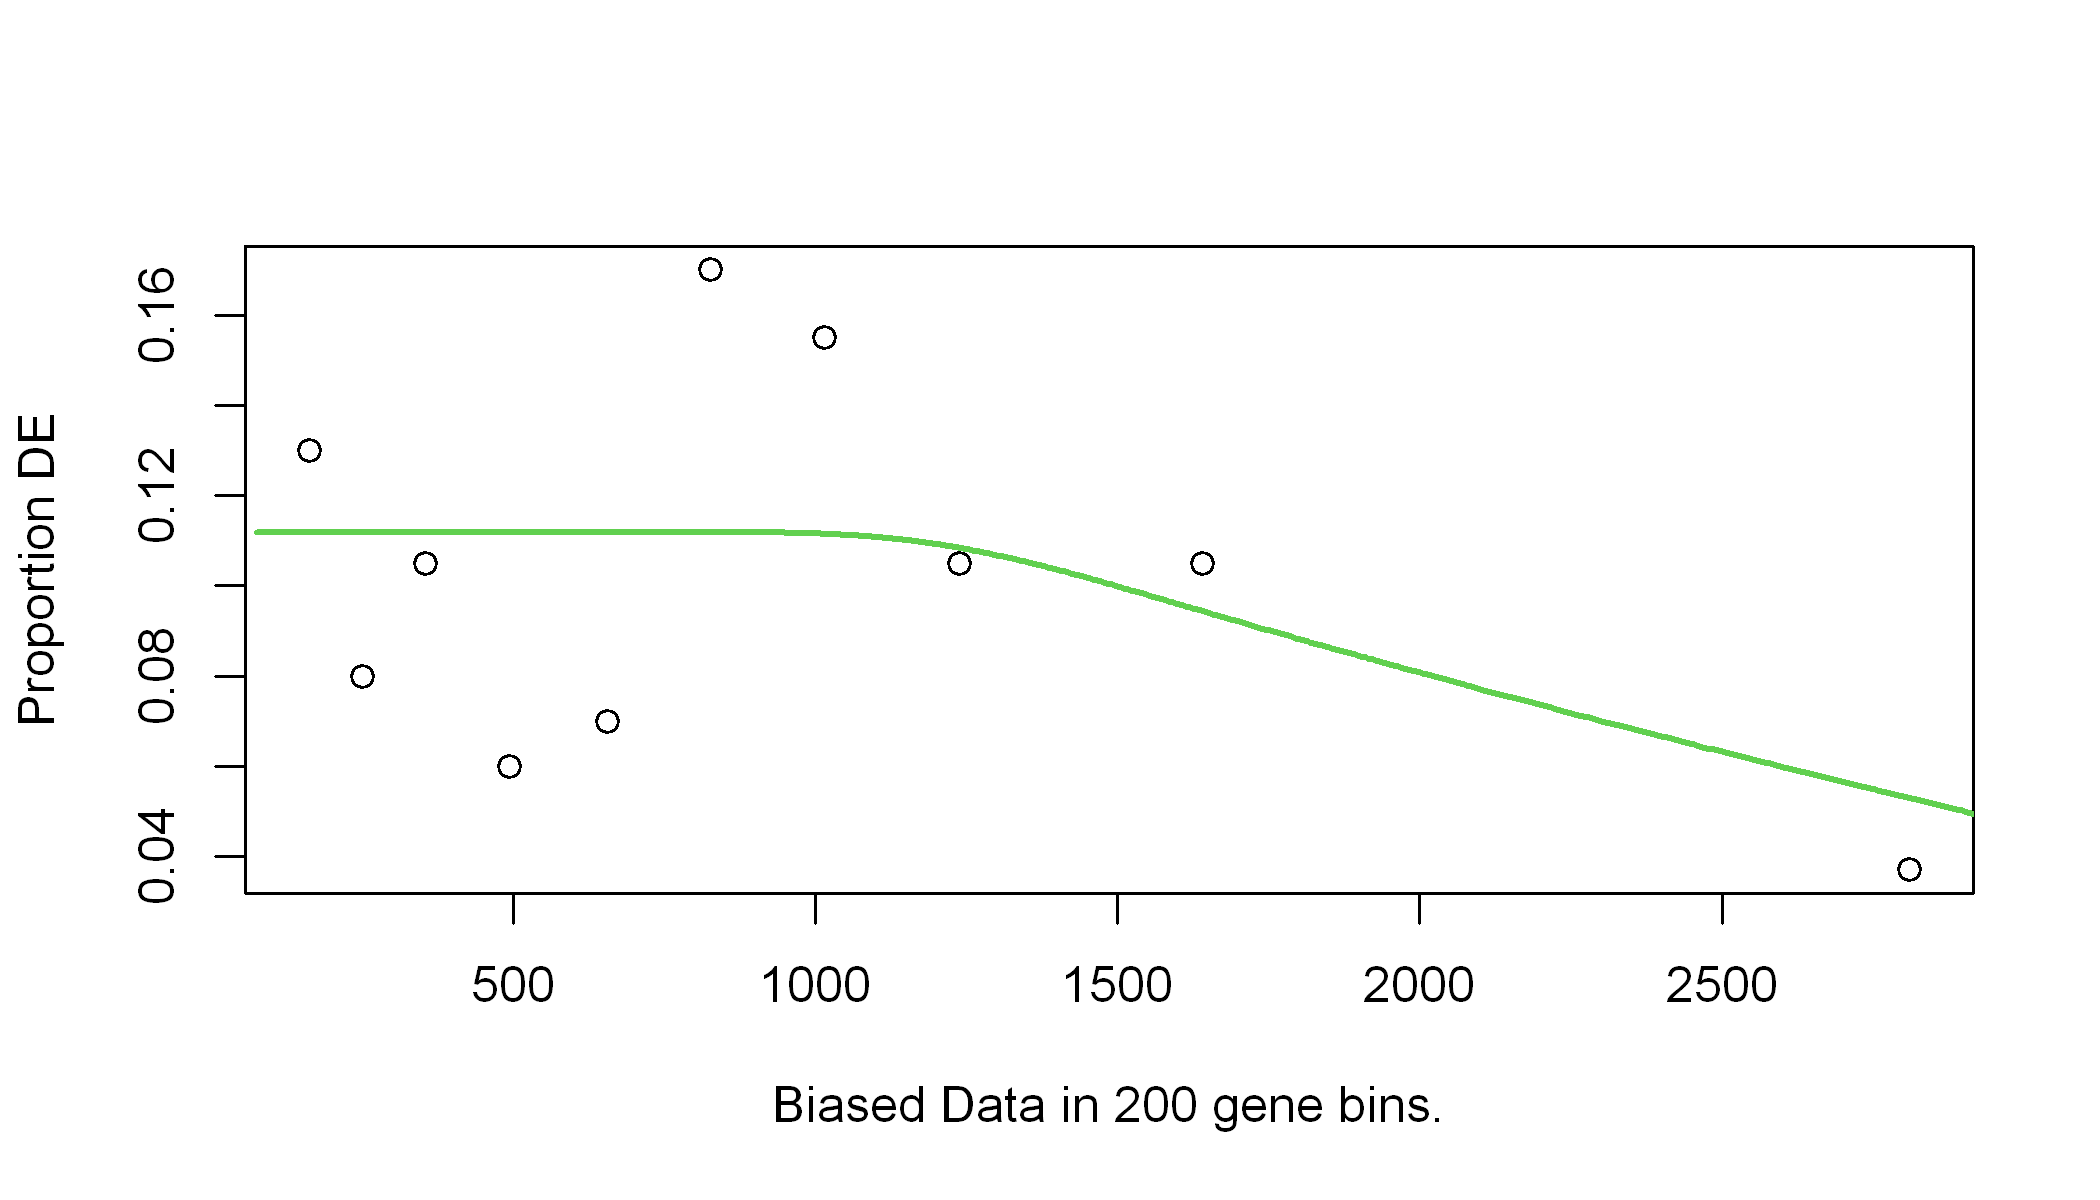

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


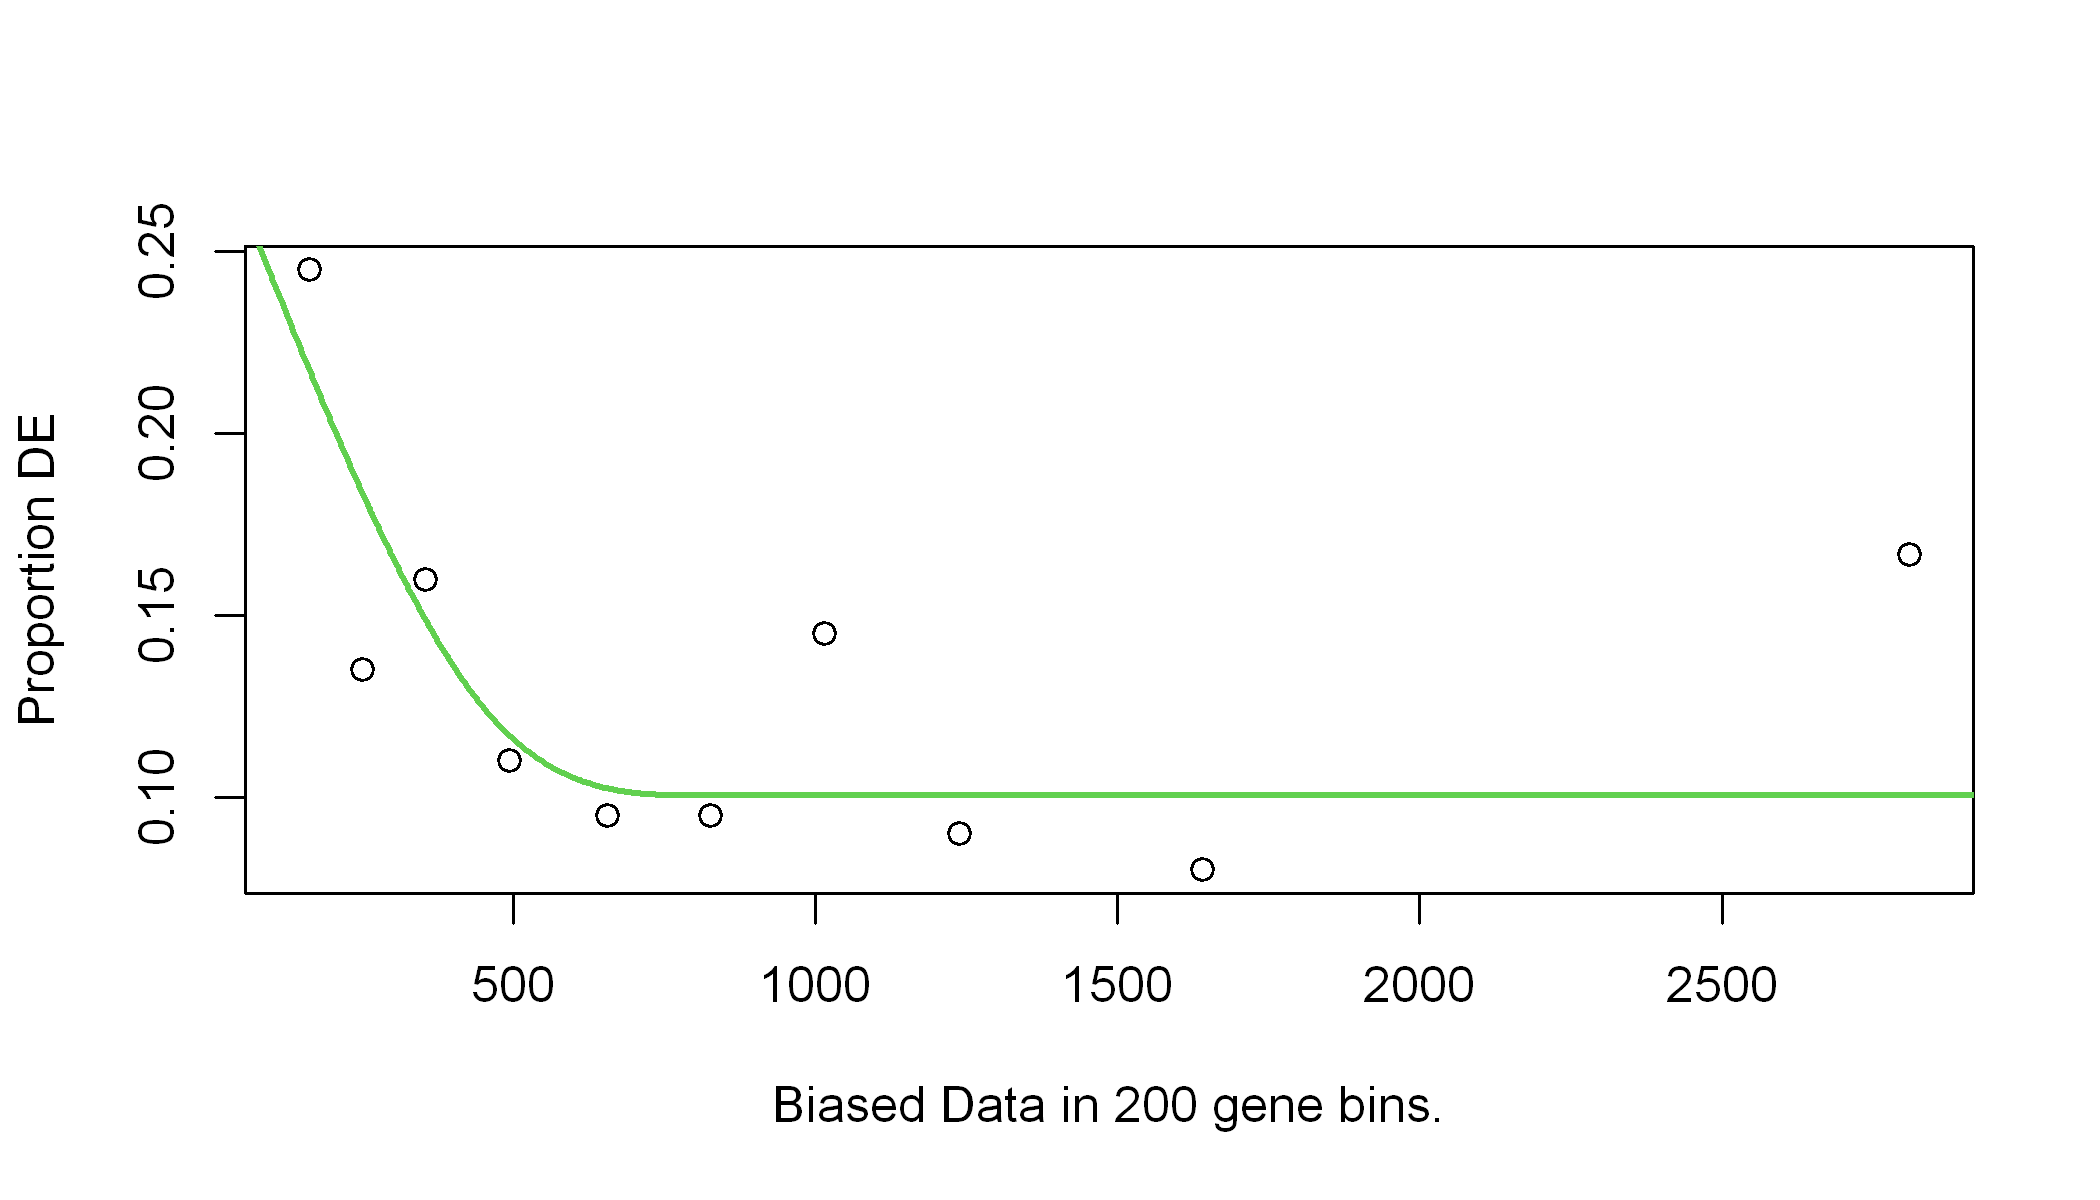

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


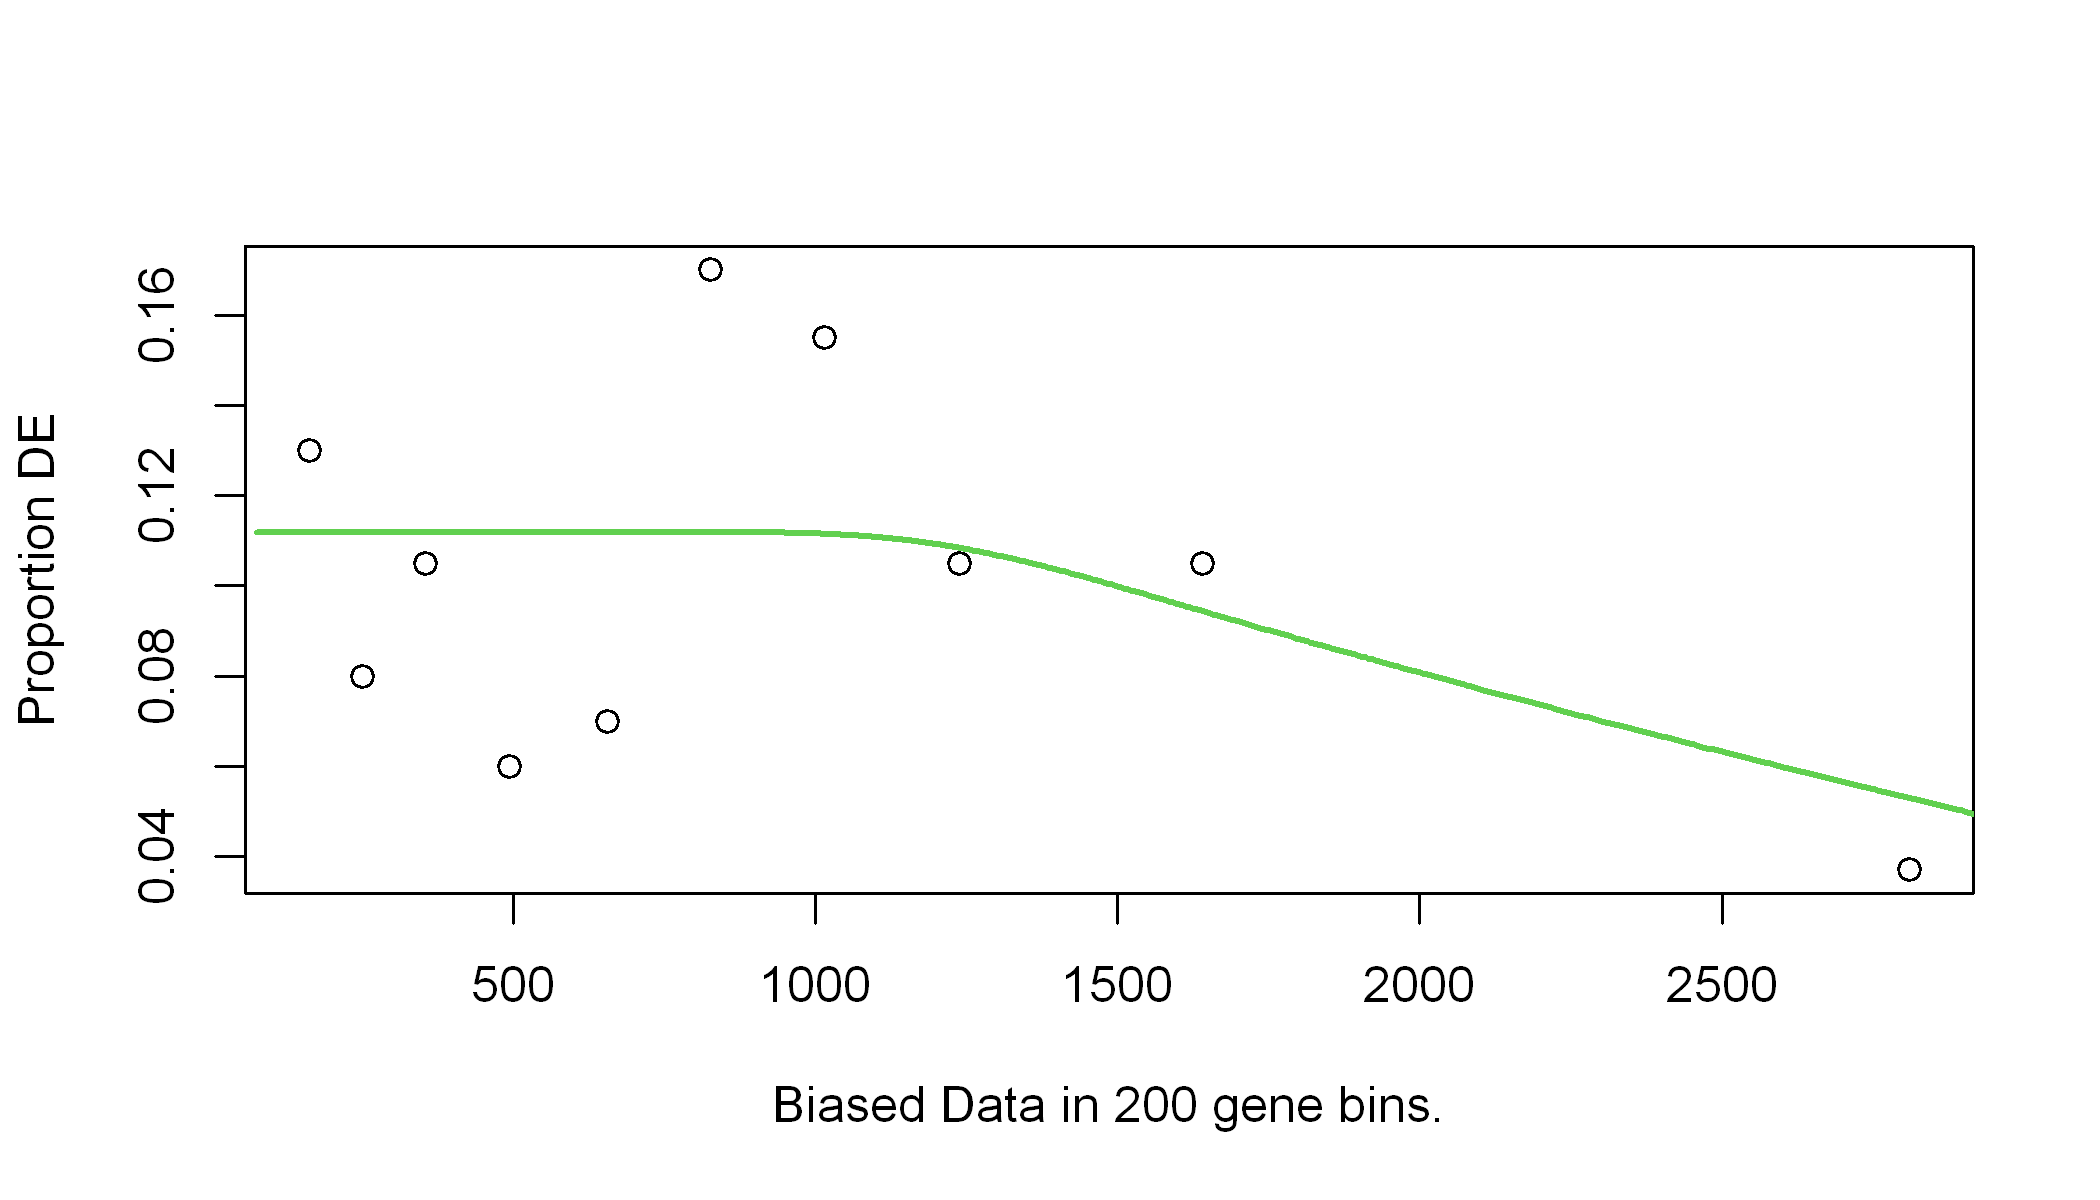

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


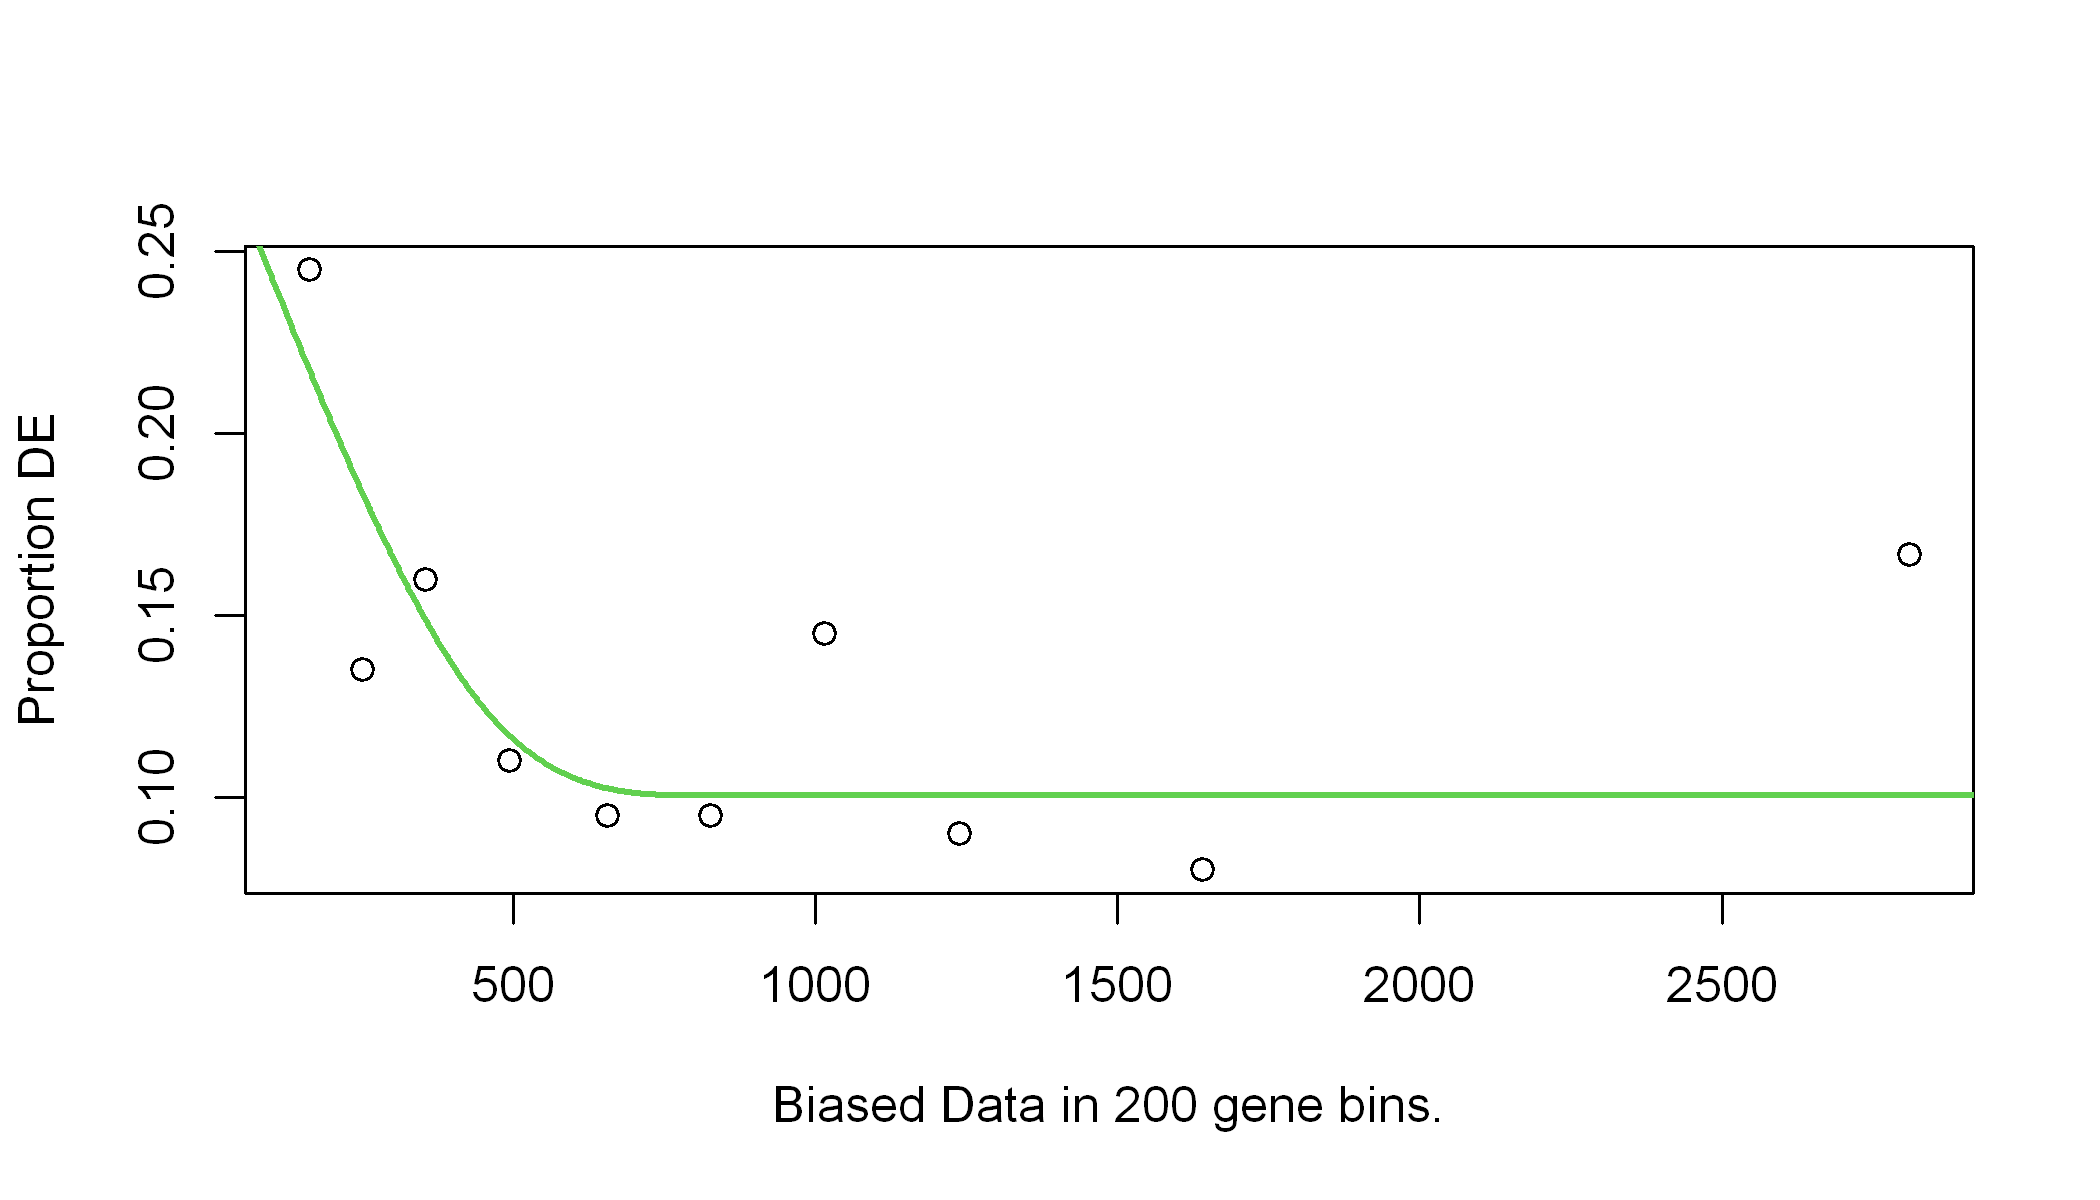

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


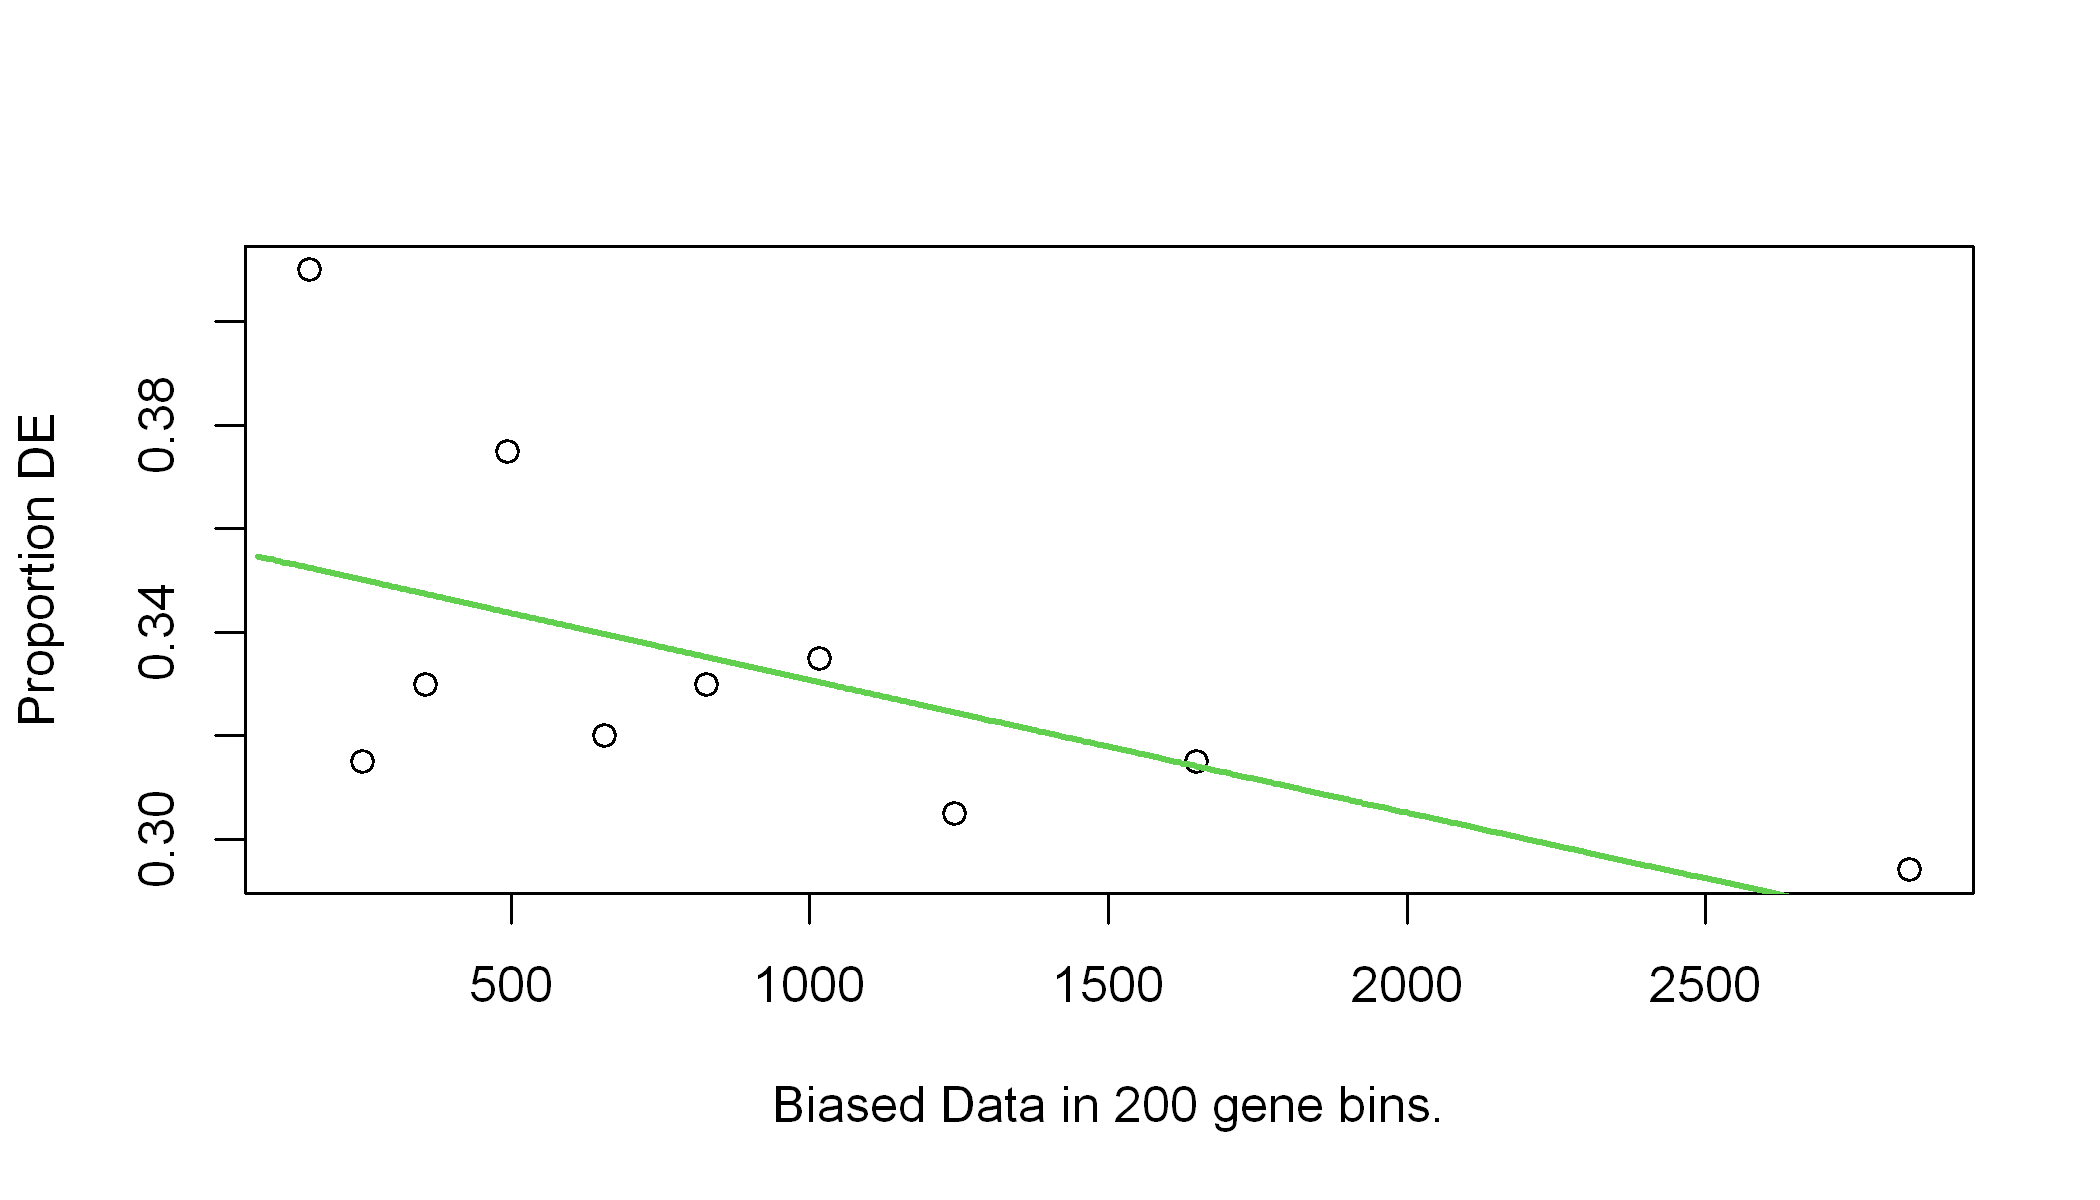

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


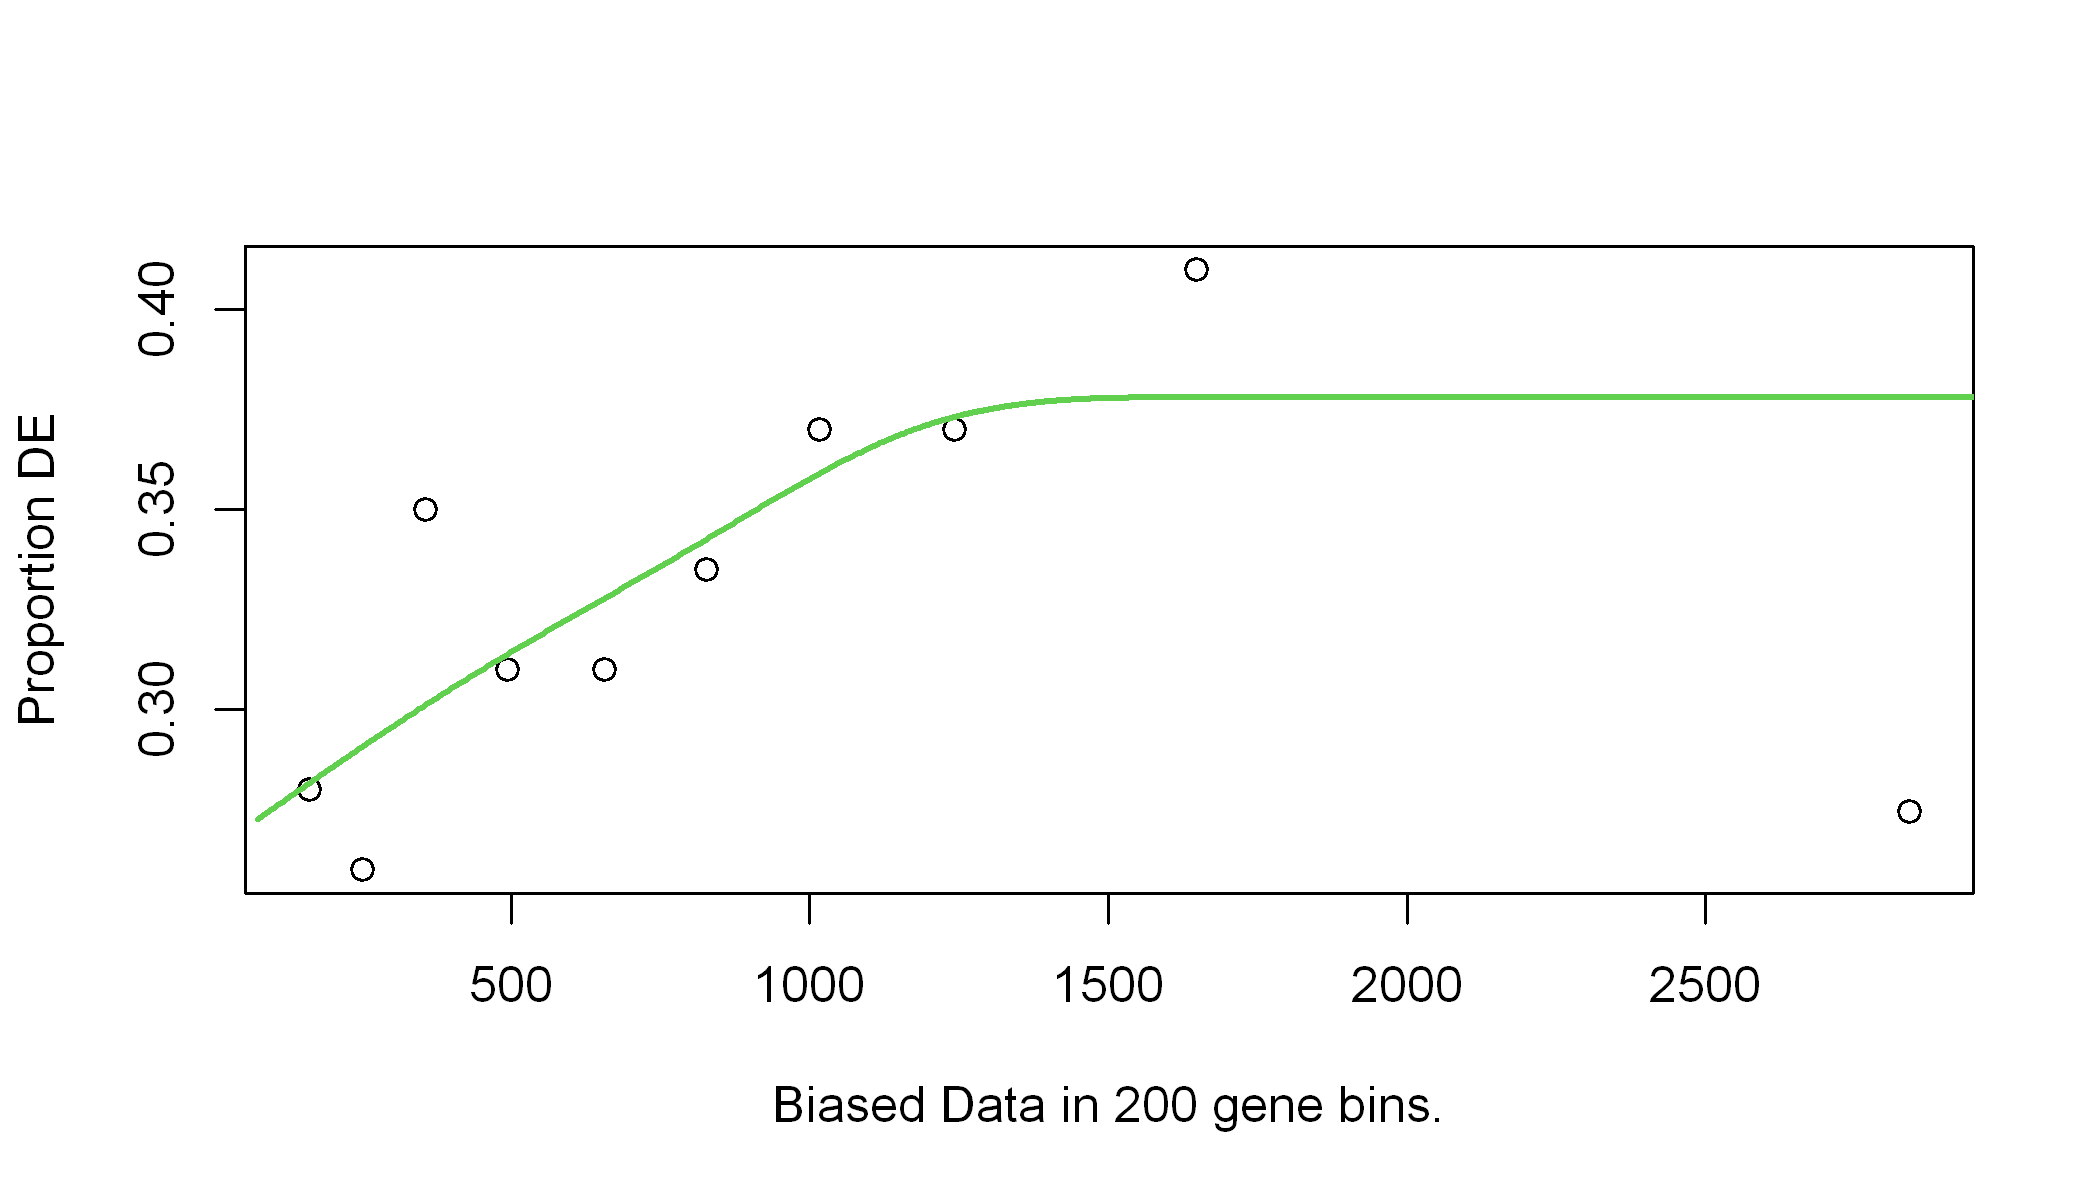

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


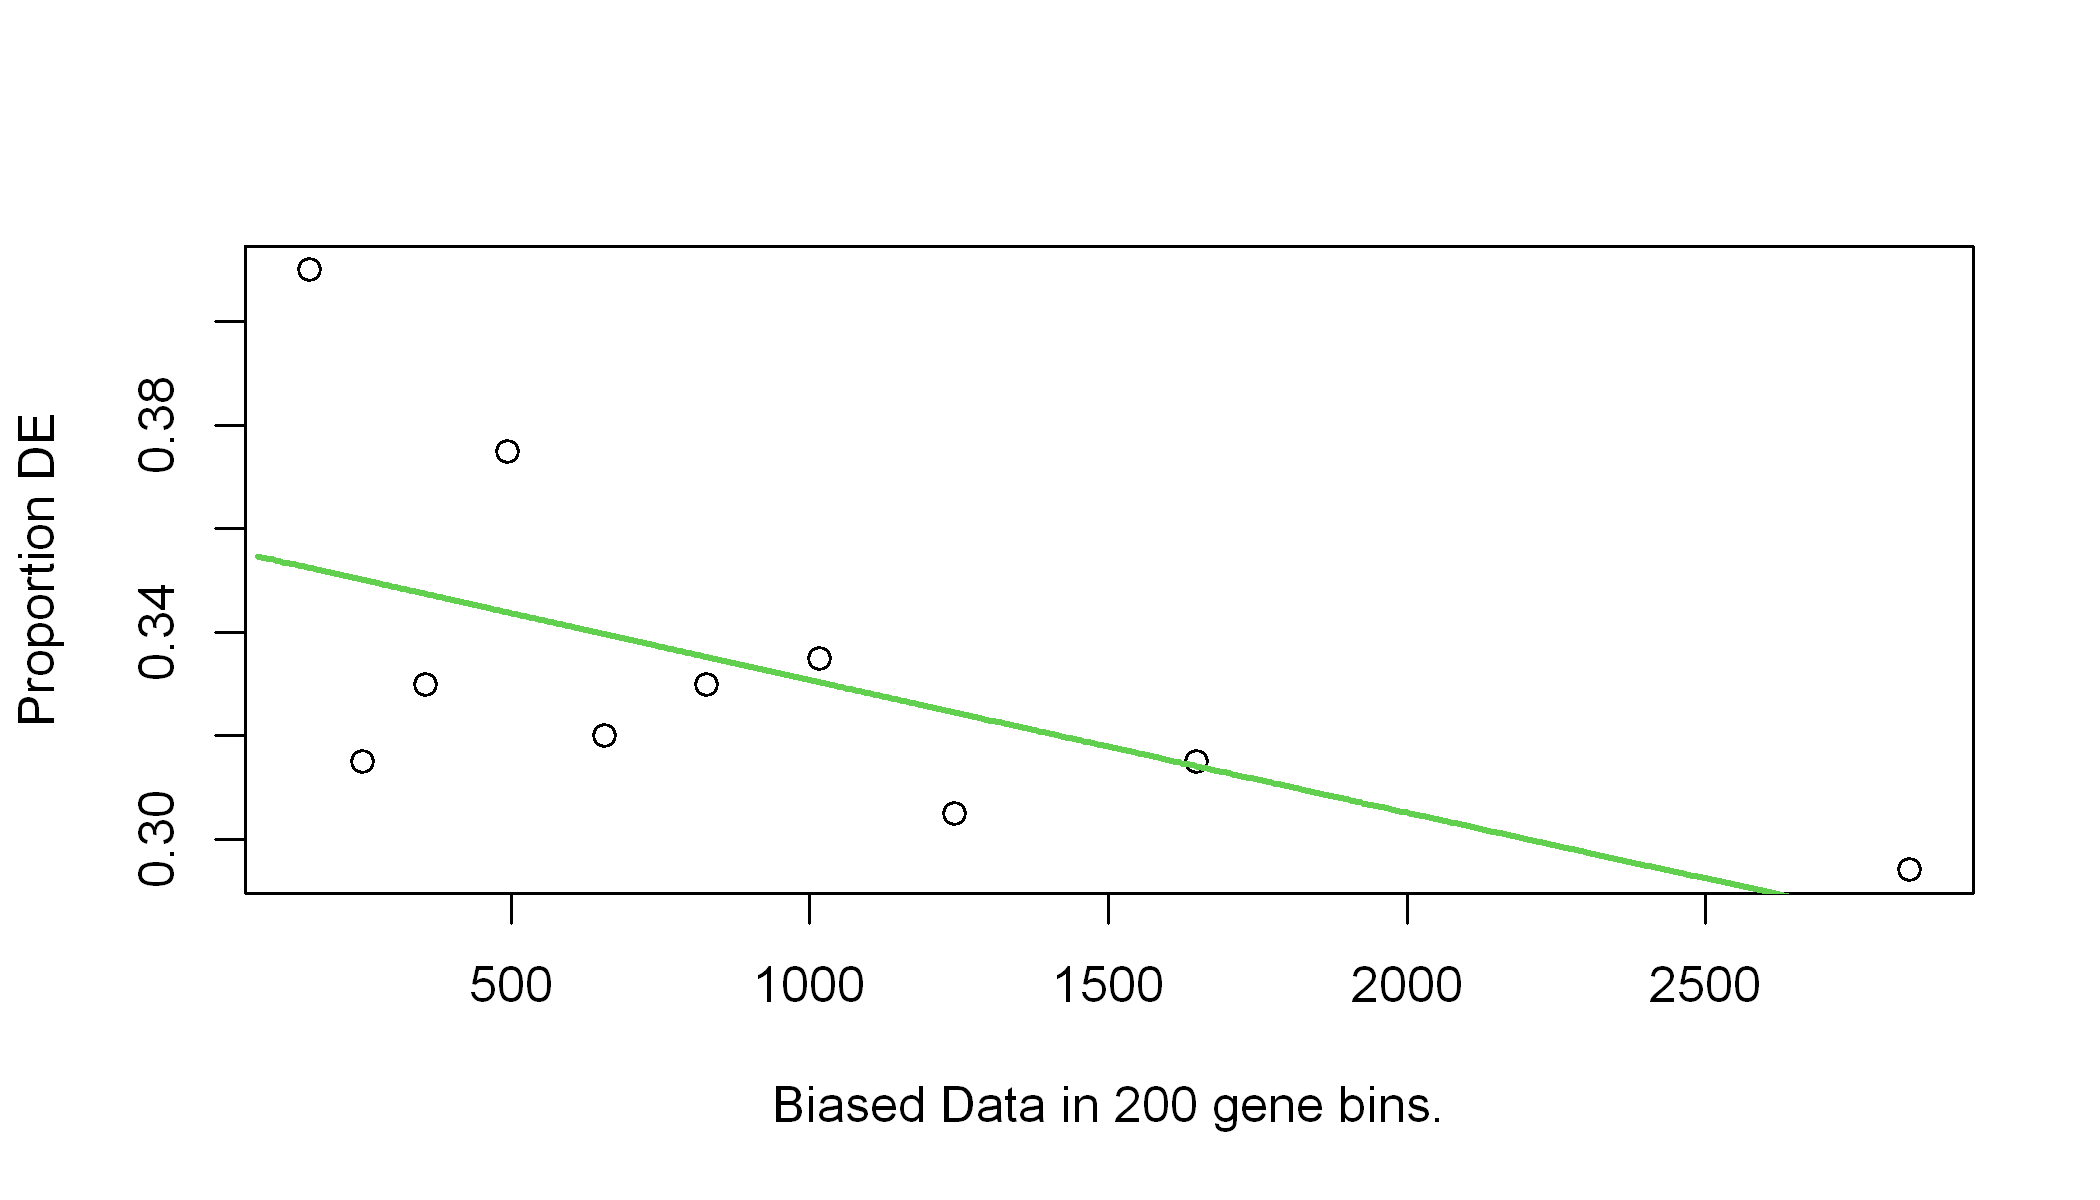

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


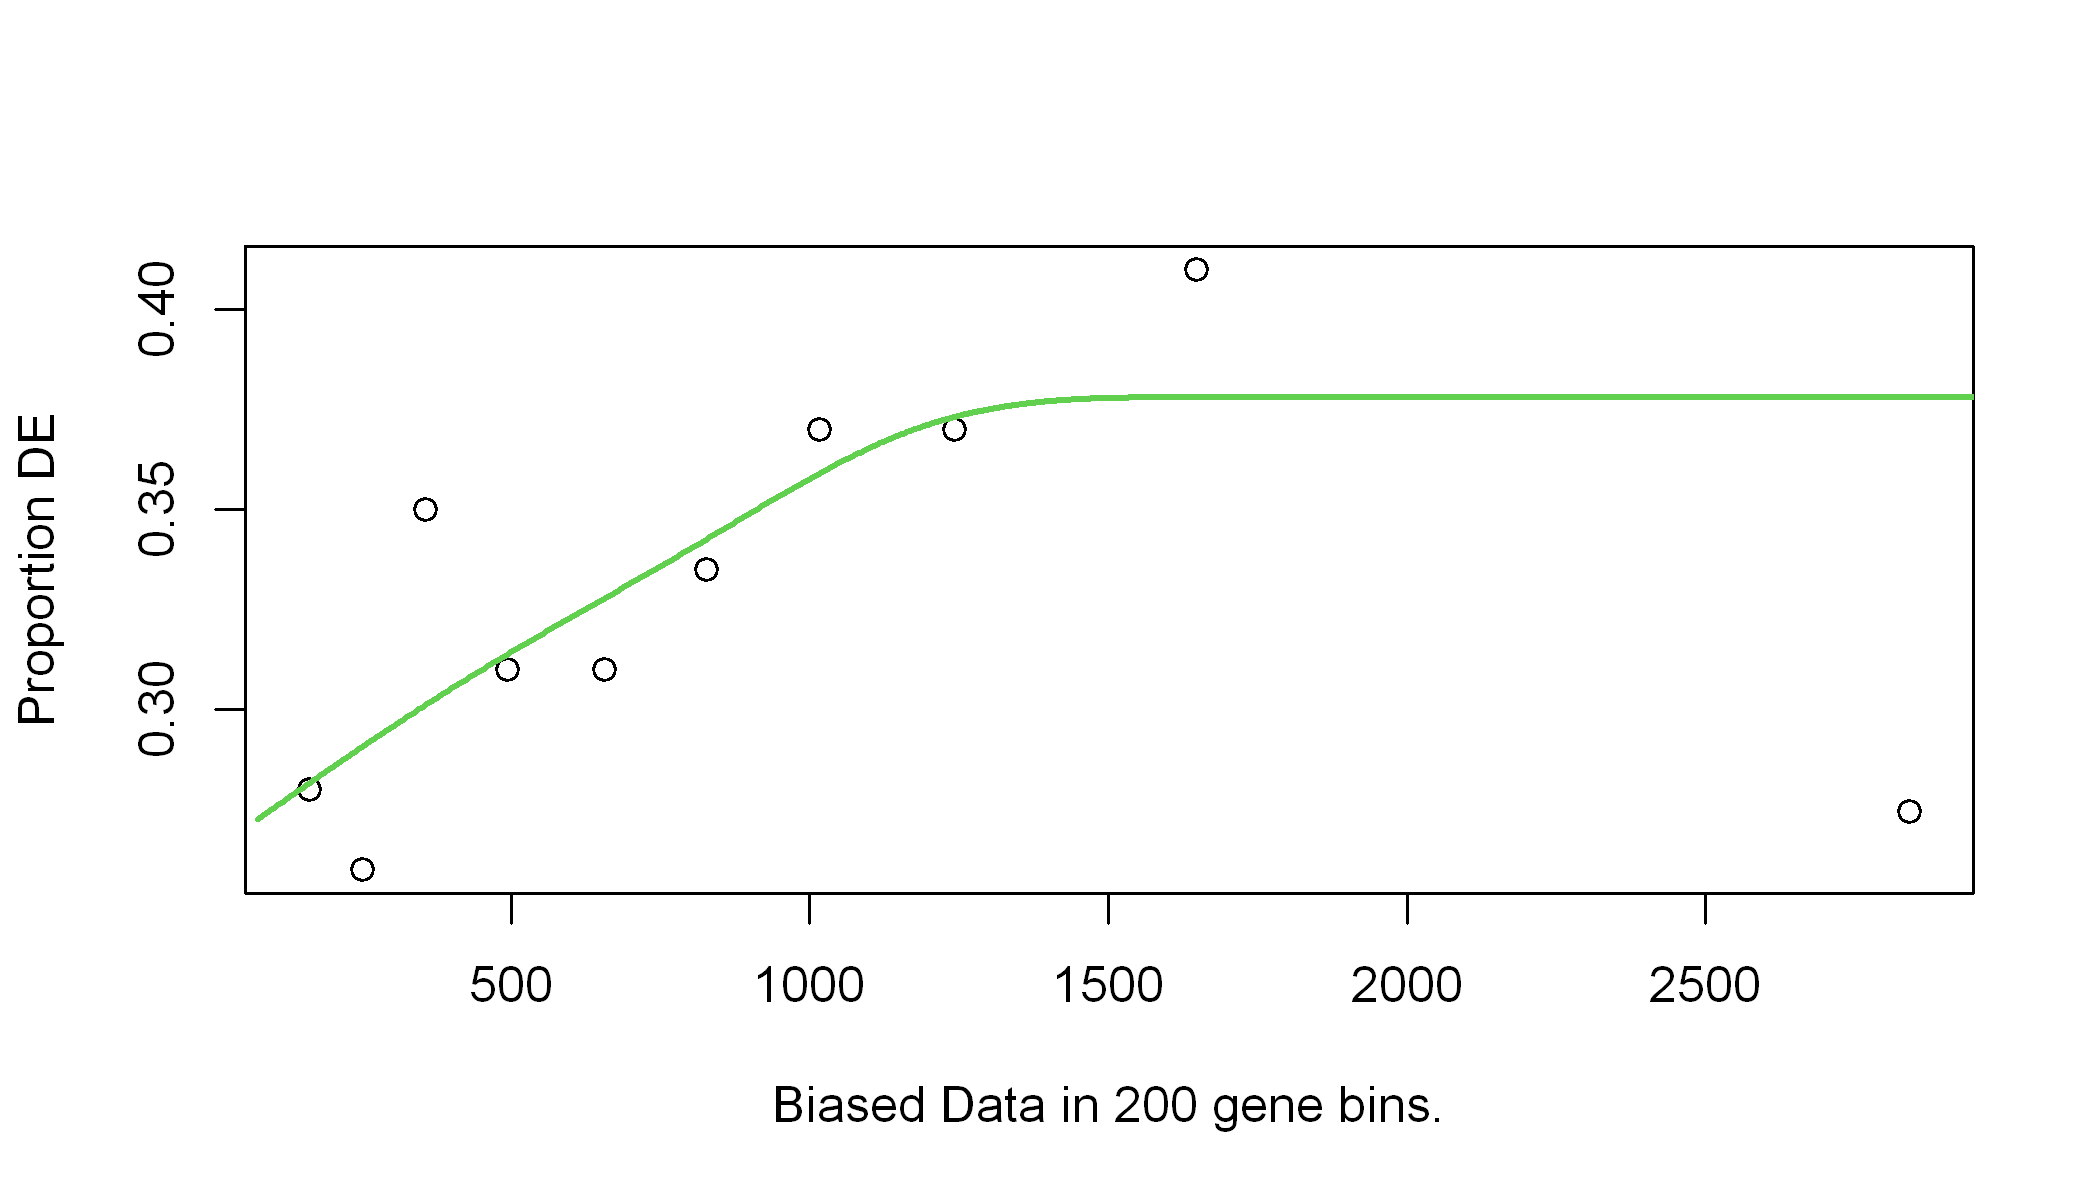

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


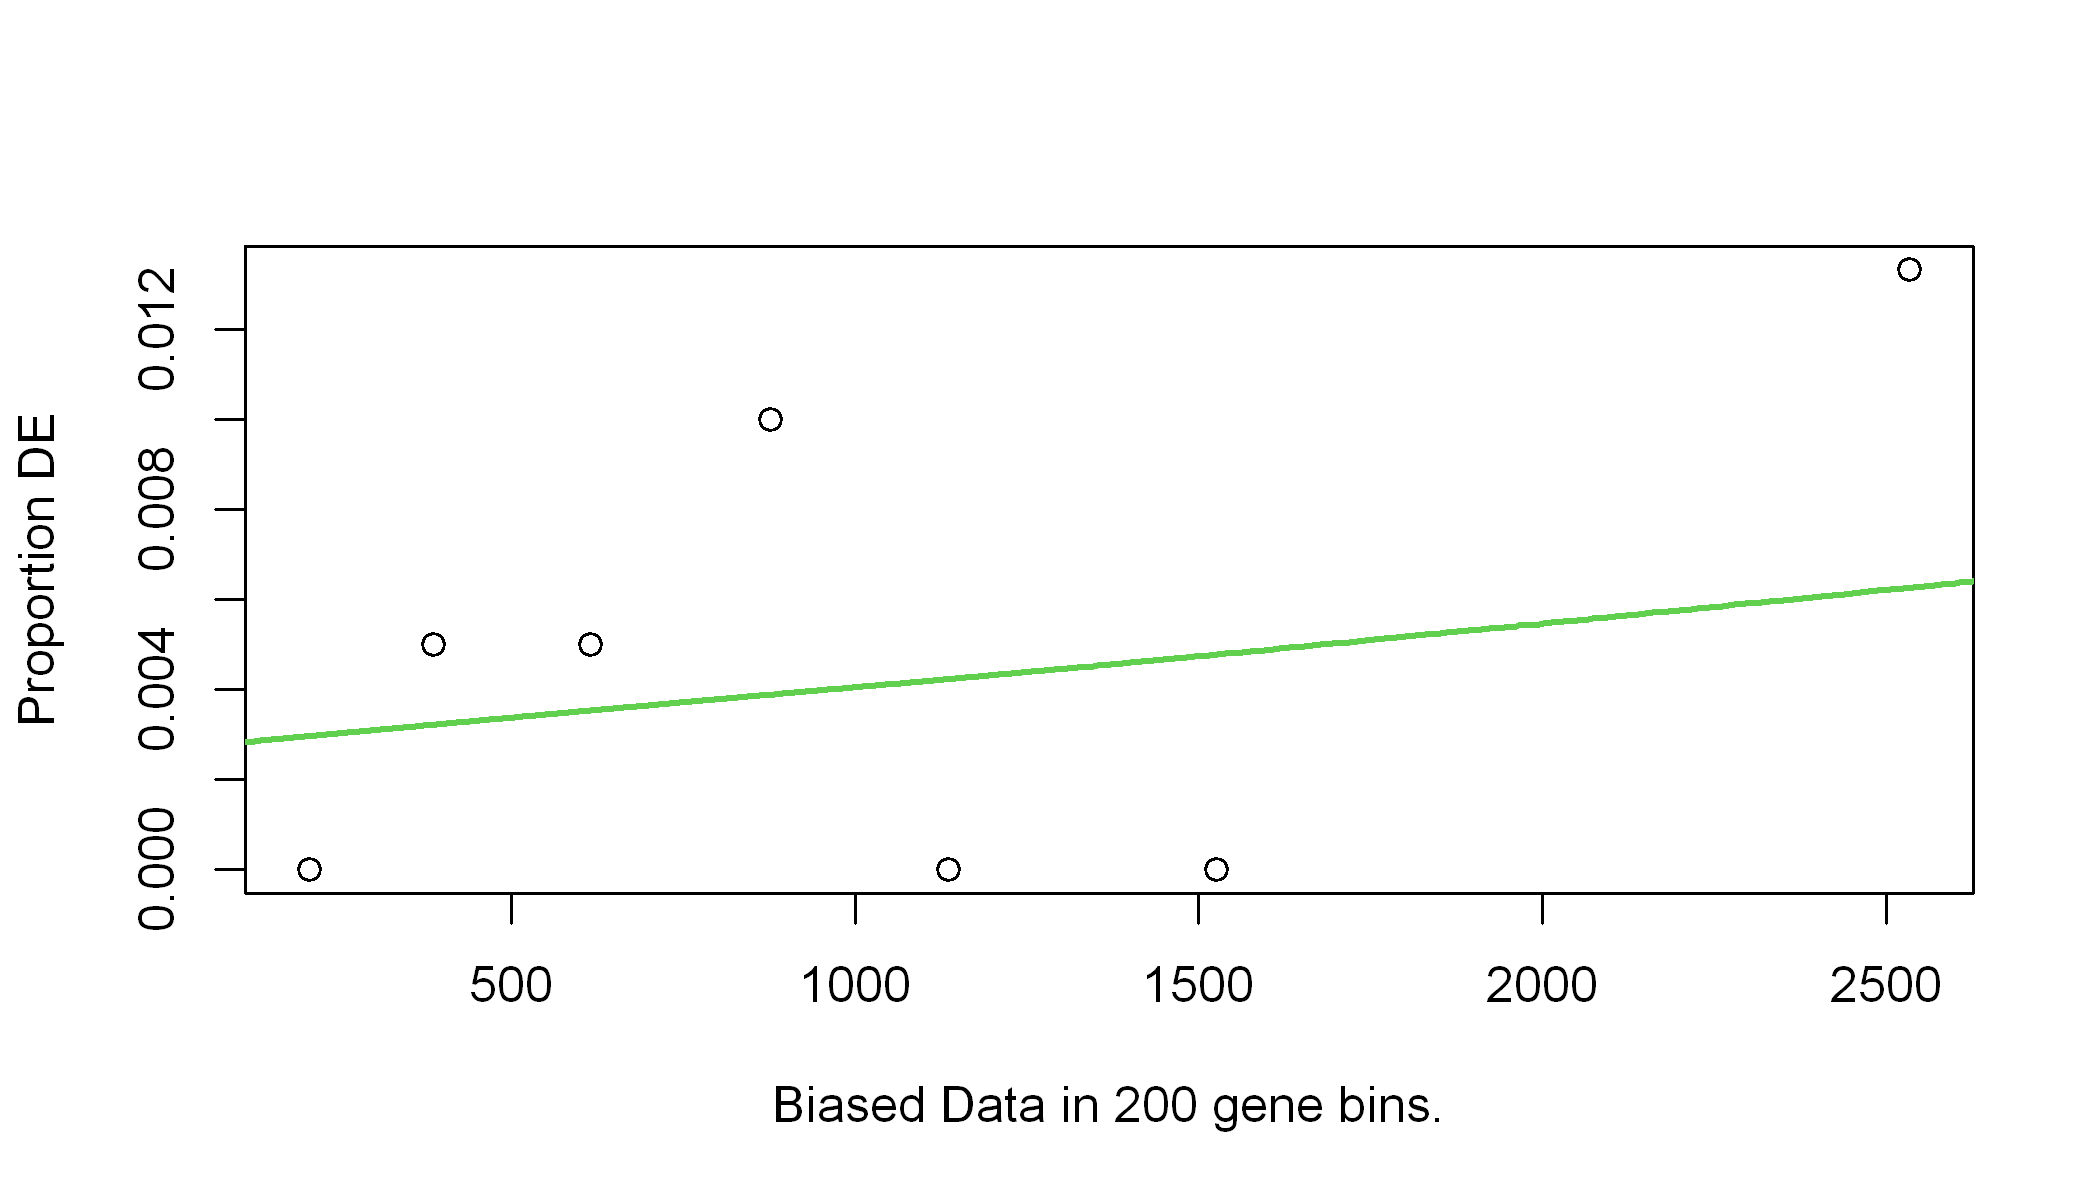

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


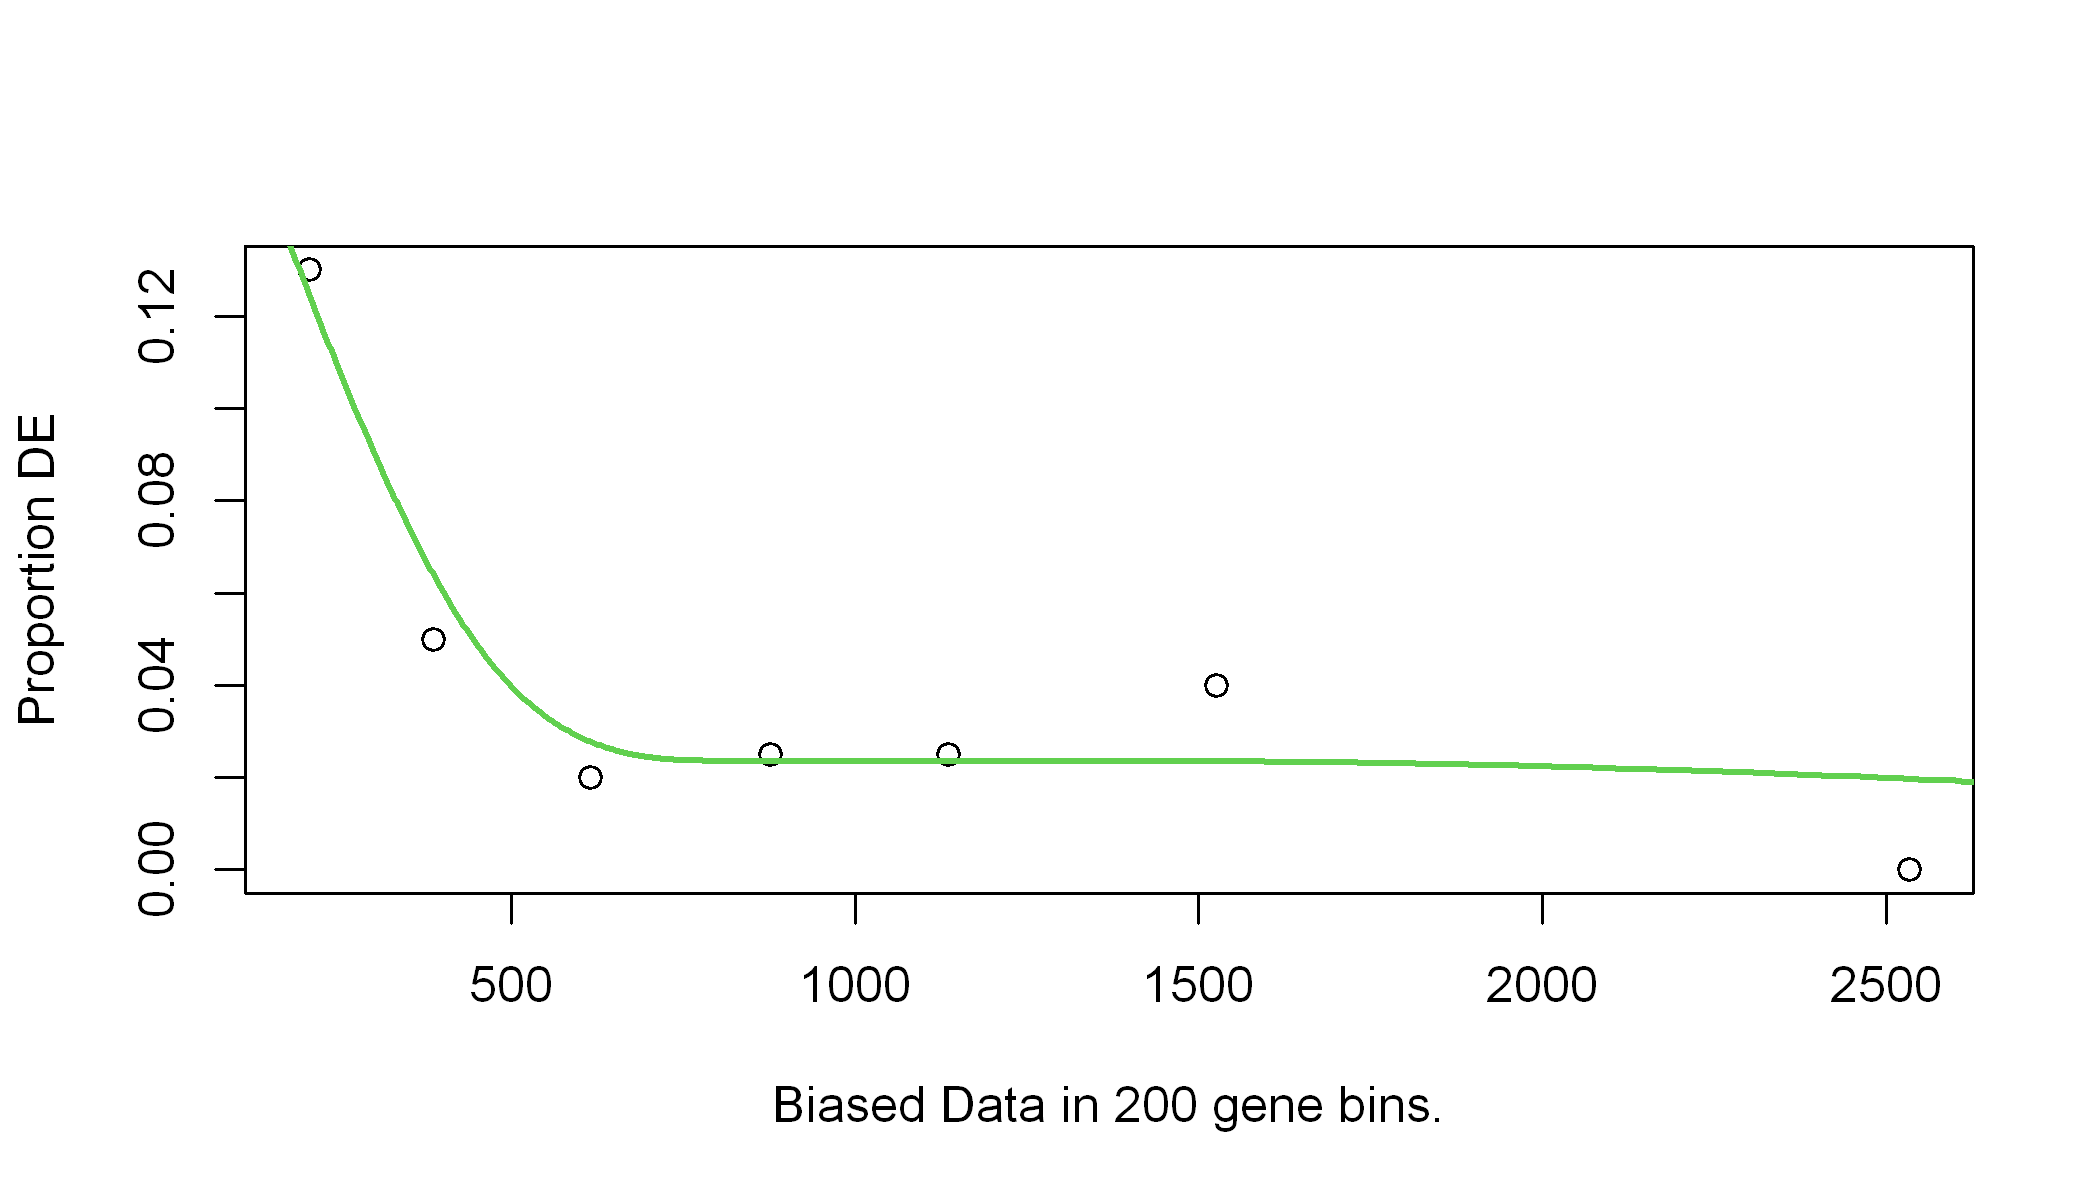

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


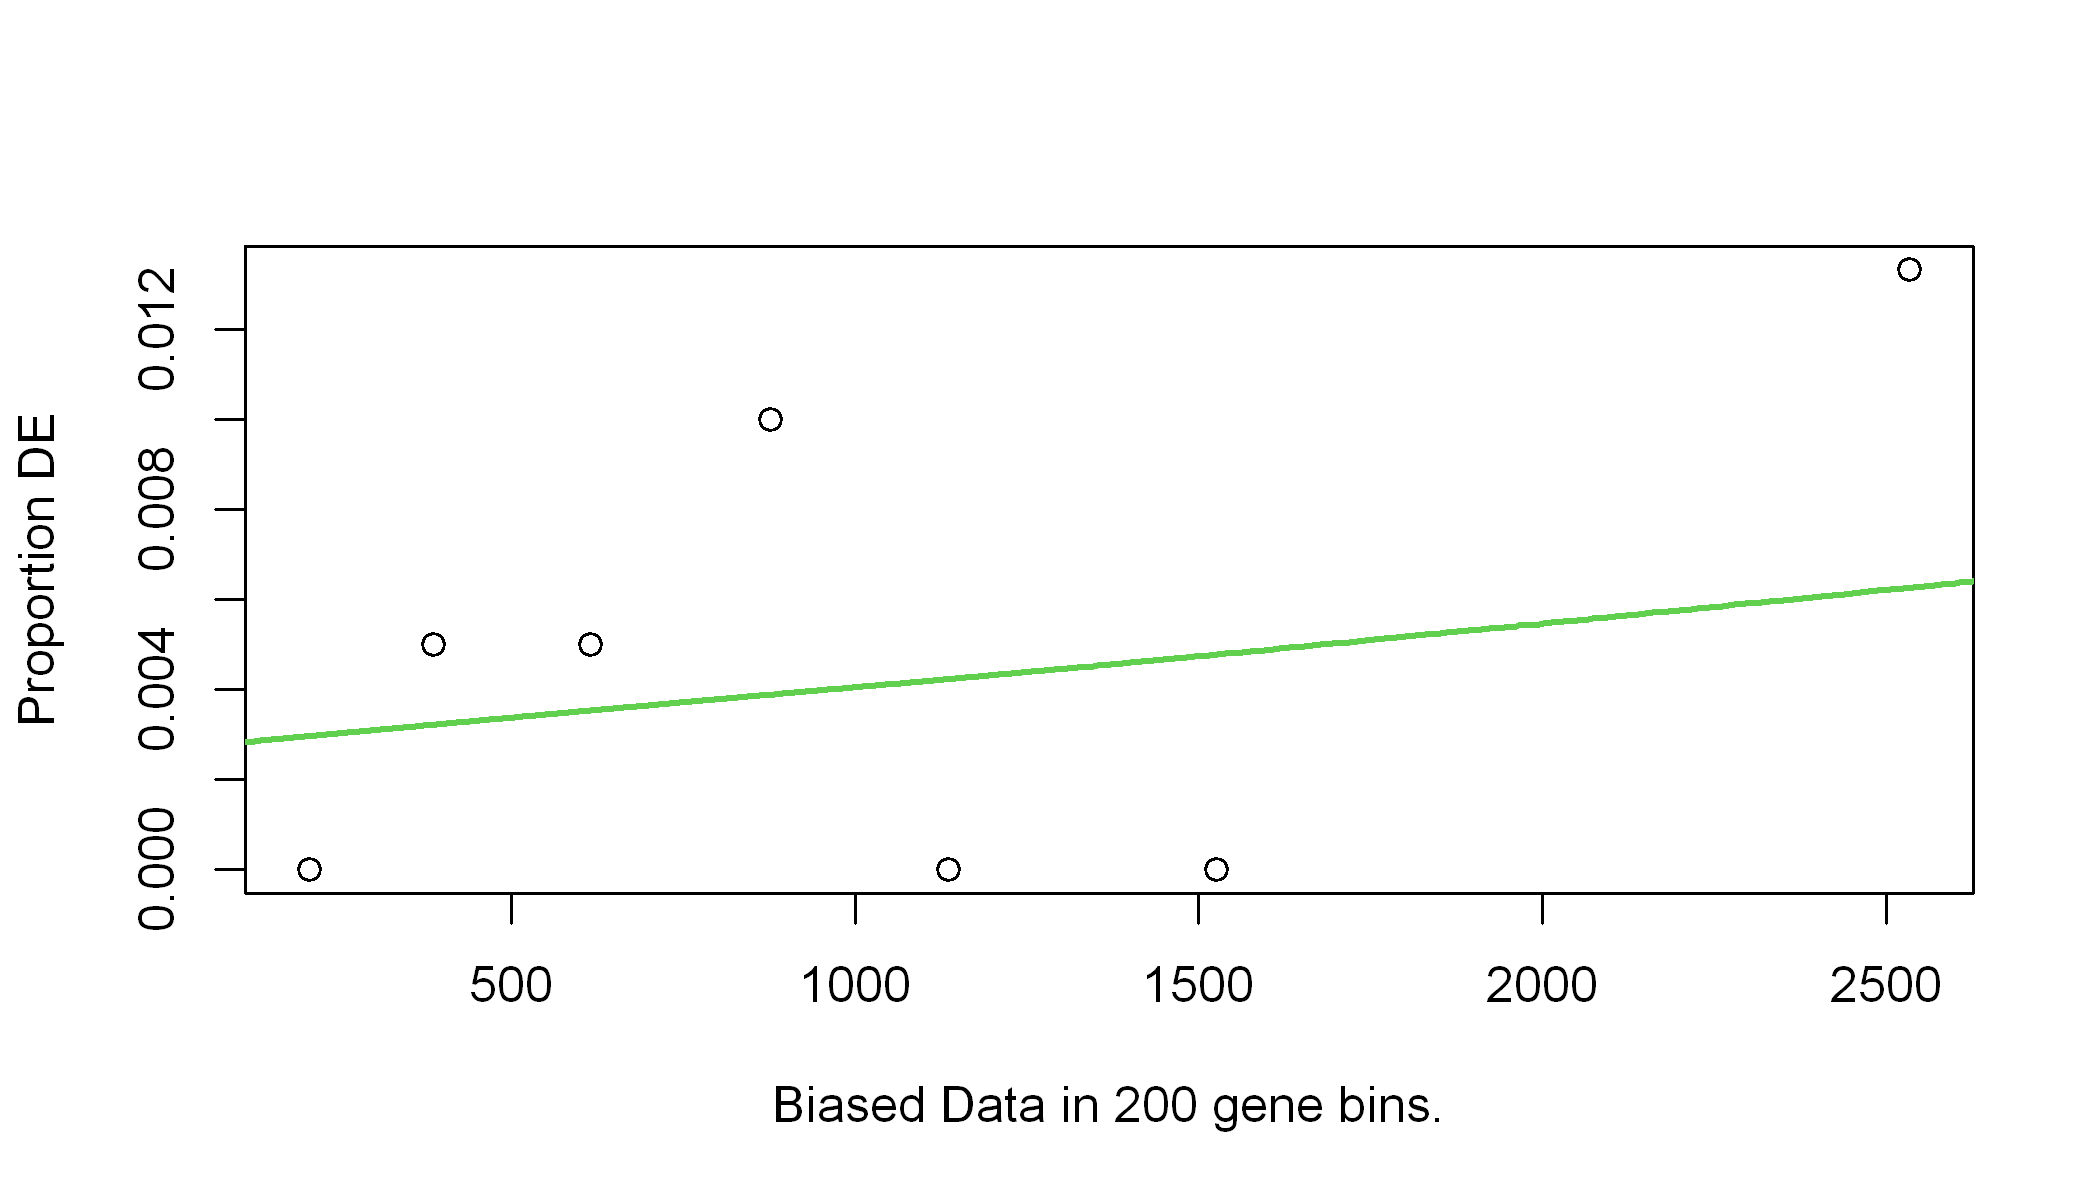

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


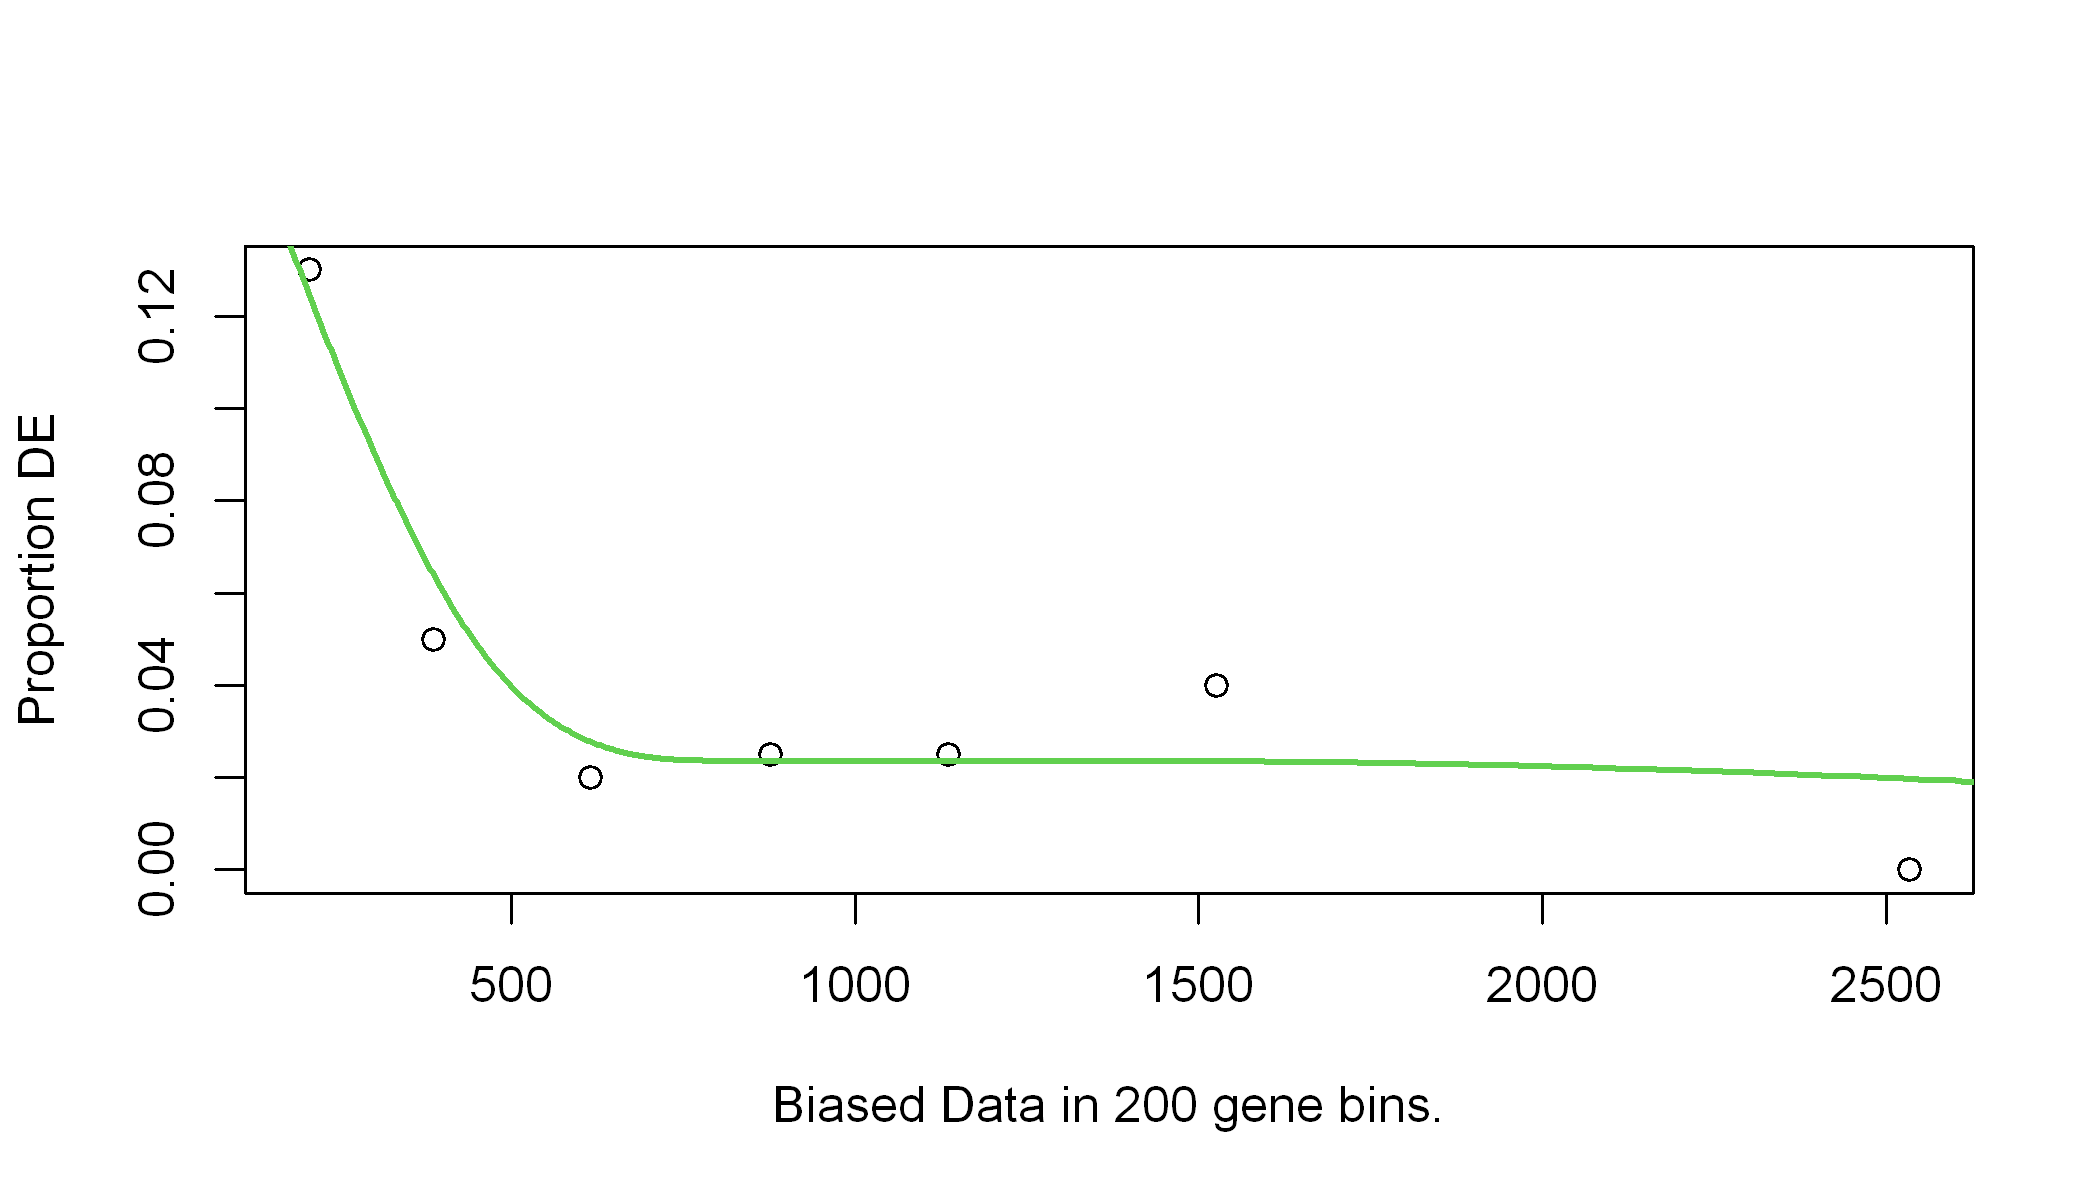

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


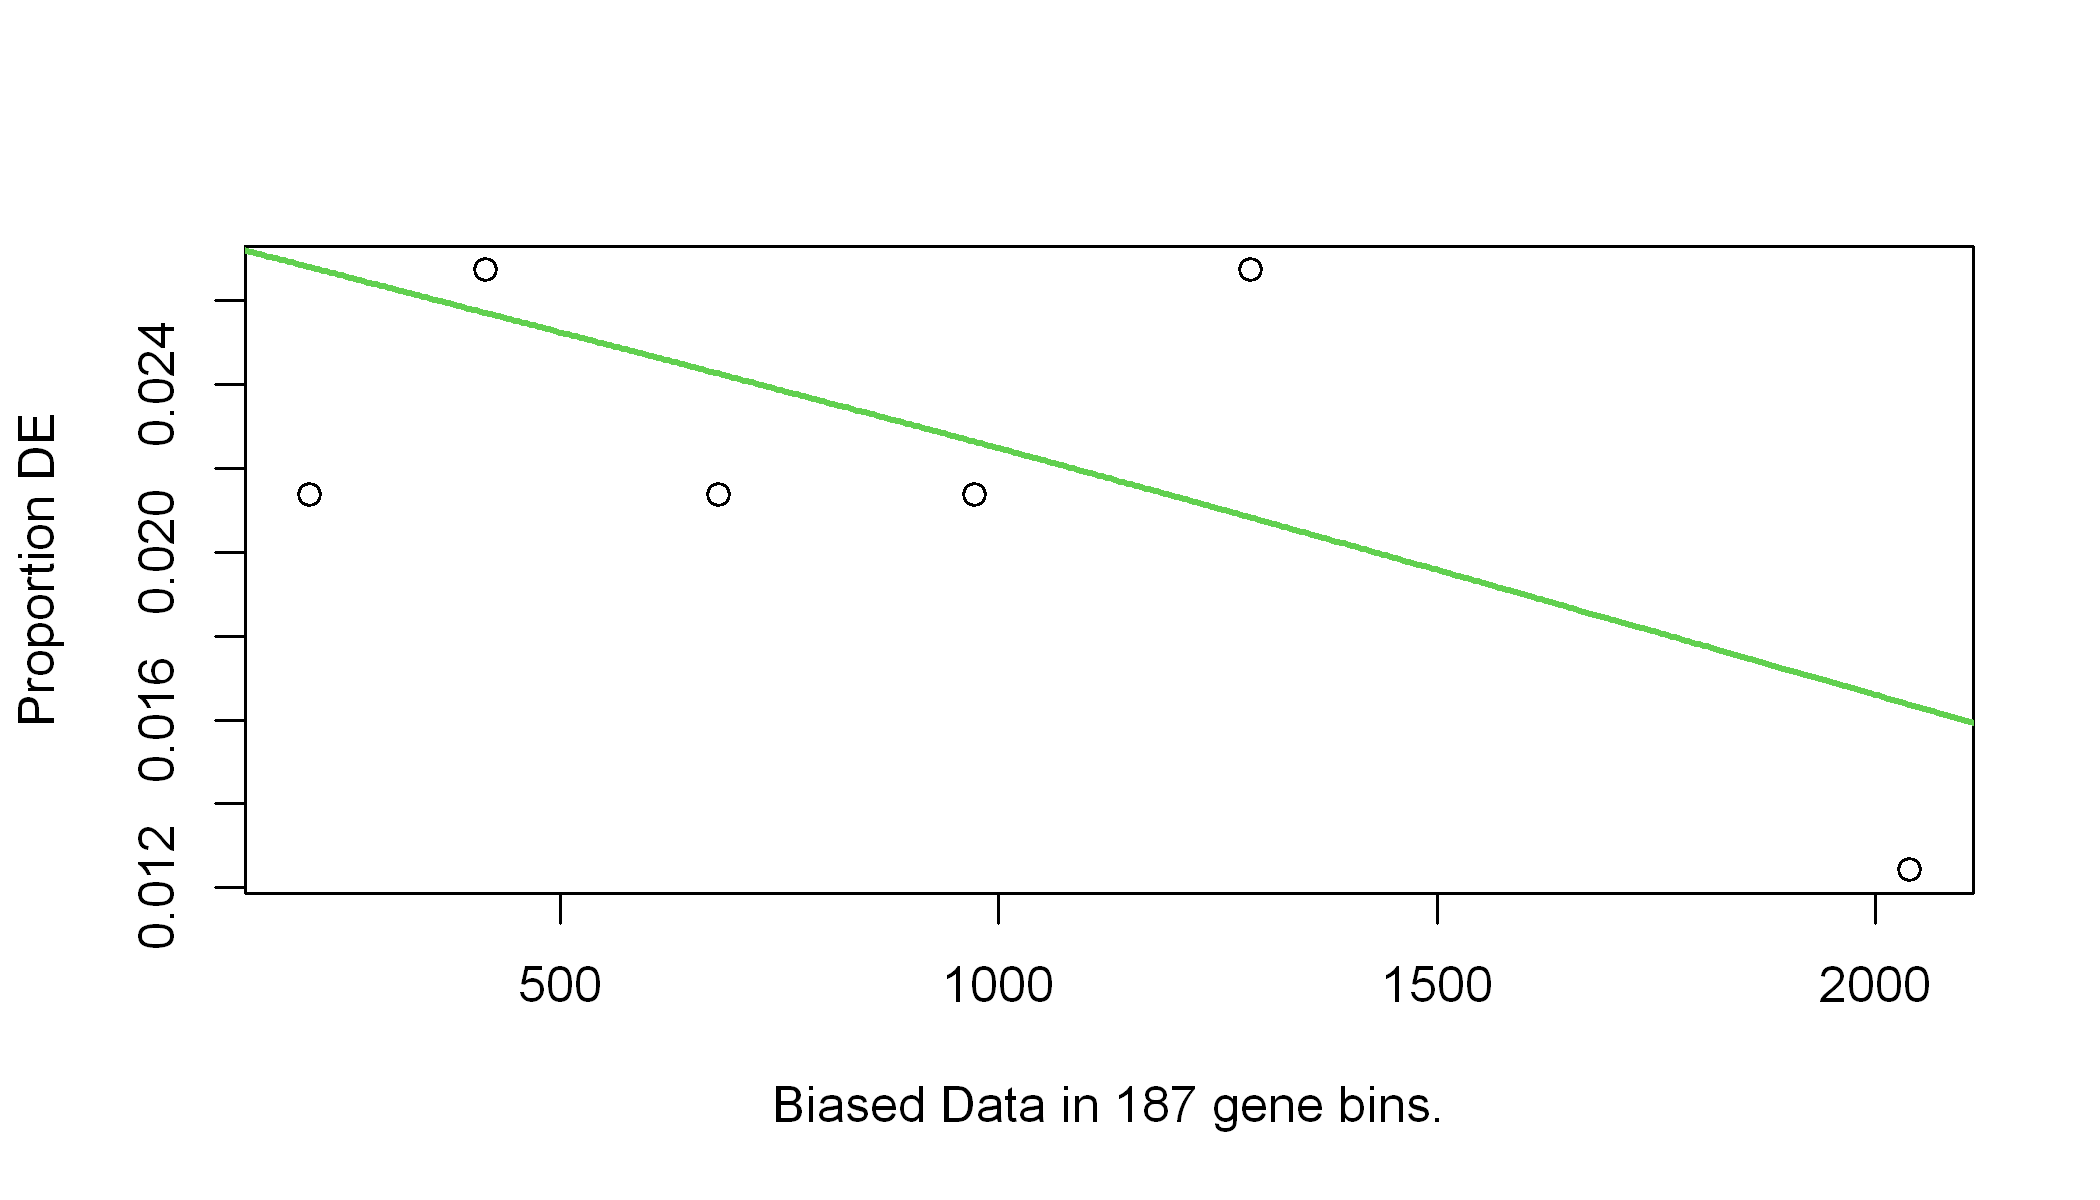

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


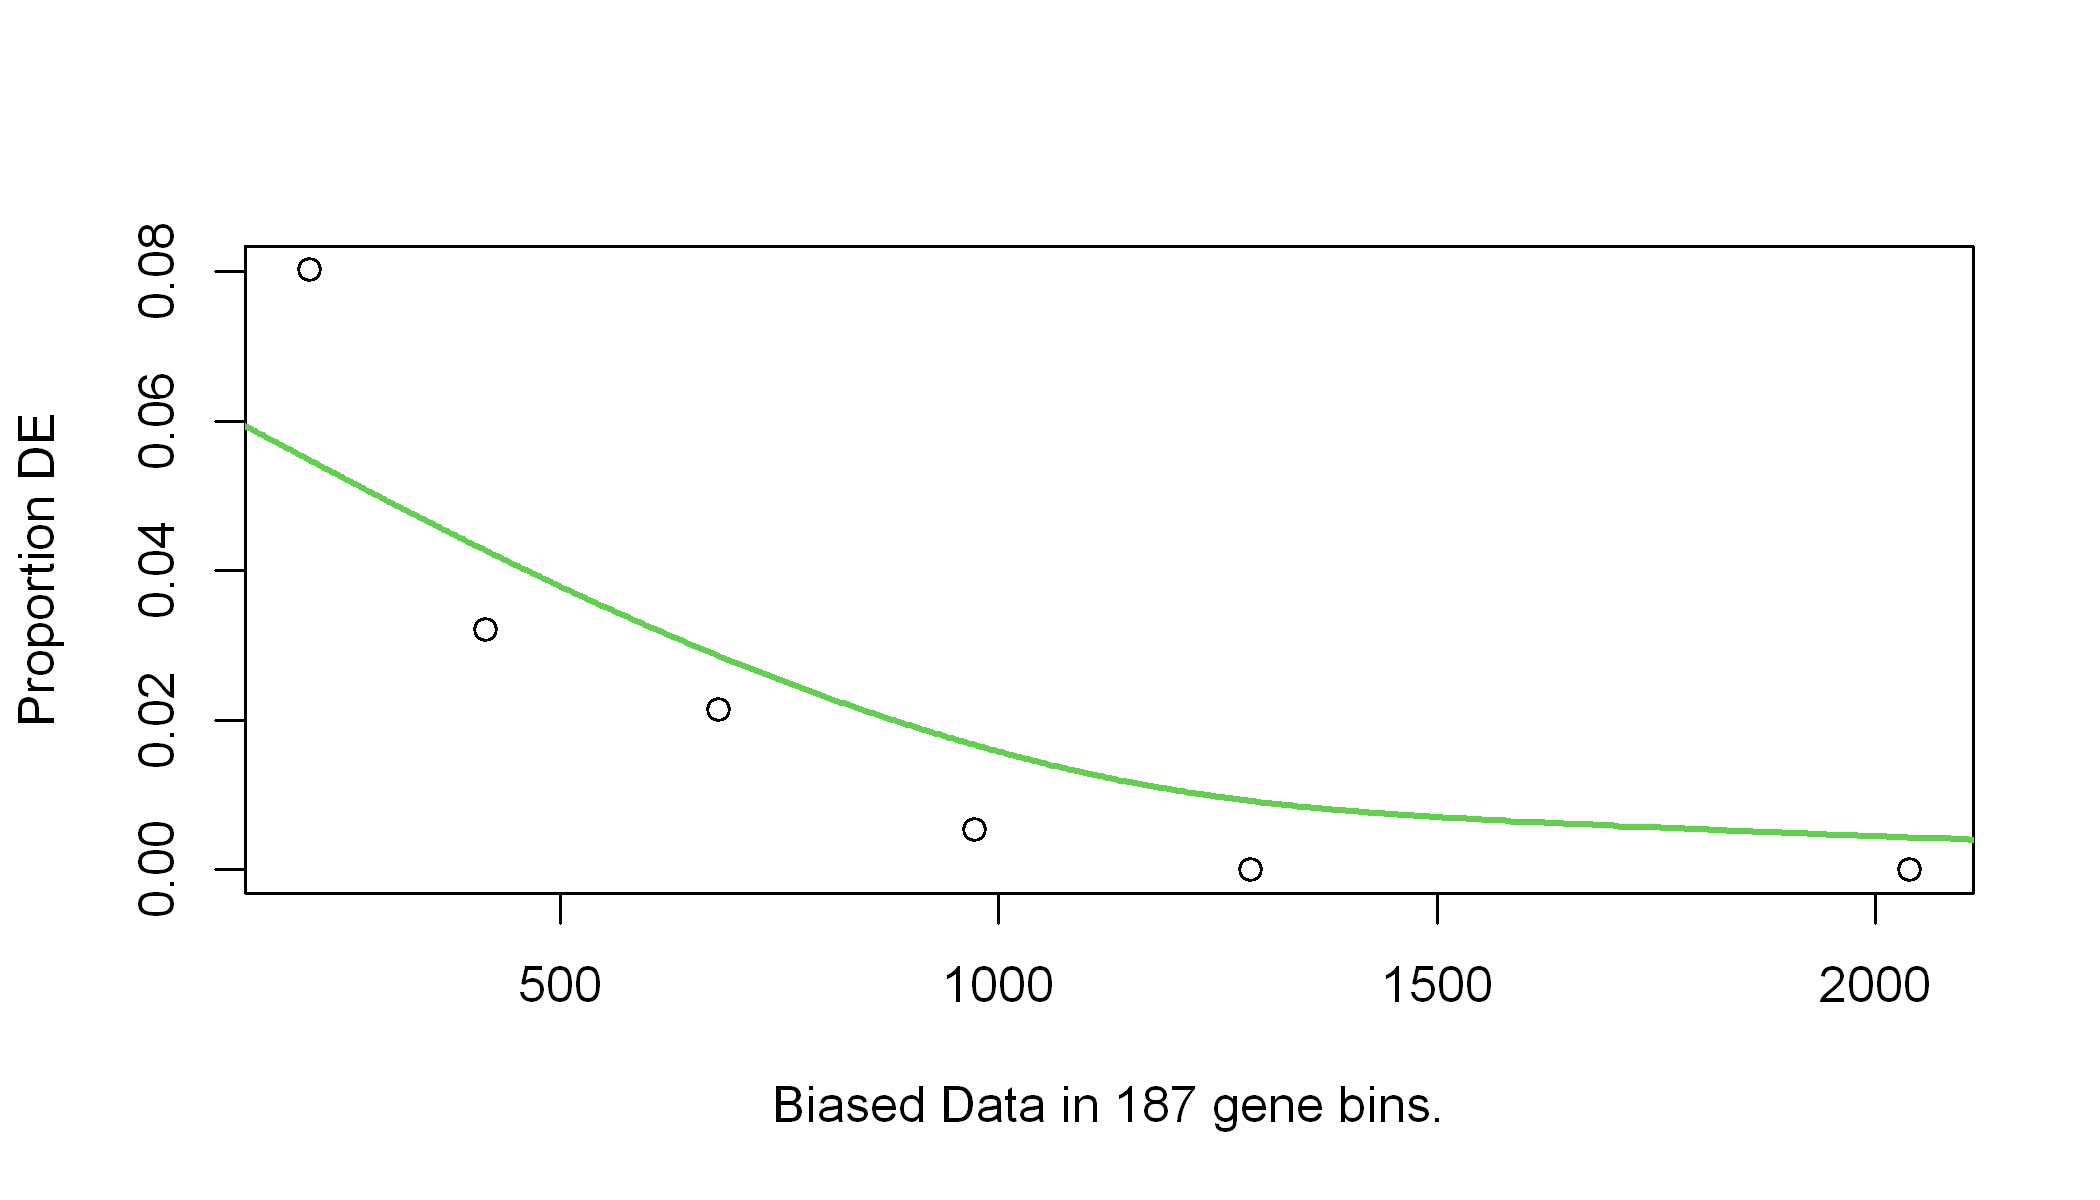

Using manually entered categories.

For 1 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


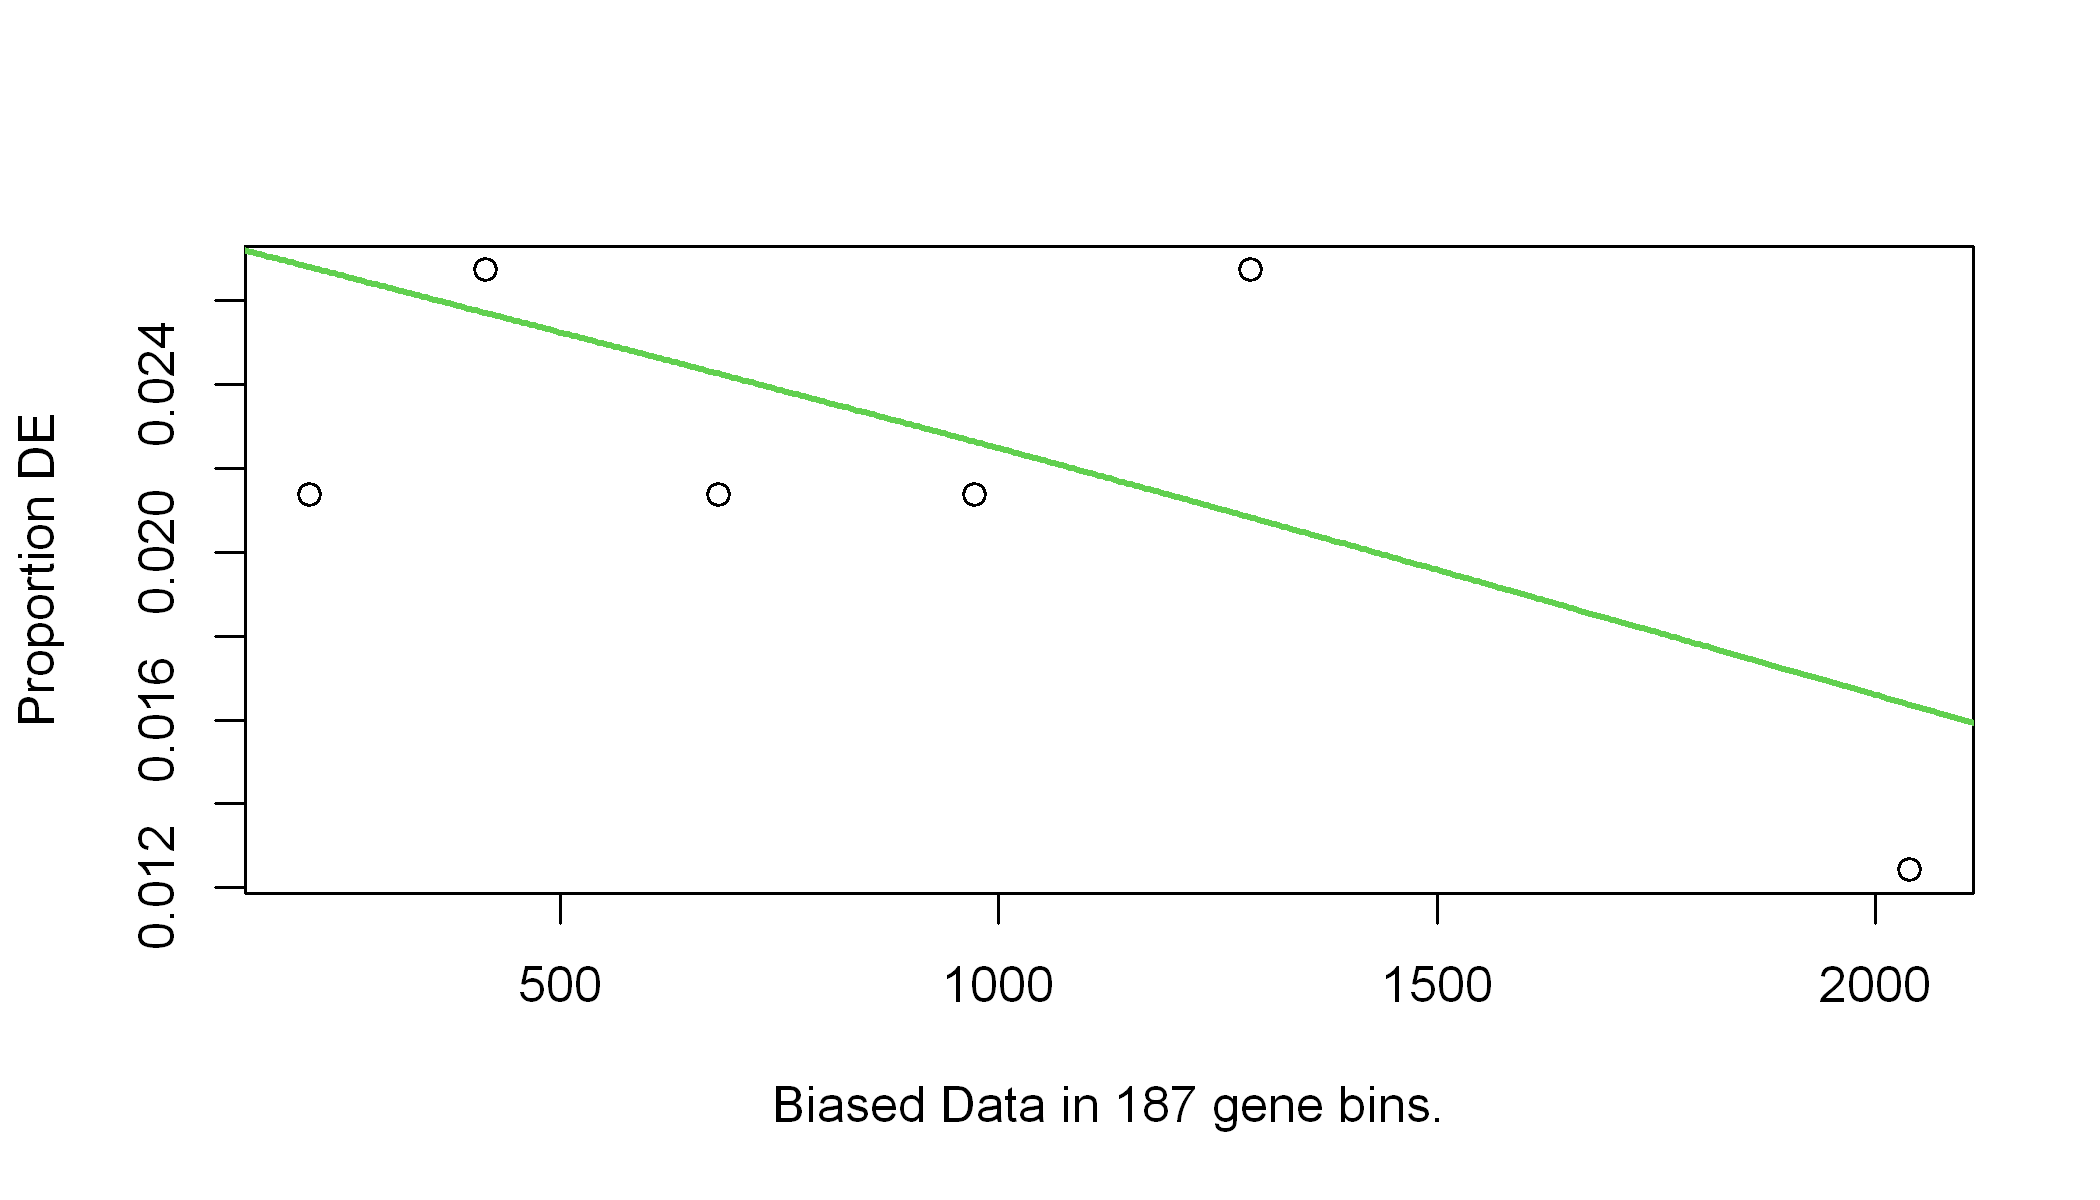

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


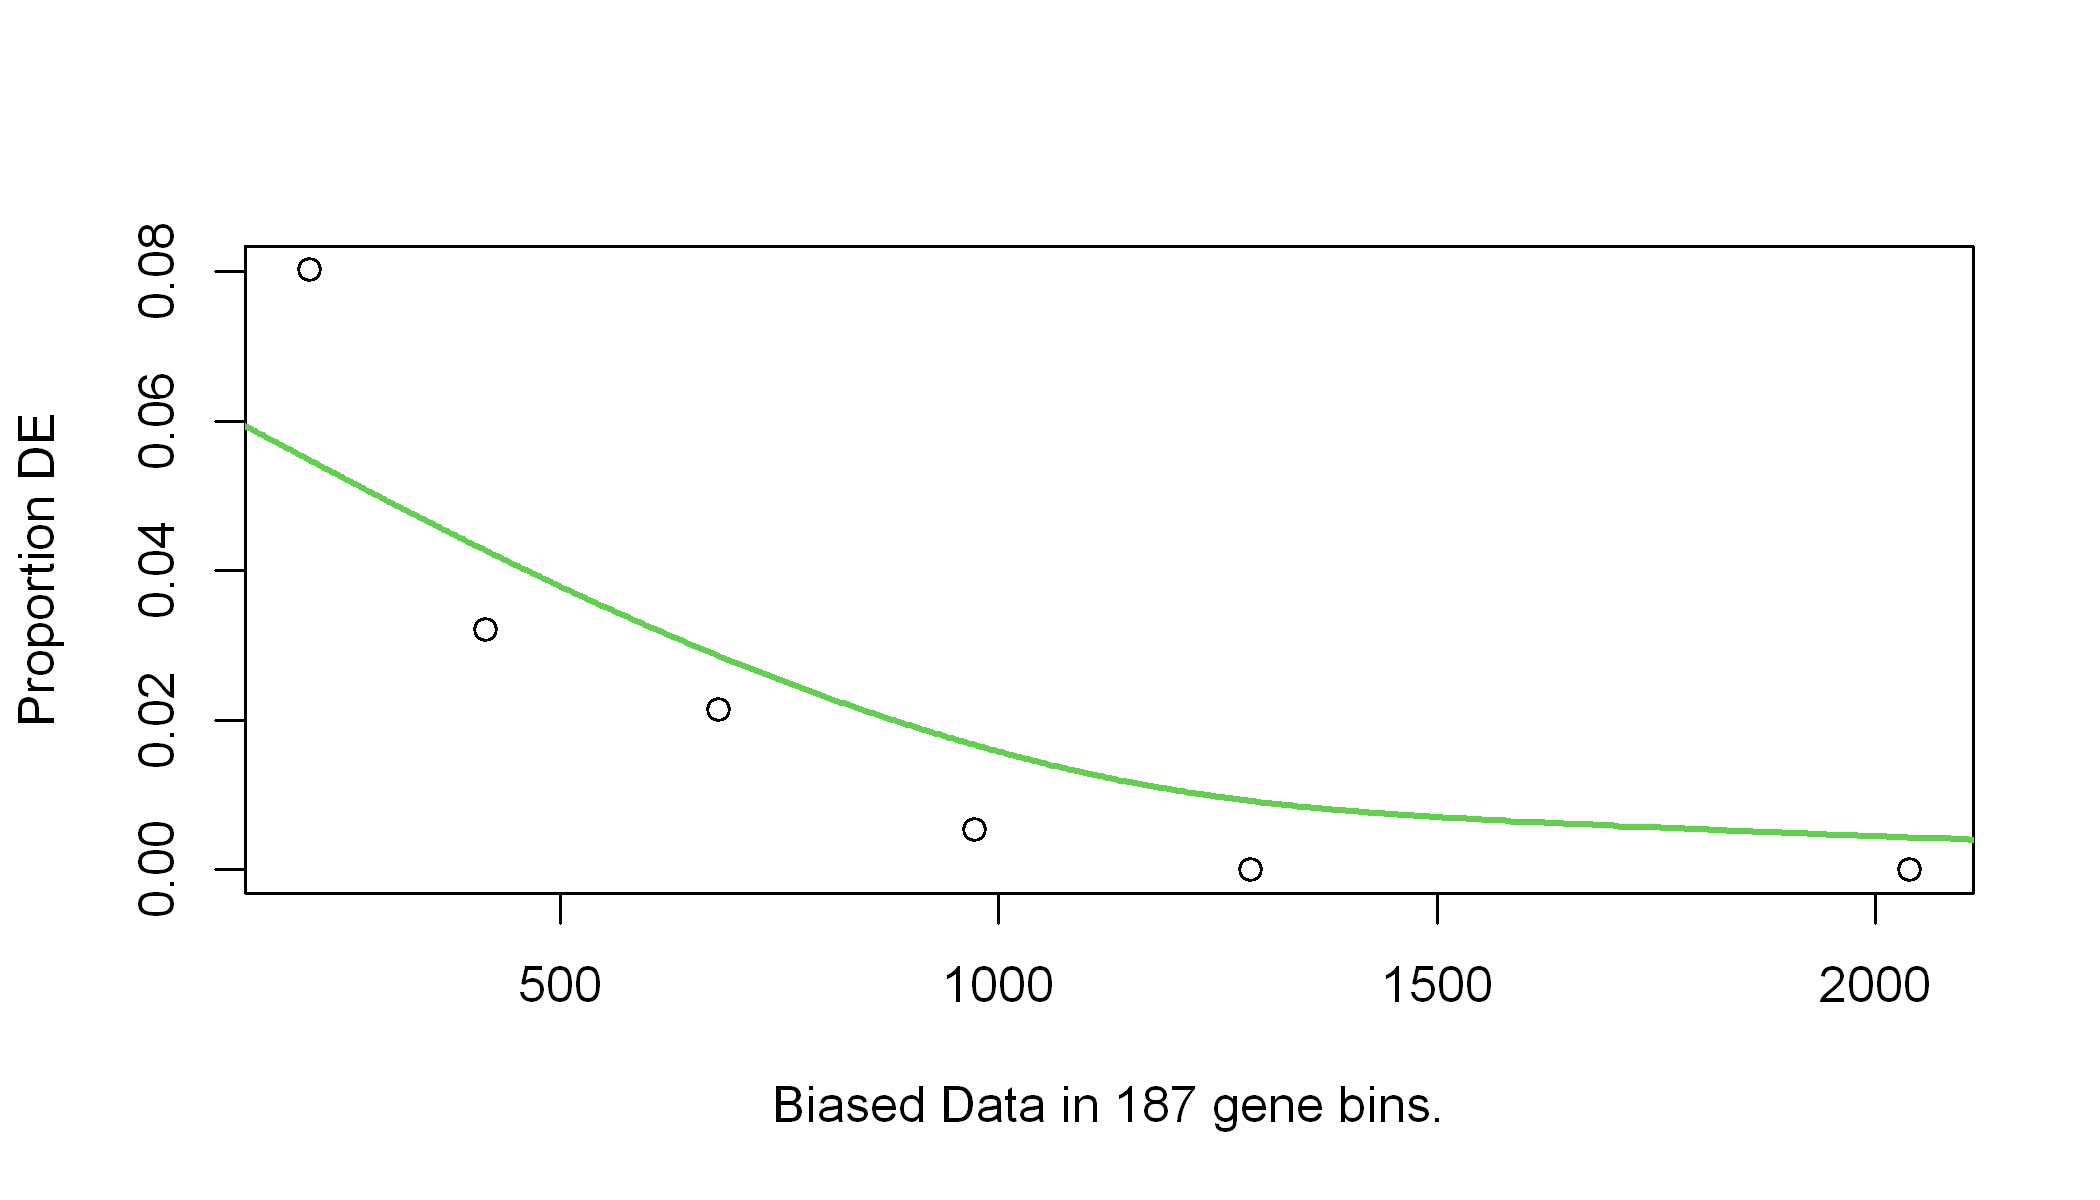

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


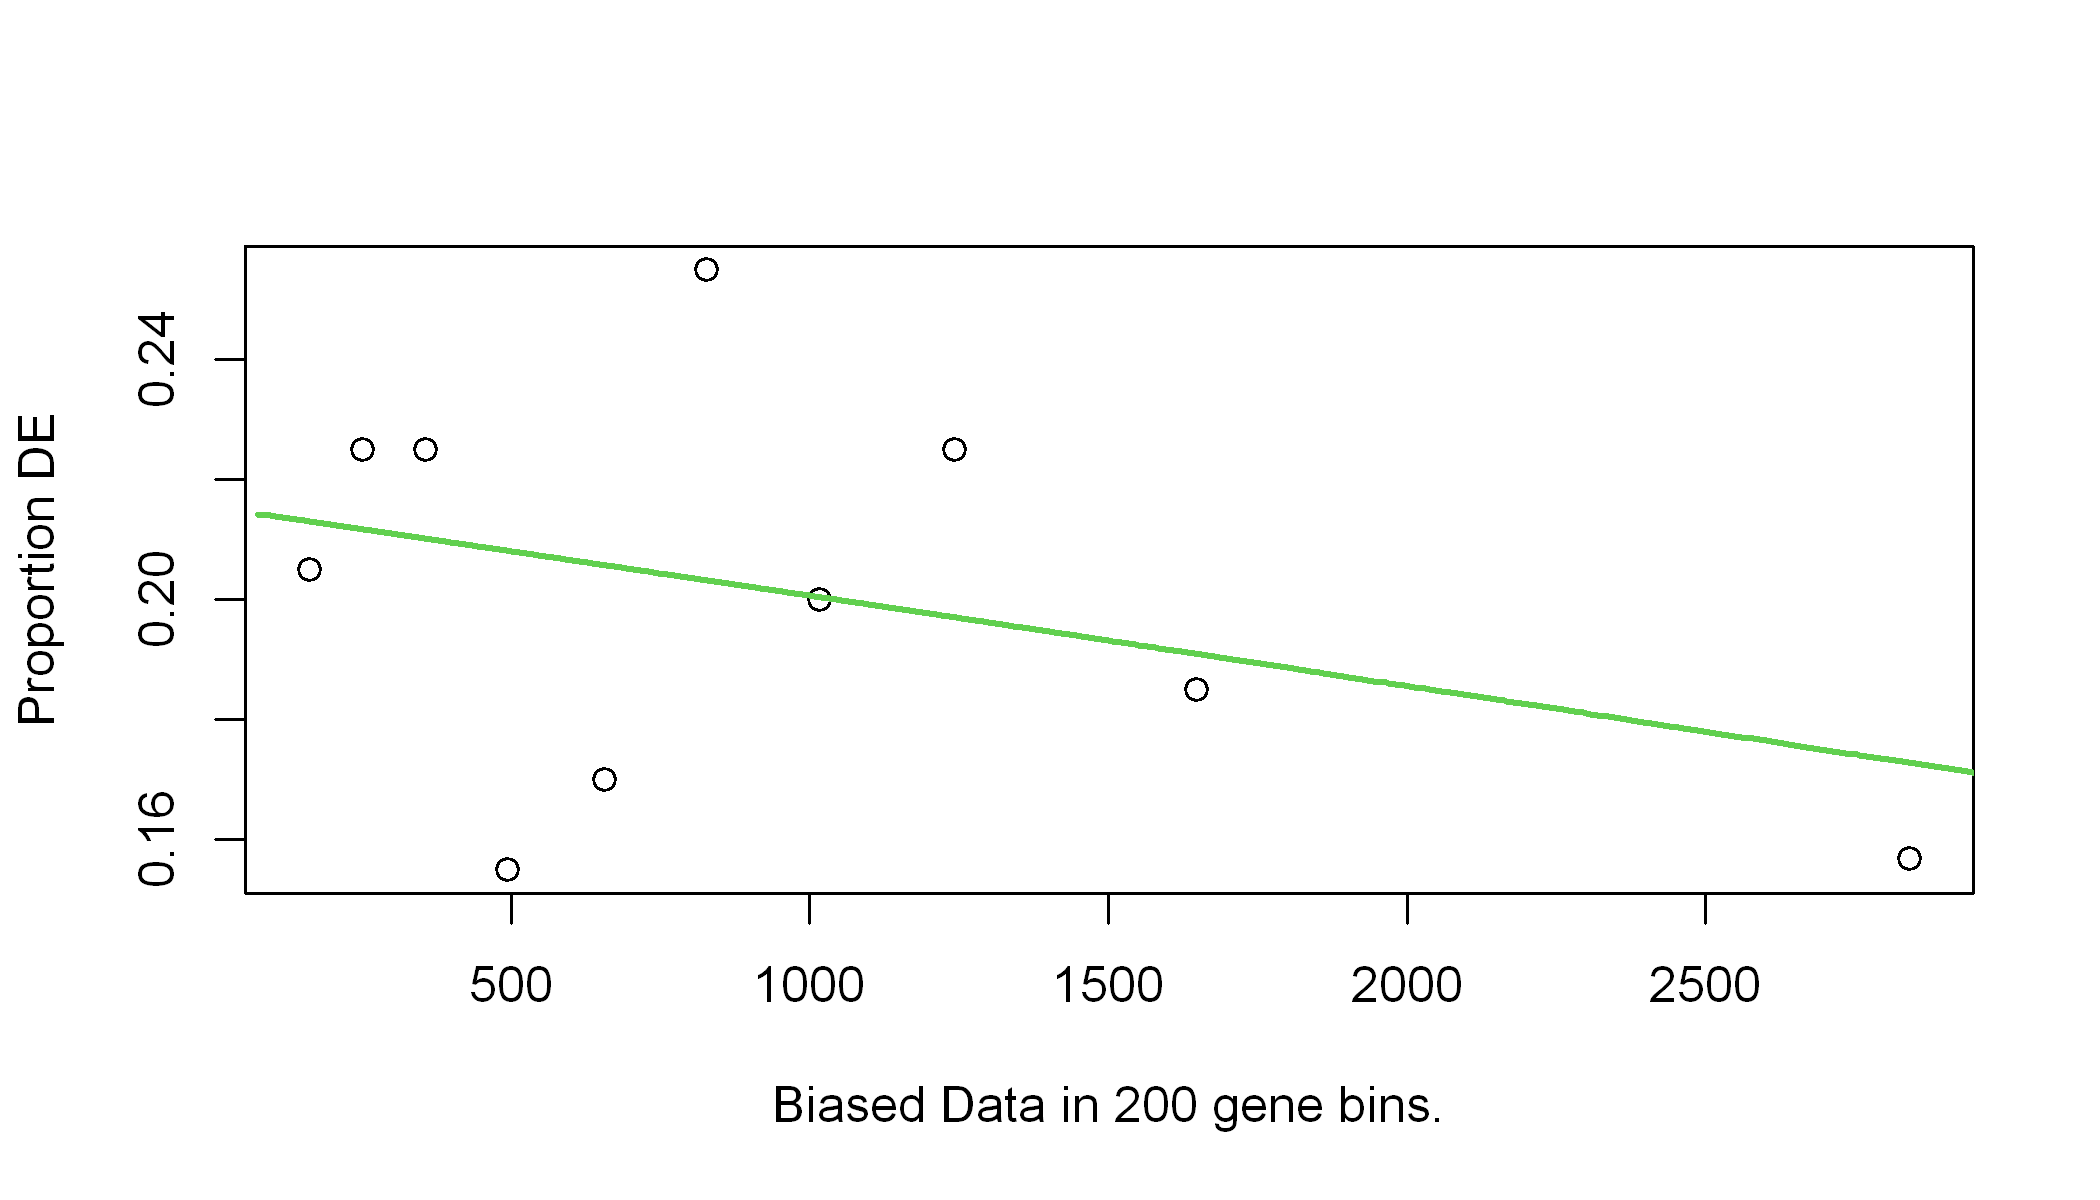

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


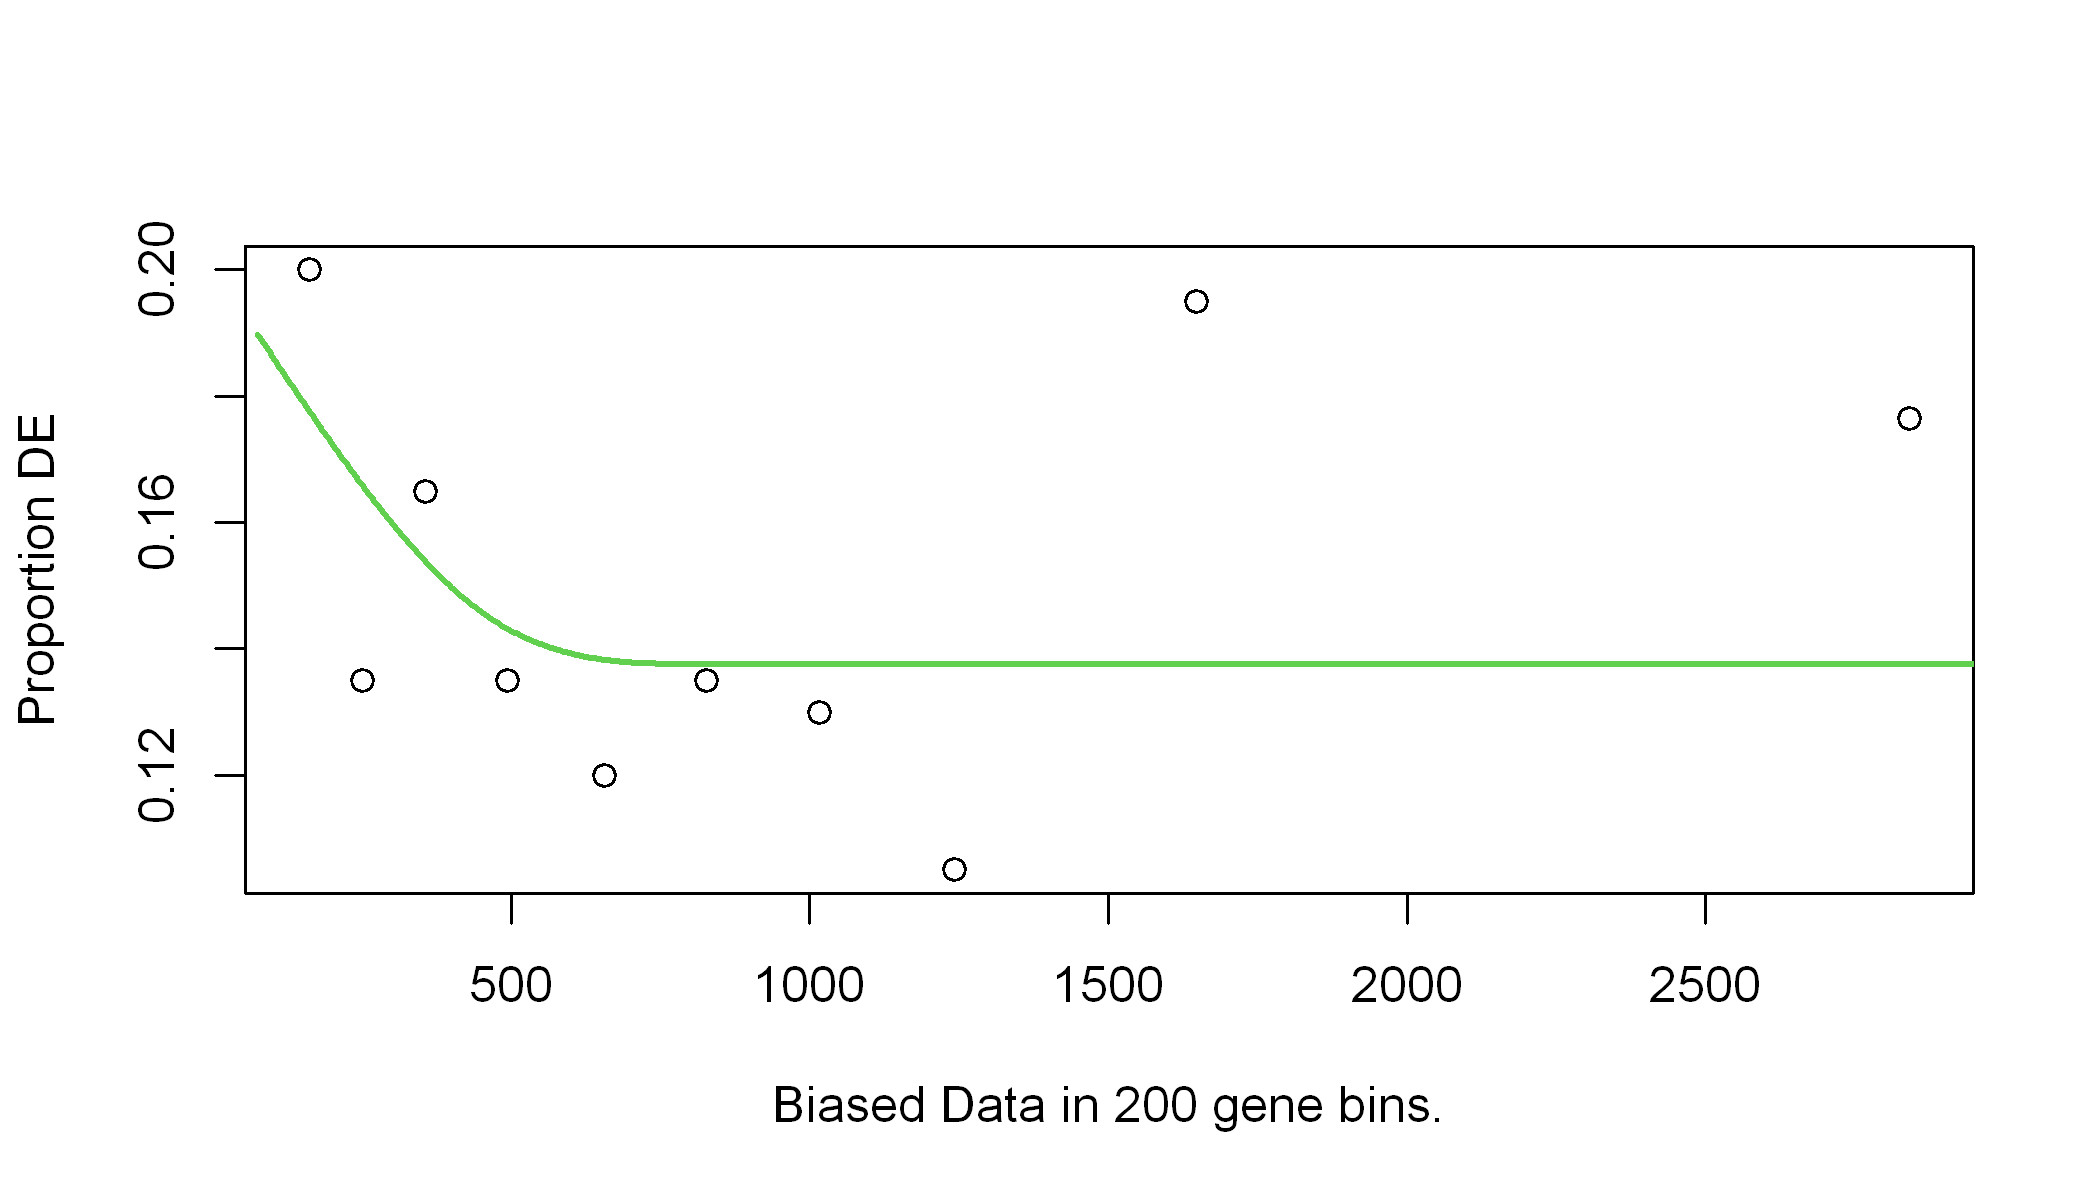

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


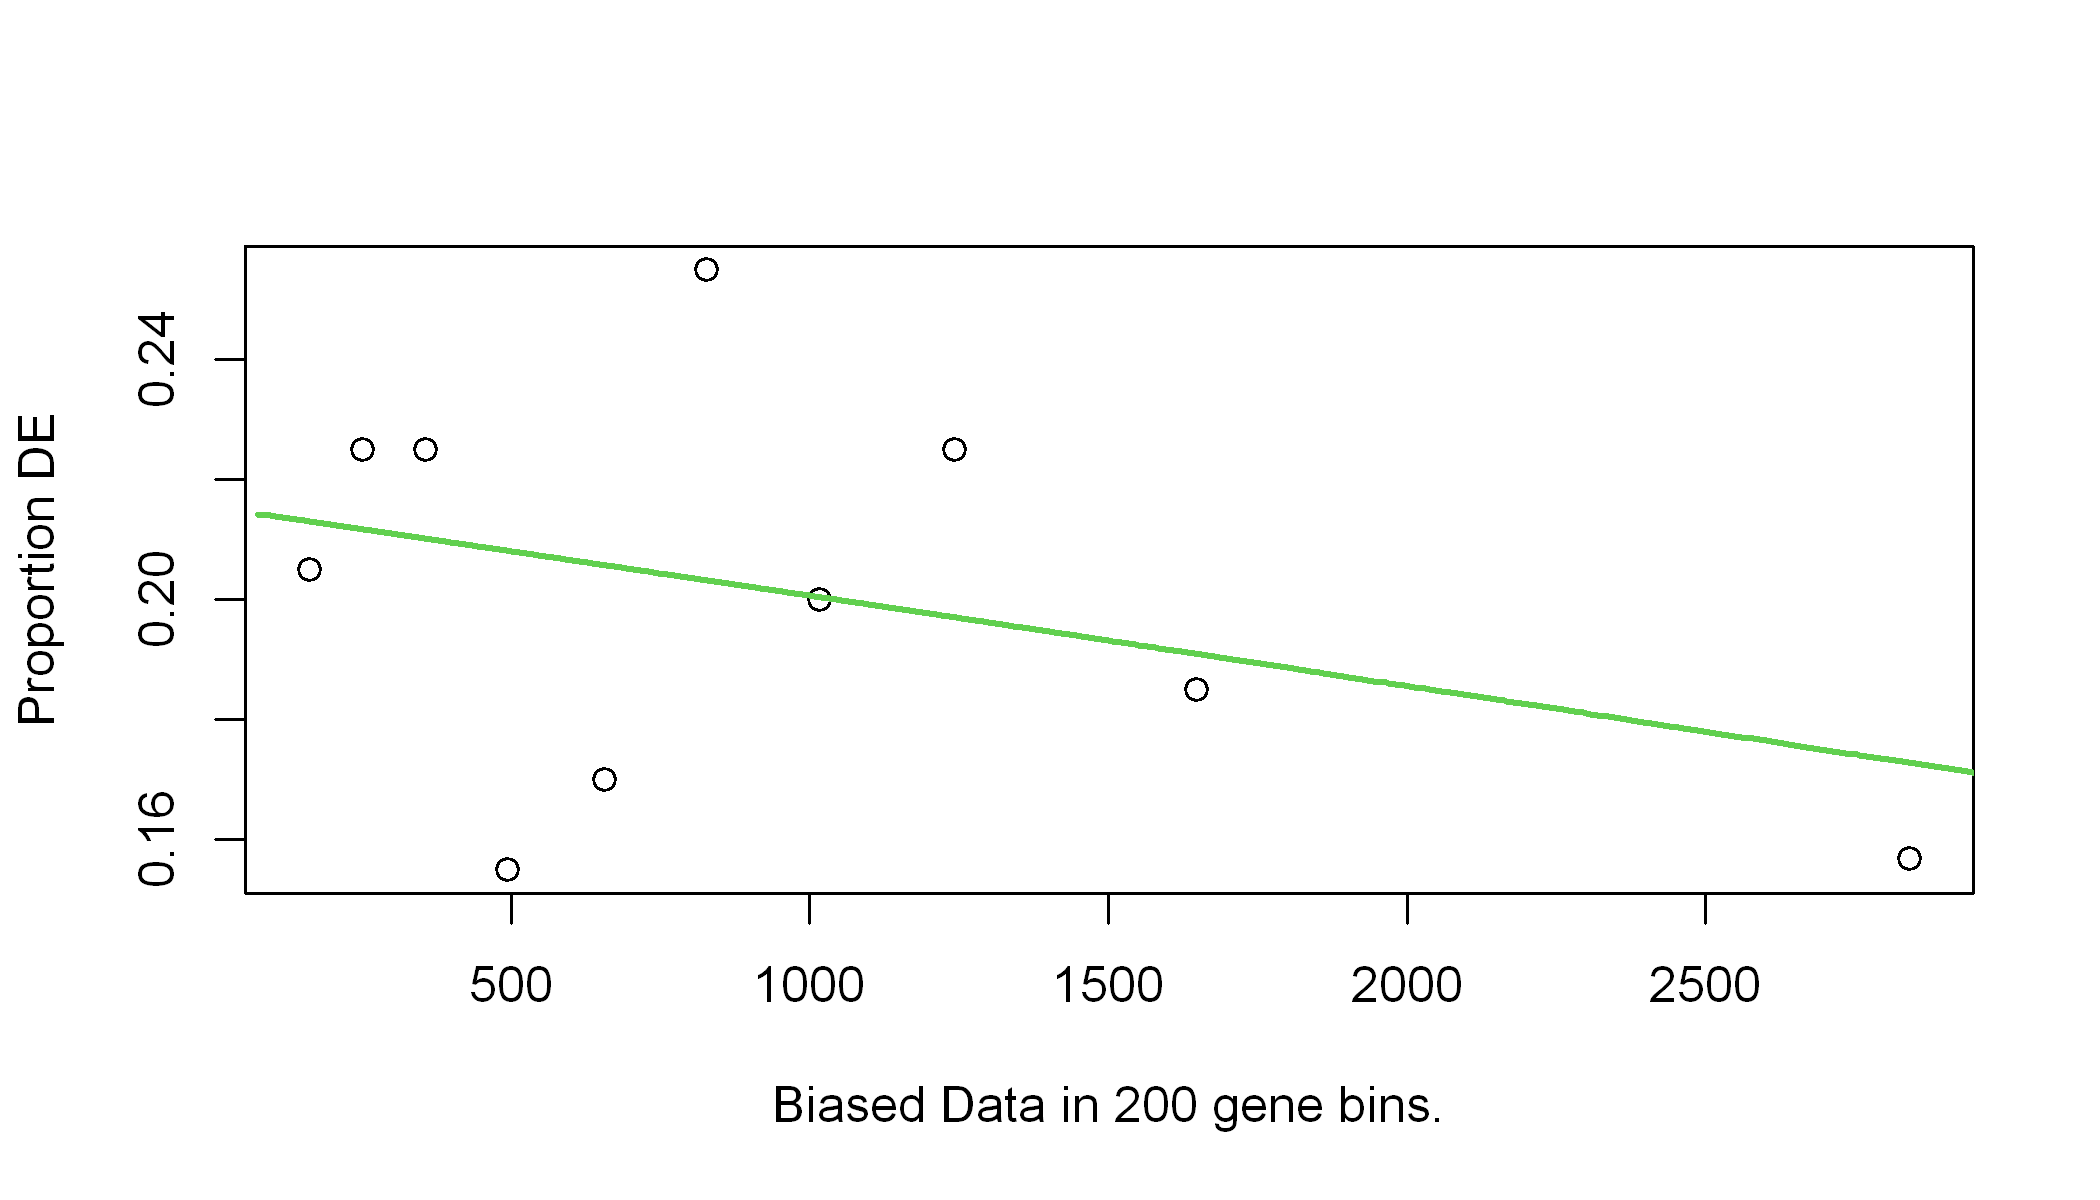

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


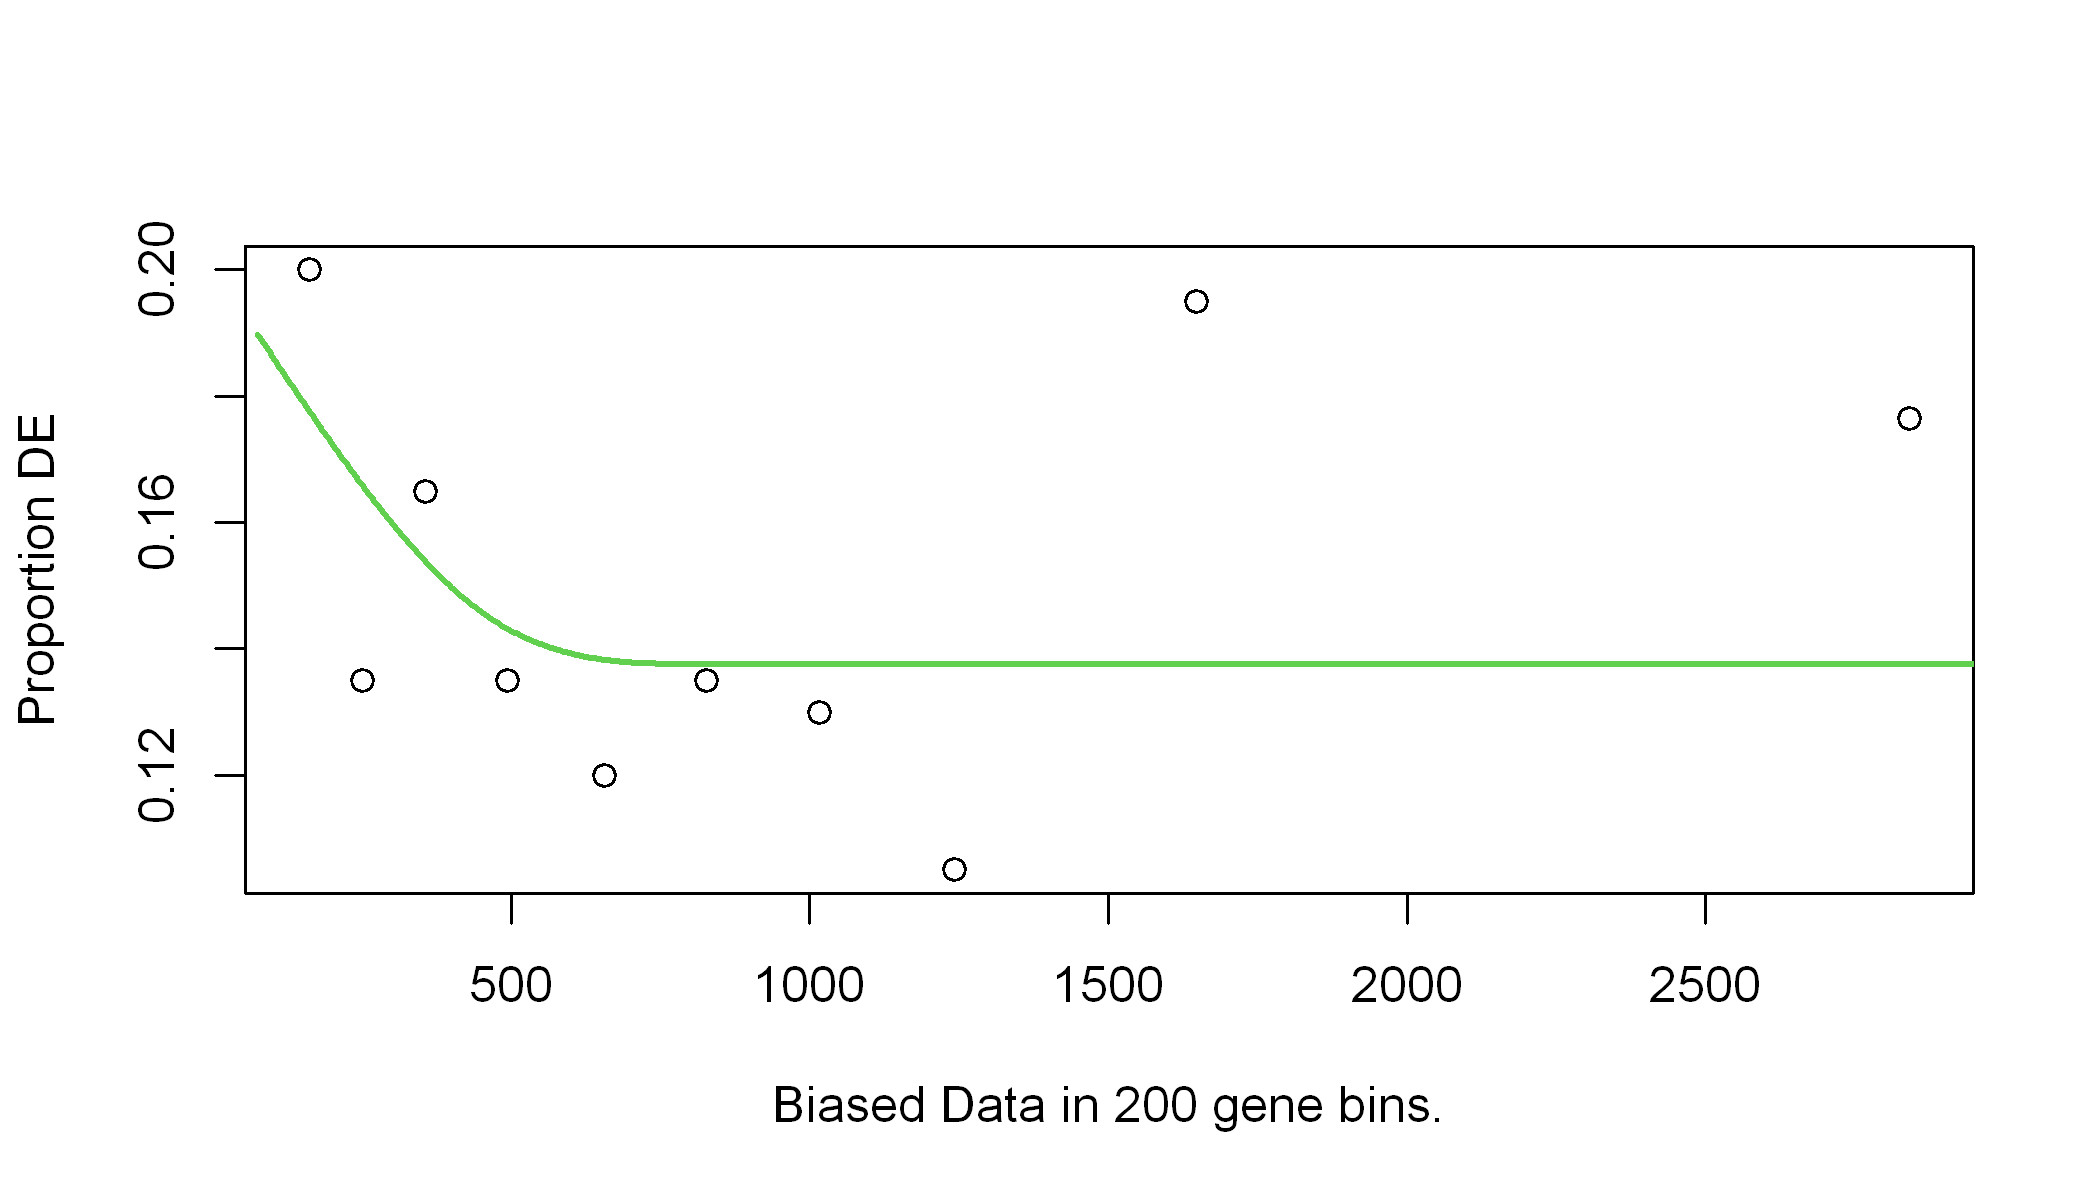

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


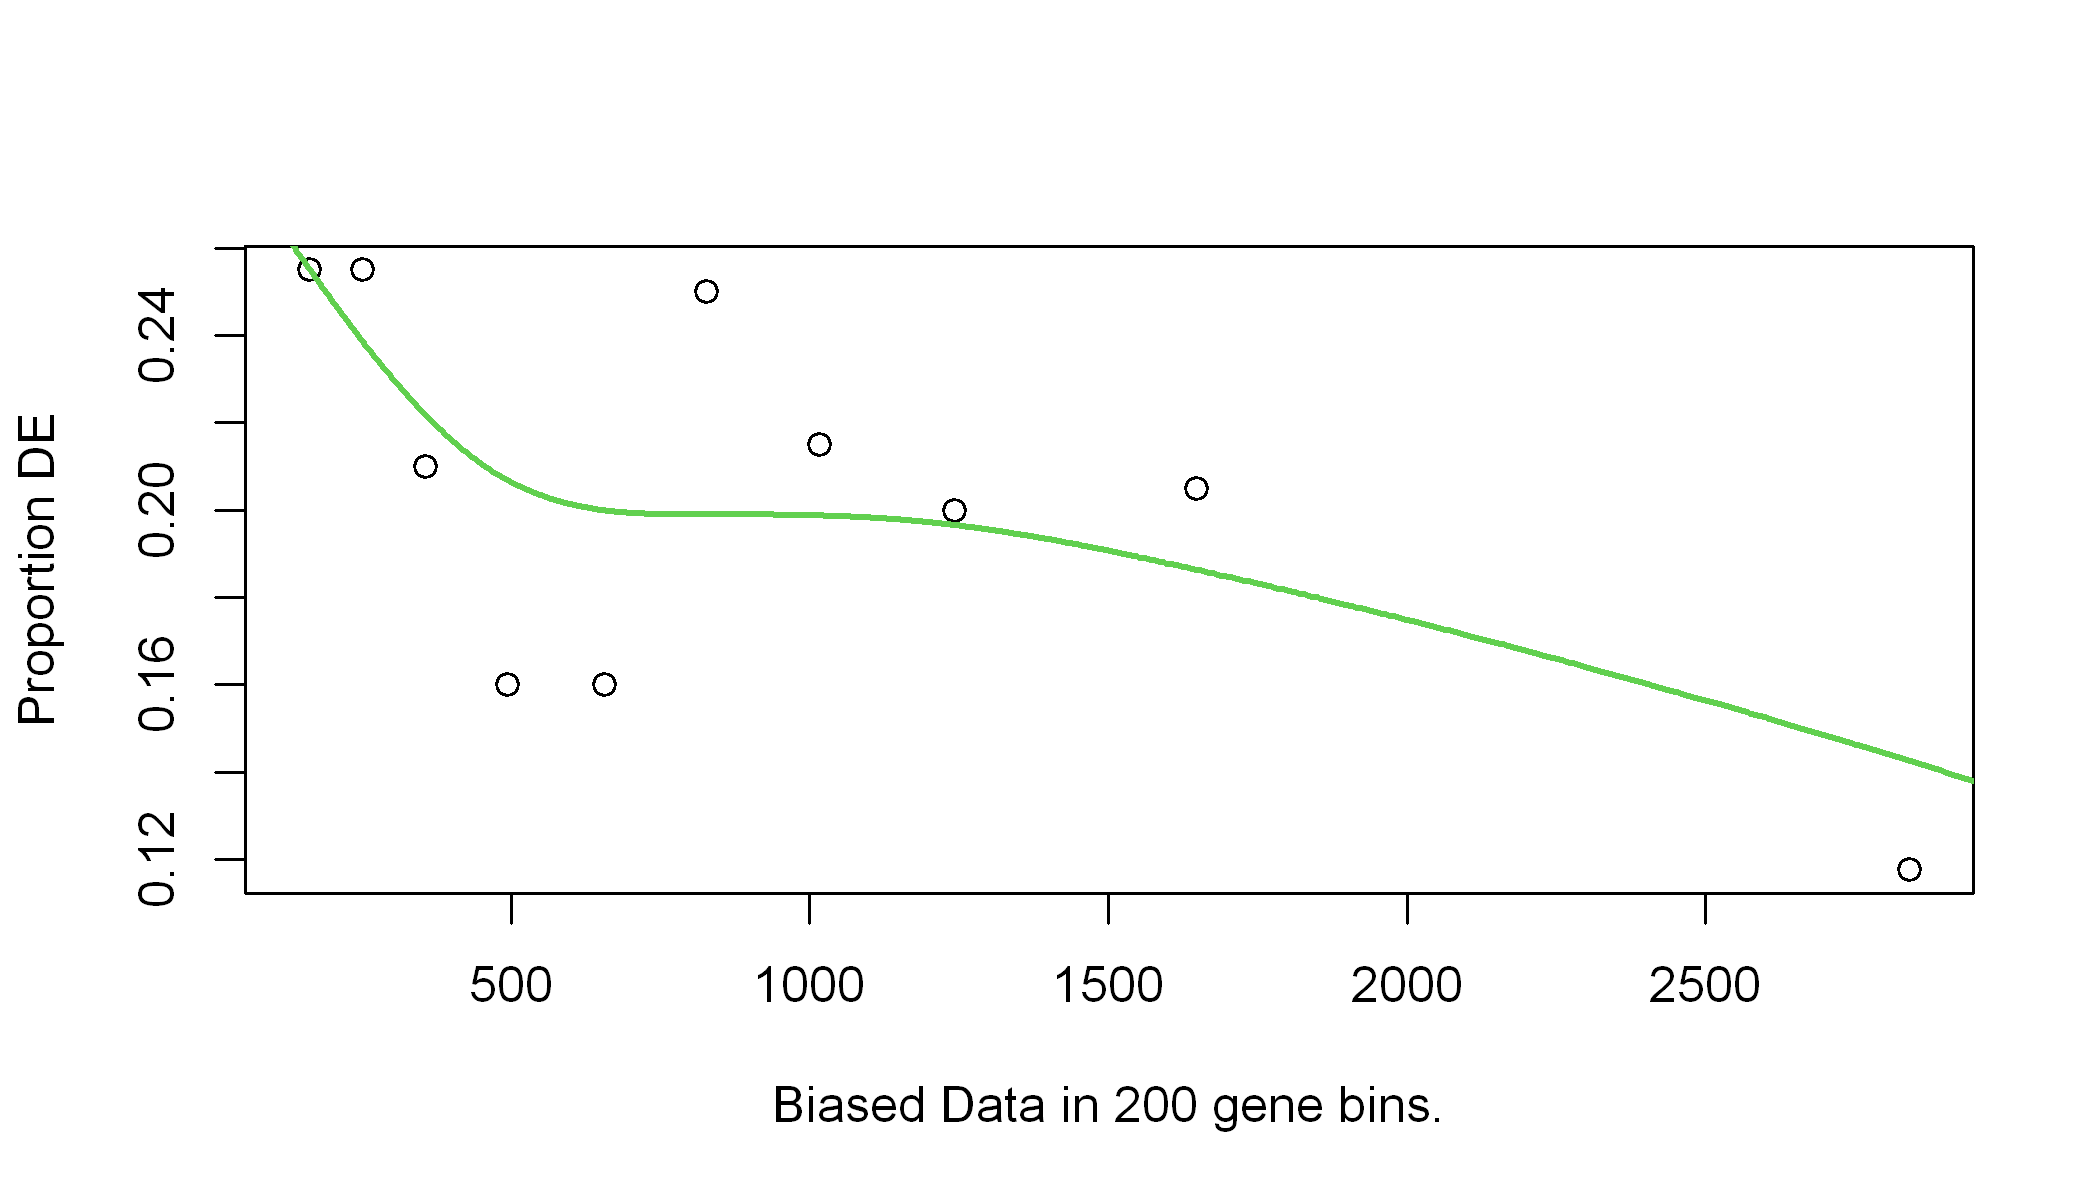

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


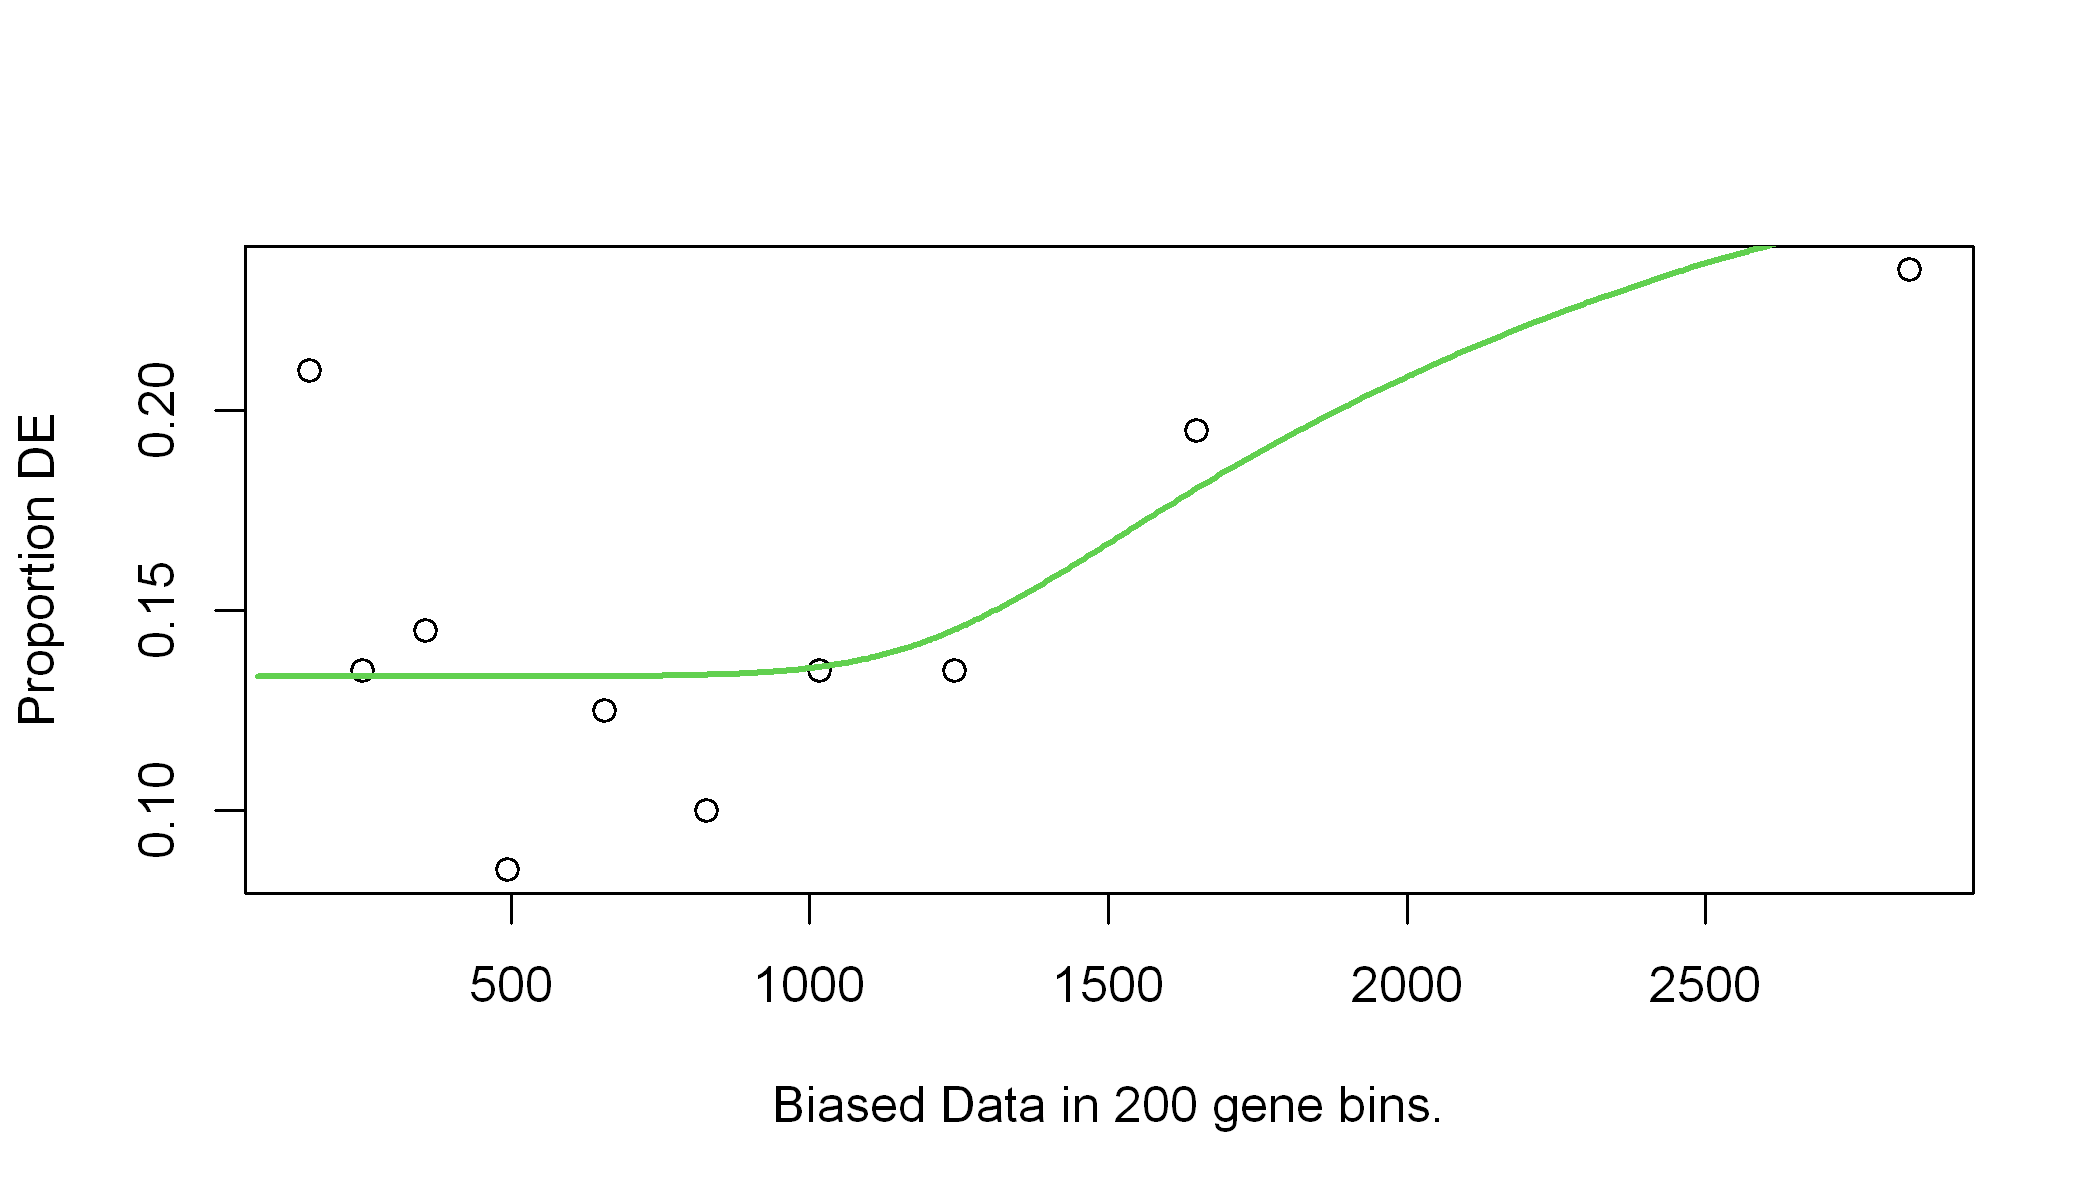

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


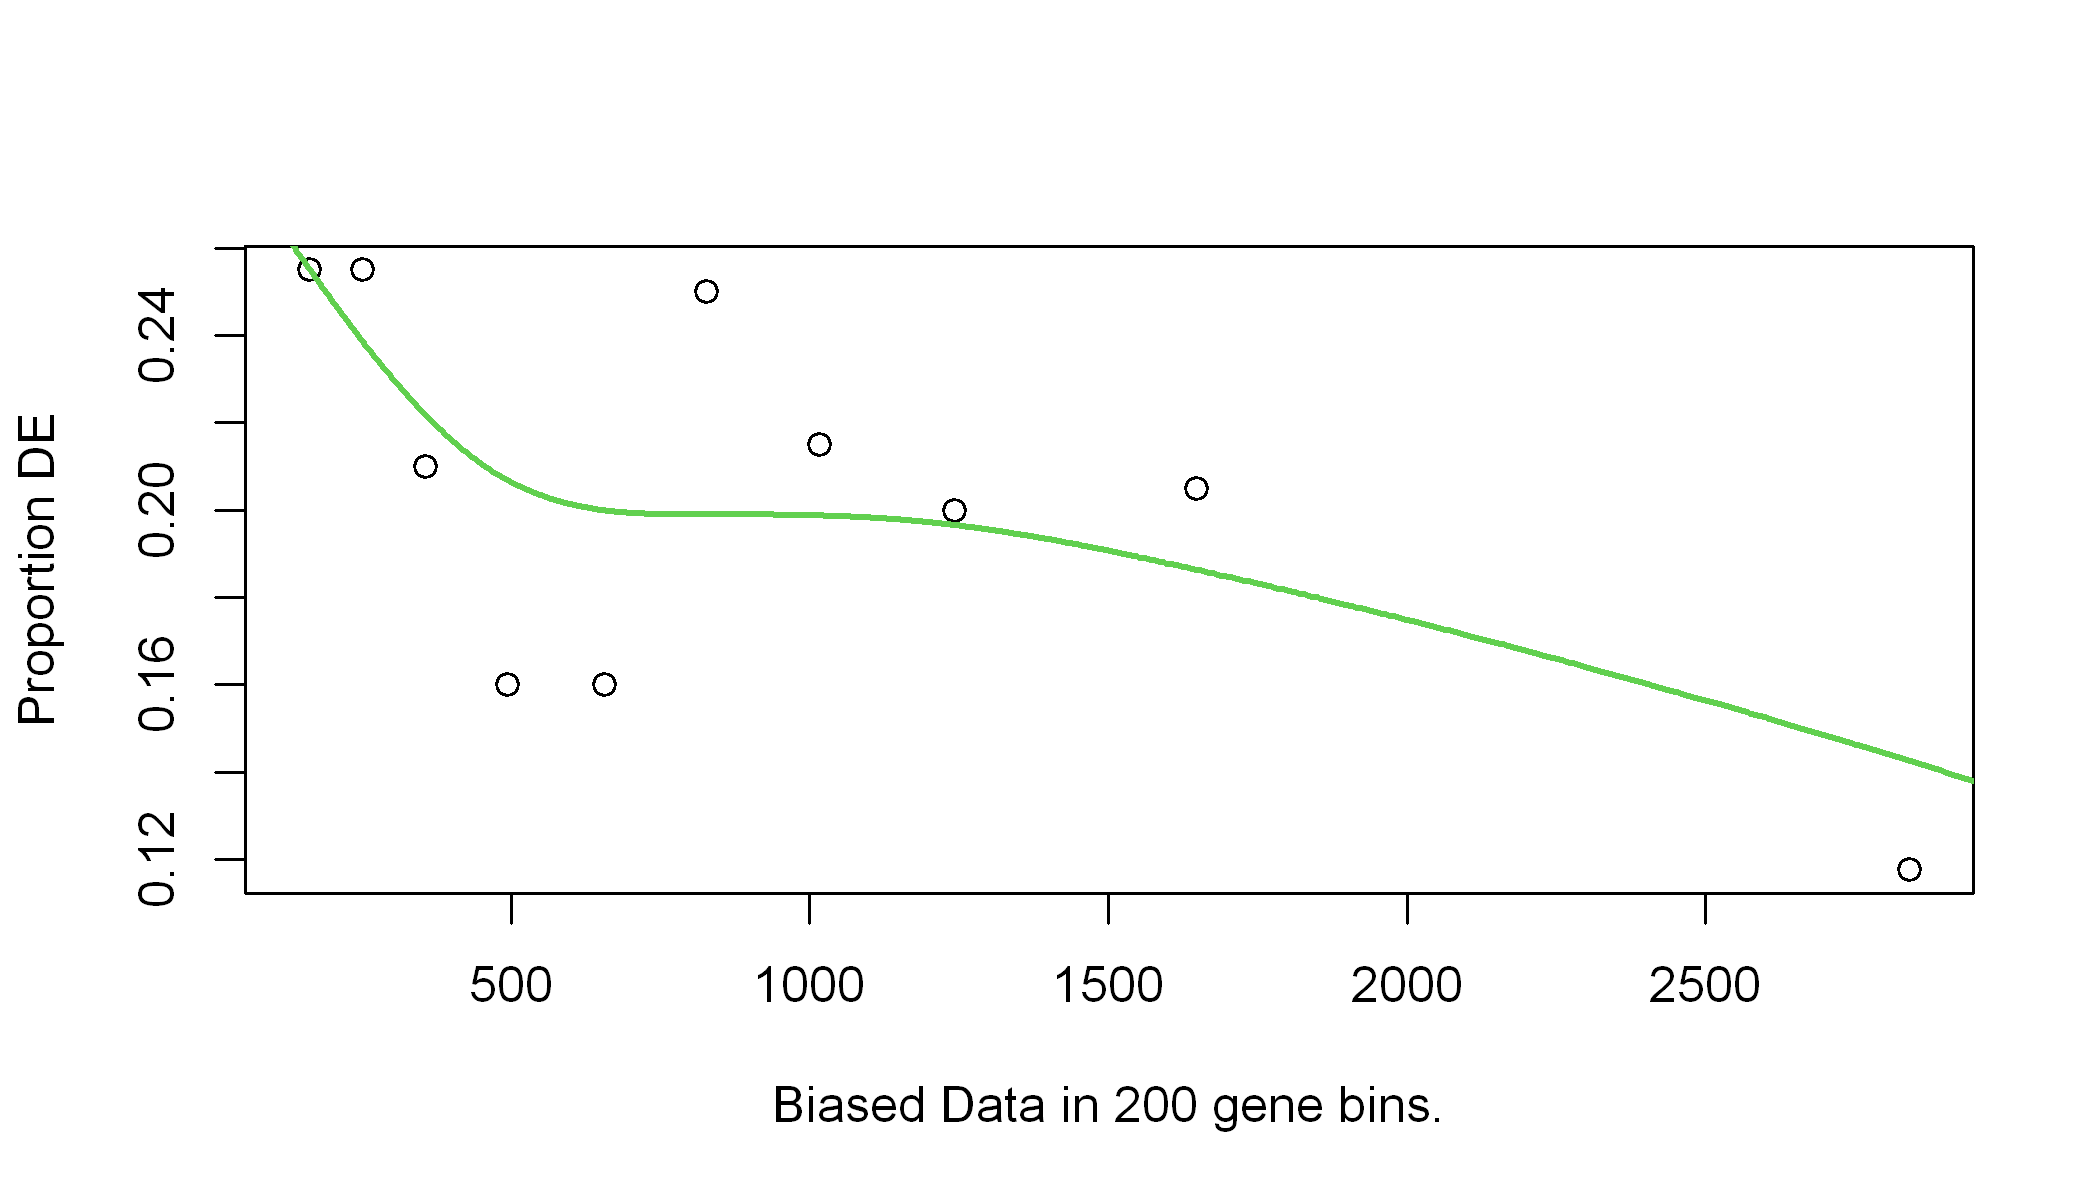

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


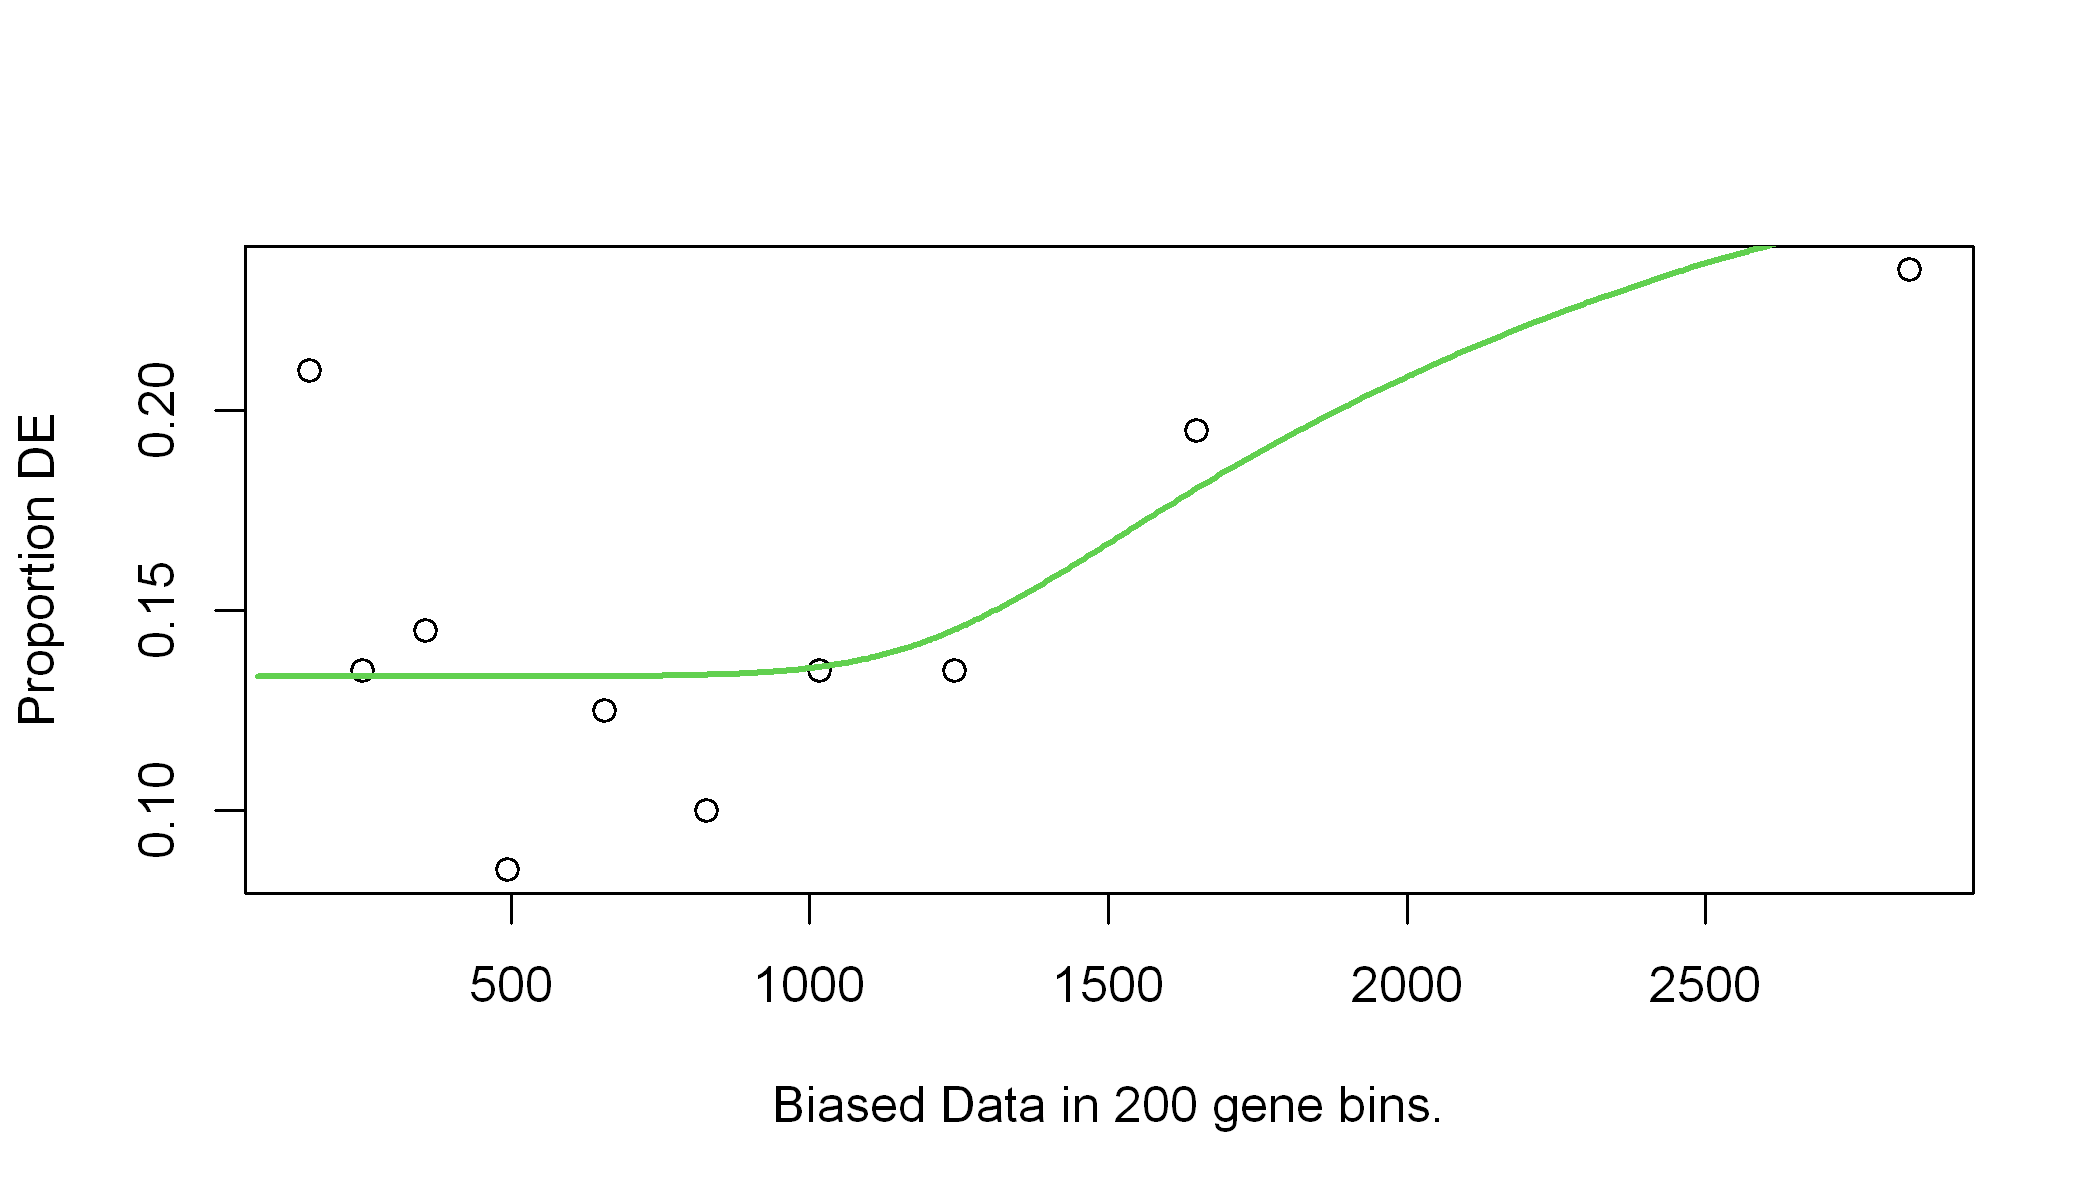

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


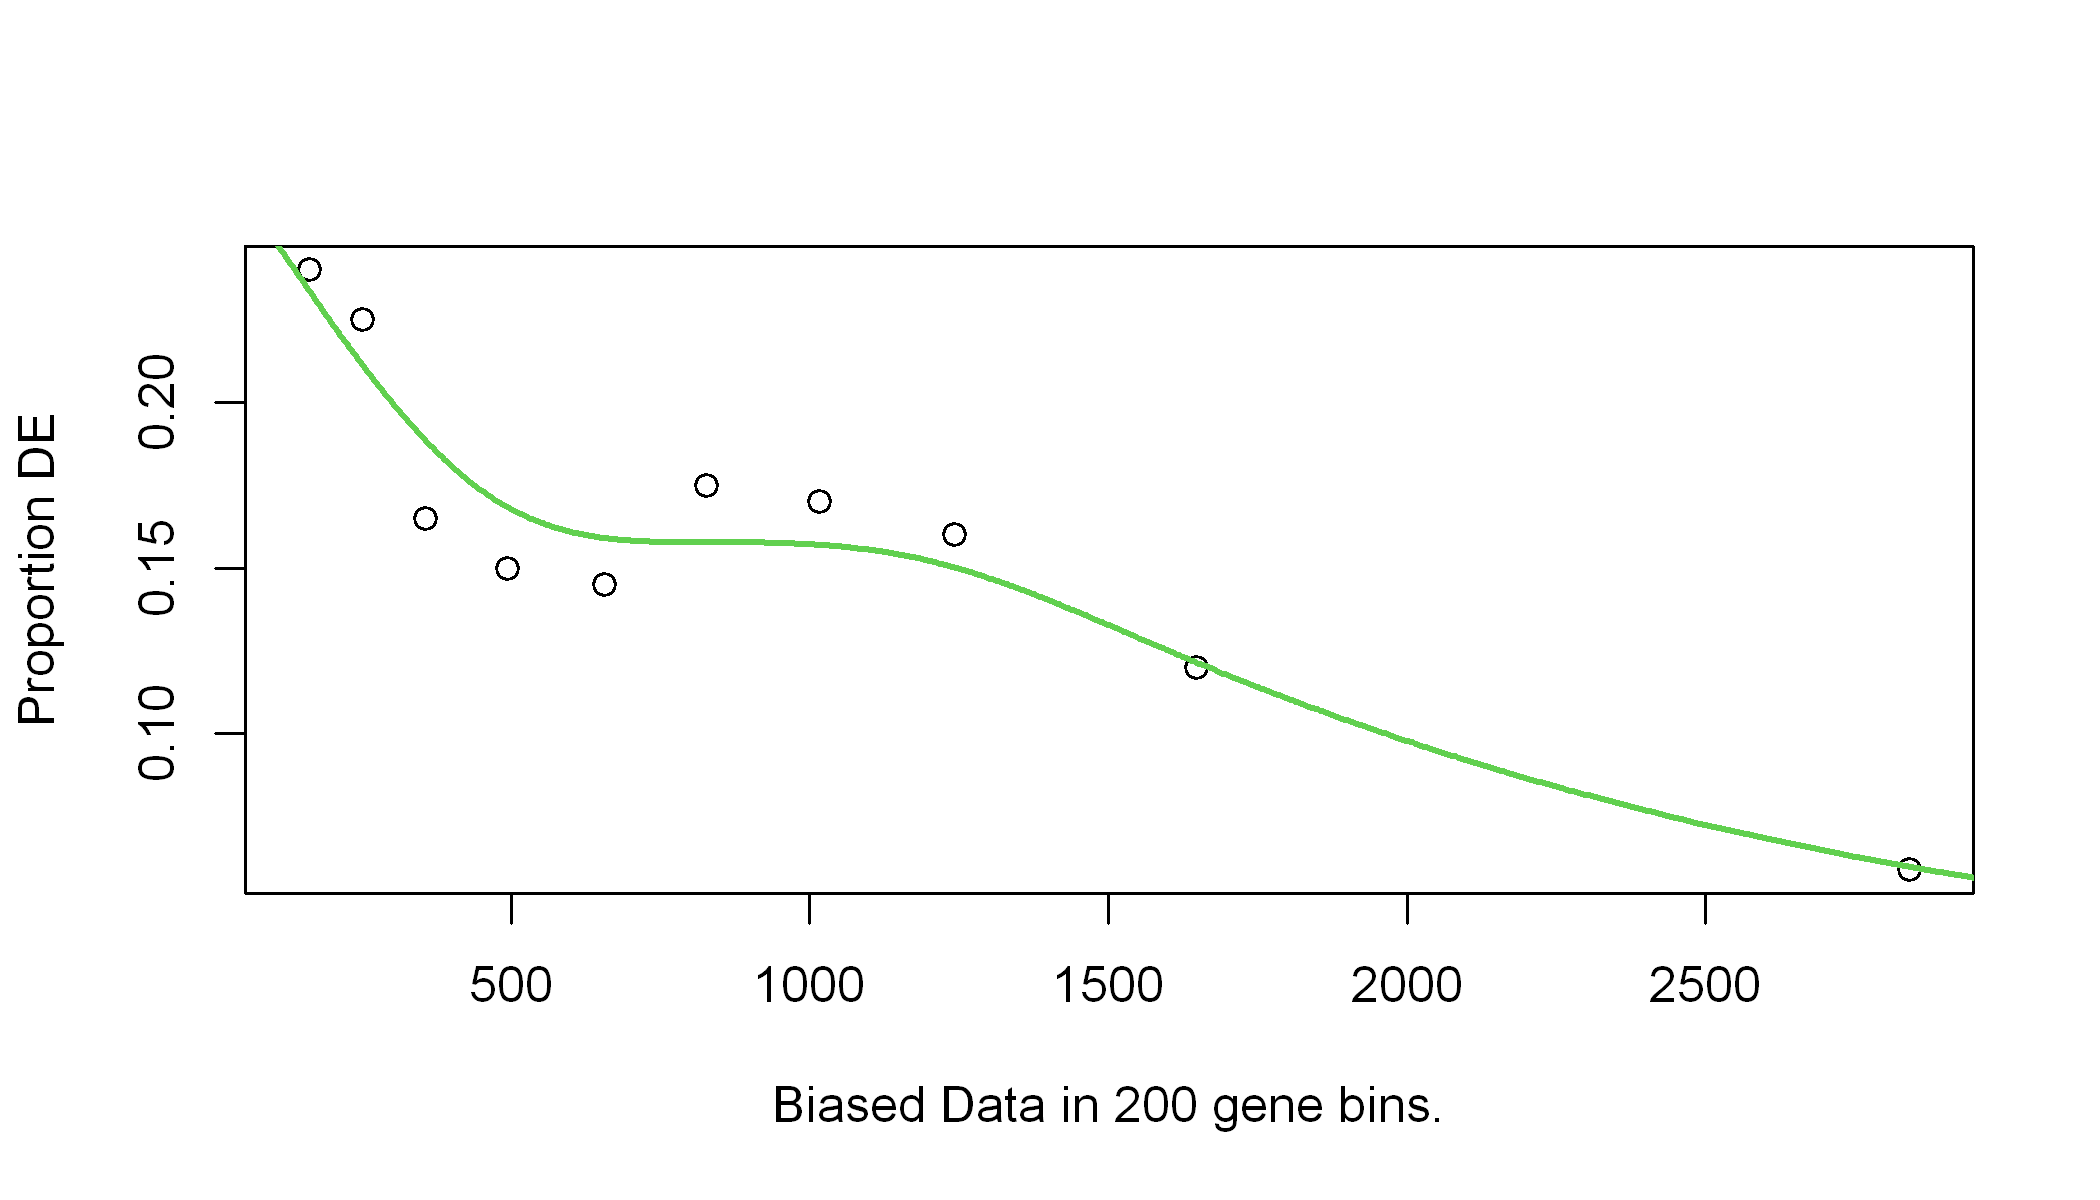

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


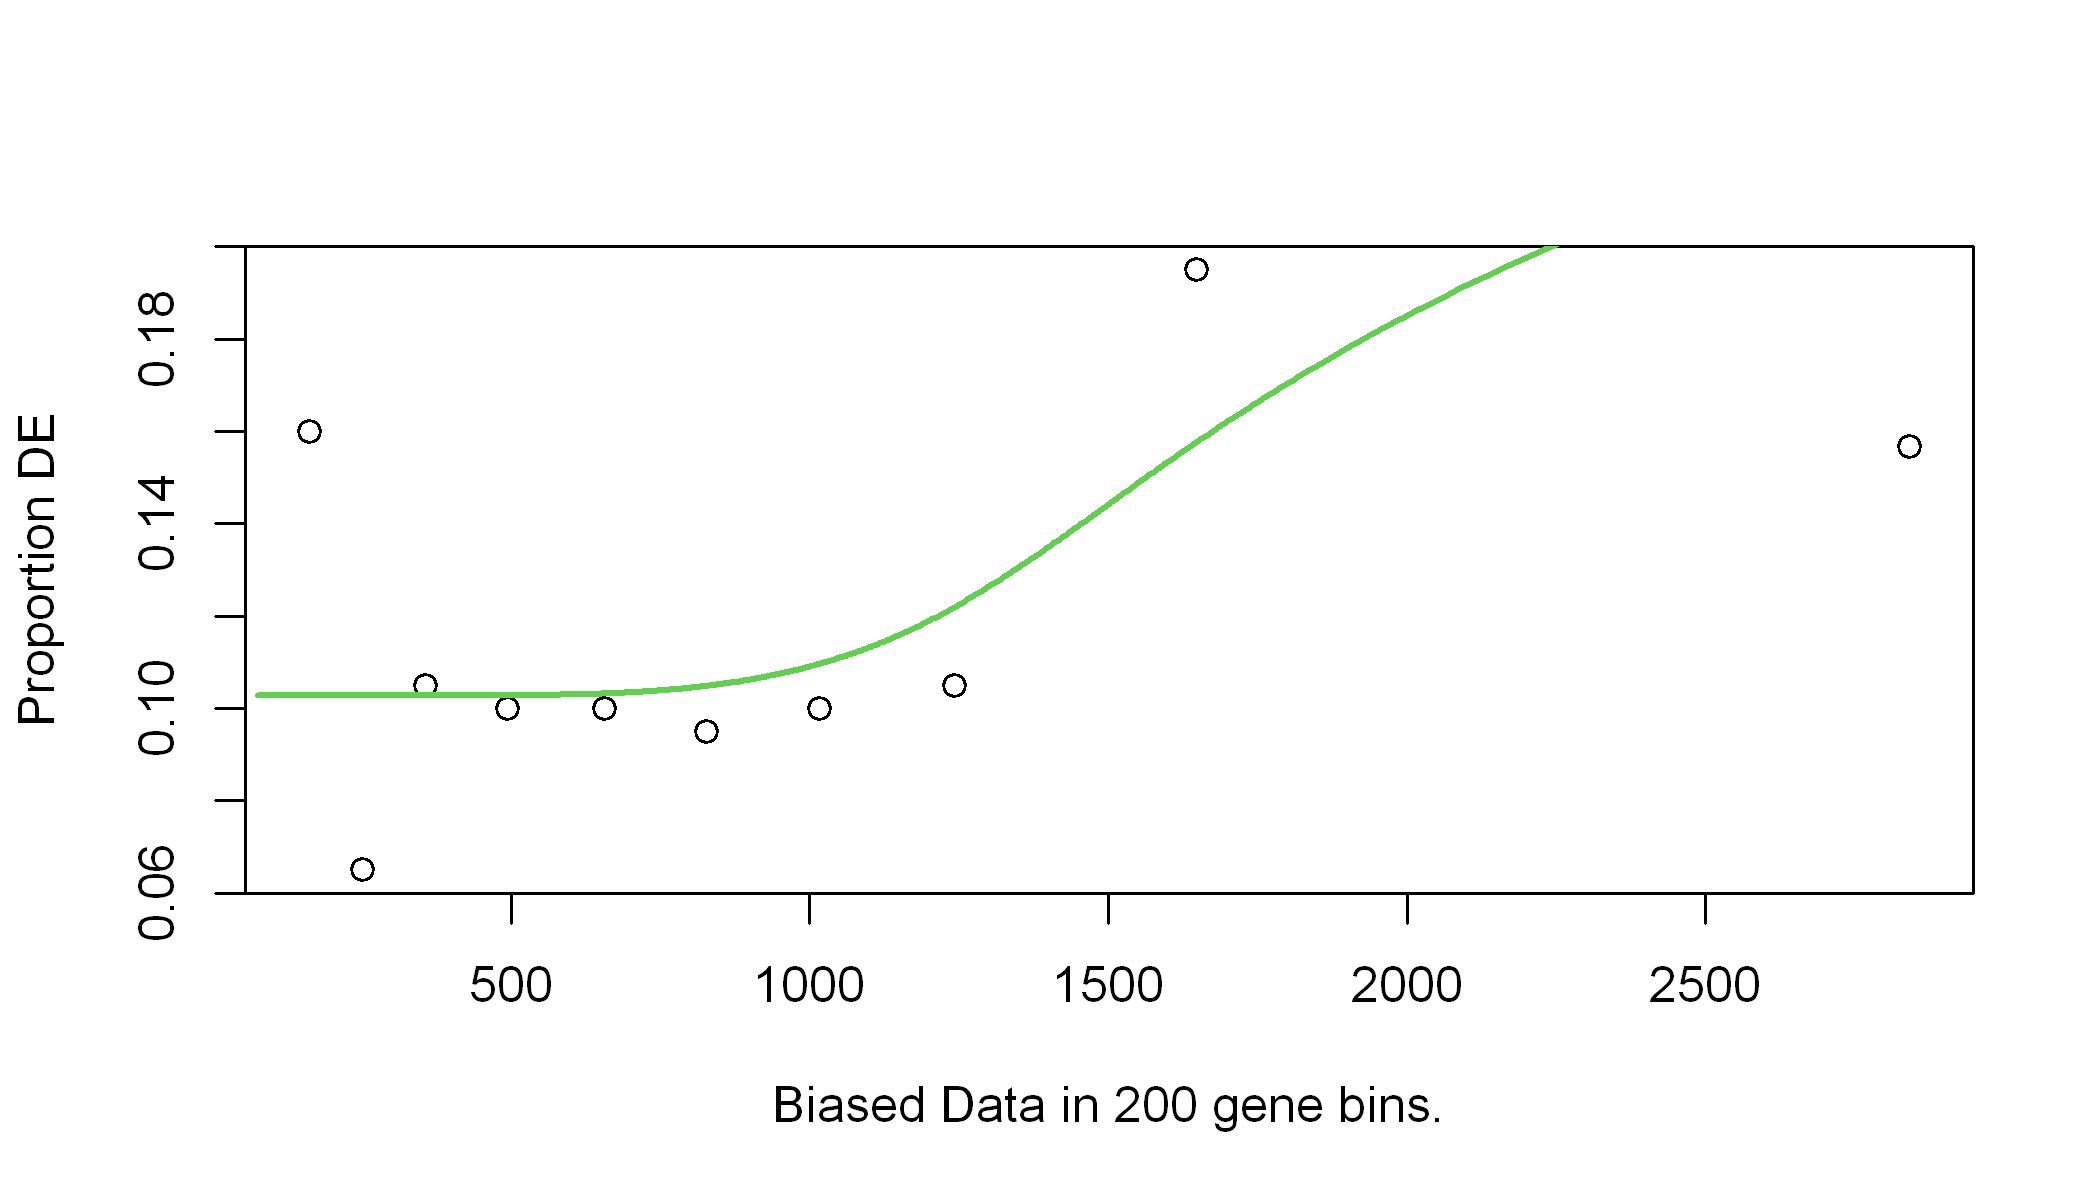

Using manually entered categories.

For 3 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


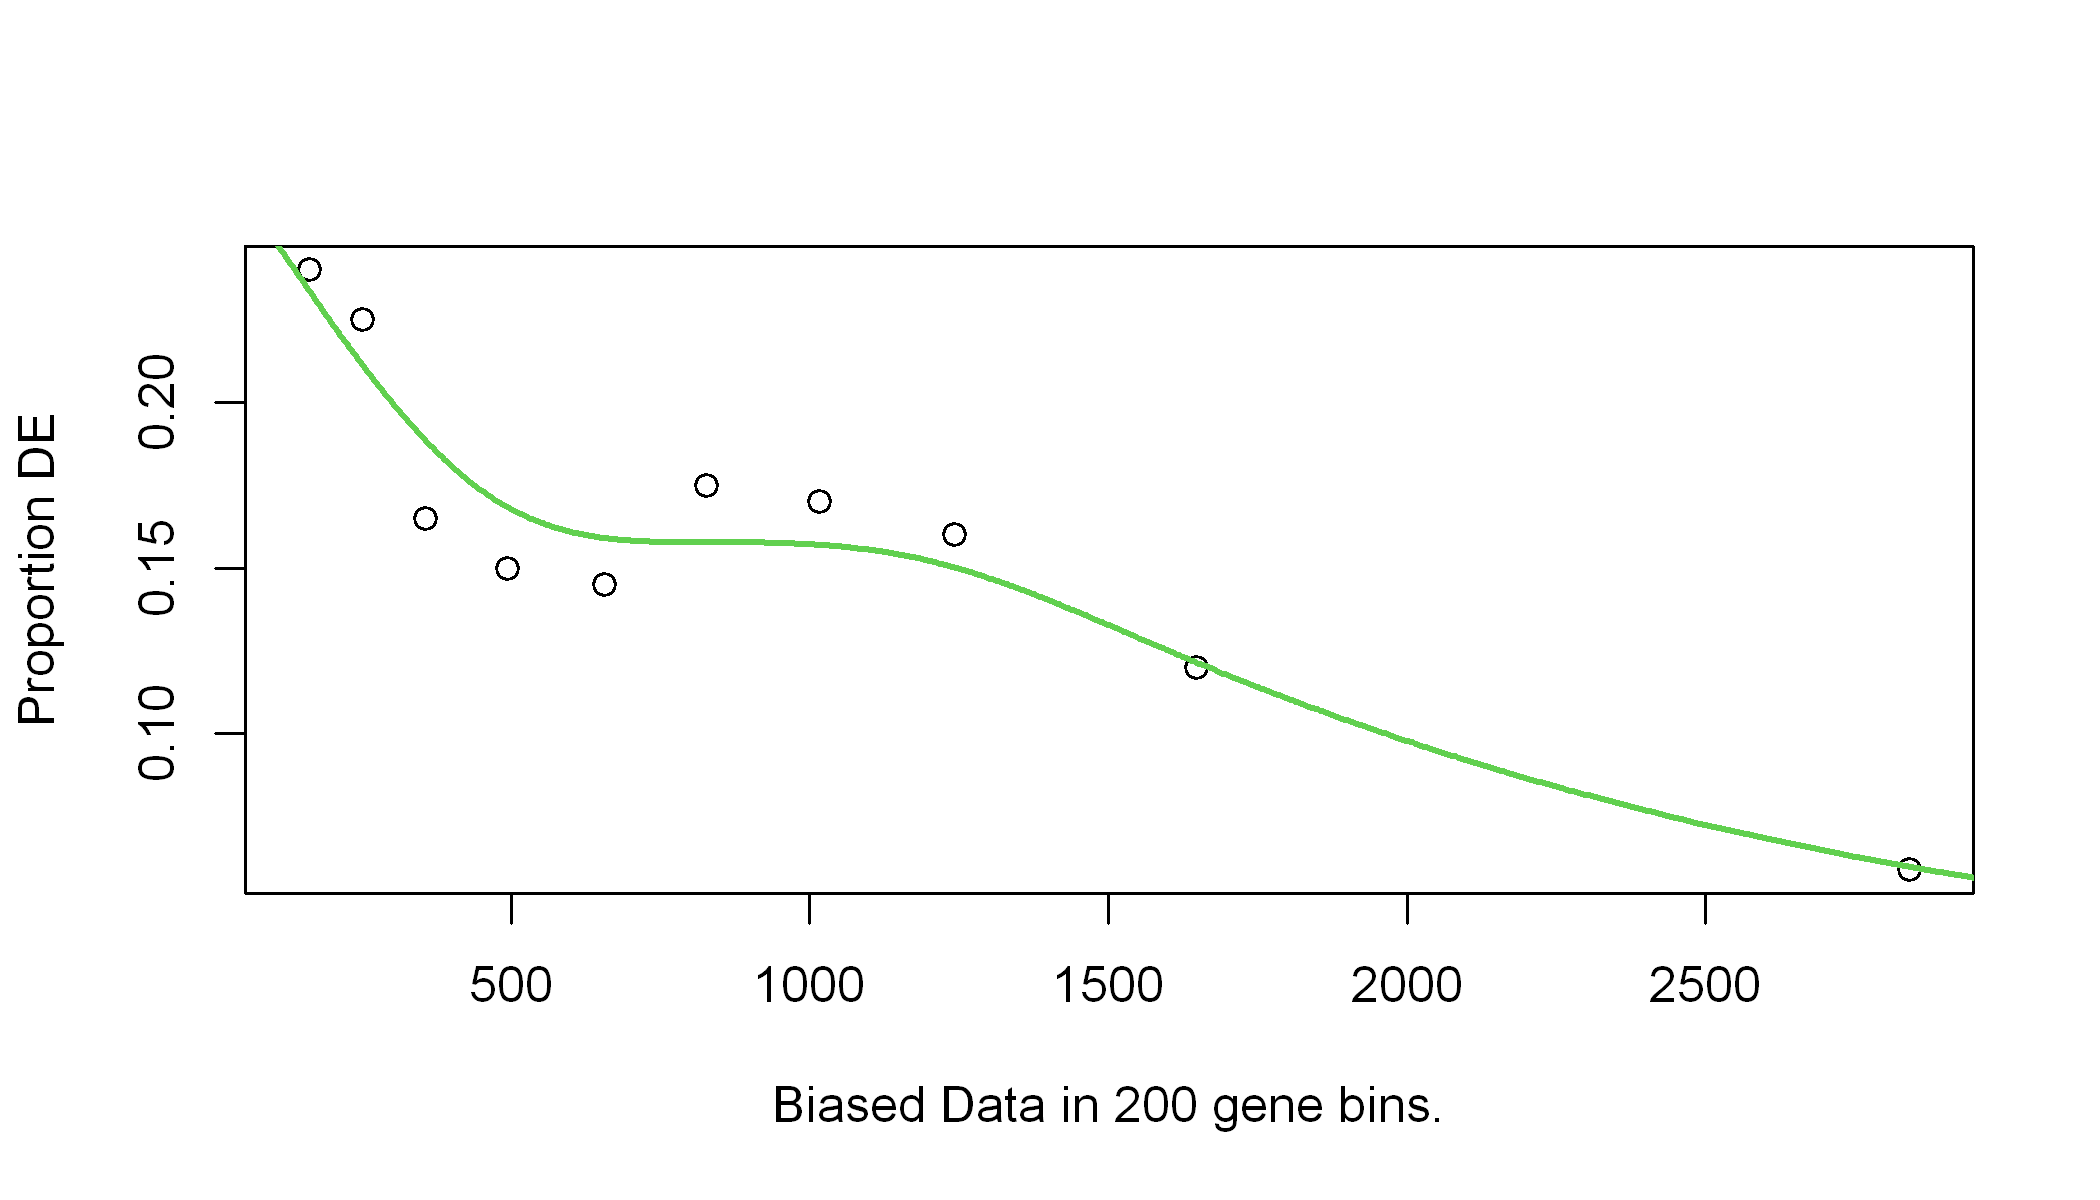

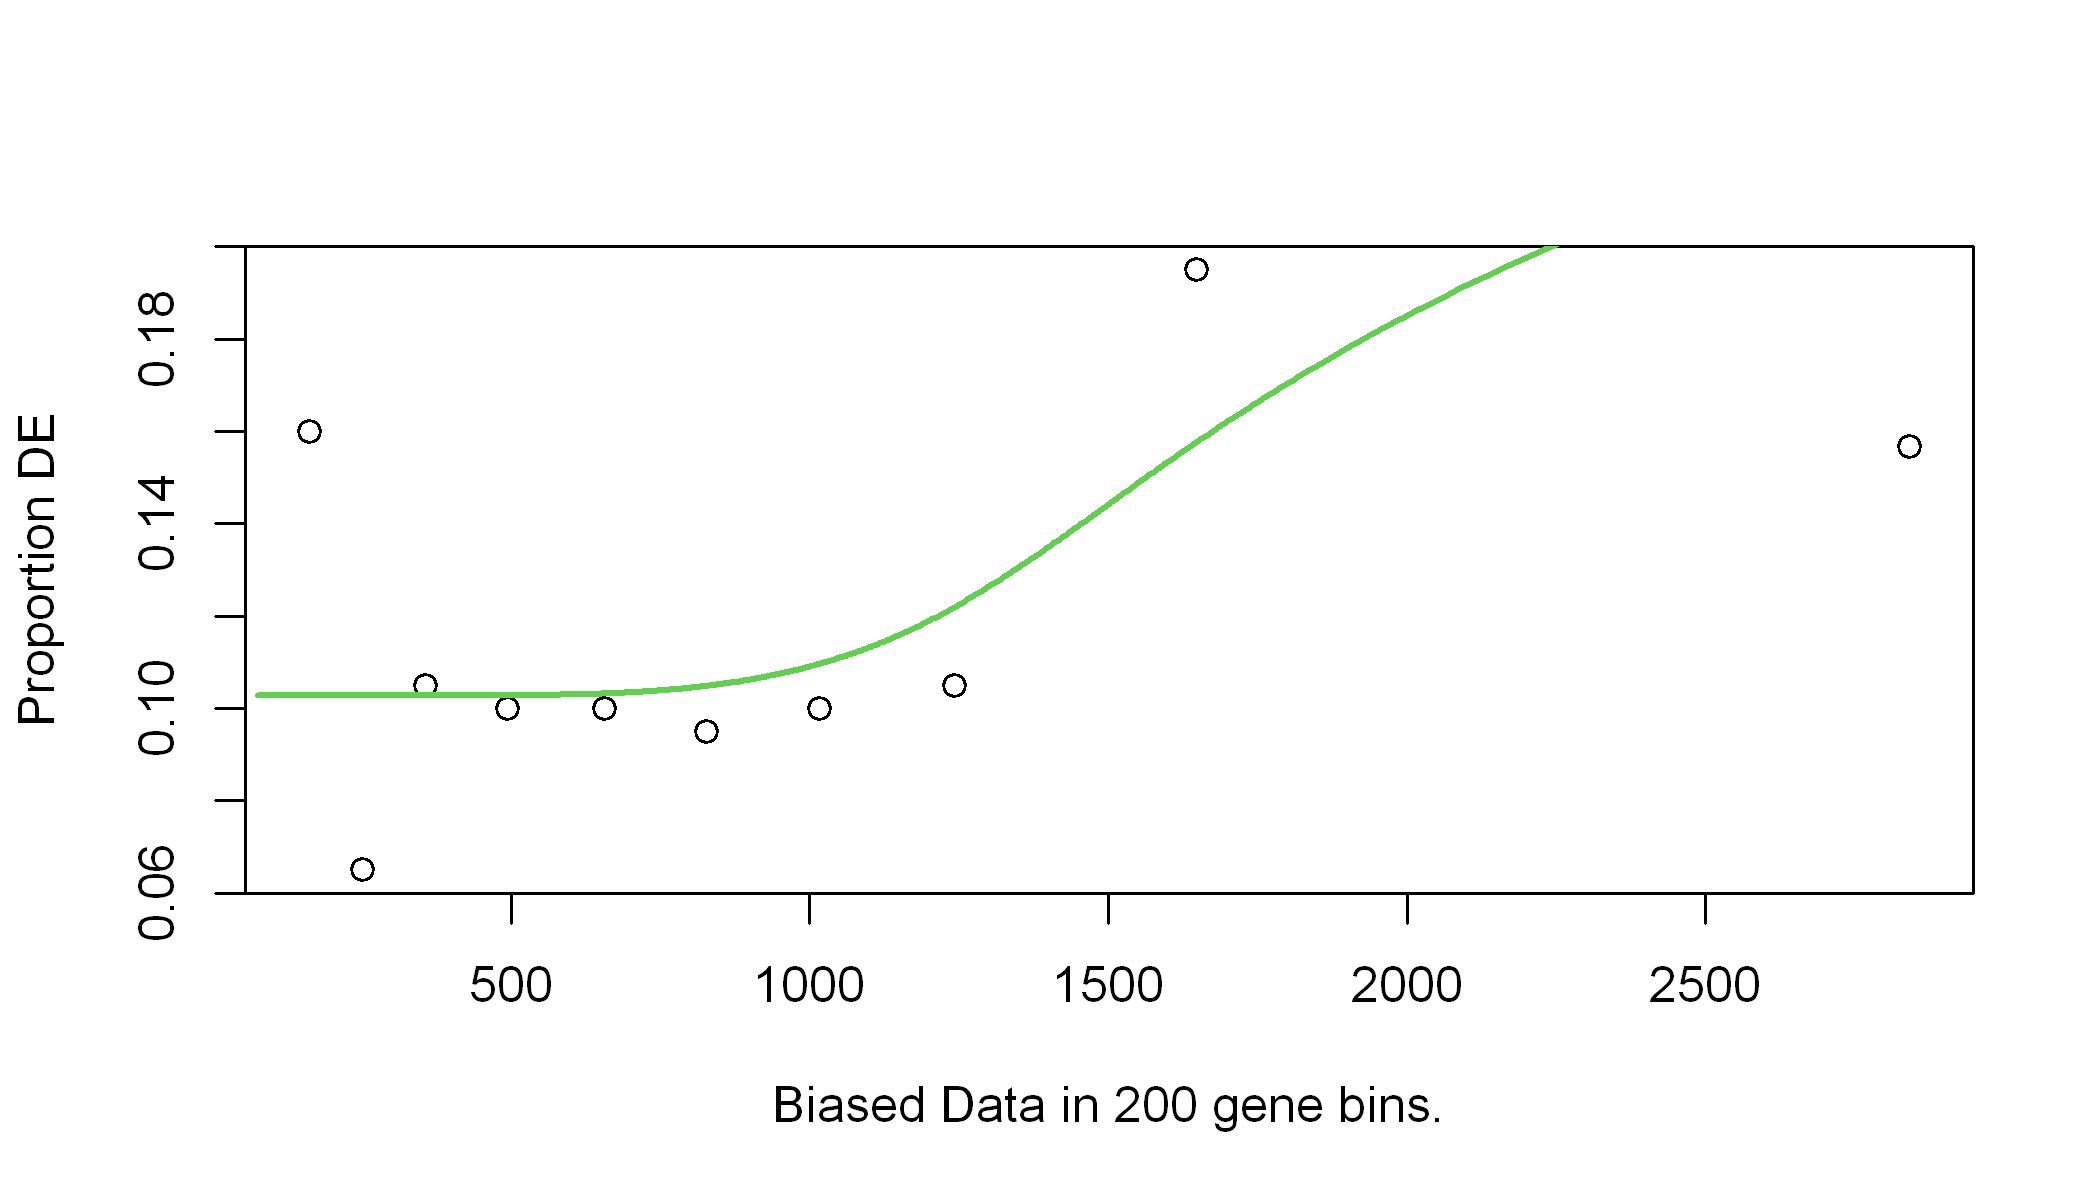

In [56]:
dlist = list()

for (contrastname in unique(df_all$contrast1)) 
{
    for (col in c('sub' ,'path')  #, 'main','ecpath')
             ) 
        {
        for (test in c('down', 'up')) 
            {
              dlist[[length(dlist) + 1]] <- run_enrichment(contrastname, col, test)
        }

    }
}
goseq_res = bind_rows(dlist)


In [57]:
goseq_res = goseq_res %>% 
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    extract(main, c("Category"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(pathway = str_replace(pathway, "in photosynthetic organisms", "")) %>%
    mutate(Category = word(Category)) %>%
    mutate(pathway = str_trim(pathway), Category = str_trim(Category)) 



In [58]:
goseq_res = goseq_res %>% 
    mutate(pathway = str_trim(pathway), Category = str_trim(Category)) 



In [59]:
goseq_res

category
1    09122   
2    09109   
3    09102   
4    09145   
5    09103   
6    09132   
7    09101   
8    09131   
9    09123   
10   09143   
11   09124   
12   09106   
13   09108   
14   09105   
15   09104   
16   09110   
17   09107   
18   09111   
19   09104   
20   09131   
21   09105   
22   09101   
23   09102   
24   09111   
25   09106   
26   09143   
27   09110   
28   09132   
29   09123   
30   09145   
⋮    ⋮       
2457 00230   
2458 03060   
2459 03018   
2460 03030   
2461 00400   
2462 00250   
2463 00860   
2464 00270   
2465 00260   
2466 00240   
2467 03440   
2468 00520   
2469 03010   
2470 00970   
2471 00195   
2472 00030   
2473 00051   
2474 00061   
2475 00290   
2476 00330   
2477 00450   
2478 00480   
2479 00500   
2480 00564   
2481 00640   
2482 00660   
2483 00720   
2484 00770   
2485 00780   
2486 02026   
     PATH                                                                    
1    09122 Translation                                                       
2    09109 Metabolism of terpenoids and polyketides                          
3    09102 Energy metabolism                                                 
4    09145 Cellular community - prokaryotes                                  
5    09103 Lipid metabolism                                                  
6    09132 Signal transduction                                               
7    09101 Carbohydrate metabolism                                           
8    09131 Membrane transport                                                
9    09123 Folding, sorting and degradation                                  
10   09143 Cell growth and death                                             
11   09124 Replication and repair                                            
12   09106 Metabolism of other amino acids                                   
13   09108 Metabolism of cofactors and vitamins                              
14   09105 Amino acid metabolism                                             
15   09104 Nucleotide metabolism                                             
16   09110 Biosynthesis of other secondary metabolites                       
17   09107 Glycan biosynthesis and metabolism                                
18   09111 Xenobiotics biodegradation and metabolism                         
19   09104 Nucleotide metabolism                                             
20   09131 Membrane transport                                                
21   09105 Amino acid metabolism                                             
22   09101 Carbohydrate metabolism                                           
23   09102 Energy metabolism                                                 
24   09111 Xenobiotics biodegradation and metabolism                         
25   09106 Metabolism of other amino acids                                   
26   09143 Cell growth and death                                             
27   09110 Biosynthesis of other secondary metabolites                       
28   09132 Signal transduction                                               
29   09123 Folding, sorting and degradation                                  
30   09145 Cellular community - prokaryotes                                  
⋮    ⋮                                                                       
2457 00230 Purine metabolism [PATH:ko00230]                                  
2458 03060 Protein export [PATH:ko03060]                                     
2459 03018 RNA degradation [PATH:ko03018]                                    
2460 03030 DNA replication [PATH:ko03030]                                    
2461 00400 Phenylalanine, tyrosine and tryptophan biosynthesis [PATH:ko00400]
2462 00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250]        
2463 00860 Porphyrin metabolism [PATH:ko00860]                               
2464 00270 Cysteine and methionine metabolism [PATH:ko00270]                 
2465 00260 Glycin

In [60]:
sub2path = hpath_df %>% select(sub, path) %>% distinct() 
goseq_res = left_join(goseq_res, sub2path, by=c(PATH='path')) %>% mutate(sub = if_else(is.na(sub), PATH, sub))

In [61]:
goseq_res = goseq_res %>% 
    extract(sub, c("module"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(module = str_replace(module, "in photosynthetic organisms", "")) %>%
    mutate(module = str_replace(module, "metabolism", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis of", "")) %>%
    mutate(module = str_replace(module, "Metabolism of", "")) %>%
    mutate(module = str_replace(module, "biosynthesis", "")) %>%
    mutate(module = str_trim(module)) 



In [62]:
goseq_res = goseq_res %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) 


In [63]:
goseq_res %>% write_csv(file.path('DE_results', 'MED4_GOSEQ_results.csv'))

In [64]:
df_all %>% write_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

In [65]:
top10 = goseq_res %>% 
  #filter(enrich == 'sub') %>%
  filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  arrange(padj, over_represented_pvalue) %>%
  head(n=50) 
  
hpath_df %>% filter(path %in% top10$PATH) %>% select(main,sub, path) %>% distinct() %>% arrange(main)

main                                      
1  09100 Metabolism                          
2  09100 Metabolism                          
3  09100 Metabolism                          
4  09100 Metabolism                          
5  09100 Metabolism                          
6  09100 Metabolism                          
7  09100 Metabolism                          
8  09100 Metabolism                          
9  09100 Metabolism                          
10 09100 Metabolism                          
11 09100 Metabolism                          
12 09100 Metabolism                          
13 09100 Metabolism                          
14 09100 Metabolism                          
15 09100 Metabolism                          
16 09100 Metabolism                          
17 09120 Genetic Information Processing      
18 09120 Genetic Information Processing      
19 09130 Environmental Information Processing
   sub                                           
1  09104 Nucleotide metabolism                   
2  09105 Amino acid metabolism                   
3  09105 Amino acid metabolism                   
4  09101 Carbohydrate metabolism                 
5  09102 Energy metabolism                       
6  09103 Lipid metabolism                        
7  09108 Metabolism of cofactors and vitamins    
8  09104 Nucleotide metabolism                   
9  09101 Carbohydrate metabolism                 
10 09106 Metabolism of other amino acids         
11 09109 Metabolism of terpenoids and polyketides
12 09101 Carbohydrate metabolism                 
13 09105 Amino acid metabolism                   
14 09102 Energy metabolism                       
15 09109 Metabolism of terpenoids and polyketides
16 09102 Energy metabolism                       
17 09122 Translation                             
18 09122 Translation                             
19 09131 Membrane transport                      
   path                                                            
1  00230 Purine metabolism [PATH:ko00230]                          
2  00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250]
3  00220 Arginine biosynthesis [PATH:ko00220]                      
4  00010 Glycolysis / Gluconeogenesis [PATH:ko00010]               
5  00710 Carbon fixation in photosynthetic organisms [PATH:ko00710]
6  00061 Fatty acid biosynthesis [PATH:ko00061]                    
7  00860 Porphyrin metabolism [PATH:ko00860]                       
8  00240 Pyrimidine metabolism [PATH:ko00240]                      
9  00030 Pentose phosphate pathway [PATH:ko00030]                  
10 00480 Glutathione metabolism [PATH:ko00480]                     
11 00906 Carotenoid biosynthesis [PATH:ko00906]                    
12 00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630]    
13 00340 Histidine metabolism [PATH:ko00340]                       
14 00195 Photosynthesis [PATH:ko00195]                             
15 00900 Terpenoid backbone biosynthesis [PATH:ko00900]            
16 00910 Nitrogen metabolism [PATH:ko00910]                        
17 00970 Aminoacyl-tRNA biosynthesis [PATH:ko00970]                
18 03010 Ribosome [PATH:ko03010]                                   
19 02010 ABC transporters [PATH:ko02010]

In [66]:
top10 = goseq_res %>% 
  filter(enrich == 'sub') %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  arrange(padj, over_represented_pvalue) %>%
  head(n=50) 
  
hpath_df %>% filter(sub %in% top10$PATH) %>% select(main,sub) %>% distinct() %>% arrange(main)

main                                      
1  09100 Metabolism                          
2  09100 Metabolism                          
3  09100 Metabolism                          
4  09100 Metabolism                          
5  09100 Metabolism                          
6  09100 Metabolism                          
7  09100 Metabolism                          
8  09100 Metabolism                          
9  09100 Metabolism                          
10 09120 Genetic Information Processing      
11 09130 Environmental Information Processing
12 09140 Cellular Processes                  
   sub                                              
1  09104 Nucleotide metabolism                      
2  09105 Amino acid metabolism                      
3  09108 Metabolism of cofactors and vitamins       
4  09101 Carbohydrate metabolism                    
5  09102 Energy metabolism                          
6  09103 Lipid metabolism                           
7  09106 Metabolism of other amino acids            
8  09110 Biosynthesis of other secondary metabolites
9  09109 Metabolism of terpenoids and polyketides   
10 09122 Translation                                
11 09131 Membrane transport                         
12 09143 Cell growth and death

In [67]:
head(goseq_res)

category PATH                                          
1 09122    09122 Translation                             
2 09109    09109 Metabolism of terpenoids and polyketides
3 09102    09102 Energy metabolism                       
4 09145    09145 Cellular community - prokaryotes        
5 09103    09103 Lipid metabolism                        
6 09132    09132 Signal transduction                     
  pathway                                  over_represented_pvalue padj        
1 Translation                              1.449809e-09            2.609655e-08
2 Metabolism of terpenoids and polyketides 1.514088e-01            1.000000e+00
3 Energy metabolism                        2.202984e-01            1.000000e+00
4 Cellular community - prokaryotes         2.860677e-01            1.000000e+00
5 Lipid metabolism                         5.852261e-01            1.000000e+00
6 Signal transduction                      6.521043e-01            1.000000e+00
  under_represented_pvalue numDEInCat numInCat
1 1.0000000                23          74     
2 0.9480650                 4          25     
3 0.8678961                11         105     
4 0.8900496                 3          22     
5 0.6993905                 2          24     
6 0.6295640                 2          27     
  main                                       Category      type enrich Assay
1 09120 Genetic Information Processing       Genetic       down sub    prot 
2 09100 Metabolism                           Metabolism    down sub    prot 
3 09100 Metabolism                           Metabolism    down sub    prot 
4 09140 Cellular Processes                   Cellular      down sub    prot 
5 09100 Metabolism                           Metabolism    down sub    prot 
6 09130 Environmental Information Processing Environmental down sub    prot 
  contrast    organism sub                                           
1 C2vsC1_prot MED4     09122 Translation                             
2 C2vsC1_prot MED4     09109 Metabolism of terpenoids and polyketides
3 C2vsC1_prot MED4     09102 Energy metabolism                       
4 C2vsC1_prot MED4     09145 Cellular community - prokaryotes        
5 C2vsC1_prot MED4     09103 Lipid metabolism                        
6 C2vsC1_prot MED4     09132 Signal transduction                     
  module                           Group    
1 Translation                      Coculture
2 terpenoids and polyketides       Coculture
3 Energy                           Coculture
4 Cellular community - prokaryotes Coculture
5 Lipid                            Coculture
6 Signal transduction              Coculture

In [68]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

Assay Group      
C1vsP1_rna     rna   Coculture  
C2vsC1_rna     rna   Coculture  
C3vsC1_rna     rna   Coculture  
C4vsC1_rna     rna   Coculture  
C5vsC1_rna     rna   Coculture  
LATEvsC1P1_rna rna   Coculture  
C2vsC1_prot    prot  Coculture  
C3vsC1_prot    prot  Coculture  
C4vsC1_prot    prot  Coculture  
C5vsC1_prot    prot  Coculture  
LATEvsC1_prot  prot  Coculture  
P2vsP1_rna     rna   Axenic     
P2vsP1_prot    prot  Axenic     
P3vsP1_prot    prot  Axenic late
P5vsP1_prot    prot  Axenic late

In [69]:
#toppaths = 
path_meta = goseq_res %>% 
    filter(#enrich=='path', 
           padj < 0.05) %>% 
    distinct(PATH, main) %>%
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    extract(main, c("Category"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    mutate(Category = word(Category)) %>%
    column_to_rownames('pathway') 
#d_meta = d %>% select(Category, pathway) %>%column_to_rownames('pathway') 
path_meta

Category     
Translation                                  Genetic      
Nucleotide metabolism                        Metabolism   
Membrane transport                           Environmental
Amino acid metabolism                        Metabolism   
Carbohydrate metabolism                      Metabolism   
Ribosome                                     Genetic      
Arginine biosynthesis                        Metabolism   
Nitrogen metabolism                          Metabolism   
Purine metabolism                            Metabolism   
ABC transporters                             Environmental
Alanine, aspartate and glutamate metabolism  Metabolism   
Citrate cycle (TCA cycle)                    Metabolism   
Energy metabolism                            Metabolism   
Metabolism of terpenoids and polyketides     Metabolism   
Photosynthesis                               Metabolism   
Glyoxylate and dicarboxylate metabolism      Metabolism   
Lipid metabolism                             Metabolism   
Biosynthesis of other secondary metabolites  Metabolism   
Aminoacyl-tRNA biosynthesis                  Genetic      
Fatty acid biosynthesis                      Metabolism   
Terpenoid backbone biosynthesis              Metabolism   
Metabolism of other amino acids              Metabolism   
Pyrimidine metabolism                        Metabolism   
Glutathione metabolism                       Metabolism   
Histidine metabolism                         Metabolism   
Carbon fixation in photosynthetic organisms  Metabolism   
Glycolysis / Gluconeogenesis                 Metabolism   
Pentose phosphate pathway                    Metabolism   
Porphyrin metabolism                         Metabolism   
Carotenoid biosynthesis                      Metabolism

In [70]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [71]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [72]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [73]:
-log10(0.05)

[1] 1.30103

Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"Note: not all columns in the data frame are numeric. The data frame
will be converted into a character matrix."


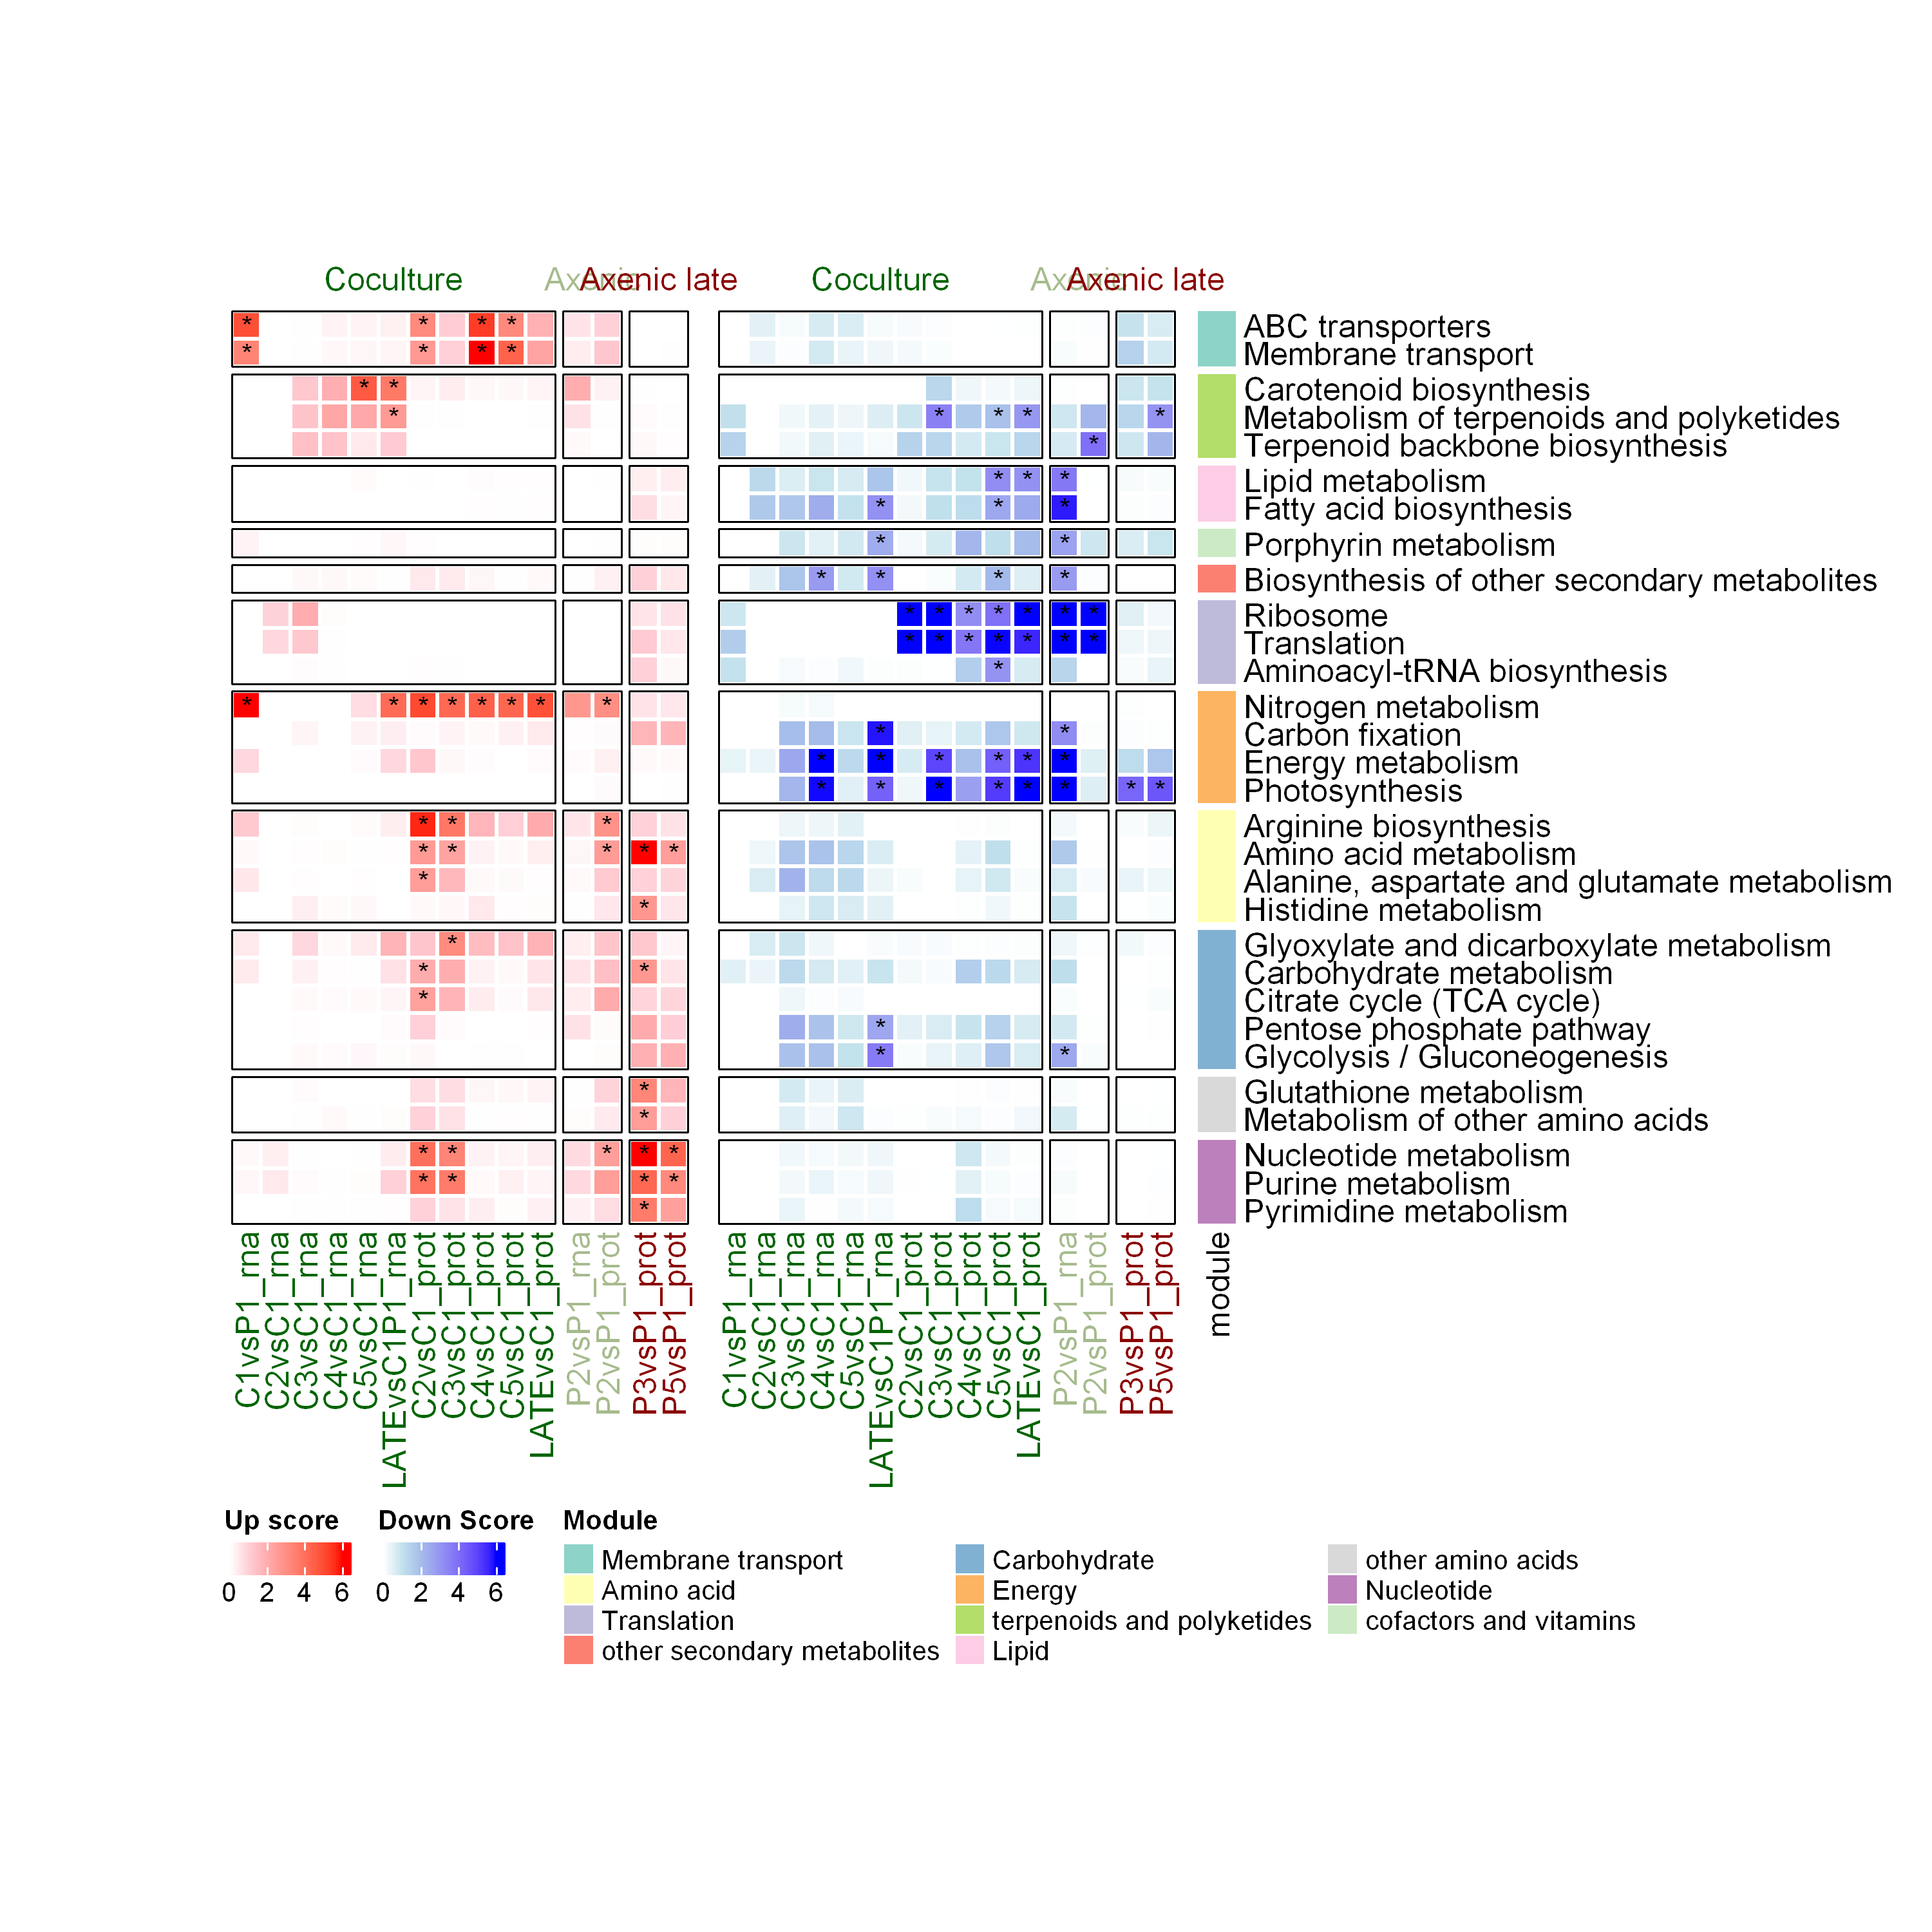

In [74]:
toppaths = goseq_res %>% 
    filter(#enrich=='path', 
           padj < 0.05) %>% 
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Up score',
    col=pupgoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(12, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Down Score',
    col=pdowngoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(15, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

gene_type_col = 
ann_mat = Heatmap(
    module_mat, 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
    row_title=FALSE,
)

ht_list = up_mat + down_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

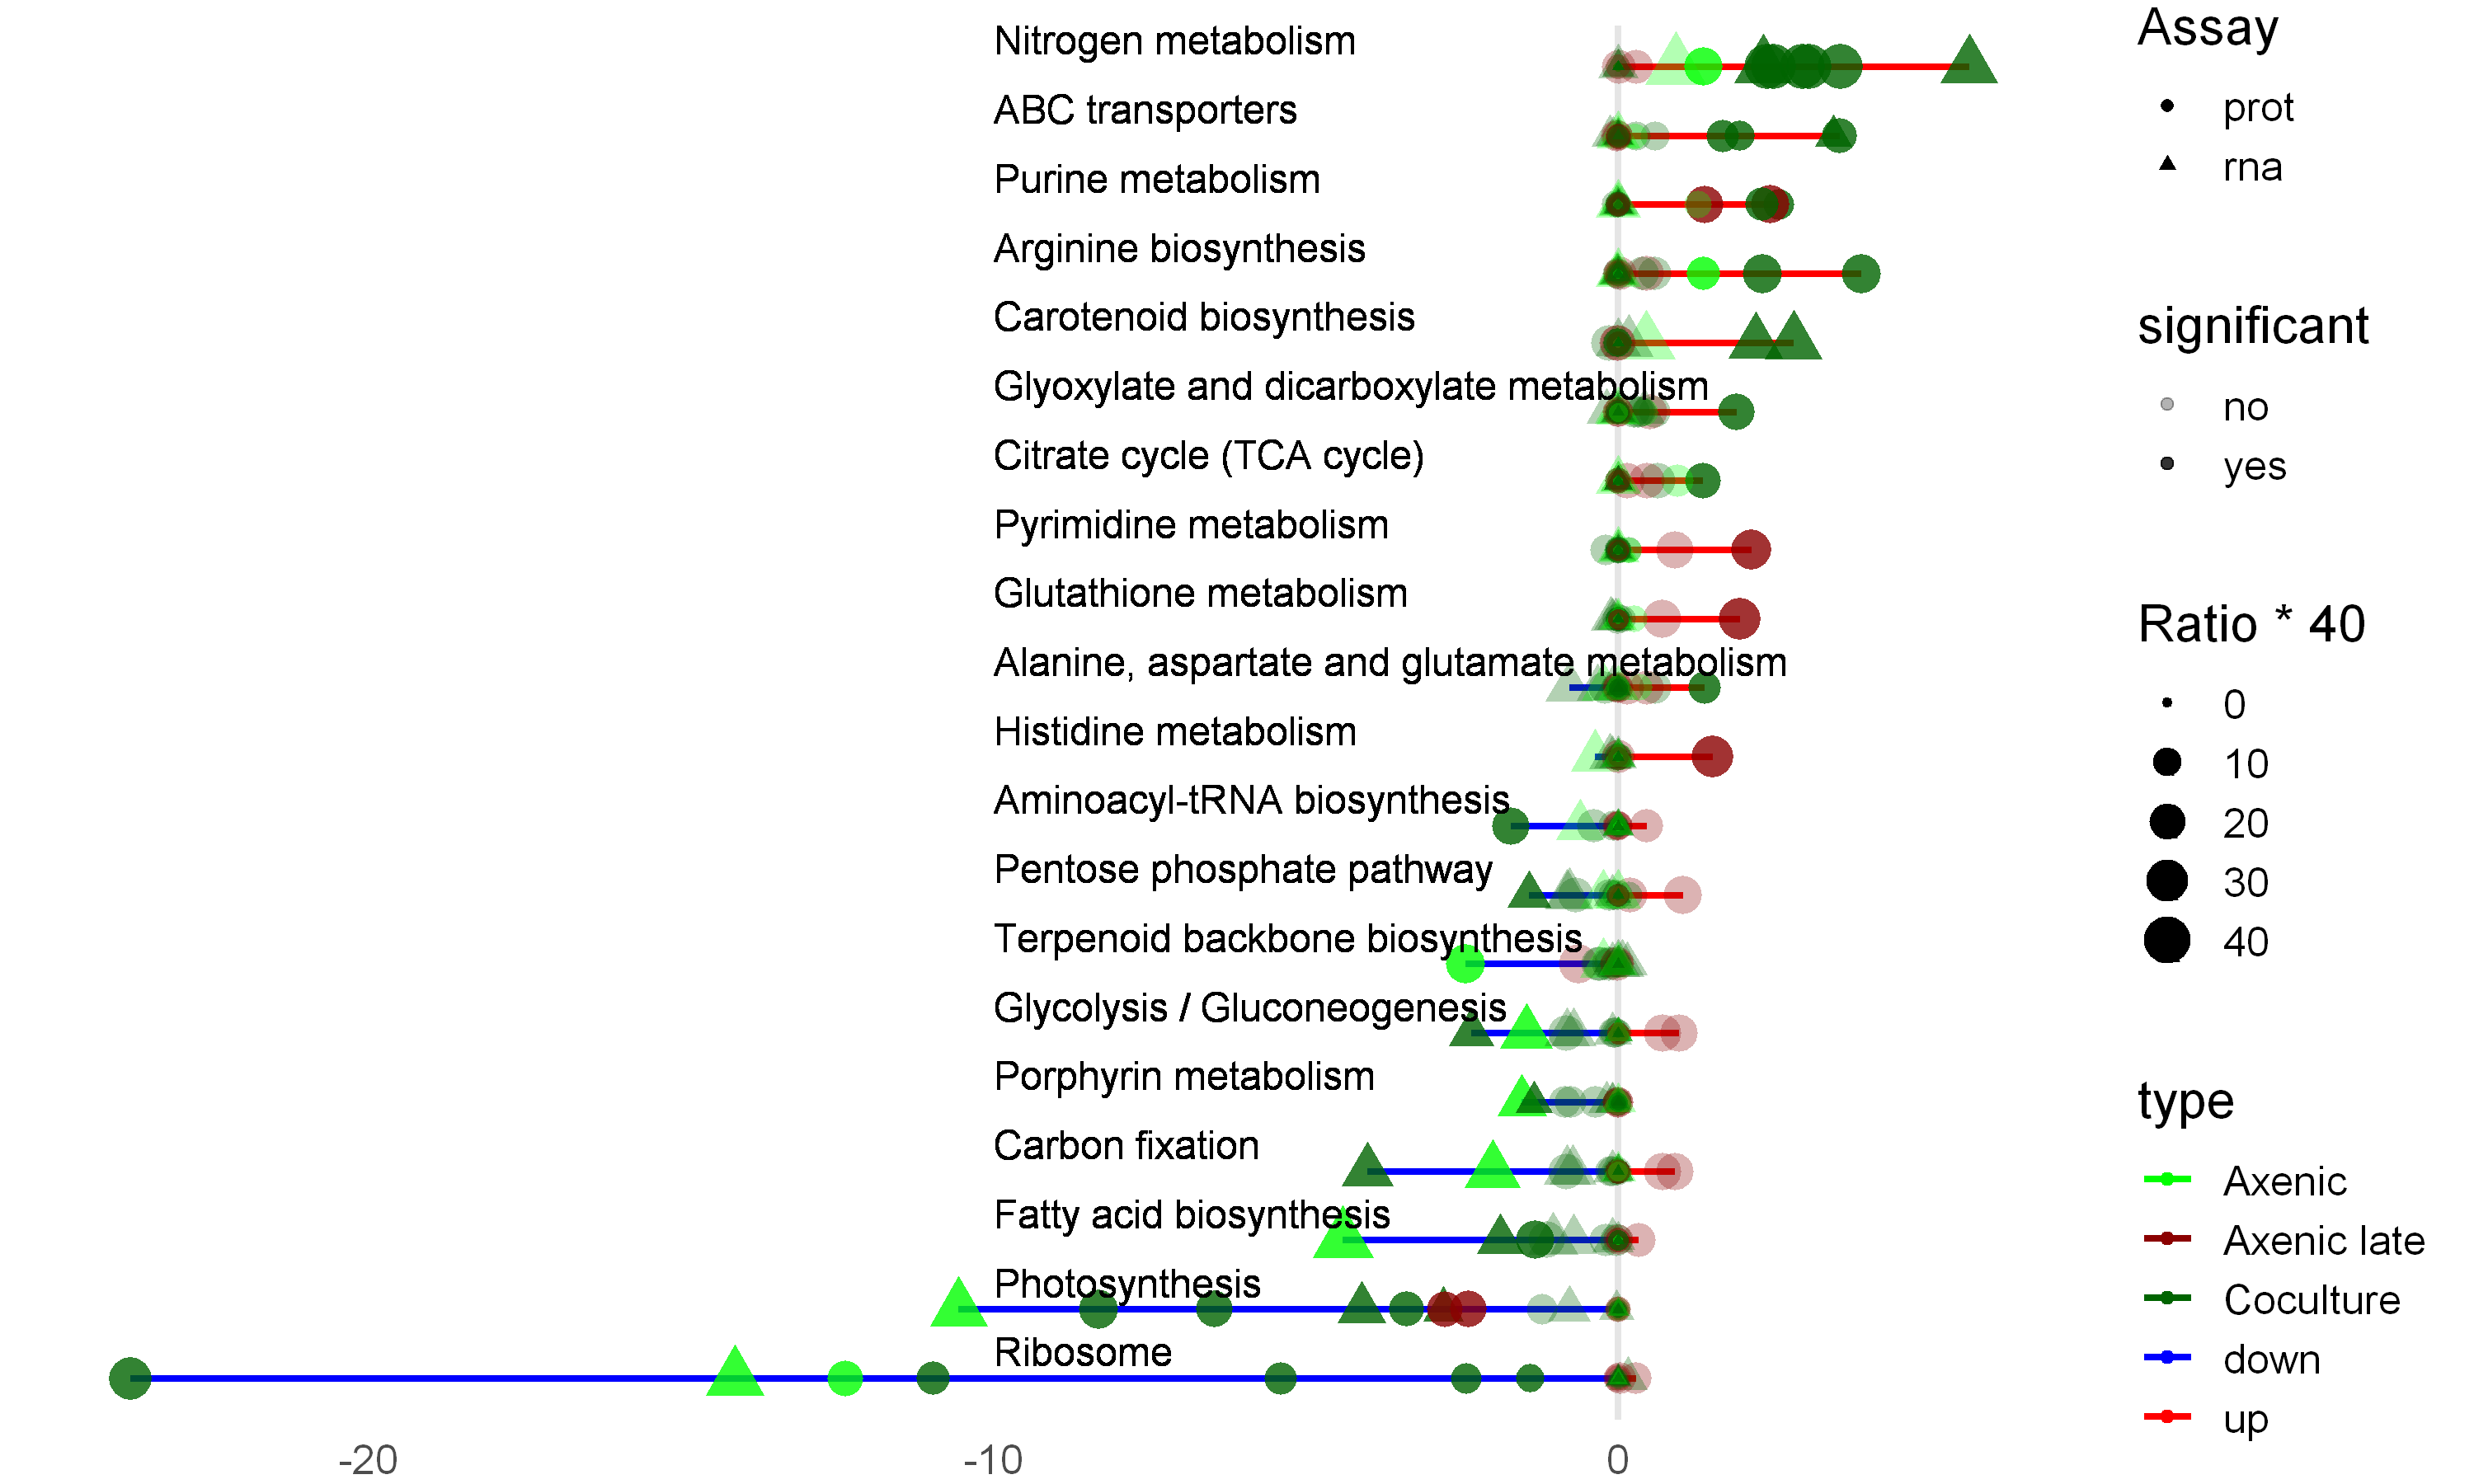

In [75]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='path', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(significant = ifelse(padj < 0.05, 'yes', 'no')) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun = 'mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group, alpha=significant)) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  scale_alpha_manual(values = c(no=0.3,yes=0.8)) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




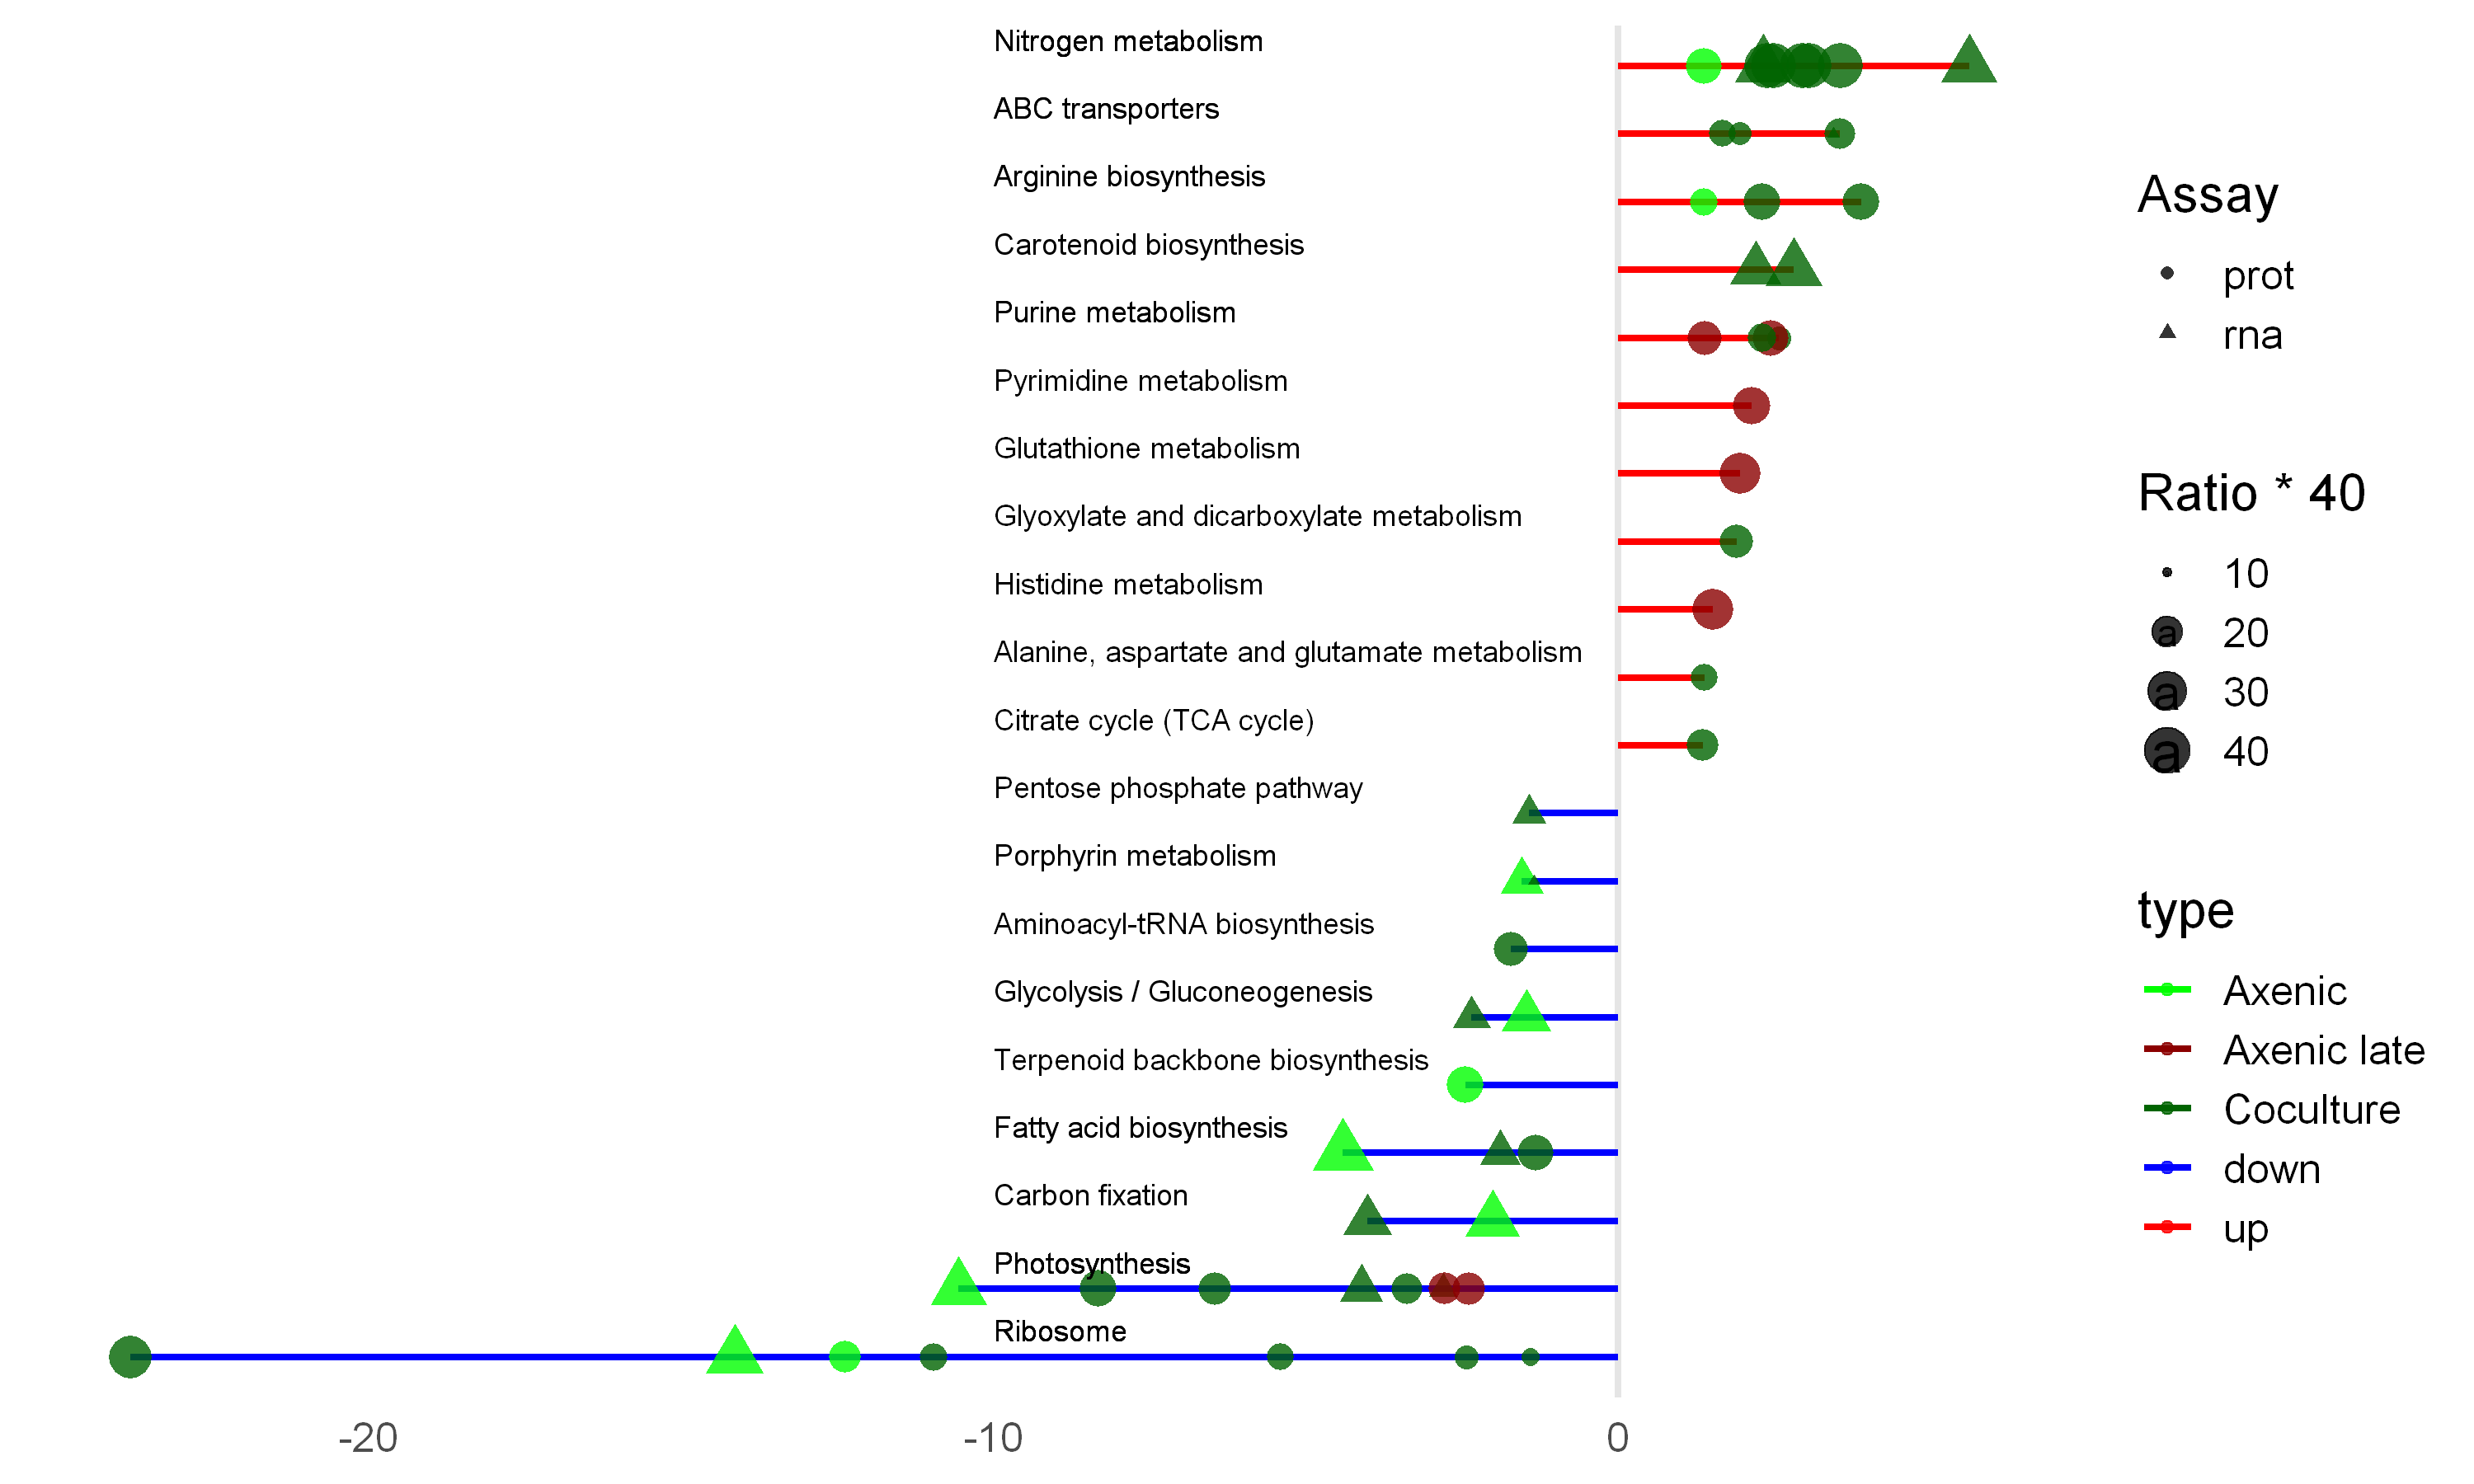

In [76]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='path', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  filter(padj < 0.05) %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun = 'mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group), alpha=0.8) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




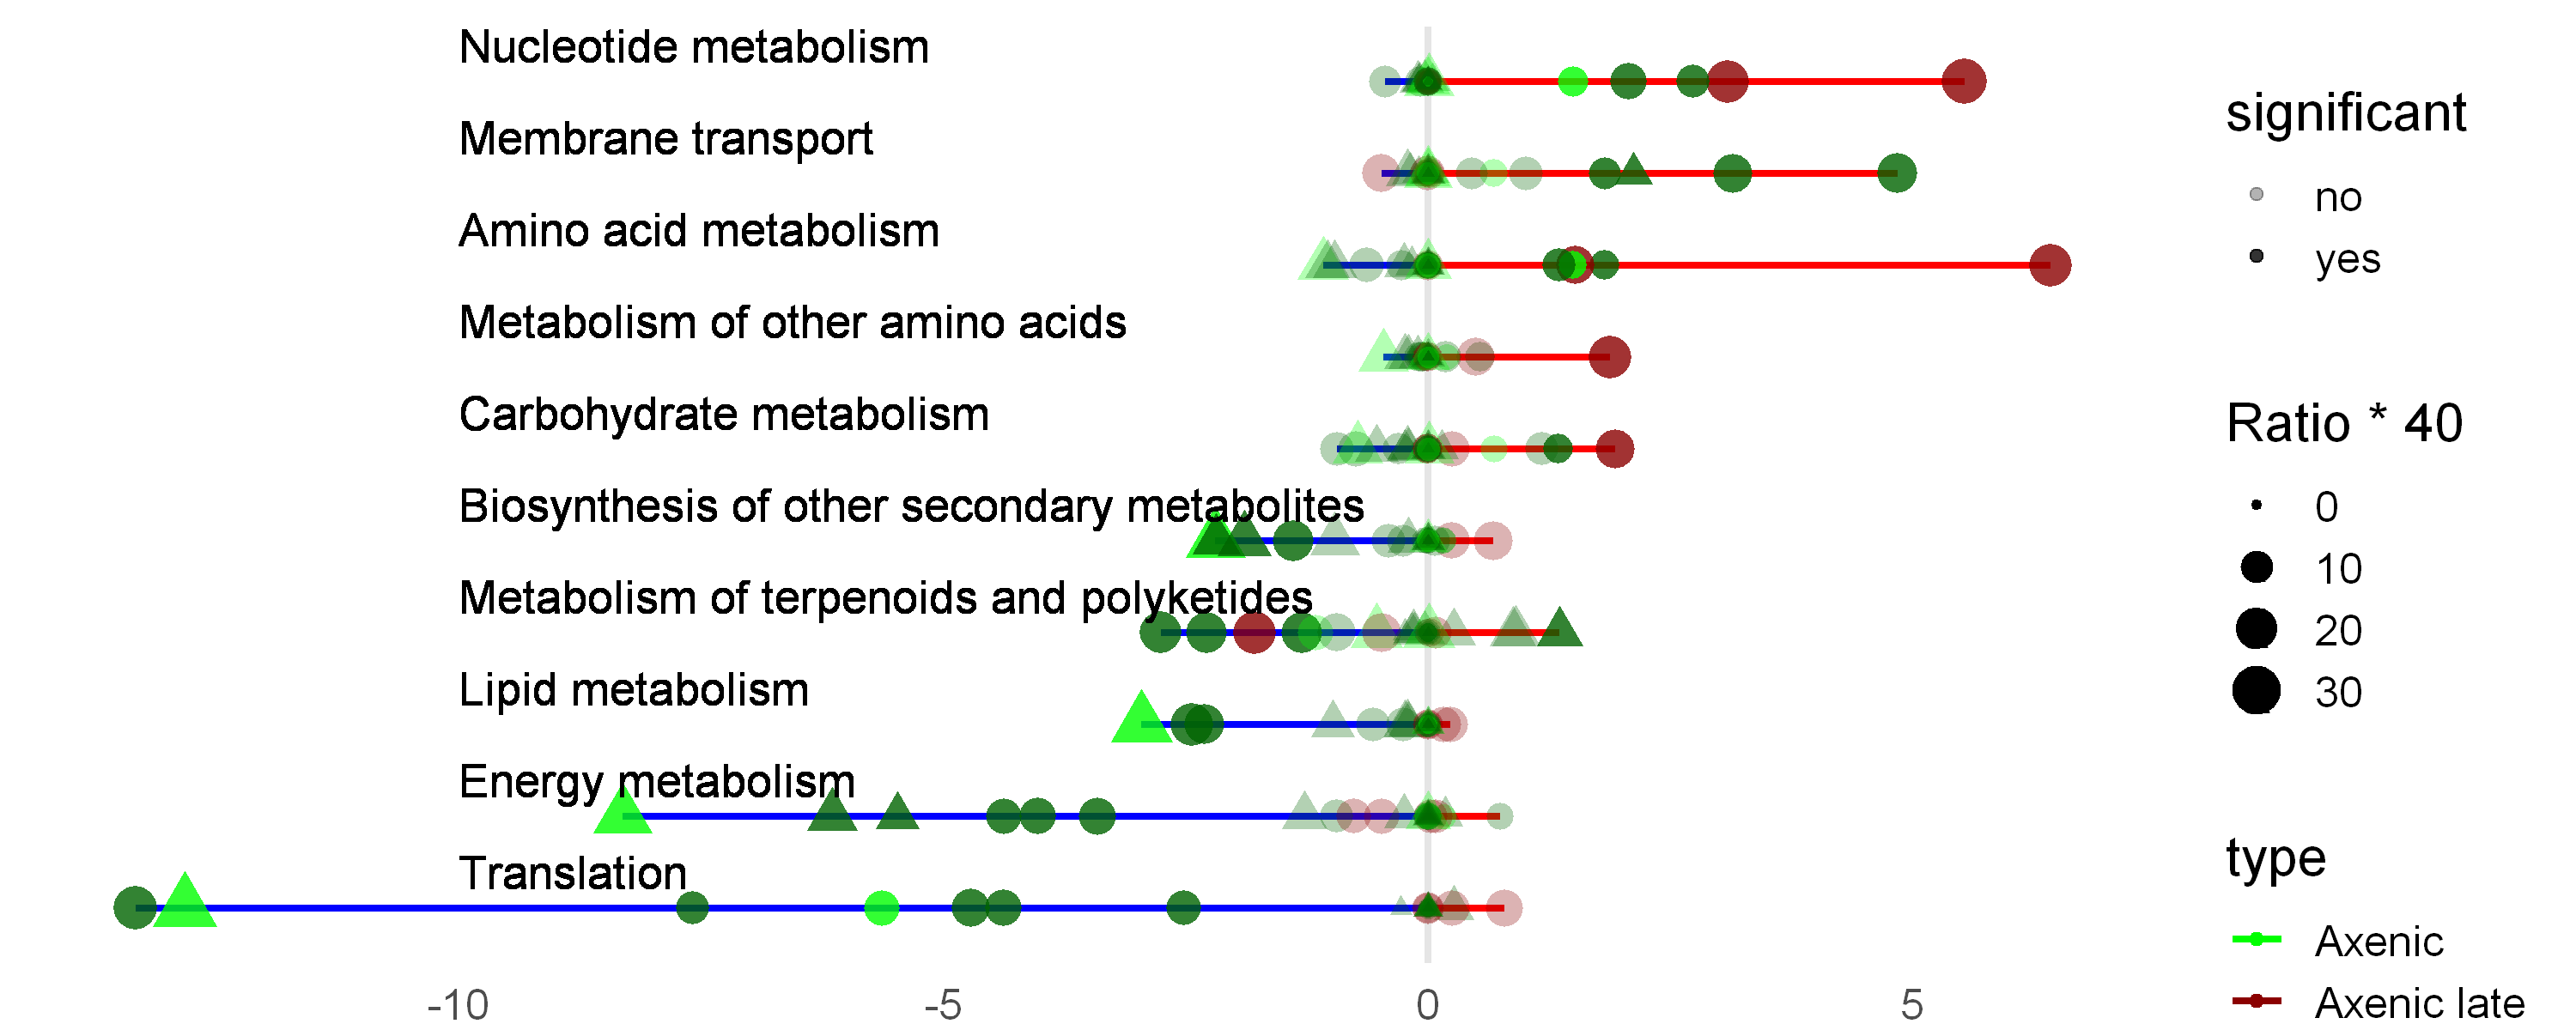

In [77]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='sub', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(significant = ifelse(padj < 0.05, 'yes', 'no')) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun='mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group, alpha=significant)) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  scale_alpha_manual(values = c(no=0.3,yes=0.8)) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




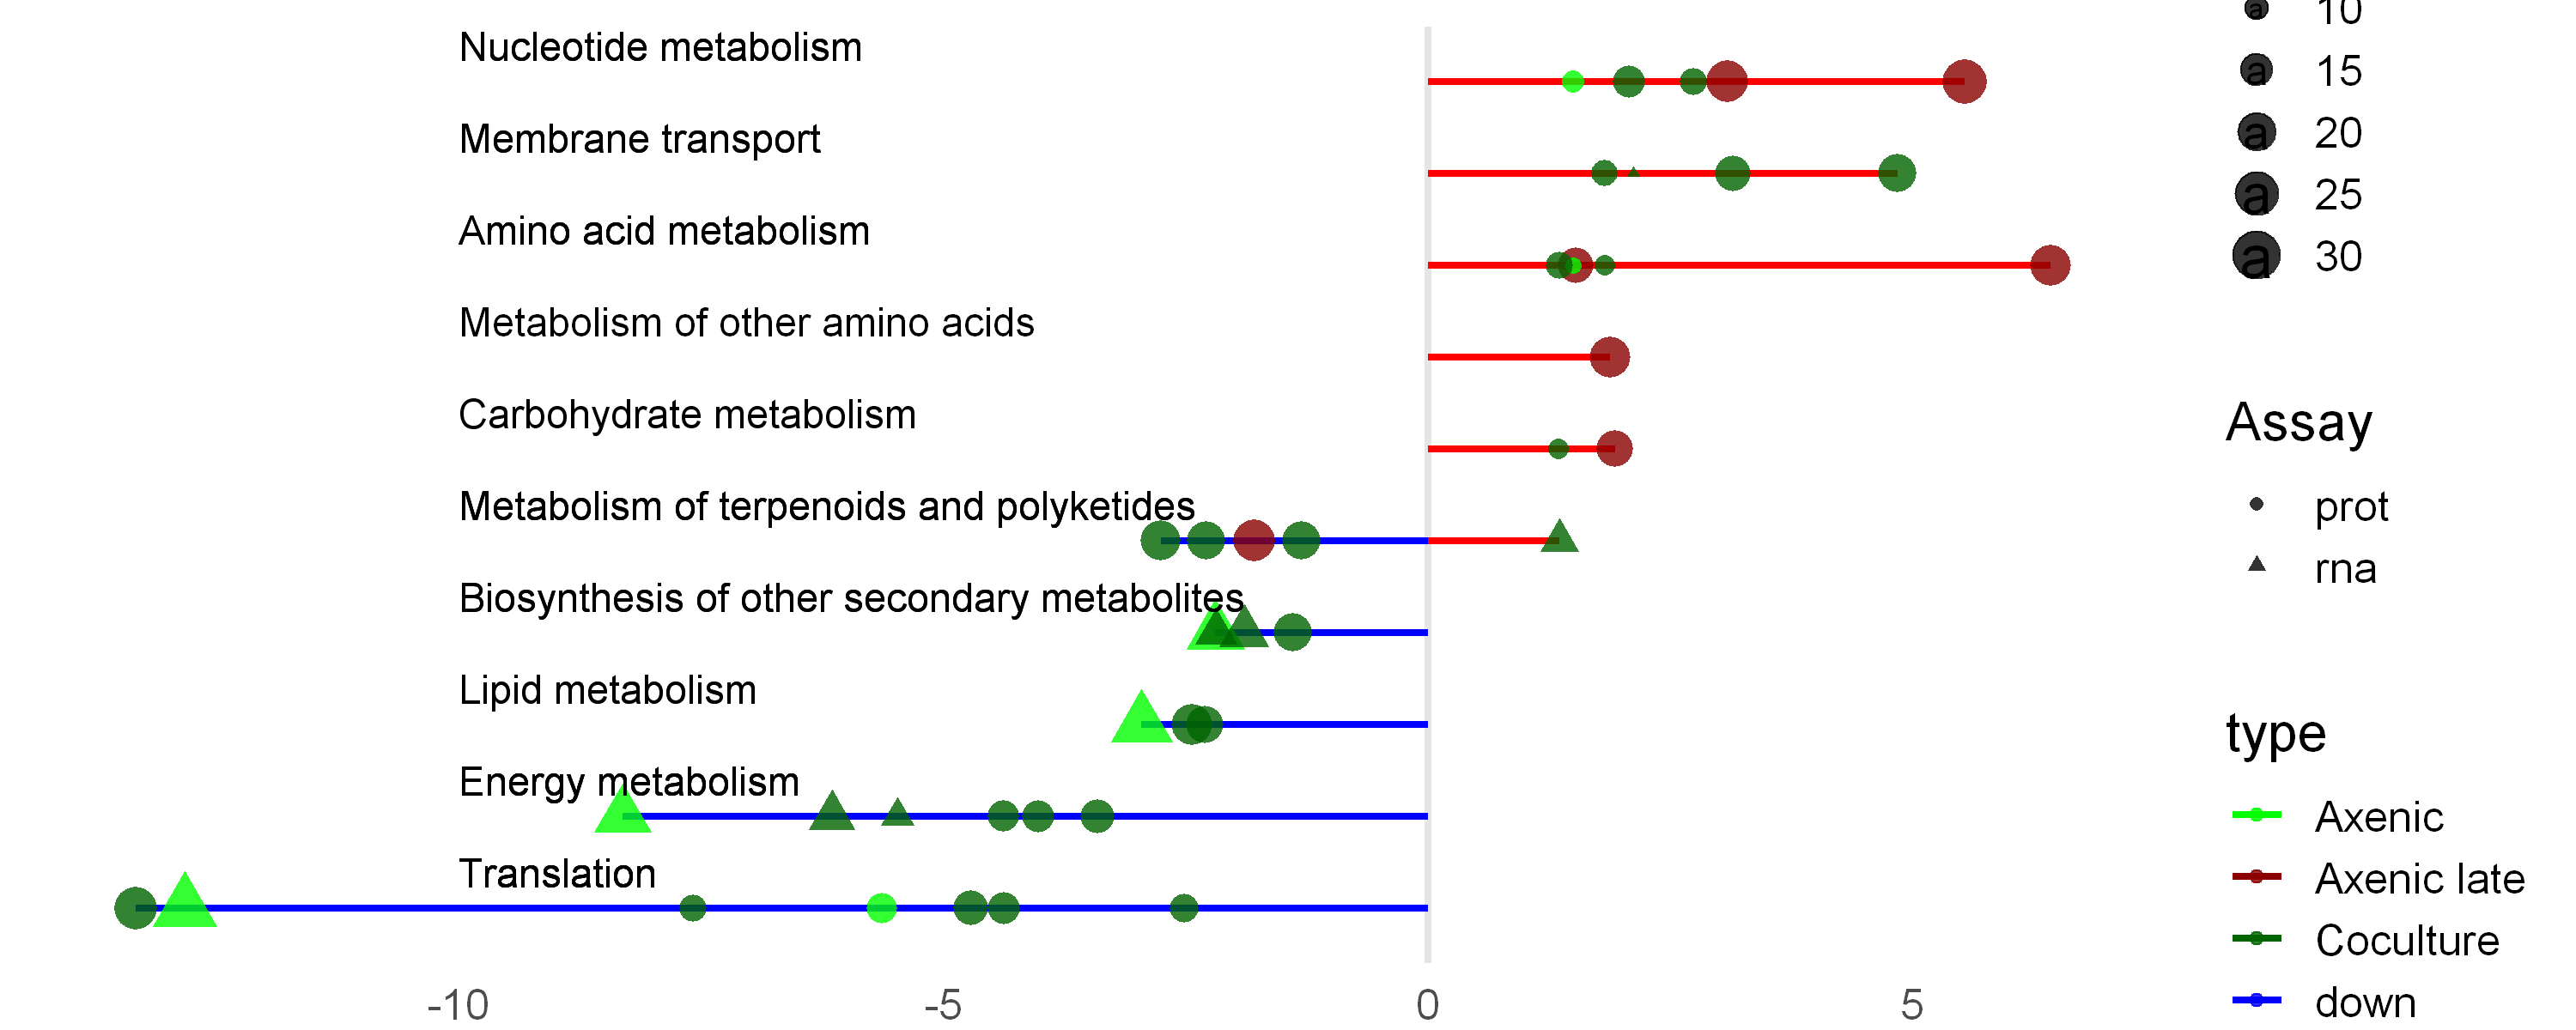

In [78]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='sub', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  filter(padj < 0.05) %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun='mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group), alpha=0.8) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




In [79]:
goseq_res %>% 
  #filter(enrich == 'sub') %>%
  filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>% 
#  tail(n=1000) %>% 
distinct(main)



main                                      
1 09120 Genetic Information Processing      
2 09100 Metabolism                          
3 09130 Environmental Information Processing
4 09140 Cellular Processes

In [80]:
goseq_res %>% 
  filter(enrich == 'sub') %>%
  #filter(enrich == 'path') %>%
  filter(str_detect(contrast, 'C1')) %>% 

  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>% 
  #head(n=50) %>% distinct(pathway)
  filter(padj < 0.05)%>% distinct(pathway)

pathway                                    
1 Translation                                
2 Energy metabolism                          
3 Membrane transport                         
4 Metabolism of terpenoids and polyketides   
5 Nucleotide metabolism                      
6 Lipid metabolism                           
7 Biosynthesis of other secondary metabolites
8 Amino acid metabolism                      
9 Carbohydrate metabolism

In [81]:
df_DElist %>% 
    filter(str_detect(sub,  'Translation')) %>% 
    filter(padj < 0.05) %>%
    filter(str_detect(contrast1, 'C1')) %>% 
    mutate(type = if_else(logFC >0, 'up', 'down')) %>%

    group_by(type) %>% distinct(type, gene) %>%
#distinct(gene) %>%
  summarize(strong = str_c(gene, collapse = ' '), .groups = 'drop')

type
1 down
2 up  
  strong                                                                                                                                                                                                                                                                                           
1  rpsB rpmB rplE rpsH rplM rpsC rpsI rplO rpsG rplN rpsJ rplI rplA rplD rplB rpsE rpsP rpsS rpsQ rplF rpsM rplJ rplP rpmA rplS alaS rplV rpsD rplX rplC rpsK rpsO argS rplQ rplR rpsL rpsN fmt rpsR rpsU pheT ileS lysS thrS leuS gltX pheS glyS trpS serS gatA gatB rplU rplT rpmE gatC rpsT rpmI
2  metG hisS rplL rpmC rpsB rplJ rplD rplC rpmF rpmG rpmB rpsO gatA rpsU rpsN rpsP rpmA rplQ rpsM rpmJ cysS lysS

In [82]:
df_DElist %>% 
    filter(str_detect(path,  'Carotenoid biosynthesis')) %>% 
    filter(padj < 0.05) %>%
    filter(str_detect(contrast1, 'C1')) %>% 
    mutate(type = if_else(logFC >0, 'up', 'down')) %>%

    group_by(type) %>%
#distinct(gene) %>%
  summarize(strong = str_c(gene, collapse = ' '), .groups = 'drop')

type strong                                                  
1 down    crtH crtH   crtH                                     
2 up   pds  pds pds pds zds  pds  zds  zds  pds  zds pds   crtH

In [83]:
df_DElist %>% 
    #filter(str_detect(path,  'Arginine biosynthesis')) %>% 
    filter(padj < 0.05) %>%
    filter(logFC > 0) %>%
    filter(str_detect(contrast1, 'C1')) %>% distinct(gene) %>%
  summarize(strong = str_c(gene, collapse = ' '), .groups = 'drop')

strong                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1  ureC acnB urtD cynS urtE urtC purS ntrB ntcA dnaA glnA ilvN serA minD trmD aroC purB obgE pgl ppc thyX speA eno recR coaD zwf gndA uvrA urtA cobA selD purL gltB pdxA guaA dnaB dnaN prmA metG gpmI cobO purM cysK glmU dnaK rsmI amt mgtE sppA ureG purU minE trxA msrA hisS gcvT ftsZ cobN rdgB purH argB folD murJ pyrR proC ribH lptC gcvH dcd surE gorA ilvA nuoH larB pds grpE purQ folB lspA glmS tgt kaiB sfsA dapA malQ hslO argJ recA speE groES psb28 secD msrB secF uvrC rplL argF pstS gloA tmk rpmC accB ftsH metK pgsA hisIE pyrC rsfS rodA rimO pstA mreC tsaE truA sufC gmk queG dusA dnaJ rsgA def zds ndhI trpB psbN mtnP der lepA ctaD sds rluF ispG rpsB mfd umuD gyrA pdhA purD lipA crtD lexA rplJ rplD rplC mrdA sufB nadB plsX arfB ispD map hemL glk typA rpmF rpmG ribA rpmB rsmA rpsO gatA rpsU bioB rpsN ribD rpsP lpxC rpmA infB rplQ rpsM infC cysE secA thrC rpmJ larC priA thrB aroA lysA polA cysS alr miaA mnmG bchM psbA arsJ ccsB crtH lysS

In [84]:
df_DElist

contrast gene_id      logFC      AveExpr     pvalue       padj        
1     C2 - C1  TX50_RS01980  2.6029332  0.91671556 5.951467e-07 0.0004868287
2     C2 - C1  TX50_RS05125  1.7956460  2.04648813 8.763244e-07 0.0004868287
3     C2 - C1  TX50_RS09075  1.1167539  1.46785946 1.025622e-06 0.0004868287
4     C2 - C1  TX50_RS05175  1.4380690 -0.20702445 2.486196e-06 0.0008850858
5     C2 - C1  TX50_RS08845 -0.9884268  3.74974295 3.186503e-06 0.0009075161
6     C2 - C1  TX50_RS01985  1.7087460 -0.25577666 5.226353e-06 0.0012403878
7     C2 - C1  TX50_RS05585  2.3211759 -1.72601579 6.907967e-06 0.0014052779
8     C2 - C1  TX50_RS05180  1.4995632  1.34725170 1.099431e-05 0.0017487735
9     C2 - C1  TX50_RS05170  1.6961969 -1.34694055 1.135667e-05 0.0017487735
10    C2 - C1  TX50_RS07865  1.3468844  1.29842981 1.244679e-05 0.0017487735
11    C2 - C1  TX50_RS04160  1.0422090 -0.19498831 1.468205e-05 0.0017487735
12    C2 - C1  TX50_RS07755 -1.6856352  3.03145873 1.531966e-05 0.0017487735
13    C2 - C1  TX50_RS01975  2.7204049 -2.51073856 1.615740e-05 0.0017487735
14    C2 - C1  TX50_RS01795  1.1292019 -2.13131898 1.719300e-05 0.0017487735
15    C2 - C1  TX50_RS05830  1.2333476 -1.38758233 2.254932e-05 0.0021406822
16    C2 - C1  TX50_RS01620 -1.0312176  4.75975157 2.667470e-05 0.0023740479
17    C2 - C1  TX50_RS05135  2.1339753 -0.45089397 2.942548e-05 0.0023777618
18    C2 - C1  TX50_RS04285  0.8861923  5.19382242 3.005598e-05 0.0023777618
19    C2 - C1  TX50_RS00840  0.9973780  2.83088462 3.244572e-05 0.0024317214
20    C2 - C1  TX50_RS07090  0.8326759  4.39304956 3.637684e-05 0.0025900308
21    C2 - C1  TX50_RS01275  1.7603264  1.24846350 4.978681e-05 0.0032116453
22    C2 - C1  TX50_RS05580  2.9084625 -0.98016783 5.184816e-05 0.0032116453
23    C2 - C1  TX50_RS05115  0.9566263  1.07116629 5.258699e-05 0.0032116453
24    C2 - C1  TX50_RS03160 -0.8411973  1.55098858 5.412885e-05 0.0032116453
25    C2 - C1  TX50_RS00070 -0.9446316  0.01522325 6.032841e-05 0.0033485959
26    C2 - C1  TX50_RS04030 -0.8496043  4.10854232 6.114009e-05 0.0033485959
27    C2 - C1  TX50_RS04820 -1.4475288 -0.03773708 6.409682e-05 0.0033515045
28    C2 - C1  TX50_RS03015  0.7703025  0.82302939 6.590037e-05 0.0033515045
29    C2 - C1  TX50_RS04910  2.5511150  5.63148746 7.310912e-05 0.0035899099
30    C2 - C1  TX50_RS06225  0.8860563  0.96424656 7.869063e-05 0.0037351817
⋮     ⋮        ⋮            ⋮          ⋮           ⋮            ⋮           
24348 C5vsC1   TX50_RS09745 -1.3348623   82.626698 1.159048e-02 5.263716e-02
24349 C5vsC1   TX50_RS09750 -1.8732931  213.265107 4.511059e-02 1.398655e-01
24350 C5vsC1   TX50_RS09755 -0.9517516  229.634883 7.381151e-02 1.994527e-01
24351 C5vsC1   TX50_RS09760 -0.6576445    7.416545 5.860466e-01 7.448740e-01
24352 C5vsC1   TX50_RS09765 -1.6203712   35.964266 2.794831e-03 1.869133e-02
24353 C5vsC1   TX50_RS09770 -4.3461845    6.500273 9.076308e-03 4.415966e-02
24354 C5vsC1   TX50_RS09775 -0.2812124   91.738114 4.674206e-01 6.490590e-01
24355 C5vsC1   TX50_RS09780 -0.2954429  377.599020 5.494372e-01 7.183895e-01
24356 C5vsC1   TX50_RS09785 -1.1284521   77.554290 1.815533e-02 7.150109e-02
24357 C5vsC1   TX50_RS09790 -0.1781373  117.561929 4.863640e-01 6.678485e-01
24358 C5vsC1   TX50_RS09795 -2.3652482  144.033286 1.778696e-02 7.050034e-02
24359 C5vsC1   TX50_RS09800 -1.0757704  990.293863 7.503843e-02 2.007169e-01
24360 C5vsC1   TX50_RS09805 -5.1028850  102.631580 5.340997e-06 1.235773e-04
24361 C5vsC1   TX50_RS09810 -4.0537809  246.964274 1.577950e-08 8.345100e-07
24362 C5vsC1   TX50_RS09815 -1.4766567 1301.573746 1.073421e-02 4.942542e-02
24363 C5vsC1   TX50_RS09820 -0.9090064 1661.019631 1.419581e-01 3.058751e-01
24364 C5vsC1   TX50_RS09825  1.4320110  335.895318 9.803139e-05 1.417626e-03
24365 C5vsC1   TX50_RS09830  4.0607446 2098.390306 2.468833e-21 9.139619e-19
24366 C5vsC1   TX50_RS09835  2.0446330    7.514383 3.438768e-02 1.162895e-01
24367 C5vsC1   TX50_RS09840  4.3943475 1505.075959 5.113276e-27 3.154891e-24
24

In [85]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.3              
 [3] ComplexUpset_1.3.3          circlize_0.4.15            
 [5] corrplot_0.92               pheatmap_1.0.12            
 [7] lubridate_1.9.2             forcats_1.0.0              
 [9] stringr_1.5.0               dplyr_1.1.0                
[11] purrr_1.0.1                 readr_2.1.4                
[13] tidyr_1.3.0                 tibble_3.1.8               
[15] tidyverse_2.0.0             readxl_1.4.2               
[17] goseq_1.50.0                gen